# RAGAs Experiment

This notebook is based on Marc's code in the original `ragas.ipynb` notebook and has been modified to rerun to allow for tracking time, cost, token usage, etc.

```
Auth: Joshua Pickard
      jpic@umich.edu
Date: September 23, 2024
```

# Set up

## Imports

In [1]:
from langchain.docstore.document import Document
import subprocess
from langchain.document_loaders import DirectoryLoader
from langchain.document_loaders import UnstructuredPDFLoader
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
import chromadb
import os
from Bio import Entrez
import math
import datetime
import time
import sys
import string
import pandas as pd
import numpy as np
import re
from random import sample
from requests.exceptions import ConnectionError
from langchain import PromptTemplate, LLMChain
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationChain

from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
import chromadb
import subprocess

from langchain_community.document_loaders import PyPDFLoader
from langchain.document_loaders import DirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

from BRAD.promptTemplates import scrapeTemplate
from BRAD import utils
from BRAD import log
from BRAD import brad

#RAGAs Specific Imports
from datasets import Dataset 
import os
from ragas import evaluate
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
    answer_correctness
)

from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from langchain_openai import ChatOpenAI, OpenAIEmbeddings



KeyboardInterrupt



## Load Database

In [2]:
def load_literature_db(persist_directory = "/nfs/turbo/umms-indikar/shared/projects/RAG/databases/DigitalLibrary-10-June-2024/"):
    embeddings_model = HuggingFaceEmbeddings(model_name='BAAI/bge-base-en-v1.5')        # Embedding model
    db_name = 'NewDigitalLibrary'
    _client_settings = chromadb.PersistentClient(path=(persist_directory + db_name))
    vectordb = Chroma(persist_directory=persist_directory, embedding_function=embeddings_model, client=_client_settings, collection_name=db_name)
    print(len(vectordb.get()['ids']))
    if len(vectordb.get()['ids']) == 0:
        print('The loaded database contains no articles. See the database: ' + str(persist_directory) + ' for details')
        vectordb = remove_repeats(vectordb)
        print(len(vectordb))
    return vectordb, embeddings_model

def string_to_list(sentence_string):
    """
    Convert a string formatted as "[sentence1. sentence2.]" into a list of sentences.
    
    Args:
    sentence_string (str): The input string with sentences enclosed in brackets.
    
    Returns:
    list: A list of sentences extracted from the input string.
    """
    # Remove the surrounding brackets
    cleaned_string = sentence_string.strip("[]")
    
    # Use regex to split by '. ' while handling multiple spaces
    sentences = [s.strip() for s in re.split(r'\.\s*', cleaned_string) if s]
    
    return sentences

In [3]:
#Load Database
vectordb, embeddings_model = load_literature_db()
path = "/nfs/turbo/umms-indikar/shared/projects/RAG/papers/DigitalLibrary-9-June-2024/"


/home/jpic/.local/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


47952


## Load Questions

In [4]:
question_df = pd.read_csv('/nfs/turbo/umms-indikar/shared/projects/RAG/RAGAS2/machoi_labeled_ds.csv')
question_df = question_df[question_df['BRAD'] == 'vanilla']
question_df = question_df[['question', 'context', 'ground truth', 'question type']]
question_df


question  \
0    How do B cells undergo affinity maturation dur...   
1    How is the timely clearance of neutrophils cri...   
2    How did Levinson and Smith use the method of p...   
3    What steps were involved in the PacBio library...   
4    How does Morse theory relate to the number of ...   
..                                                 ...   
166  What advantage does CD9 offer in isolating mur...   
167  How is a rewriting event in GNA models defined...   
168  How is fresh frozen tissue fixed with Formalde...   
169  What causes unexplained stock market fluctuati...   
170  What causes motor neuron degeneration in ALS a...   

                                               context  \
0    ["'Affinity maturation\\nThe somatic mutation ...   
1    ["'and forma phagocytic cup that engulfs antig...   
2    ["'VI" 'Th e metho d of Levinso n and Smith'\n...   
3    ["'of PacBio UMI sequencing of rRNA operons of...   
4    ["'270 An Overview of Floer Homology Theories ...   
..                                                 ...   
166  ["'A" ', Underhill, T' 'M' ', and Bhatia, M' '...   
167  ["'Eandalsospecifiesthe\\ncorrespondenceofnode...   
168  ["'Immunoﬂuorescence staining\\nImmunoﬂuoresce...   
169  ["'decentralized networks, spontaneous\\noutbr...   
170  ["'HUMAN GENOMICS\\nSpatiotemporal dynamics of...   

                                          ground truth  question type  
0    B cells undergo affinity maturation during the...         simple  
1    Timely clearance of neutrophils is critical fo...         simple  
2    Levinson and Smith used the method of proving ...         simple  
3    PacBio library preparation for the American Gu...         simple  
4    Morse theory relates to the number of critical...         simple  
..                                                 ...            ...  
166  The advantage of CD9 in isolating murine hemat...  multi_context  
167  The rewriting event in GNA models is defined a...  multi_context  
168  The fresh frozen tissue sections are fixed wit...  multi_context  
169  The answer to given question is not present in...  multi_context  
170  Motor neuron degeneration in ALS results in pa...  multi_context  

[171 rows x 4 columns]

# Answer Questions

## Load Bots

In [5]:
#Load in question csv
result_llm = []
result_brad = []
result_bradE = []

#Create BRAD chatbots with specific config files
llmBot = brad.chatbot(config = "config-ragas.json",        interactive=False, ragvectordb=None)
ragBot = brad.chatbot(config = "config-ragas-rag.json",    interactive=False, ragvectordb=vectordb)
rageBot = brad.chatbot(config = "config-ragas-rag-e.json", interactive=False, ragvectordb=vectordb)

Enter your Open AI API key:  ········


2024-09-23 12:06:45 INFO semantic_router.utils.logger local


Welcome to RAG! The chat log from this conversation will be saved to /home/jpic/RAG-DEV/tutorials/ragas/output-logs/2024-09-23_12-06-42/log.json. How can I help?


2024-09-23 12:06:47 INFO semantic_router.utils.logger local


Welcome to RAG! The chat log from this conversation will be saved to /home/jpic/RAG-DEV/tutorials/ragas/output-logs/2024-09-23_12-06-46/log.json. How can I help?


2024-09-23 12:06:48 INFO semantic_router.utils.logger local


Welcome to RAG! The chat log from this conversation will be saved to /home/jpic/RAG-DEV/tutorials/ragas/output-logs/2024-09-23_12-06-47/log.json. How can I help?


## Loop over questions

In [6]:
#Each BRAD bot answers each question
for i, question in enumerate(question_df['question']):
    print(str(i) + "/171 : " + question)
    
    # Clear memory
    llmBot.chatstatus['memory'].clear()
    ragBot.chatstatus['memory'].clear()
    rageBot.chatstatus['memory'].clear()

    # QA
    result_llm.append(llmBot.invoke(question))
    result_brad.append(ragBot.invoke(question))
    result_bradE.append(rageBot.invoke(question))

0/171 : How do B cells undergo affinity maturation during the germinal center reaction?
BRAD >> 0: 


2024-09-23 12:06:50,811 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


During the germinal center reaction, B cells undergo affinity maturation through a process called somatic hypermutation. This process involves the introduction of random mutations in the genes encoding the B cell receptor (BCR) in the germinal center. B cells with mutations that result in higher affinity for the antigen are positively selected for survival and proliferation, while those with lower affinity may undergo apoptosis. This iterative process leads to the generation of B cells with higher affinity BCRs, which are crucial for the production of high-affinity antibodies during an immune response.
BRAD >> 0: 


/home/jpic/.local/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(
2024-09-23 12:06:54,167 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:06:54,296 - INFO - Use pytorch device_name: cpu
2024-09-23 12:06:54,298 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


B cells undergo affinity maturation during the germinal center reaction through a process of somatic hypermutation (SHM) and selection. Within the germinal center, B cells undergo SHM, introducing random mutations into their antibody genes. B cells with mutations that result in higher affinity antibodies for the antigen they are targeting are positively selected to survive and proliferate, while those with lower affinity are outcompeted. This process leads to the generation of memory B cells and plasma cells with antibodies of increased affinity over time, which is essential for their effectiveness in curtailing and preventing infection.
Sources:
Plasma cell and memory B cell differentiation from the germinal center.pdf
A Population Dynamics Model for Clonal Diversity in a Germinal Center.pdf
Dynamics of B cells in germinal centres.pdf
Visualizing antibody affinity maturation in germinal centers - journal release.pdf
A Theory of Germinal Center B Cell Selection, Division, and Exit.pdf


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:06:58,560 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:06:58,953 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:07:00,931 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:07:01,264 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:07:02,954 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:07:03,330 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:07:03,686 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:07:05,050 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:07:05,468 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

During the germinal center reaction, B cells undergo affinity maturation by accumulating affinity-enhancing mutations in their IgV genes through several rounds of interzonal cycles. Germinal center B cells with the highest affinity are directed to recirculate to the dark zone for further division and somatic hypermutation (SHM), leading to the dominance of high-affinity B cells in the population within a few days. T follicular helper (TFH) cells provide crucial signals for the selection and transit of high-affinity germinal center B cells.
Sources:
Plasma cell and memory B cell differentiation from the germinal center.pdf
A Population Dynamics Model for Clonal Diversity in a Germinal Center.pdf
Dynamics of B cells in germinal centres.pdf
Visualizing antibody affinity maturation in germinal centers - journal release.pdf
A Theory of Germinal Center B Cell Selection, Division, and Exit.pdf
Regulated selection of germinal-center cells into the memory B cell compartment.pdf
1/171 : How is t

2024-09-23 12:07:09,816 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can tell you that the timely clearance of neutrophils is critical for the resolution of inflammation because neutrophils are key players in the immune response. They are the first responders to infection or injury, and their primary function is to engulf and destroy pathogens. However, once their job is done, they need to be cleared from the site of inflammation to prevent excessive tissue damage and chronic inflammation. Failure to clear neutrophils in a timely manner can lead to prolonged inflammation, tissue damage, and even autoimmune diseases. Therefore, the efficient clearance of neutrophils is essential for the resolution of inflammation and the maintenance of tissue homeostasis.
BRAD >> 1: 


2024-09-23 12:07:11,610 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:07:11,740 - INFO - Use pytorch device_name: cpu
2024-09-23 12:07:11,742 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The timely clearance of neutrophils is critical for the resolution of inflammation because the disappearance of neutrophils marks the beginning of the resolution phase. If neutrophils persist in the tissue, it can lead to a prolonged inflammatory state and the emergence of chronic wounds, such as diabetic foot ulcers, pressure ulcers, and venous leg ulcers. Timely clearance of neutrophils is essential to prevent prolonged inflammation and promote proper wound healing.
Sources:
MacCarthy-Morrogh and Martin - 2020 - The hallmarks of cancer are also the hallmarks of  copy.pdf
Cancer-the dark side of wound healing.pdf
Wound healing a cellular perspective.pdf
Cancer metastasis as a non-healing wound.pdf
BRAD >> 1: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:07:15,667 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:07:17,250 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:07:17,622 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:07:18,032 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:07:19,482 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:07:20,493 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:07:21,624 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:07:22,024 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:07:24,170 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The timely clearance of neutrophils is critical for the resolution of inflammation because if neutrophils persist at the site of inflammation, it can lead to prolonged inflammation and chronic wounds. Neutrophils play a role in the inflammatory response by producing antimicrobial agents and proteases to degrade pathogens. However, their excessive presence can result in prolonged inflammation, which is detrimental to the healing process. Therefore, timely clearance of neutrophils through processes like efferocytosis by macrophages or reverse migration is essential for resolving inflammation and promoting proper wound healing.
Sources:
MacCarthy-Morrogh and Martin - 2020 - The hallmarks of cancer are also the hallmarks of  copy.pdf
Cancer-the dark side of wound healing.pdf
Wound healing a cellular perspective.pdf
Cancer metastasis as a non-healing wound.pdf
2/171 : How did Levinson and Smith use the method of proving the divergence integrated along any limit cycle to establish uniqueness

2024-09-23 12:07:28,242 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a chatbot, I don't have real-time access to specific studies or papers. However, I can provide a general answer based on my programming and database knowledge.

In general, Levinson and Smith likely used the method of proving the divergence integrated along any limit cycle to establish uniqueness in their study of limit cycles by analyzing the behavior of the system over time. By examining how the system diverges or converges along different trajectories, they could determine the stability and uniqueness of the limit cycles within the system. This method allows researchers to understand the dynamics of the system and make predictions about its behavior under different conditions.
BRAD >> 2: 


2024-09-23 12:07:30,141 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:07:30,295 - INFO - Use pytorch device_name: cpu
2024-09-23 12:07:30,297 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Levinson and Smith used the method of proving that the divergence integrated along any limit cycle must always take a positive or negative value to establish uniqueness in their study of limit cycles. They assumed that the equations have a unique singular point (whose index is +1), and every limit cycle, if it exists, should contain this singular point in its interior. By showing that adjacent sides of adjacent limit cycles must possess different stability, they deduced the uniqueness of limit cycles based on these assumptions.
Sources:
Theory of Limit Cycles.pdf
BRAD >> 2: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:07:34,560 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:07:34,911 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:07:35,263 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:07:37,506 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:07:37,864 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:07:38,087 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:07:38,433 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:07:38,934 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:07:40,766 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Levinson and Smith used the method of proving the divergence integrated along any limit cycle to establish uniqueness in their study of limit cycles by showing that the difference between the distances from a point A to a singular point O and another point B to the same singular point O increases or decreases monotonically as a parameter increases. This implied that the distances must be equal at most once, indicating the uniqueness of the limit cycle if it exists.
Sources:
Theory of Limit Cycles.pdf
3/171 : What steps were involved in the PacBio library preparation for the American Gut Project samples?
BRAD >> 3: 


2024-09-23 12:07:45,580 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As of my last update, the PacBio library preparation for the American Gut Project samples involved several steps:

1. DNA Extraction: The first step was to extract DNA from the samples collected from the participants in the American Gut Project.

2. DNA Fragmentation: The extracted DNA was then fragmented into smaller pieces to prepare it for sequencing.

3. End Repair and A-Tailing: The fragmented DNA ends were repaired and A-tailed to ensure proper ligation in the next steps.

4. Adapter Ligation: Adapters were ligated to the A-tailed DNA fragments to enable sequencing on the PacBio platform.

5. Size Selection: The ligated DNA fragments were size-selected to ensure that only the desired fragment sizes were sequenced.

6. SMRTbell Template Preparation: The size-selected DNA fragments were converted into SMRTbell templates, which are circular DNA molecules that are suitable for sequencing on the PacBio platform.

7. Sequencing: The prepared SMRTbell templates were then sequenced using

2024-09-23 12:07:47,589 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:07:47,718 - INFO - Use pytorch device_name: cpu
2024-09-23 12:07:47,720 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The PacBio library preparation for the American Gut Project samples involved using 1-2 ng of sample DNA as input for "Tagging target gene with UMIs." In the third PCR in the library preparation, individual libraries were barcoded by swapping the normal amplification primers for tailed barcode primers. Batches of 20-25 barcoded libraries were pooled and sent for Sequel II sequencing. After data generation (UMI consensus sequences), the data were de-multiplexed based on barcodes.
Sources:
Long-read human genome sequencing and its applications.pdf
High-accuracy long-read amplicon sequences using unique molecular identifiers with Nanopore or PacBio sequencing.pdf
Nanopore sequencing of DNA concatemers reveals higher-order features of chromatin structure.pdf
A 3D Map of the Human Genome at kilobase resolution reveals principles of chromatin looping.pdf
Highly Multiplexed Single-Cell Full-Length cDNA Sequencing of human immune cells with 10X Genomics and R2C2.pdf
RNA velocity of single cells

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:07:50,822 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:07:51,222 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:07:51,565 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:07:51,945 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:07:53,946 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:07:54,500 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:07:54,834 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:07:55,238 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:07:56,937 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The PacBio library preparation for the American Gut Project samples involved using 1-2 ng of sample DNA as input for tagging target genes with UMIs. Individual libraries were barcoded in the third PCR by swapping amplification primers for tailed barcode primers. Batches of 20-25 barcoded libraries were pooled and sent for Sequel II sequencing. After data generation, the data were de-multiplexed based on barcodes. Additionally, the library preparation also included purifying DNA from a 2.2 mL sample using phenol chloroform extraction and ethanol precipitation. The purified DNA was size-selected for fragments > 1.5 Kbp and prepared for sequencing using Oxford Nanopore Technologies SQK-LSK109.
Sources:
High-accuracy long-read amplicon sequences using unique molecular identifiers with Nanopore or PacBio sequencing.pdf
Long-read human genome sequencing and its applications.pdf
Nanopore sequencing of DNA concatemers reveals higher-order features of chromatin structure.pdf
A 3D Map of the Hum

2024-09-23 12:08:01,508 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can provide some general information on this topic. In mathematics, Morse theory is a way to analyze the topology of a manifold by studying the critical points of a smooth function defined on it. The number of critical points in a Morse function on a manifold is related to the topology of the manifold itself. Specifically, the number of critical points can give insights into the homology groups of the manifold, which are algebraic invariants that describe its shape. The index of a critical point in a Morse function also plays a role in understanding the topology of the manifold. Overall, Morse theory provides a powerful tool for studying the geometry and topology of manifolds through the analysis of critical points in smooth functions.
BRAD >> 4: 


2024-09-23 12:08:03,270 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:08:03,401 - INFO - Use pytorch device_name: cpu
2024-09-23 12:08:03,402 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Morse theory provides a way to study the topology of a manifold by analyzing the critical points of a Morse function defined on that manifold. The number of critical points in a Morse function is related to the topology of the manifold. For example, the Morse inequalities give a relationship between the number of critical points of a certain index and the Betti numbers of the manifold. The existence and distribution of critical points in a Morse function can provide insights into the geometric and topological properties of the underlying manifold.
Sources:
Geometric Theory of Dynamical Systems.pdf
The Mathematics of Time.pdf
Banyaga-Hurtubise2004_Book_LecturesOnMorseHomology.pdf
Lectures on Morse theory, old and new - Bott.pdf
BRAD >> 4: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:08:07,933 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:08:09,261 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:08:09,650 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:08:09,957 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:08:11,109 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:08:12,295 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:08:12,545 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:08:12,961 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:08:14,120 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Morse theory relates the number of critical points in a Morse function on a manifold by establishing relations between critical points and the topology for any smooth, nondegenerate function on a compact manifold. Morse's work provided a global geometric abstract base for variational calculus, focusing on how the topology changes as a function passes a nondegenerate critical point. The Morse-Smale-Witten chain complex is also used to determine the number of critical points by counting the number of gradient flow lines between critical points of relative index one.
Sources:
Geometric Theory of Dynamical Systems.pdf
The Mathematics of Time.pdf
Banyaga-Hurtubise2004_Book_LecturesOnMorseHomology.pdf
Lectures on Morse theory, old and new - Bott.pdf
5/171 : How do ectopically expressed transcription factors interact with endogenous components of recipient cells' transcriptional network in induced lineage reprogramming?
BRAD >> 5: 


2024-09-23 12:08:18,410 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As an AI language model, I can provide a general answer to your question. When ectopically expressed transcription factors are introduced into recipient cells during induced lineage reprogramming, they can interact with endogenous components of the cells' transcriptional network in various ways. These interactions can lead to the activation or repression of specific genes, ultimately driving the cells towards a new lineage fate. The ectopically expressed transcription factors may directly bind to regulatory regions of target genes, recruit co-activators or co-repressors, and modulate the expression of key transcription factors in the recipient cells. This complex interplay between exogenous and endogenous transcription factors is crucial for successful lineage reprogramming and requires further investigation to fully understand the underlying mechanisms.
BRAD >> 5: 


2024-09-23 12:08:20,489 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:08:20,636 - INFO - Use pytorch device_name: cpu
2024-09-23 12:08:20,637 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Ectopically expressed transcription factors interact with endogenous components of recipient cells' transcriptional network in induced lineage reprogramming by potentially resetting the cell's regulatory network to an earlier branch point position and then directing it back along a physiological trajectory to the new cell type. Alternatively, reprogramming may result in direct crossing of the 'ridge' that divides the two lineage-committed territories without reactivating progenitor programs. The exact path taken by the cells during this process is not entirely clear.
Sources:
Dynamics and control of state-dependent networks for probing genomic organization.pdf
Optimal-Transport Analysis of Single-Cell Gene Expression Identifies Developmental Trajectories in Reprogramming.pdf
Forcing cells to change lineages.pdf
Cooperative Transcription Factor Induction.pdf
In Vivo Cellular Reprogramming The Next Generation.pdf
Direct Lineage Reprogramming Strategies, Mechanisms, and Applications.pdf
B

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:08:23,598 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:08:25,103 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:08:25,461 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:08:27,168 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:08:27,502 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:08:28,452 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:08:29,581 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:08:30,947 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:08:31,272 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Ectopically expressed transcription factors can interact with endogenous components of recipient cells' transcriptional network in induced lineage reprogramming by resetting the cell's regulatory network and directing it towards a new cell type. These transcription factors can bind to regulatory regions of genes, potentially recruiting epigenetic modulators to facilitate the re-activation of lineage-specific genes. Additionally, they may act as lineage specifiers during the early stages of reprogramming. Cross-antagonistic transcription factor interactions also play a role in many developmental processes.
Sources:
Direct Lineage Reprogramming Strategies, Mechanisms, and Applications.pdf
Optimal-Transport Analysis of Single-Cell Gene Expression Identifies Developmental Trajectories in Reprogramming.pdf
Forcing cells to change lineages.pdf
Cooperative Transcription Factor Induction.pdf
In Vivo Cellular Reprogramming The Next Generation.pdf
Dynamics and control of state-dependent networks

2024-09-23 12:08:36,215 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


To estimate the kinetic parameters for each gene in single-cell kinetics data, nonlinear least-squares methods are commonly used. These methods involve fitting mathematical models to the experimental data in order to determine the parameters that best describe the underlying biological processes. 

In the context of single-cell kinetics data, each gene's expression levels over time are measured at the single-cell level. By fitting mathematical models to these data using nonlinear least-squares methods, researchers can estimate the kinetic parameters that govern the dynamics of gene expression for each gene. These parameters may include the rates of transcription, translation, degradation, and other processes that contribute to gene expression.

Overall, nonlinear least-squares methods provide a powerful tool for analyzing single-cell kinetics data and extracting valuable information about the dynamics of gene expression in individual cells.
BRAD >> 6: 


2024-09-23 12:08:38,283 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:08:38,420 - INFO - Use pytorch device_name: cpu
2024-09-23 12:08:38,421 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The kinetic parameters for each gene are estimated using nonlinear least-squares methods by finding a set of parameters that minimize a loss function. This involves fitting the experimental data points at multiple time points to a set of parameters that best describe the kinetics of the gene. The specific details of the loss function and parameter estimation process are not provided in the context given.
Sources:
Predicting perturbation patterns from the topology of biological networks.pdf
Qiu et al. - 2022 - Mapping transcriptomic vector fields of single cel.pdf
Generalizing RNA velocity to transient cell states through dynamical modeling.pdf
Statistical Mechanics of Pluripotency.pdf
Mapping transcriptomic vector fields of single cells.pdf
BRAD >> 6: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:08:41,557 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:08:41,866 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:08:42,214 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:08:42,555 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:08:42,925 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:08:43,247 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:08:44,513 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:08:44,748 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:08:45,062 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The kinetic parameters for each gene in single-cell kinetics data are estimated using nonlinear least-squares methods by fitting a two-step model to select genes with confident fittings for analysis. By utilizing RNA metabolic labeling data at multiple time points, the parameters for each gene can be estimated. The method involves minimizing a loss function to find the set of parameters that best fit the experimental data. Additionally, in some cases, the EM algorithm is iteratively applied to assign latent times to observed values and update parameters to maximize the log-likelihood, considering transient states of induction and repression, as well as active and inactive steady states. State likelihoods are determined by the distance of observations to segments of the phase trajectory.
Sources:
Predicting perturbation patterns from the topology of biological networks.pdf
Qiu et al. - 2022 - Mapping transcriptomic vector fields of single cel.pdf
Generalizing RNA velocity to transient c

2024-09-23 12:08:49,451 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As of my last update, in vivo reprogramming with viral vectors has shown promise as a strategy for regeneration of the central nervous system in mice. By delivering specific transcription factors or genes using viral vectors directly into the central nervous system, researchers have been able to reprogram resident cells into desired cell types, such as neurons or glial cells, leading to potential regeneration and repair of damaged tissues. This approach holds great potential for treating various neurological disorders and injuries in the future.
BRAD >> 7: 


2024-09-23 12:08:51,878 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:08:52,019 - INFO - Use pytorch device_name: cpu
2024-09-23 12:08:52,020 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


In vivo reprogramming with viral vectors has been used as a strategy for regeneration of the central nervous system in mice by inducing the conversion of non-neuronal cells into neurons. For example, in one study, Ascl1, Brn2, and Myt1l were delivered to brain cells in mice using mRNA transfection with a GO-PEI-based reagent. This approach led to the direct reprogramming of brain cells into neuronal cells, showing promise for regeneration in the central nervous system.
Sources:
Direct cell-fate conversion of somatic cells Toward regenerative medicine and industries.pdf
Direct cell reprogramming.pdf
Reprogramming- Emerging Strategies to Rejuvenate Aging.pdf
Development of an in vivo model to study clonal lineage relationships in hematopoietic cells using Brainbow2pt1 Confetti mice.pdf
Direct cell reprogramming for tissue engineering.pdf
In Vivo Cellular Reprogramming The Next Generation.pdf
BRAD >> 7: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:08:56,078 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:08:57,298 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:08:57,683 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:08:58,075 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:08:58,409 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:08:59,955 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:09:01,447 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:09:02,693 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:09:04,086 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

In vivo reprogramming with viral vectors has been utilized as a strategy for regeneration of the central nervous system in mice by converting various cell types into neuronal cells. Examples include reprogramming liver cells to pancreatic exocrine cells, cardiac fibroblasts to cardiomyocytes, non-sensory cochlear epithelial cells to neuronal cells, liver cells in mouse models of chronic liver disease to hepatocytes, and brain cells to neuronal cells. Additionally, specific genes have been delivered to different cell types in the central nervous system to induce cellular reprogramming and promote regeneration.
Sources:
Direct cell-fate conversion of somatic cells Toward regenerative medicine and industries.pdf
In Vivo Cellular Reprogramming The Next Generation.pdf
Direct cell reprogramming.pdf
Development of an in vivo model to study clonal lineage relationships in hematopoietic cells using Brainbow2pt1 Confetti mice.pdf
Direct cell reprogramming for tissue engineering.pdf
Reprogramming

2024-09-23 12:09:09,417 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a chatbot specializing in biology and bioinformatics, I can provide some information on Batch Normalization in the context of OrthDNNs. 

In OrthDNNs (Orthogonal Deep Neural Networks), Batch Normalization is a technique used to improve the training of deep neural networks by normalizing the input of each layer. This normalization involves applying a linear transformation to the output mean of each batch of data. 

Specifically, Batch Normalization calculates the mean and variance of each batch of data and then normalizes the data by subtracting the mean and dividing by the standard deviation. This helps to stabilize the training process and improve the convergence of the network.

Overall, Batch Normalization plays a crucial role in improving the performance and training efficiency of OrthDNNs by normalizing the input data and applying a linear transformation to the output mean.
BRAD >> 8: 


2024-09-23 12:09:11,104 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:09:11,240 - INFO - Use pytorch device_name: cpu
2024-09-23 12:09:11,242 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


In the context of Orthogonal Deep Neural Networks (OrthDNNs), Batch Normalization (BN) applies a linear transformation to the output mean by using the formula:

BN(h) = ΥΦ(h−µ) + β

Where:
- BN(h) is the normalized output.
- Υ and β are learnable parameters.
- Φ is a scaling factor.
- µ is the output mean.

This linear transformation is applied to the output mean before the nonlinear activation function in the network layer.
Sources:
Stabilizing Gradients for Deep Neural Networks via Efficient SVD Parameterization.pdf
Orthogonal Deep Neural Networks.pdf
BRAD >> 8: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:09:13,148 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:09:14,762 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:09:15,575 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:09:15,839 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:09:17,477 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:09:17,789 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:09:18,145 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:09:18,496 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:09:18,843 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Batch Normalization applies a linear transformation to the output mean in the context of OrthDNNs using the formula BN(h) = ΥΦ(h−µ) + β, where Υ and β are learnable parameters, h is the input to the Batch Normalization layer, µ is the mean of the input, and Φ is the normalization operation.
Sources:
Stabilizing Gradients for Deep Neural Networks via Efficient SVD Parameterization.pdf
Orthogonal Deep Neural Networks.pdf
9/171 : How is protein identification confirmed in the antibody characterization process?
BRAD >> 9: 


2024-09-23 12:09:22,919 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In the antibody characterization process, protein identification is confirmed through various methods. One common approach is using mass spectrometry to analyze the protein sequence. This technique can provide detailed information about the protein's amino acid sequence, post-translational modifications, and potential binding partners.

Another method is Western blotting, where the protein of interest is separated by gel electrophoresis and then transferred to a membrane. Antibodies specific to the protein are then used to detect and confirm its presence.

Immunoprecipitation is also commonly used to confirm protein identification. In this technique, antibodies are used to pull down the protein of interest along with any associated proteins. The pulled-down proteins can then be analyzed using techniques like mass spectrometry or Western blotting to confirm the identity of the protein.

Overall, a combination of these techniques is often used to confirm protein identification in the ant

2024-09-23 12:09:24,917 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:09:25,084 - INFO - Use pytorch device_name: cpu
2024-09-23 12:09:25,086 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Protein identification in the antibody characterization process can be confirmed through various methods. One common method is immunoblotting, where the bands detected correspond to the correct protein. If the antibody passes the immunoblot tests, further characterizations like immunoprecipitation followed by mass spectrometry (IP mass spec) can be used to support successful protein identification. Additionally, motif analysis and other secondary characterization methods can also be employed to confirm protein identification in the antibody characterization process.
Sources:
Using B cell receptor lineage structures to predict affinity.pdf
Occupancy maps of 208 chromatin-associated proteins in one human cell type.pdf
Mahdessian et al. - 2021 - Spatiotemporal dissection of the cell cycle with s.pdf
The Human Transcription Factors.pdf
MC4C.pdf
BRAD >> 9: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:09:28,472 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:09:30,450 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:09:30,763 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:09:32,083 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:09:33,667 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:09:34,051 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:09:34,964 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:09:36,007 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:09:36,320 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Protein identification in the antibody characterization process can be confirmed through various methods such as immunoblot tests, IP mass spec, independent antibody targeting different epitopes, mass spectrometry, western blotting, protein arrays, ChIP-seq, cell sorting, baiting, yeast display, microfluidics-based approaches, and clustering sequences into specificity groups using amino acid hamming distance.
Sources:
Using B cell receptor lineage structures to predict affinity.pdf
Occupancy maps of 208 chromatin-associated proteins in one human cell type.pdf
Mahdessian et al. - 2021 - Spatiotemporal dissection of the cell cycle with s.pdf
The Human Transcription Factors.pdf
MC4C.pdf
10/171 : How does the concept of the unit interval relate to the Kraft inequality in coding theory?
BRAD >> 10: 


2024-09-23 12:09:41,897 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The concept of the unit interval in coding theory relates to the Kraft inequality through the idea of uniquely decodable codes. In coding theory, a uniquely decodable code is a code in which no codeword is a prefix of another codeword. The unit interval is used to represent the probabilities of symbols in a code, with each symbol assigned a probability within the interval [0,1].

The Kraft inequality states that for a uniquely decodable code with codeword lengths \( l_1, l_2, ..., l_n \), the sum of \( 2^{-l_1} + 2^{-l_2} + ... + 2^{-l_n} \) must be less than or equal to 1. This inequality ensures that the lengths of the codewords in a uniquely decodable code are sufficient to uniquely decode the encoded message.

By using the unit interval to represent probabilities and applying the Kraft inequality, coding theorists can determine the minimum codeword lengths required for a uniquely decodable code. This relationship helps in designing efficient and reliable coding schemes in various a

2024-09-23 12:09:43,671 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:09:43,802 - INFO - Use pytorch device_name: cpu
2024-09-23 12:09:43,804 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The concept of the unit interval is related to the Kraft inequality in coding theory through the assignment of intervals within the unit interval to symbols in a code. The Kraft inequality ensures that the lengths of codewords for a uniquely decodable code satisfy certain conditions. In coding theory, the unit interval is used to represent subintervals corresponding to sequences of symbols, and the Kraft inequality helps determine the feasibility of constructing codes with specific codeword lengths within these intervals.
Sources:
A Mathematical Theory of Communication.pdf
Banyaga-Hurtubise2004_Book_LecturesOnMorseHomology.pdf
ELEMENTS OF INFORMATION THEORY.pdf
BRAD >> 10: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:09:46,945 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:09:48,045 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:09:48,310 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:09:50,036 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:09:50,408 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:09:50,809 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:09:51,148 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:09:51,490 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:09:53,568 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The concept of the unit interval in coding theory is related to the Kraft inequality by showing that the sum of the lengths of disjoint subintervals must be less than or equal to 1. This relationship is crucial in proving the Kraft inequality (∑(D^-li) ≤ 1) and can also be used in reverse to construct a code that satisfies the Kraft inequality by assigning intervals in a specific order.
Sources:
A Mathematical Theory of Communication.pdf
Banyaga-Hurtubise2004_Book_LecturesOnMorseHomology.pdf
ELEMENTS OF INFORMATION THEORY.pdf
11/171 : How is the mean radius of gyration (Rg2) of chromosome 12 TADs calculated and presented in the data analysis?
BRAD >> 11: 


2024-09-23 12:09:57,373 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can tell you that the mean radius of gyration (Rg2) of chromosome 12 TADs is typically calculated by measuring the average distance of each TAD from its center of mass. This calculation involves determining the coordinates of the TAD boundaries and then using mathematical formulas to compute the Rg2 value. In data analysis, the Rg2 values for chromosome 12 TADs are often presented in graphical form, such as scatter plots or box plots, to visualize the distribution and variability of the data. Additionally, statistical analysis may be performed to compare Rg2 values between different experimental conditions or genetic backgrounds.
BRAD >> 11: 


2024-09-23 12:09:58,899 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:09:59,085 - INFO - Use pytorch device_name: cpu
2024-09-23 12:09:59,086 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The mean radius of gyration (Rg2) of chromosome 12 TADs is calculated by scaling the data according to TAD size and then presented as quantile values for the chromosome. The values below and above the fiftieth percentile value are colored blue and red, respectively. The Rg2 values for multiple cells are presented in hierarchical cluster order, grouping the most similar cell traces together.
Sources:
Cell cycle inertia underlies.pdf
Polymer physics predicts the effects of structural variants on chromatin architecture.pdf
Single-cell Hi-C reveals cell-to-cell variability in chromosome structure.pdf
CF7L2 silencing.pdf
Chromatin structure dynamics during the mitosis-to-G1 phase transition.pdf
3D structures of individual mammalian genomes studied by single-cell Hi-C.pdf
Transcription factors orchestrate dynamic interplay between genome topology and gene regulation during cell reprogramming.pdf
BRAD >> 11: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:10:02,614 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:10:04,806 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:10:06,537 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:10:06,972 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:10:07,328 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:10:07,670 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:10:08,003 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:10:08,365 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:10:08,753 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The mean radius of gyration (Rg2) of chromosome 12 TADs is calculated by identifying TADs using the directionality index, scaling the data according to TAD size, and presenting it as quantile values. The data is then presented as mean values over all structure conformations, with errors in Rg2 presented as percentiles ± the s.e.m. The values are color-coded based on percentiles, with blue indicating values below the fiftieth percentile and red indicating values above. The Rg2 values for multiple cells are presented in hierarchical cluster order, and a schematic illustrating the calculation of Rg2 as a measure of compaction is provided. Additionally, the analysis includes looking at the potential formation of CTCF/cohesin loops with a sequence separation of more than 600 kb in different single cells, with black squares indicating loop formation and white squares indicating particles too far apart.
Sources:
Cell cycle inertia underlies.pdf
Polymer physics predicts the effects of structur

2024-09-23 12:10:12,824 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The height function on the n-sphere has two critical points, one maximum and one minimum.
BRAD >> 12: 


2024-09-23 12:10:13,591 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The height function on the n-sphere has two critical points.
Sources:
Mathematical Problems for the Next Century.pdf
1970 Topology And Mechanics II.pdf
Perko2001_Book_DifferentialEquationsAndDynami.pdf
Banyaga-Hurtubise2004_Book_LecturesOnMorseHomology.pdf
Spectral and Algebraic Graph Theory - Spielman.pdf
Lectures on Morse theory, old and new - Bott.pdf
BRAD >> 12: 


2024-09-23 12:10:13,797 - INFO - Use pytorch device_name: cpu
2024-09-23 12:10:13,798 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1
/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:10:16,333 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:10:16,705 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:10:17,089 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:10:18,806 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:10:19,352 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:10:19,674 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:10:20,044 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:10:20,392 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:10:20,743 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The height function on the n-sphere has 4 critical points: a minimum, two saddle points, and a maximum.
Sources:
Mathematical Problems for the Next Century.pdf
1970 Topology And Mechanics II.pdf
Banyaga-Hurtubise2004_Book_LecturesOnMorseHomology.pdf
Perko2001_Book_DifferentialEquationsAndDynami.pdf
Spectral and Algebraic Graph Theory - Spielman.pdf
Lectures on Morse theory, old and new - Bott.pdf
13/171 : How do B cells gain access to the GC reaction and what role does inter-clonal competition play in this process?
BRAD >> 13: 


2024-09-23 12:10:23,623 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can tell you that B cells gain access to the germinal center (GC) reaction through a process called somatic hypermutation. This process allows B cells to undergo rapid mutations in their antibody genes, leading to the generation of high-affinity antibodies. Inter-clonal competition within the GC plays a crucial role in selecting B cells with the highest affinity antibodies to survive and differentiate into memory B cells or plasma cells. This competition ensures that only the most effective B cells are selected to produce antibodies against specific antigens.
BRAD >> 13: 


2024-09-23 12:10:25,921 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:10:26,070 - INFO - Use pytorch device_name: cpu
2024-09-23 12:10:26,071 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


B cells gain access to the GC reaction by being recruited as naive B cells initially. During the process of affinity maturation within the GC, B cells undergo random mutations induced by the AID protein. The B cells then migrate between the dark zone (DZ) and light zone (LZ) of the GC, where they interact with T follicular helper cells (TfhCs) and compete for limited amounts of TfhCs. Inter-clonal competition within the GC plays a role in determining the dominance of certain B cell clones over others. In some cases, clonal interference can occur, where multiple clones coexist due to weaker selection forces or fast mutation rates. This competition can lead to a dynamically heterogeneous GC, influencing the selection of high-affinity antibody mutants.
Sources:
Dynamics of B cells in germinal centres.pdf
Restricted Clonality and Limited Germinal Center Reentry Characterize Memory B Cell Reactivation by Boosting.pdf
A Population Dynamics Model for Clonal Diversity in a Germinal Center.pdf


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:10:28,162 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:10:29,425 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:10:31,815 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:10:36,038 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:10:37,494 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:10:37,891 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:10:39,371 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:10:39,721 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:10:41,139 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

B cells gain access to the germinal center (GC) reaction through a process called affinity maturation, which involves mutation, competition, and proliferation to generate high-affinity antibodies. Naïve B cells are recruited at the initial stage of the GC reaction, where mutations are induced in the gene encoding for the B cell receptor (BCR). The GC is divided into a dark zone (DZ) and a light zone (LZ), where B cells proliferate and mutate in the DZ before migrating to the LZ to compete for T follicular helper cells (TfhCs). Inter-clonal competition plays a role in this process by selecting B cells with the highest affinity for antigen.
Sources:
Dynamics of B cells in germinal centres.pdf
A Population Dynamics Model for Clonal Diversity in a Germinal Center.pdf
Restricted Clonality and Limited Germinal Center Reentry Characterize Memory B Cell Reactivation by Boosting.pdf
14/171 : What are some challenges in studying cell-cycle dynamics, particularly in terms of protein levels and po

2024-09-23 12:10:47,300 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can provide some insights into the challenges of studying cell-cycle dynamics, especially regarding protein levels and post-translational modifications. 

One major challenge is the dynamic nature of protein levels throughout the cell cycle. Proteins involved in cell-cycle regulation are often present in low abundance and can be rapidly degraded or modified, making them difficult to detect and quantify accurately. This variability in protein levels can make it challenging to study their precise roles in cell-cycle progression.

Another challenge is the complexity of post-translational modifications (PTMs) that regulate protein activity during the cell cycle. PTMs such as phosphorylation, acetylation, and ubiquitination can rapidly alter protein function and stability, influencing cell-cycle dynamics. Identifying and characterizing these PTMs, as well as understanding their functional consequences, can be a daunting task due to the sheer number of potentia

2024-09-23 12:10:49,363 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:10:49,501 - INFO - Use pytorch device_name: cpu
2024-09-23 12:10:49,502 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


One challenge in studying cell-cycle dynamics, especially concerning protein levels and post-translational modifications, is the variability between individual cells. This variability can make it difficult to generalize findings across a population of cells. Additionally, the complexity of the cell cycle and the multitude of proteins involved make it challenging to track and understand the dynamics of each protein accurately. Another challenge is the need for advanced techniques and tools to monitor protein levels and modifications in real-time within living cells, as traditional methods often require cell harvesting, which can disrupt the natural cell cycle processes.
Sources:
G1 cell-cycle control and cancer.pdf
Mahdessian et al. - 2021 - Spatiotemporal dissection of the cell cycle with s.pdf
Accurate delineation of cell cycle phase transitions in living cells with PIP FUCCI.pdf
Integrating Old and New Paradigms of G1-S Control.pdf
A map of protein dynamics during cell-cycle progress

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:10:53,669 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:10:54,003 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:10:55,551 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:10:56,754 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:10:57,828 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:10:58,208 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:10:59,257 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:11:01,095 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:11:01,456 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Challenges in studying cell-cycle dynamics, particularly in terms of protein levels and post-translational modifications, include:

1. Limited quantitative information on protein levels and post-translational modifications.
2. Lack of knowledge on the temporal dynamics of biochemical processes in non-cycling cells.
3. Simplified diagrams in textbooks often focusing only on Cyclin dynamics, with little information on protein behavior during quiescence.
4. Temporal delays between peak protein and RNA expression.
5. Few non-cell cycle-dependent proteins have cell cycle-dependent transcript isoforms, indicating that non-cell cycle-dependent proteomic variations are generally not due to sequential cycling of transcript isoforms.
Sources:
G1 cell-cycle control and cancer.pdf
Mahdessian et al. - 2021 - Spatiotemporal dissection of the cell cycle with s.pdf
Accurate delineation of cell cycle phase transitions in living cells with PIP FUCCI.pdf
Integrating Old and New Paradigms of G1-S Control.

2024-09-23 12:11:06,897 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can tell you that the highly non-linear dynamics of cooperative and competitive regulation of transcription factors play a crucial role in cell reprogramming experiments. 

In cell reprogramming, the process of converting one type of cell into another, the interactions between transcription factors can either promote or inhibit the differentiation efficiency. Cooperative regulation occurs when multiple transcription factors work together to activate or repress specific genes, leading to a more efficient reprogramming process. On the other hand, competitive regulation happens when different transcription factors compete for binding sites on DNA, which can either enhance or hinder the differentiation process.

Understanding these complex dynamics is essential for optimizing cell reprogramming protocols and improving the efficiency of generating desired cell types. Researchers often use computational models and data analysis techniques to study the interacti

2024-09-23 12:11:08,437 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:11:08,594 - INFO - Use pytorch device_name: cpu
2024-09-23 12:11:08,595 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The highly non-linear dynamics of cooperative and competitive regulation of transcription factors can impact the differentiation efficiency in cell reprogramming experiments by making it challenging to predict the optimal combinations of transcription factors for efficient differentiation. This complexity can affect the ability to accurately model and control the cell fate conversion process, potentially leading to suboptimal outcomes in reprogramming experiments.
Sources:
Updated Perspectives on Direct Vascular Cellular Reprogramming.pdf
Algorithm for cellular reprogramming.pdf
A computer-guided design tool to increase the efficiency of cellular conversions.pdf
Computational Stem Cell Biology Open Questions and Guiding Principles.pdf
Eguchi et al. - 2022 - TRANSDIRE data-driven direct reprogramming by a p.pdf
Statistical Mechanics of Pluripotency.pdf
Optimal-Transport Analysis of Single-Cell Gene Expression Identifies Developmental Trajectories in Reprogramming.pdf
Dynamics and contro

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:11:12,315 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:11:13,915 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:11:14,973 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:11:15,281 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:11:15,653 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:11:15,964 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:11:16,364 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:11:16,676 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:11:17,015 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The highly non-linear dynamics of cooperative and competitive regulation of transcription factors impact the differentiation efficiency in cell reprogramming experiments by influencing the efficiency of the conversion process. Studies have identified top transcription factors and perturbation systems to improve the conversion process. By creating stable iPS lines with high, stable expression of transcription factors and testing differentiation protocols using different media types, researchers have demonstrated the effectiveness of identified transcription factors in differentiation. Additionally, advances in technology may involve non-transcription factors and small molecules, and exploring molecules, culture conditions, and mediums can enhance reprogramming efficacy. The use of computational prediction algorithms and optimization approaches based on cell-cycle-synchronized human fibroblasts aim to improve predictions and control over biological processes and system-wide cell behavior

2024-09-23 12:11:21,859 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Periodic network connectivity plays a crucial role in the analysis of the discrete-time consensus algorithm. By introducing periodicity in the network connectivity, the algorithm can achieve synchronization and consensus among the nodes in a distributed system. This periodicity helps in stabilizing the network dynamics and ensuring convergence to a common value or state. Additionally, studying the impact of periodic network connectivity on the algorithm can provide insights into the robustness and performance of consensus protocols in dynamic and time-varying environments. Overall, understanding the significance of periodic network connectivity in the analysis of the discrete-time consensus algorithm is essential for designing efficient and reliable distributed systems.
BRAD >> 16: 


2024-09-23 12:11:23,611 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:11:23,747 - INFO - Use pytorch device_name: cpu
2024-09-23 12:11:23,748 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The significance of periodic network connectivity in the analysis of the discrete-time consensus algorithm lies in its ability to ensure that the switching network remains connected over time. This periodic connectivity is crucial for the performance guarantees of the consensus algorithm, especially in asynchronous consensus scenarios. It allows for the analysis of the algorithm's behavior over time instances, ensuring that the network remains connected in a periodic manner, which is essential for achieving consensus.
Sources:
Ultrafast Consensus in Small-World Networks.pdf
Consensus and Cooperation in Networked Multi-Agent Systems.pdf
Mehran M - 2009.pdf
Motsch and Tadmor - 2014 - Heterophilious Dynamics Enhances Consensus.pdf
BRAD >> 16: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:11:27,079 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:11:29,090 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:11:30,951 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:11:32,014 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:11:33,285 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:11:34,197 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:11:34,562 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:11:36,144 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:11:37,198 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The significance of periodic network connectivity in the analysis of the discrete-time consensus algorithm is crucial for analyzing asynchronous consensus with performance guarantees. It increases the algebraic connectivity of a network, which measures the speed of convergence of consensus algorithms. Additionally, periodic network connectivity is necessary and sufficient for the algorithm to have a left eigenvector, and it plays a role in the design of network topology and performance analysis.
Sources:
Ultrafast Consensus in Small-World Networks.pdf
Consensus and Cooperation in Networked Multi-Agent Systems.pdf
Mehran M - 2009.pdf
Motsch and Tadmor - 2014 - Heterophilious Dynamics Enhances Consensus.pdf
17/171 : How did the recognition of the power of computational techniques contribute to the growth of network analysis and network science?
BRAD >> 17: 


2024-09-23 12:11:41,172 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Recognition of the power of computational techniques has significantly contributed to the growth of network analysis and network science by enabling researchers to analyze large-scale biological networks more efficiently and effectively. Computational techniques allow for the processing of vast amounts of data, such as protein-protein interactions, gene regulatory networks, and metabolic pathways, which are essential for understanding complex biological systems. By using algorithms and software tools, researchers can uncover hidden patterns, identify key network components, and predict network behavior. This has led to advancements in fields like systems biology, personalized medicine, and drug discovery. Overall, the integration of computational techniques has revolutionized network analysis and network science, opening up new possibilities for studying biological systems at a network level.
BRAD >> 17: 


2024-09-23 12:11:43,222 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:11:43,362 - INFO - Use pytorch device_name: cpu
2024-09-23 12:11:43,364 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The recognition of the power of computational techniques contributed to the growth of network analysis and network science by enabling researchers to tease subtle insights out of networked data. This recognition led to more data and more questions, prompting the field to expand rapidly. Computational techniques allowed researchers to address complex questions that couldn't easily be tackled with standard representations of complex systems as graphs. This growth aligned with the prediction made by Fan Chung Graham that new and challenging research directions would engage researchers for years to come.
Sources:
Dynamical Systems on Networks - A Tutorial.pdf
Nonlinearity + Networks A 2020 Vision.pdf
PageRank Beyond the Web.pdf
Higher-order Network Analysis Takes Off.pdf
Models and Methods for Sparse Hyper Network Science in Business Industry and Government.pdf
StrogatzSYNC.pdf
handbook of product graphs.pdf
Modularity and community structure in networks.pdf
BRAD >> 17: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:11:46,723 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:11:47,926 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:11:49,170 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:11:50,535 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:11:51,817 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:11:52,267 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:11:52,728 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:11:53,027 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:11:53,931 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The recognition of the power of computational techniques has greatly contributed to the growth of network analysis and network science by transcending disciplinary boundaries, focusing on relationships within networks, and enabling the exploration of various mathematical and computational methods. This recognition has led to the development of diverse applications across different fields, the discovery of fundamental network properties, and the ability to address complex questions in areas like biology, social science, and neuroscience.
Sources:
Dynamical Systems on Networks - A Tutorial.pdf
Nonlinearity + Networks A 2020 Vision.pdf
PageRank Beyond the Web.pdf
Higher-order Network Analysis Takes Off.pdf
Models and Methods for Sparse Hyper Network Science in Business Industry and Government.pdf
StrogatzSYNC.pdf
handbook of product graphs.pdf
Modularity and community structure in networks.pdf
18/171 : How can physicians claim CME credits for reading content from the Journal of Investigat

2024-09-23 12:11:58,578 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can provide information on how physicians can claim CME credits for reading content from the Journal of Investigative Dermatology. Physicians can typically claim CME credits by reading articles from the journal and then completing a post-test or evaluation to demonstrate their understanding of the material. They may need to provide proof of completion or a certificate of participation to their accrediting body in order to receive the credits. It's always best to check with the specific accrediting body or organization offering the CME credits for the most accurate information on claiming credits for reading specific journals like the Journal of Investigative Dermatology.
BRAD >> 18: 


2024-09-23 12:12:00,604 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:12:00,739 - INFO - Use pytorch device_name: cpu
2024-09-23 12:12:00,741 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Physicians can claim CME credits for reading content from the Journal of Investigative Dermatology by completing the post-test with a minimum performance level of 60% and the online evaluation form. They must also review the CME accreditation information and view the entire article. The tests for CME credits can only be submitted online at a specific website provided in the content. Fax or other copies will not be accepted.
Sources:
2018 Kurita In vivo reprogramming of wound-resident cells.pdf
Highly rapid and efficient conversion of human fibroblasts to keratinocyte like cells.pdf
OVOL2 induces mesenchymal-to-epithelial transition in fibroblasts and enhances cell-state reprogramming towards epithelial lineages.pdf
A constructive arbitrary-degree Kronecker product.pdf
Control of Cell Fate Through Cell Cycle and Pluripotency Networks.pdf
researchTechniquesMadeSimple.pdf
Inference and analysis of cell-cell communication using CellChat.pdf
Multimodal analysis of composition and spatial ar

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:12:04,219 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:12:05,210 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:12:05,698 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:12:06,027 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:12:06,389 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:12:06,725 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:12:07,118 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:12:07,447 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:12:08,065 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Physicians can claim CME credits for reading content from the Journal of Investigative Dermatology by completing a post-test with a minimum performance level of 60% and an online evaluation form. The CME credit code for this activity is 21310. Physicians must access the content on the Journal of Investigative Dermatology website and submit tests for CME credits online at the specified link. Fax or other copies will not be accepted. For questions about CME credit, they can email cme@beaumont.edu.
Sources:
2018 Kurita In vivo reprogramming of wound-resident cells.pdf
Highly rapid and efficient conversion of human fibroblasts to keratinocyte like cells.pdf
OVOL2 induces mesenchymal-to-epithelial transition in fibroblasts and enhances cell-state reprogramming towards epithelial lineages.pdf
A constructive arbitrary-degree Kronecker product.pdf
Control of Cell Fate Through Cell Cycle and Pluripotency Networks.pdf
researchTechniquesMadeSimple.pdf
Inference and analysis of cell-cell communica

2024-09-23 12:12:13,643 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can provide some insights on the impact of including temporal information in the system for immune-inspired network IDS (Intrusion Detection Systems). 

The inclusion of temporal information in the system can significantly impact the complexity and effectiveness of the detector-generation process in immune-inspired network IDS. By incorporating temporal information, the system can better analyze patterns and trends over time, allowing for the detection of evolving threats and anomalies in network traffic. This can enhance the system's ability to adapt and respond to new and emerging threats, ultimately improving its overall effectiveness in detecting and mitigating security breaches.

However, the inclusion of temporal information can also increase the complexity of the detector-generation process. Analyzing and processing temporal data requires additional computational resources and algorithms to effectively capture and interpret time-dependent patterns 

2024-09-23 12:12:17,638 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:12:17,789 - INFO - Use pytorch device_name: cpu
2024-09-23 12:12:17,791 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The inclusion of temporal information in the system impacts the complexity and effectiveness of the detector-generation process in immune-inspired network IDS by providing potentially relevant data such as packet rate within a connection. This can enhance the system's ability to detect anomalies. However, the costs of including temporal information involve preprocessing tasks like aggregating packets into connections and clustering connections into profiles. Additionally, there is an extensive encoding/decoding process required for mapping feature values into dynamic categories. The detector-generation process becomes more complicated than simpler systems, involving genetic algorithms, niching, and feedback mechanisms to boost the diversity and utility of detectors.
Sources:
The Immune System, Adaptation, and Machine Learning.pdf
A Machine Learning Evaluation of an Artificial Immune System.pdf
BRAD >> 19: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:12:21,059 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:12:22,684 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:12:23,111 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:12:23,449 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:12:23,752 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:12:25,042 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:12:25,335 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:12:26,183 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:12:27,117 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The inclusion of temporal information in the system impacts the complexity and effectiveness of the detector-generation process in immune-inspired network IDS by providing potentially relevant data such as packet rate within a connection. This inclusion allows for faster processing and storage of match matrix mii through a linked list, enables each node to operate independently without the need for communication, and improves per-node efficiency. However, it also comes with costs like preprocessing and encoding/decoding processes. The system uses sophisticated detectors trained with an evolutionary algorithm, making the detector-generation process more complicated. Additionally, distributing detectors among multiple nodes allows for a trade-off between coverage and computational overhead, leading to diversity in detection abilities among nodes.
Sources:
The Immune System, Adaptation, and Machine Learning.pdf
A Machine Learning Evaluation of an Artificial Immune System.pdf
20/171 : How 

2024-09-23 12:12:33,874 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can tell you that β-catenin is a key component of the Wnt signaling pathway, which is involved in cell proliferation, differentiation, and development. TGF-β is a cytokine that also plays a role in cell growth and differentiation. 

In the context of the promitogenic effect of TGF-β, β-catenin has been shown to interact with TGF-β signaling to regulate cell proliferation. Specifically, β-catenin can enhance the transcriptional activity of TGF-β-responsive genes, leading to increased cell proliferation. This interaction between β-catenin and TGF-β signaling pathways can contribute to the overall promitogenic effect of TGF-β on cells.

Further research and analysis may provide more detailed insights into the specific mechanisms by which β-catenin is involved in the promitogenic effect of TGF-β.
BRAD >> 20: 


2024-09-23 12:12:35,350 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:12:35,488 - INFO - Use pytorch device_name: cpu
2024-09-23 12:12:35,489 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


β-catenin is involved in the promitogenic effect of TGF-β by being required for this effect. Studies have shown that β-catenin is an important regulator of fibroplasia and scarring, and it is necessary for the promitogenic effect of TGF-β. This indicates that β-catenin plays a crucial role in mediating the cellular response to TGF-β in wound repair processes.
Sources:
Ritz et al. - 2014 - Signaling hypergraphs.pdf
CF7L2 silencing.pdf
Inference and analysis of cell-cell communication using CellChat.pdf
Transcriptional Control of Wound Repair.pdf
Cancer metastasis as a non-healing wound.pdf
Regulation of Cell Cycle Entry and Exit A Single Cell Perspective.pdf
BRAD >> 20: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:12:38,368 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:12:39,977 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:12:40,382 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:12:40,689 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:12:41,067 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:12:42,743 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:12:43,152 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:12:44,768 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:12:45,628 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

β-catenin is involved in the promitogenic effect of TGF-β through various mechanisms. Studies have shown that β-catenin stabilization and TGF-β-dependent gene expression are detected in human skin wounds. In mice with a deleted β-catenin gene, wound healing was impaired, resulting in smaller wounds with fewer fibroblasts in the granulation tissue. Additionally, β-catenin influences the expression of MMPs in the granulation tissue. Furthermore, β-catenin is involved in the promitogenic effect of TGF-β through βcat/TCF4 complexes, leading to the up-regulation of genes associated with wound repair and fibroplasia.
Sources:
Ritz et al. - 2014 - Signaling hypergraphs.pdf
CF7L2 silencing.pdf
Inference and analysis of cell-cell communication using CellChat.pdf
Transcriptional Control of Wound Repair.pdf
Cancer metastasis as a non-healing wound.pdf
Regulation of Cell Cycle Entry and Exit A Single Cell Perspective.pdf
21/171 : How is IRF2 editing associated with keratinocyte differentiation and

2024-09-23 12:12:51,196 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can provide you with information on how IRF2 editing is associated with keratinocyte differentiation and skin barrier formation. IRF2, or Interferon Regulatory Factor 2, is a transcription factor that plays a role in regulating gene expression in response to various stimuli, including differentiation signals in keratinocytes.

Studies have shown that IRF2 can influence the differentiation of keratinocytes, which are the predominant cell type in the epidermis of the skin. By modulating the expression of genes involved in keratinocyte differentiation, IRF2 can impact the formation of the skin barrier, which is essential for protecting the body from external threats such as pathogens and UV radiation.

Specifically, IRF2 editing or modifications can alter the activity of genes involved in keratinocyte differentiation, leading to changes in the structure and function of the skin barrier. This highlights the importance of IRF2 in maintaining skin homeostasis a

2024-09-23 12:12:53,115 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:12:53,251 - INFO - Use pytorch device_name: cpu
2024-09-23 12:12:53,253 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


IRF2 editing is associated with keratinocyte differentiation and skin barrier formation by regulating the expression of genes involved in processes like keratinization, cornification, and keratinocyte differentiation. Specifically, IRF2 editing affects the expression of genes like involucrin and SPRR1A, which are essential for the formation of the insoluble cross-linked envelope critical for skin barrier formation. Additionally, IRF2 editing influences the expression of genes involved in keratinocyte differentiation, ultimately impacting the differentiation and function of keratinocytes in the skin.
Sources:
Enabling direct fate conversion with network biology.pdf
2019 Mercado IRF2 master regulator.pdf
2018 Kurita In vivo reprogramming of wound-resident cells.pdf
BRAD >> 21: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:12:57,174 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:12:57,494 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:12:59,431 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:13:01,014 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:13:02,199 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:13:02,549 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:13:03,429 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:13:03,779 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:13:05,467 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

IRF2 editing is associated with keratinocyte differentiation and skin barrier formation by influencing processes like keratinization, cornification, and the expression of genes crucial for skin barrier formation. It plays a role in specifying cell state between fetal and adult cells, maintaining tissue homeostasis by balancing self-renewal and differentiation, and regulating pro-inflammatory responses in macrophages. Additionally, IRF2 editing can lead to increased holoclone formation, indicating enhanced stem cell function and self-renewal capacity in keratinocytes.
Sources:
Enabling direct fate conversion with network biology.pdf
2019 Mercado IRF2 master regulator.pdf
2018 Kurita In vivo reprogramming of wound-resident cells.pdf
22/171 : How did the use of a "physiological" buffer impact the activity of RNA polymerases in cells during the experiment?
BRAD >> 22: 


2024-09-23 12:13:11,802 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can provide information on the impact of using a "physiological" buffer on the activity of RNA polymerases in cells during an experiment. 

The use of a physiological buffer, such as a buffer that mimics the conditions found in living cells, can help maintain the optimal pH, temperature, and ion concentrations necessary for the proper functioning of RNA polymerases. This can lead to more accurate and reliable results in experiments involving RNA polymerases, as the enzymes are more likely to function optimally in a physiological environment.

In general, the use of a physiological buffer can help stabilize the structure of RNA polymerases, prevent denaturation, and maintain the correct conformation required for their activity. This can ultimately lead to more consistent and reproducible experimental outcomes when studying the transcription process in cells.

If you would like more specific information or details on a particular experiment, feel free to pr

2024-09-23 12:13:13,448 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:13:13,590 - INFO - Use pytorch device_name: cpu
2024-09-23 12:13:13,591 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The use of a "physiological" buffer during the experiment impacted the activity of RNA polymerases by allowing them to "run-on" at rates similar to those found in living cells. The polymerases were found to work more efficiently even if they aggregated during extraction, compared to those isolated using conventional buffers. The use of a physiological buffer helped maintain the activity of RNA polymerases and allowed for the visualization of active sites of activity within the cells.
Sources:
Long-term association of a transcription factor with its chromatin binding site can stabilize gene expression and cell fate commitment.pdf
Generalizing RNA velocity to transient cell states through dynamical modeling.pdf
Transcription Factories Genome Organization and Gene Regulation.pdf
A Spatiotemporal Organ-Wide Gene Expression and Cell Atlas of the Developing Human Heart.pdf
Responsiveness to perturbations is a hallmark of transcription factors that maintain cell identity.pdf
The Cell in an Er

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:13:17,400 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:13:17,754 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:13:18,485 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:13:18,849 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:13:19,224 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:13:19,596 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:13:22,338 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:13:22,731 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:13:23,026 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The use of a "physiological" buffer impacted the activity of RNA polymerases in cells during the experiment by allowing polymerases to run-on at rates similar to living cells. Polymerases were found to work more efficiently even if they aggregated during extraction. The "physiological" buffer enabled the polymerases to extend transcripts and exhibit run-on activity, providing evidence that active RNA polymerases might be clustered.
Sources:
Long-term association of a transcription factor with its chromatin binding site can stabilize gene expression and cell fate commitment.pdf
Generalizing RNA velocity to transient cell states through dynamical modeling.pdf
Transcription Factories Genome Organization and Gene Regulation.pdf
A Spatiotemporal Organ-Wide Gene Expression and Cell Atlas of the Developing Human Heart.pdf
Responsiveness to perturbations is a hallmark of transcription factors that maintain cell identity.pdf
The Cell in an Era of Systems Biology.pdf
23/171 : How does the spatia

2024-09-23 12:13:27,168 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can tell you that the spatial organization of human chromosomes undergoes significant changes during the cell cycle. During interphase, chromosomes are organized into distinct territories within the nucleus. As the cell prepares for division, the chromosomes condense and become more visible. During mitosis, the chromosomes align at the metaphase plate before being pulled apart to opposite poles of the cell. After cell division, the chromosomes decondense and return to their interphase organization. This dynamic reorganization of chromosomes is crucial for proper cell division and genetic stability.
BRAD >> 23: 


2024-09-23 12:13:28,920 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:13:29,047 - INFO - Use pytorch device_name: cpu
2024-09-23 12:13:29,048 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The spatial organization of human chromosomes changes during the cell cycle. Chromosomes transition between two distinct folding states: interphase and metaphase. Interphase chromosomes are relatively decondensed and acquire a cell-type-specific spatial organization. In preparation for cell division, chromosomes undergo extensive spatial reorganization and eventually shut down most transcription, leading to a highly condensed and morphologically reproducible metaphase chromosome state. This process involves linear compaction by consecutive chromatin loops, potentially generated by SMC complexes, followed by axial compression.
Sources:
Single-cell Hi-C reveals cell-to-cell variability in chromosome structure.pdf
Interchromosomal interactions A genomic love story of kissing chromosomes.pdf
Organization of the Mitotic Chromosome.pdf
naumova_imakaev_mirny_dekker_2013_Organization_of_the_Mitotic_Chromosome.pdf
Chromatin structure dynamics during the mitosis-to-G1 phase transition.pdf
Three-

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:13:31,472 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:13:32,493 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:13:32,809 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:13:34,278 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:13:35,467 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:13:35,811 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:13:36,964 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:13:38,398 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:13:38,731 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The spatial organization of human chromosomes changes during the cell cycle through various mechanisms such as the reconfiguration of genome structure, establishment and expansion of A/B compartments, formation of topologically associating domains (TADs) and nested subTADs, and changes in compartmentalization associated with transcriptional activity. Additionally, chromosomes transition between distinct folding states during the cell cycle, from decondensed interphase chromosomes to highly condensed metaphase chromosomes as cells prepare for division.
Sources:
Single-cell Hi-C reveals cell-to-cell variability in chromosome structure.pdf
Interchromosomal interactions A genomic love story of kissing chromosomes.pdf
Organization of the Mitotic Chromosome.pdf
Chromatin structure dynamics during the mitosis-to-G1 phase transition.pdf
naumova_imakaev_mirny_dekker_2013_Organization_of_the_Mitotic_Chromosome.pdf
Three-dimensional genome structures of single diploid human cells.pdf
CTCF sites d

2024-09-23 12:13:43,733 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a BRAD chatbot specializing in biology and bioinformatics, I can provide some insights into this question. The substitution of serines with glutamate in cyclin B1 can potentially affect its rate of nuclear import in Xenopus oocytes. 

Cyclin B1 is a key regulator of the cell cycle, specifically the G2 to M transition. Serine residues are often phosphorylation sites that can regulate protein function, including nuclear import. Glutamate, on the other hand, is a negatively charged amino acid that can mimic the effects of phosphorylation.

Therefore, substituting serines with glutamate in cyclin B1 may alter its phosphorylation status and potentially affect its interaction with nuclear import machinery in Xenopus oocytes. This could lead to changes in the rate of nuclear import of cyclin B1 and subsequently impact cell cycle progression in these cells. 

Further experimental studies would be needed to confirm the specific effects of this substitution on cyclin B1 function in Xenopus oo

2024-09-23 12:13:45,264 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:13:45,411 - INFO - Use pytorch device_name: cpu
2024-09-23 12:13:45,412 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The substitution of serines with glutamate in cyclin B1 increases the rate of nuclear import in Xenopus oocytes. When all four phosphorylation sites in cyclin B1 were changed to glutamate, the protein was imported more rapidly than wild-type cyclin B1, suggesting that phosphorylation increases the rate of import.
Sources:
Cycling through developmental decisions how cell cycle dynamics control pluripotency, differentiation and reprogramming.pdf
Temporal integration of mitogen.pdf
Principles of cell cycle control.pdf
Cell Fate Determination by Transcription Factors.pdf
BRAD >> 24: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:13:49,268 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:13:50,249 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:13:52,585 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:13:53,475 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:13:53,894 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:13:54,248 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:13:54,689 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:13:55,046 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:13:55,382 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The substitution of serines with glutamate in cyclin B1 affects its rate of nuclear import in Xenopus oocytes by enhancing the activation process. This results in a sudden increase in concentrations inside the nucleus, making the activation more switch-like. Additionally, the nuclear import of cyclin B1–Cdk1 saturates the Wee1 in the nucleus, reducing its effectiveness as an inhibitor, and moves the kinase away from its cytoplasmic inhibitor, Myt1. This is particularly effective in Xenopus oocytes, which do not contain nuclear Wee1.
Sources:
Cycling through developmental decisions how cell cycle dynamics control pluripotency, differentiation and reprogramming.pdf
Temporal integration of mitogen.pdf
Principles of cell cycle control.pdf
Cell Fate Determination by Transcription Factors.pdf
25/171 : How is nuclei isolation performed for skeletal muscle tissue samples?
BRAD >> 25: 


2024-09-23 12:14:00,094 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Nuclei isolation for skeletal muscle tissue samples is typically performed using a method called differential centrifugation. This process involves homogenizing the tissue sample to break open the cells and release the nuclei. The homogenate is then centrifuged at low speed to separate out the larger cellular debris. The supernatant containing the nuclei is collected and centrifuged at a higher speed to pellet the nuclei. The nuclei can then be further purified and analyzed for various experiments such as chromatin immunoprecipitation (ChIP) assays or gene expression studies.
BRAD >> 25: 


2024-09-23 12:14:01,759 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:14:01,931 - INFO - Use pytorch device_name: cpu
2024-09-23 12:14:01,932 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Nuclei isolation for skeletal muscle tissue samples involves washing the muscle tissue in 1x PBS, cleaning it of any visible fat depositions, and mincing it into small fragments. The minced tissue is then homogenized in Buffer A using a Dounce homogenizer. The homogenate is filtered through a cell strainer, centrifuged, and the pellet is resuspended in storage buffer.
Sources:
Cells of the adult human heart.pdf
2019 Mercado IRF2 master regulator.pdf
spatial mapping reveals human adipocyte subpopulations with distinct sensitivities to insulin.pdf
Occupancy maps of 208 chromatin-associated proteins in one human cell type.pdf
High-throughput targeted long-read single cell sequencing reveals the clonal and transcriptional landscape of lymphocytes.pdf
Genome-wide MyoD Binding.pdf
Multimodal analysis of composition and spatial architecture in human squamous cell carcinoma.pdf
BRAD >> 25: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:14:04,748 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:14:05,954 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:14:06,956 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:14:07,253 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:14:08,171 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:14:09,077 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:14:10,073 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:14:10,501 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:14:10,824 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Nuclei isolation for skeletal muscle tissue samples can be performed through various methods, including washing the tissue, mincing it, digesting it with collagenase, filtering, and purifying using a percoll gradient. Another method involves isolating single cells and single nuclei from flash-frozen tissues using mechanical homogenization with a Dounce tissue grinder set, followed by filtration and centrifugation to isolate the nuclei. Additionally, nuclei can be collected by centrifugation, resuspended in a Hypotonic Buffer, vortexed with NP-40, washed with Wash Buffer C, and sonicated using a Covaris E220. The specific method used may vary depending on the study design and laboratory protocols.
Sources:
Cells of the adult human heart.pdf
2019 Mercado IRF2 master regulator.pdf
spatial mapping reveals human adipocyte subpopulations with distinct sensitivities to insulin.pdf
High-throughput targeted long-read single cell sequencing reveals the clonal and transcriptional landscape of lym

2024-09-23 12:14:15,964 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Hodge Decomposition is a mathematical tool that can be used to decompose a vector field into three components: a gradient, a curl, and a harmonic component. In the context of identifying tie strength, Hodge Decomposition can be applied to analyze the flow of information or interactions within a network.

By decomposing the network into these components, we can identify the underlying patterns and structures that contribute to tie strength. The gradient component represents the flow of information or influence between nodes, the curl component captures the rotational aspects of the network, and the harmonic component accounts for any remaining patterns that cannot be explained by the other two components.

By analyzing these components, we can gain insights into the dynamics of the network and identify the factors that contribute to strong ties between nodes. This can help us predict tie strength with higher accuracy and understand the underlying mechanisms that drive interactions withi

2024-09-23 12:14:17,674 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:14:17,801 - INFO - Use pytorch device_name: cpu
2024-09-23 12:14:17,802 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Hodge Decomposition can be used to identify tie strength with high accuracy by breaking down the Edge PageRank into three types of scores: "curl," "gradient," and "harmonic" components. These components provide a nuanced perspective on the role of each edge in the network. The curl component represents dynamics supported on triangles, the gradient component represents acyclic dynamics, and the harmonic component represents cyclic dynamics larger than triangles. By computing the size of each of these components, additional valuable information is obtained for identifying tie strength empirically.
Sources:
Sarker et al. - 2021 - Higher Order Information Identifies Tie Strength.pdf
Which Bridges Are Weak Ties - Algebraic Topological Insights on Network Structure and Tie Strength.pdf
BRAD >> 26: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:14:20,689 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:14:22,092 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:14:23,207 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:14:26,392 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:14:27,820 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:14:29,369 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:14:30,471 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:14:33,039 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:14:35,048 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Hodge Decomposition can be used to identify tie strength with high accuracy by breaking down the personalized Edge PageRank vector into three components: curl, gradient, and harmonic. These components provide a refined picture of the role of an edge in the network, with the curl component representing dynamics supported on triangles, the gradient component representing acyclic dynamics, and the harmonic component representing cyclic dynamics larger than triangles. By analyzing these components, valuable information on tie strength can be obtained, allowing for accurate identification of tie strength in social networks.
Sources:
Sarker et al. - 2021 - Higher Order Information Identifies Tie Strength.pdf
Which Bridges Are Weak Ties - Algebraic Topological Insights on Network Structure and Tie Strength.pdf
27/171 : How does CTCF binding factor play a role in creating metastable states related to DNA methylation?
BRAD >> 27: 


2024-09-23 12:14:39,143 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


CTCF binding factor plays a crucial role in creating metastable states related to DNA methylation by acting as an insulator protein that helps regulate gene expression. CTCF can bind to specific DNA sequences and create loops in the chromatin structure, which can influence the accessibility of DNA to other proteins involved in DNA methylation. This can lead to the establishment of stable epigenetic states that can be inherited through cell divisions. Additionally, CTCF binding can also affect the recruitment of DNA methyltransferases to specific regions of the genome, further influencing DNA methylation patterns and contributing to the establishment of metastable states.
BRAD >> 27: 


2024-09-23 12:14:40,896 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:14:41,034 - INFO - Use pytorch device_name: cpu
2024-09-23 12:14:41,036 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


CTCF binding factor plays a role in creating metastable states related to DNA methylation by establishing positive feedback loops that include interactions in cis, such as protecting against DNA methylation and showing a preference for unmethylated DNA. This creates metastable states that correspond to epialleles, leading to sequence-dependent stochastic epigenetic switching between these states that is mediated by CTCF binding.
Sources:
CTCF making the right connections.pdf
Chromatin Domains The Unit of Chromosome Organization.pdf
A 3D Map of the Human Genome at kilobase resolution reveals principles of chromatin looping.pdf
Allele-specific epigenome maps reveal sequence-dependent stochastic switching at regulatory loci.pdf
CTCF sites display cell cycle–dependent dynamics in factor binding and nucleosome positioning.pdf
BRAD >> 27: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:14:44,615 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:14:46,068 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:14:47,749 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:14:48,932 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:14:50,459 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:14:52,106 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:14:53,959 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:14:55,509 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:14:57,185 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

CTCF binding factor plays a role in creating metastable states related to DNA methylation through various mechanisms, including being associated with DNA methylation at binding sites, creating epialleles through positive feedback loops, mediating sequence-dependent stochastic epigenetic switching, affecting the binding affinity of cytosine methylation at CpG sites within the CTCF motif, engaging specific sequences and zinc fingers, and involving interactions between TF binding and binding site methylation. Additionally, CTCF plays a role in establishing chromatin loops, orienting paired CTCF sites, re-localization, and chromatin rearrangement, all contributing to the creation of metastable states related to DNA methylation.
Sources:
CTCF making the right connections.pdf
Chromatin Domains The Unit of Chromosome Organization.pdf
A 3D Map of the Human Genome at kilobase resolution reveals principles of chromatin looping.pdf
Allele-specific epigenome maps reveal sequence-dependent stochast

2024-09-23 12:15:02,715 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As an AI language model, I don't have real-time information on specific individuals like Lou Pecora. However, it's common for researchers to shift their research interests based on new discoveries, collaborations, or personal interests. In the case of Lou Pecora, it's possible that his exposure to new ideas, data, or colleagues at the U.S. Naval Research Laboratory sparked his interest in chaos theory and led to a shift in his research focus from solid-state physics. If you're interested in learning more about Lou Pecora's specific career trajectory, I recommend looking up his published works or biographical information for more details.
BRAD >> 28: 


2024-09-23 12:15:04,371 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:15:04,532 - INFO - Use pytorch device_name: cpu
2024-09-23 12:15:04,533 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Lou Pecora's research interests shifted from solid-state physics to chaos theory while working at the U.S. Naval Research Laboratory in Washington because he was intrigued by the excitement around chaos theory, which was the hottest topic in physics at the time. He saw the potential in chaos theory and wanted to explore its practical applications, sensing a promise in its sound that others had not noticed before.
Sources:
Smale_98.pdf
StrogatzSYNC.pdf
BRAD >> 28: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:15:07,181 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:15:08,861 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:15:10,046 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:15:11,484 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:15:12,190 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:15:13,579 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:15:13,905 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:15:14,280 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:15:15,884 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Lou Pecora's research interests shifted from solid-state physics to chaos theory while working at the U.S. Naval Research Laboratory in Washington due to the potential practical applications of chaos theory, which was a popular topic in physics at the time. He was intrigued by the chaos revolution in the 1970s and 1980s, which led to a surge in interest in deterministic nonperiodic flow, including Lorenz's paper on the subject. This shift in interest was also influenced by his successful simulations of analog circuits and his attempt to hide a sine wave in chaos, which led him to learn about encryption. Additionally, Pecora consulted with Robert Newcomb, an electrical engineer at the University of Maryland, who had designed chaotic circuits, further solidifying his interest in chaos theory.
Sources:
Smale_98.pdf
StrogatzSYNC.pdf
29/171 : How are nucleoids released from Escherichia coli and what is their structure?
BRAD >> 29: 


2024-09-23 12:15:21,290 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Nucleoids in Escherichia coli are released through a process called nucleoid occlusion. This mechanism involves the formation of a protein complex known as the SlmA protein, which prevents the formation of the division septum over the nucleoid region. This allows the nucleoid to be released intact during cell division.

The structure of nucleoids in Escherichia coli is complex and dynamic. Nucleoids are composed of DNA, RNA, and various proteins that help organize and compact the genetic material within the bacterial cell. The DNA in nucleoids is typically supercoiled and organized into loops and domains that are anchored to the cell membrane. Proteins such as HU and H-NS play important roles in maintaining the structure and organization of nucleoids in Escherichia coli.
BRAD >> 29: 


2024-09-23 12:15:23,100 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:15:23,239 - INFO - Use pytorch device_name: cpu
2024-09-23 12:15:23,240 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Nucleoids from Escherichia coli are released by treating the bacteria with lysozyme, a detergent, and 1 M NaCl. The nucleoids contain rosettes of naked (supercoiled) DNA attached to a cluster of engaged polymerases. The structure of the nucleoids involves supercoiled DNA loops that are confined in a residual nuclear lamina or "cage."
Sources:
Controlling the double helix.pdf
Predicting three-dimensional genome structure from transcriptional activity.pdf
Transcription Factories Genome Organization and Gene Regulation.pdf
Chromatin Domains The Unit of Chromosome Organization.pdf
The Organization of Replication and Transcription.pdf
Principles of cell cycle control.pdf
BRAD >> 29: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:15:26,660 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:15:27,534 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:15:29,058 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:15:29,499 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:15:29,948 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:15:31,233 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:15:31,514 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:15:31,781 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:15:32,167 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Nucleoids are released from Escherichia coli by pretreatment with rifampicin or post-treatment with ribonuclease, which disperses DNA supercoils. The structure of nucleoids contains loops of supercoiled DNA confined in a residual nuclear lamina or "cage". DNA sequences tether loops to DNA-binding proteins and are repeated and highly conserved.
Sources:
Controlling the double helix.pdf
Predicting three-dimensional genome structure from transcriptional activity.pdf
Transcription Factories Genome Organization and Gene Regulation.pdf
Chromatin Domains The Unit of Chromosome Organization.pdf
The Organization of Replication and Transcription.pdf
Principles of cell cycle control.pdf
30/171 : How does Cyclin E control S phase progression during Drosophila embryogenesis?
BRAD >> 30: 


2024-09-23 12:15:37,446 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Cyclin E is a key regulator of the cell cycle, specifically controlling the transition from G1 to S phase. In Drosophila embryogenesis, Cyclin E plays a crucial role in promoting DNA replication and cell division during S phase. It forms a complex with Cyclin-dependent kinase 2 (Cdk2), which phosphorylates target proteins involved in DNA replication and cell cycle progression.

During Drosophila embryogenesis, Cyclin E levels are tightly regulated to ensure proper timing of S phase entry and progression. High levels of Cyclin E-Cdk2 activity promote the initiation of DNA replication, while low levels are required for the completion of S phase. This precise control of Cyclin E levels and activity is essential for the accurate duplication of the genome and proper development of the embryo.

Overall, Cyclin E controls S phase progression during Drosophila embryogenesis by regulating the activity of Cdk2 and promoting the initiation and completion of DNA replication. Its precise regulation

2024-09-23 12:15:41,037 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:15:41,174 - INFO - Use pytorch device_name: cpu
2024-09-23 12:15:41,175 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Cyclin E is a limiting downstream target of E2F and is required for the G1 to S transition during Drosophila embryogenesis. Maternal mRNA encoding cyclin E is present in the early embryo, supporting rapid cell cycles. However, by the end of cycle 13, maternal mRNA encoding cyclin E is exhausted, leading to a G2 arrest. Further cell-cycle progression requires zygotic production of cyclin E in specific regions at specific times. Loss of maternal mRNA encoding cyclin E, coupled with the synthesis of the Cdk inhibitor Dacapo, leads to a G1 arrest in most cell types after cycle 16. Some embryonic cell types, such as neuroblasts, initiate cell cycles that depend on newly produced cyclin E. Other embryonic cells, like larval precursor cells, initiate pulsatile cyclin E production while suppressing mitotic cyclin synthesis, triggering endoreduplication cycles that increase cell ploidy.
Sources:
Principles of cell cycle control.pdf
Regulation of Cell Cycle Entry and Exit A Single Cell Perspecti

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:15:43,745 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:15:46,149 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:15:47,417 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:15:48,454 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:15:49,802 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:15:51,503 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:15:52,776 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:15:54,270 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:15:56,401 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Cyclin E controls S phase progression during Drosophila embryogenesis by regulating cell cycle progression through the production of specific proteins at different stages. It collaborates with cyclin A to promote cell-cycle entry and S phase, activates replication origins, and regulates DNA replication. Additionally, Cyclin E is involved in spindle assembly, centrosome duplication, and is necessary for the onset of DNA replication. Its levels fluctuate during multiple rounds of endocycle S phase, and its continuous presence is essential for complete DNA synthesis.
Sources:
Principles of cell cycle control.pdf
Regulation of Cell Cycle Entry and Exit A Single Cell Perspective.pdf
31/171 : How does the experimental efficiency impact the quality of in silico contact maps in Hi-C, SPRITE, and GAM experiments?
BRAD >> 31: 


2024-09-23 12:16:04,467 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can provide some insights into how experimental efficiency can impact the quality of in silico contact maps in Hi-C, SPRITE, and GAM experiments.

In these experiments, the efficiency of the experimental procedures, such as sample preparation, sequencing depth, and data processing, can directly affect the quality of the contact maps generated. Higher experimental efficiency typically leads to more accurate and reliable contact maps, as it reduces noise and artifacts in the data.

For example, in Hi-C experiments, higher experimental efficiency can result in better resolution and coverage of chromatin interactions, leading to more detailed and accurate contact maps. Similarly, in SPRITE and GAM experiments, efficient experimental procedures can improve the detection of protein-protein interactions and chromatin looping events, enhancing the quality of the contact maps generated.

Overall, optimizing experimental efficiency is crucial for obtaining high-qua

2024-09-23 12:16:06,772 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:16:06,926 - INFO - Use pytorch device_name: cpu
2024-09-23 12:16:06,927 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The experimental efficiency impacts the quality of in silico contact maps differently in Hi-C, SPRITE, and GAM experiments. For Hi-C and SPRITE, even at very low efficiency values, the bulk contact maps correlate well with those obtained at efficiency = 1. On the other hand, for GAM, the experimental efficiency is roughly one order of magnitude larger than in Hi-C and SPRITE. Therefore, the in silico GAM contact maps show improvement in quality as the efficiency increases. Overall, for large numbers of cells, contact matrices are mostly independent of efficiency, but certain effects remain due to the specificity of the protocols of the experimental technologies.
Sources:
Comparison of the Hi-C, GAM and SPRITE methods using polymer models of chromatic.pdf
Measuring the reproducibility and quality of Hi-C data.pdf
MATCHA Probing Multi-way Chromatin Interaction with Hypergraph Representation Learning.pdf
BRAD >> 31: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:16:10,000 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:16:11,789 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:16:13,874 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:16:15,485 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:16:17,206 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:16:18,720 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:16:19,768 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:16:21,219 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:16:23,317 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The experimental efficiency impacts the quality of in silico contact maps in Hi-C, SPRITE, and GAM experiments in various ways. Lower efficiencies can lead to increased fluctuations and reduced quality, resulting in single-cell replicates with correlations below 0.1. The number of cells needed for replicate reproducibility varies among the three experiments. Increasing the number of in silico cells generally improves the quality of contact maps. Hi-C and SPRITE have lower efficiencies compared to GAM. However, for large numbers of cells, contact matrices are generally independent of efficiency, although some effects related to the experimental protocols may still exist.
Sources:
Comparison of the Hi-C, GAM and SPRITE methods using polymer models of chromatic.pdf
Measuring the reproducibility and quality of Hi-C data.pdf
MATCHA Probing Multi-way Chromatin Interaction with Hypergraph Representation Learning.pdf
32/171 : What are some of the mathematical problems discussed by David Hilber

2024-09-23 12:16:28,871 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can provide some information on the mathematical problems discussed by David Hilbert in his famous lecture at the Second International Congress of Mathematics in 1900. Hilbert presented a list of 23 unsolved mathematical problems that he believed would shape the future of mathematics. Some of these problems included the continuum hypothesis, the Riemann hypothesis, the Goldbach conjecture, and the existence of solutions to Diophantine equations. These problems have since become famous in the mathematical community and have inspired generations of mathematicians to work on solving them.
BRAD >> 32: 


2024-09-23 12:16:30,391 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:16:30,550 - INFO - Use pytorch device_name: cpu
2024-09-23 12:16:30,551 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Some of the mathematical problems discussed by David Hilbert in his lecture at the Second International Congress of Mathematics in 1900 include the 23 problems he presented. These problems covered a wide range of mathematical areas and challenges. Some of the famous problems included the 16th problem on quadratic systems, the 10th problem on diophantine equations, and the 18th problem on the limits of intelligence.
Sources:
Smale_98.pdf
Mathematical Problems for the Next Century.pdf
Global Analysis.pdf
ELEMENTS OF INFORMATION THEORY.pdf
Large networks and graph limits.pdf
Perko2001_Book_DifferentialEquationsAndDynami.pdf
The Mathematics of Time.pdf
BRAD >> 32: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:16:34,549 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:16:35,322 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:16:36,433 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:16:36,835 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:16:37,159 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:16:37,431 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:16:37,762 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:16:38,600 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:16:38,933 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Some of the mathematical problems discussed by David Hilbert at the Second International Congress of Mathematics in 1900 included the problem of the number of limit cycles of planar systems, rational functions and polynomials, and giving an algorithm to solve diophantine equations.
Sources:
Smale_98.pdf
Mathematical Problems for the Next Century.pdf
Global Analysis.pdf
ELEMENTS OF INFORMATION THEORY.pdf
Large networks and graph limits.pdf
Perko2001_Book_DifferentialEquationsAndDynami.pdf
The Mathematics of Time.pdf
33/171 : How can sequence count data be used in differential expression analysis?
BRAD >> 33: 


2024-09-23 12:16:42,091 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
/home/jpic/.local/lib/python3.11/site-packages/langchain_core/runnables/base.py:2873: RuntimeWarning: coroutine 'ConversationBufferMemory.abuffer' was never awaited
  input = step.invoke(input, config, **kwargs)
2024-09-23 12:16:44,228 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:16:46,406 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


BRAD >> 33: 


2024-09-23 12:17:38,491 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
/home/jpic/.local/lib/python3.11/site-packages/langchain_core/runnables/base.py:2873: RuntimeWarning: coroutine 'ConversationBufferMemory.abuffer' was never awaited
  input = step.invoke(input, config, **kwargs)
2024-09-23 12:17:40,520 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:17:42,231 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


BRAD >> 33: 


2024-09-23 12:17:54,655 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
/home/jpic/.local/lib/python3.11/site-packages/langchain_core/runnables/base.py:2873: RuntimeWarning: coroutine 'ConversationBufferMemory.abuffer' was never awaited
  input = step.invoke(input, config, **kwargs)
2024-09-23 12:17:56,900 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:17:58,672 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


34/171 : How were peaks called in the ChIP-seq data analysis, and what role did input controls play in this process?
BRAD >> 34: 


2024-09-23 12:18:14,049 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In ChIP-seq data analysis, peaks are called using peak-calling algorithms such as MACS (Model-based Analysis of ChIP-Seq) or SICER (Spatial Clustering for Identification of ChIP-Enriched Regions). These algorithms analyze the read coverage across the genome to identify regions where the protein of interest is binding.

Input controls are essential in this process as they help distinguish true binding events from background noise. Input controls are samples that do not undergo immunoprecipitation but are subjected to the same experimental conditions as the ChIP samples. By comparing the read coverage of the ChIP samples to the input controls, researchers can identify regions that are specifically enriched for the protein of interest. This helps in accurately calling peaks and determining the significance of the binding events detected in the ChIP-seq data.
BRAD >> 34: 


2024-09-23 12:18:15,346 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:18:15,489 - INFO - Use pytorch device_name: cpu
2024-09-23 12:18:15,491 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Peaks in the ChIP-seq data analysis were called using input controls corresponding to every cell cycle stage. Input controls are used to determine background noise levels and to help identify true signal peaks by comparing the ChIP sample to the control sample.
Sources:
2019 Mercado IRF2 master regulator.pdf
Nanopore sequencing of DNA concatemers reveals higher-order features of chromatin structure.pdf
A 3D Map of the Human Genome at kilobase resolution reveals principles of chromatin looping.pdf
Occupancy maps of 208 chromatin-associated proteins in one human cell type.pdf
Chromatin structure dynamics during the mitosis-to-G1 phase transition.pdf
CTCF sites display cell cycle–dependent dynamics in factor binding and nucleosome positioning.pdf
Genome-wide MyoD Binding.pdf
Cooperative Transcription Factor Induction.pdf
BRAD >> 34: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:18:17,708 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:18:19,326 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:18:20,635 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:18:21,699 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:18:24,269 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:18:24,530 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:18:24,821 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:18:25,489 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:18:26,806 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Peaks in the ChIP-seq data analysis were called by mapping FASTQ files to the human genome using tools like Bowtie 2 with a certain number of mismatches. Software such as MACS and HOMER were used to identify peaks and annotate them. Input controls were used to ensure accurate peak identification by correlating the A and B compartments with the presence of ChIP-seq peaks, minimizing artifacts of PCR amplification, and assessing correlation between replicates.
Sources:
2019 Mercado IRF2 master regulator.pdf
Nanopore sequencing of DNA concatemers reveals higher-order features of chromatin structure.pdf
A 3D Map of the Human Genome at kilobase resolution reveals principles of chromatin looping.pdf
Occupancy maps of 208 chromatin-associated proteins in one human cell type.pdf
Chromatin structure dynamics during the mitosis-to-G1 phase transition.pdf
CTCF sites display cell cycle–dependent dynamics in factor binding and nucleosome positioning.pdf
Genome-wide MyoD Binding.pdf
Cooperative Tran

2024-09-23 12:18:31,657 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can tell you that the level of nucleosome occupancy at the Transcription Start Site (TSS) can impact accessibility during mitosis. During mitosis, the chromatin structure undergoes significant changes to allow for proper chromosome segregation. High nucleosome occupancy at the TSS can hinder the accessibility of the DNA for transcription factors and other regulatory proteins, potentially leading to gene silencing. On the other hand, lower nucleosome occupancy at the TSS can promote accessibility and gene expression. This relationship between nucleosome occupancy and accessibility during mitosis is crucial for understanding gene regulation and chromatin dynamics during cell division.
BRAD >> 35: 


2024-09-23 12:18:33,110 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:18:33,254 - INFO - Use pytorch device_name: cpu
2024-09-23 12:18:33,256 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The level of nucleosome occupancy at the TSS is directly related to the remaining accessibility during mitosis. In general, the higher the nucleosome occupancy at the TSS, the lower the remaining accessibility during mitosis. Conversely, lower nucleosome occupancy at the TSS is associated with higher accessibility during mitosis.
Sources:
Pioneer transcription factors in cell reprogramming.pdf
CTCF sites display cell cycle–dependent dynamics in factor binding and nucleosome positioning.pdf
BRAD >> 35: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:18:36,646 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:18:37,685 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:18:39,076 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:18:40,419 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:18:42,356 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:18:44,058 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:18:45,062 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:18:46,461 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:18:48,216 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The level of nucleosome occupancy at the TSS is related to accessibility during mitosis. TSSs with low accessibility have nucleosome occupancy comparable to the genome-wide average, while TSSs with high accessibility have lower nucleosome occupancy. During mitosis, TSSs with low accessibility resemble CTCF sites in terms of nucleosome fragment length and spacing.
Sources:
Pioneer transcription factors in cell reprogramming.pdf
CTCF sites display cell cycle–dependent dynamics in factor binding and nucleosome positioning.pdf
36/171 : How can the parameters of an affine function be obtained by evaluating the function at specific vectors?
BRAD >> 36: 


2024-09-23 12:18:53,338 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a chatbot specializing in biology and bioinformatics, I can provide some general information on affine functions. In mathematics, the parameters of an affine function can be obtained by evaluating the function at specific vectors and then solving a system of equations. 

An affine function is a function of the form f(x) = Ax + b, where A is a matrix and b is a vector. To find the parameters of the affine function, you can evaluate the function at specific vectors, which will give you a set of equations. By solving these equations, you can determine the values of the matrix A and the vector b that define the affine function.

If you need more specific information or assistance with a particular problem related to affine functions, feel free to provide more details so I can better assist you.
BRAD >> 36: 


2024-09-23 12:18:54,739 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:18:54,879 - INFO - Use pytorch device_name: cpu
2024-09-23 12:18:54,880 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The parameters of an affine function can be obtained by evaluating the function at specific vectors through a process called linear regression. By evaluating the function at specific vectors, you can create a system of linear equations. Solving this system of equations will allow you to determine the parameters of the affine function.
Sources:
Stankovski et al. - 2017 - Coupling functions Universal insights into dynami.pdf
110833142.pdf
Introduction to Applied Linear Algebra.pdf
090752286.pdf
The Chemical Basis of Morphogenesis Turing-1952.pdf
Elements of Applied Bifurcation Theory.pdf
The Dantzig selector Statistical estimation when p is much larger than n.pdf
BRAD >> 36: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:18:57,791 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:18:59,182 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:18:59,624 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:19:00,332 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:19:01,420 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:19:02,320 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:19:02,704 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:19:03,555 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:19:03,925 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The parameters of an affine function can be obtained by evaluating the function at specific vectors using methods such as the orthogonalization algorithm. This involves computing the reduced decomposition of the matrix A, cutting off singular values at a threshold, estimating the Frobenius norm, and using techniques like SVD and QR decomposition. These methods help in determining the parameters of the affine function based on the evaluation at specific vectors.
Sources:
Stankovski et al. - 2017 - Coupling functions Universal insights into dynami.pdf
110833142.pdf
090752286.pdf
Introduction to Applied Linear Algebra.pdf
The Chemical Basis of Morphogenesis Turing-1952.pdf
Elements of Applied Bifurcation Theory.pdf
The Dantzig selector Statistical estimation when p is much larger than n.pdf
37/171 : How does over-fitting affect the RMS prediction error in data fitting models?
BRAD >> 37: 


2024-09-23 12:19:07,190 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Over-fitting occurs when a model is too complex and captures noise in the training data rather than the underlying pattern. This can lead to a decrease in the model's ability to generalize to new data, resulting in higher RMS prediction error. Essentially, the model becomes too tailored to the training data and performs poorly on unseen data, causing the prediction error to increase. Regularization techniques can help prevent over-fitting by penalizing overly complex models and promoting simpler, more generalizable models.
BRAD >> 37: 


2024-09-23 12:19:08,762 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:19:08,896 - INFO - Use pytorch device_name: cpu
2024-09-23 12:19:08,897 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


When a model is over-fitted, the RMS prediction error on the training set is much smaller than the RMS prediction error on the test set. This means that the model is too sensitive to the changes in the training data and may not perform well on new, unseen data. In other words, the model's performance on the training data is much better than what it would be on new data, indicating that the model is less valuable for making predictions on unseen data.
Sources:
Introduction to Applied Linear Algebra.pdf
Convolutional Imputation of Matrix Networks.pdf
BRAD >> 37: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:19:11,797 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:19:12,542 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:19:12,864 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:19:13,863 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:19:15,066 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:19:15,406 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:19:16,127 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:19:17,851 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:19:18,243 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Over-fitting affects the RMS prediction error in data fitting models by causing the RMS prediction error on the training set to be much smaller than on the test set. This indicates that the model is less valuable for making predictions on new data. Over-fitting occurs when the model trusts the training data too much and is too sensitive to changes in future data. To prevent over-fitting, it is recommended to keep the model simple or use regularization techniques. Validating a model on a test set can help detect and prevent over-fitting.
Sources:
Introduction to Applied Linear Algebra.pdf
Convolutional Imputation of Matrix Networks.pdf
38/171 : How does DEC205 targeting affect the interactions between GC BCs and TFH cells in the context of antigen presentation?
BRAD >> 38: 


2024-09-23 12:19:23,200 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can provide information on the topic. DEC205 is a C-type lectin receptor expressed on dendritic cells that plays a crucial role in antigen presentation. Targeting DEC205 can enhance the uptake of antigens by dendritic cells, leading to increased antigen presentation to T cells.

In the context of interactions between germinal center B cells (GC BCs) and T follicular helper (TFH) cells, DEC205 targeting can potentially enhance the cross-presentation of antigens from GC BCs to TFH cells. This can result in improved activation and differentiation of TFH cells, leading to enhanced germinal center reactions and antibody responses.

Overall, DEC205 targeting can modulate the interactions between GC BCs and TFH cells in the context of antigen presentation, potentially influencing the quality and magnitude of the immune response. Further research is needed to fully understand the mechanisms and implications of DEC205 targeting in this context.
BRAD >> 38: 


2024-09-23 12:19:25,401 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:19:25,549 - INFO - Use pytorch device_name: cpu
2024-09-23 12:19:25,550 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


DEC205 targeting affects the interactions between GC BCs and TFH cells by allowing protein antigens to be targeted to GC BCs in vivo. This targeting enables the GC BCs to internalize the antigen and present fragments on their surface without BCR crosslinking. This process distinguishes between BCR signaling and T cell help, leading to prolonged interactions between DEC205-positive GC BCs and TFH cells. The targeting also results in delayed sensitization to CXCL12, multiple rounds of division among positively selected BCs, and a reduction in the recycling probability of positively selected BCs. These effects suggest that TFH cells control recycling and division in an affinity-dependent manner during the GC reaction.
Sources:
Plasma cell and memory B cell differentiation from the germinal center.pdf
Dynamics of B cells in germinal centres.pdf
Modeling human adaptive immune responses with tonsil organoids.pdf
Restricted Clonality and Limited Germinal Center Reentry Characterize Memory B C

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:19:28,576 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:19:30,248 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:19:32,545 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:19:34,095 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:19:35,653 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:19:37,005 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:19:37,871 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:19:39,282 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:19:39,686 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

DEC205 targeting affects the interactions between GC B cells and TFH cells by influencing the density of antigen presentation on MHC complexes. Higher BCR affinity leads to greater antigen capture and more T cell help, driving selection of antibody mutants with the highest affinity. TFH cells patrol GC B cells and form transient contacts with those presenting the highest density of antigen, allowing for continuous surveying and selection of mutants. Additionally, DEC205 targeting allows for antigen delivery to GC B cells via DEC-205, leading to loading of B cells with peptide for presentation to TFH cells without BCR stimulation, providing a competitive advantage for peptide-loaded GC B cells.
Sources:
Plasma cell and memory B cell differentiation from the germinal center.pdf
Dynamics of B cells in germinal centres.pdf
Modeling human adaptive immune responses with tonsil organoids.pdf
Restricted Clonality and Limited Germinal Center Reentry Characterize Memory B Cell Reactivation by Bo

2024-09-23 12:19:43,140 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In the Lorenz system, nearby trajectories behave in a chaotic manner close to the chaotic attractor. This phenomenon is known as sensitive dependence on initial conditions, which is a hallmark of chaotic systems. Even small differences in initial conditions can lead to drastically different trajectories over time. This behavior is a key characteristic of chaotic systems and is what makes them difficult to predict in the long term.
BRAD >> 39: 


2024-09-23 12:19:44,401 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:19:44,542 - INFO - Use pytorch device_name: cpu
2024-09-23 12:19:44,544 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Nearby trajectories close to the chaotic attractor in the Lorenz system exhibit sensitive dependence on initial conditions. This means that even if two solutions start very close to each other, they will eventually move apart when they are close to the attractor. This separation of nearby trajectories happens exponentially fast, showing the chaotic nature of the system.
Sources:
Dynamical systems on Hypergraphs.pdf
Bifurcation Theory.pdf
Stability of Synchronized Motion in Complex Networks.pdf
Perko2001_Book_DifferentialEquationsAndDynami.pdf
Mathematical Problems of Nonlinear Dynamics A Tutorial.pdf
BRAD >> 39: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:19:47,736 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:19:48,431 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:19:50,087 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:19:50,580 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:19:50,916 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:19:52,225 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:19:52,539 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:19:52,878 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:19:53,242 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Nearby trajectories close to the chaotic attractor in the Lorenz system exhibit sensitive dependence on initial conditions. They diverge exponentially fast, meaning that even if two solutions start very close to each other, they will move apart rapidly when they are close to the attractor.
Sources:
Dynamical systems on Hypergraphs.pdf
Bifurcation Theory.pdf
Stability of Synchronized Motion in Complex Networks.pdf
Perko2001_Book_DifferentialEquationsAndDynami.pdf
Mathematical Problems of Nonlinear Dynamics A Tutorial.pdf
40/171 : How do deep neural networks contribute to the mapping of gene expression levels from WSIs in the study of tumor heterogeneity and survival outcomes in breast and lung cancer?
BRAD >> 40: 


2024-09-23 12:19:56,928 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can tell you that deep neural networks play a crucial role in mapping gene expression levels from Whole Slide Images (WSIs) in the study of tumor heterogeneity and survival outcomes in breast and lung cancer. These networks can analyze large amounts of data from WSIs to identify patterns and relationships between gene expression levels and tumor characteristics. By using deep learning algorithms, researchers can uncover hidden insights that may not be apparent through traditional methods. This can lead to a better understanding of tumor heterogeneity, which is important for predicting patient outcomes and developing personalized treatment strategies. Overall, deep neural networks are powerful tools that can enhance our understanding of cancer biology and improve patient care.
BRAD >> 40: 


2024-09-23 12:19:58,819 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:19:58,982 - INFO - Use pytorch device_name: cpu
2024-09-23 12:19:58,984 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Deep neural networks contribute to the mapping of gene expression levels from Whole Slide Images (WSIs) by training models to provide molecular cartographies of mRNA and miRNA expression. These models help produce heterogeneity maps and quantify the level of heterogeneity within each WSI using a heterogeneity index (HTI). By using deep neural networks, researchers can link tumor heterogeneity to survival outcomes in breast and lung cancer by analyzing gene expression patterns within the tissue samples.
Sources:
A computer-guided design tool to increase the efficiency of cellular conversions.pdf
Integrating single-cell and spatial transcriptomics to elucidate intercellular tissue dynamics.pdf
A modular master regulator landscape controls.pdf
Spatial transcriptomics inferred from pathology whole‑slide images links tumor heterogeneity to survival in breast and lung cancer.pdf
BRAD >> 40: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:20:04,428 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:20:05,086 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:20:06,254 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:20:06,725 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:20:07,071 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:20:08,573 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:20:08,927 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:20:09,294 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:20:09,654 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Deep neural networks contribute to the mapping of gene expression levels from WSIs in the study of tumor heterogeneity and survival outcomes in breast and lung cancer by training to provide molecular cartographies of mRNA and miRNA expression. These networks help produce heterogeneity maps and quantify the level of heterogeneity within each WSI using a heterogeneity index (HTI). By using a simple training-inclusion criteria to reduce noise and improve model performance, deep neural networks can accurately infer gene expression patterns from tissue morphology, which can be linked to survival outcomes in cancer. Additionally, ensemble models can further enhance performance, leading to notable increases in AUC values.
Sources:
A computer-guided design tool to increase the efficiency of cellular conversions.pdf
Integrating single-cell and spatial transcriptomics to elucidate intercellular tissue dynamics.pdf
A modular master regulator landscape controls.pdf
Spatial transcriptomics inferred

2024-09-23 12:20:14,998 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I specialize in biology and genetics, so I may not have specific information on the spectral dimension of a simplicial complex and its impact on frustrated synchronization in a network. However, I can suggest that the spectral dimension of a simplicial complex may influence the network's ability to synchronize by affecting the connectivity and dynamics of the network. 

For a more detailed and accurate answer, I recommend consulting research articles or experts in the field of network theory, complex systems, or mathematical modeling. Would you like me to search for relevant articles on this topic to provide more information?
BRAD >> 41: 


2024-09-23 12:20:16,497 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:20:16,648 - INFO - Use pytorch device_name: cpu
2024-09-23 12:20:16,649 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The spectral dimension of a simplicial complex can affect the possibility of frustrated synchronization in a network by influencing the synchronization condition. However, the specific relationship between the spectral dimension of a simplicial complex and frustrated synchronization in a network is not explicitly mentioned in the provided context.
Sources:
Dynamical systems on Hypergraphs.pdf
Muhammad and Egerstedt - 2006 - Control Using Higher Order Laplacians in Network T.pdf
Spectral Detection of Simplicial Communities via Hodge Laplacians.pdf
Carletti et al. - 2020 - Dynamical systems on hypergraphs.pdf
Ultrafast Consensus in Small-World Networks.pdf
Networks beyond pairwise interactions Structure and dynamics (1).pdf
Stability of Synchronized Motion in Complex Networks.pdf
Millán et al. - 2020 - Explosive Higher-Order Kuramoto Dynamics on Simpli.pdf
Synchronization in complex oscillator networks and smart grids.pdf
Networks beyond pairwise interactions Structure and dynamics.pdf
B

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:20:20,183 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:20:21,887 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:20:22,196 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:20:23,309 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:20:26,322 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:20:26,644 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:20:26,989 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:20:28,235 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:20:28,481 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The spectral dimension of a simplicial complex can affect the possibility of frustrated synchronization in a network by revealing the interplay between network geometry and degree correlations. It can also influence the synchronization condition by relating to structural parameters like degree distribution and spectral properties of the graph. The topology and geometry of simplicial complexes induce cooperative phenomena not found in pairwise interaction networks, impacting synchronization dynamics.
Sources:
Dynamical systems on Hypergraphs.pdf
Muhammad and Egerstedt - 2006 - Control Using Higher Order Laplacians in Network T.pdf
Spectral Detection of Simplicial Communities via Hodge Laplacians.pdf
Carletti et al. - 2020 - Dynamical systems on hypergraphs.pdf
Ultrafast Consensus in Small-World Networks.pdf
Networks beyond pairwise interactions Structure and dynamics (1).pdf
Stability of Synchronized Motion in Complex Networks.pdf
Millán et al. - 2020 - Explosive Higher-Order Kuramoto D

2024-09-23 12:20:33,571 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can provide some insight into the significance of transforming a matrix A into real canonical form B in the context of solving differential equations. 

When solving differential equations, transforming a matrix A into real canonical form B can simplify the calculations and make it easier to analyze the system. By transforming the matrix, you can potentially reduce the complexity of the differential equations and make it easier to identify patterns or solutions. This transformation can also help in understanding the behavior of the system and predicting its future states.

Overall, transforming a matrix A into real canonical form B can be a useful technique in solving differential equations, especially in cases where the original matrix is complex or difficult to work with.
BRAD >> 42: 


2024-09-23 12:20:35,644 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:20:35,785 - INFO - Use pytorch device_name: cpu
2024-09-23 12:20:35,786 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Transforming a matrix A into its real canonical form B is significant in the context of solving differential equations because it simplifies the structure of the operator. By using the real canonical form, the solutions of the differential equations can be expressed as linear combinations of simple functions. This form provides important information about the nature of the solutions without explicitly solving the equation. It allows for a clearer understanding of the behavior of the system and can help in analyzing the solutions qualitatively.
Sources:
Tensors in computations.pdf
Spectral theory of weighted hypergraphs via tensors.pdf
Differential Equations, Dynamical Systems, and Linear Algebra.pdf
Perko2001_Book_DifferentialEquationsAndDynami.pdf
Elements of Applied Bifurcation Theory.pdf
BRAD >> 42: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:20:39,326 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:20:40,862 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:20:41,850 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:20:42,950 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:20:44,670 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:20:45,600 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:20:46,864 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:20:47,975 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:20:48,312 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Transforming a matrix A into real canonical form B in the context of solving differential equations is significant because it allows for a clear understanding of the structure of the operator. By studying the real canonical form of A, solutions of the differential equation can be found as linear combinations of simple functions, providing important information about the nature of the solutions without explicitly solving the equation. This transformation simplifies the differential equations, helps in analyzing the qualitative behavior of the system, and can uncouple the equations into simpler forms, making it easier to obtain solutions.
Sources:
Tensors in computations.pdf
Spectral theory of weighted hypergraphs via tensors.pdf
Differential Equations, Dynamical Systems, and Linear Algebra.pdf
Perko2001_Book_DifferentialEquationsAndDynami.pdf
Elements of Applied Bifurcation Theory.pdf
43/171 : What is the significance of matrix inverses in solving linear equations and least squares prob

2024-09-23 12:20:53,618 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Matrix inverses play a crucial role in solving linear equations and least squares problems in various fields, including bioinformatics and data science. By finding the inverse of a matrix, we can efficiently solve systems of linear equations, which are commonly used in modeling biological systems, analyzing genetic data, and performing statistical calculations.

In the context of least squares problems, matrix inverses are essential for finding the best-fitting line or plane that minimizes the sum of the squares of the differences between the observed and predicted values. This is particularly useful in regression analysis, where we aim to understand the relationship between variables and make predictions based on data.

Overall, the significance of matrix inverses lies in their ability to provide solutions to complex mathematical problems, allowing researchers and scientists to analyze data, make predictions, and draw meaningful conclusions in various biological and computational appl

2024-09-23 12:20:56,381 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:20:56,522 - INFO - Use pytorch device_name: cpu
2024-09-23 12:20:56,523 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Matrix inverses play a crucial role in solving linear equations and least squares problems. In the context of linear equations, if a square matrix is invertible, then the solution to the system of linear equations can be directly obtained by multiplying the inverse of the matrix by the vector on the right-hand side of the equation. This provides an exact solution to the system of equations.

In the case of over-determined systems, where the number of equations exceeds the number of unknowns, matrix inverses are used to find the least squares approximate solution. The pseudo-inverse of a matrix is used to minimize the sum of the squares of the residuals, providing the best fit solution when an exact solution does not exist.

Therefore, matrix inverses are essential tools in solving linear equations accurately when possible and in finding approximate solutions in cases where an exact solution is not feasible.
Sources:
100804577.pdf
Introduction to Applied Linear Algebra.pdf
110833142.pdf

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:21:00,861 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:21:02,263 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:21:03,619 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:21:04,943 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:21:05,881 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:21:07,032 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:21:08,632 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:21:08,943 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:21:10,293 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The significance of matrix inverses in solving linear equations and least squares problems lies in their ability to find solutions to these mathematical problems. Matrix inverses can be used to solve linear equations by multiplying both sides of the equation by the inverse of the matrix. In the case of least squares problems, matrix inverses can help find the best-fitting line or curve to a set of data points. Additionally, the pseudo-inverse of a matrix allows for finding the least squares approximate solution to over-determined equations, minimizing the error between Ax and b.
Sources:
100804577.pdf
Introduction to Applied Linear Algebra.pdf
110833142.pdf
44/171 : How does supervised learning typically approach binary classification tasks?
BRAD >> 44: 


2024-09-23 12:21:14,446 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Supervised learning typically approaches binary classification tasks by using labeled data to train a model to predict which of two classes a new data point belongs to. Common algorithms used for binary classification include logistic regression, support vector machines, decision trees, and neural networks. The model is trained on a dataset where each data point is labeled as belonging to one of the two classes, and then tested on new data to evaluate its performance. The goal is to minimize the error rate and maximize the accuracy of the predictions.
BRAD >> 44: 


2024-09-23 12:21:16,102 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:21:16,263 - INFO - Use pytorch device_name: cpu
2024-09-23 12:21:16,265 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Supervised learning typically approaches binary classification tasks by providing the learning system with examples from both classes during the training period. The range of possible mappings or target concepts consistent with the observed training examples is bounded by a maximally specific choice and a maximally general one. The system then gravitates towards hypotheses that classify the data into the two classes based on the examples provided.
Sources:
The Immune System, Adaptation, and Machine Learning.pdf
Introduction to Applied Linear Algebra.pdf
PageRank Beyond the Web.pdf
zhang_cui_jiang_chen_2018_Beyond_Link_Prediction_Predicting_Hyperlinks_in_Adjacency_Space.pdf
Orthogonal Deep Neural Networks.pdf
A Machine Learning Evaluation of an Artificial Immune System.pdf
Link Prediction via Matrix Factorization.pdf
BRAD >> 44: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:21:19,490 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:21:19,831 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:21:20,258 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:21:24,021 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:21:24,884 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:21:25,244 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:21:26,860 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:21:28,008 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:21:28,400 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Supervised learning typically approaches binary classification tasks by using methods such as least squares classification, logistic regression, and support vector machines. The goal is to predict the outcome based on input data, validating the error, true positive, and false positive rates through out-of-sample validation and cross-validation.
Sources:
The Immune System, Adaptation, and Machine Learning.pdf
Introduction to Applied Linear Algebra.pdf
PageRank Beyond the Web.pdf
zhang_cui_jiang_chen_2018_Beyond_Link_Prediction_Predicting_Hyperlinks_in_Adjacency_Space.pdf
Orthogonal Deep Neural Networks.pdf
A Machine Learning Evaluation of an Artificial Immune System.pdf
Link Prediction via Matrix Factorization.pdf
45/171 : How can data-driven algorithmic approaches help in predicting transcription factors for directed cell conversion?
BRAD >> 45: 


2024-09-23 12:21:31,558 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Data-driven algorithmic approaches can be incredibly helpful in predicting transcription factors for directed cell conversion. By analyzing large datasets of gene expression profiles, epigenetic modifications, and transcription factor binding sites, algorithms can identify patterns and relationships that may not be immediately apparent to human researchers. These algorithms can then be used to predict which transcription factors are likely to be involved in the process of directed cell conversion, providing valuable insights for experimental design and validation. Additionally, machine learning algorithms can be trained on existing data to improve their predictive accuracy over time, leading to more reliable and robust predictions. Overall, data-driven algorithmic approaches offer a powerful tool for uncovering the complex regulatory networks that govern cell fate decisions.
BRAD >> 45: 


2024-09-23 12:21:33,441 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:21:33,585 - INFO - Use pytorch device_name: cpu
2024-09-23 12:21:33,587 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Data-driven algorithmic approaches can help in predicting transcription factors for directed cell conversion by integrating gene expression data with molecular interaction networks. These algorithms can analyze large volumes of transcriptional data to identify potential transcription factors that can induce cell conversion. By considering factors such as regulatory influences in different cell types, directness of regulation, and specificity of gene regulation, these computational methods can provide predictions for sets of transcription factors that may be effective in driving cell fate changes. Additionally, these approaches can help in tailoring predictions to specific experimental scenarios, limiting the set of possible transcription factors, and including domain knowledge to accelerate progress in stem cell biology.
Sources:
Updated Perspectives on Direct Vascular Cellular Reprogramming.pdf
Computational methods for direct cell conversion.pdf
Algorithm for cellular reprogramming.p

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:21:35,964 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:21:37,142 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:21:38,302 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:21:39,587 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:21:40,522 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:21:41,951 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:21:43,038 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:21:44,033 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:21:45,131 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Data-driven algorithmic approaches can help in predicting transcription factors for directed cell conversion by utilizing gene expression data, molecular interaction networks, and known regulatory activities of transcription factors. These algorithms can offer a starting point to predict and test novel factors for transdifferentiation, tailor predictions to specific experimental scenarios, consider the importance of transcription factors in the target cell type, and avoid selecting transcription factors that are transcriptionally redundant. Additionally, these approaches can incorporate differential expression, weighting factors based on regulatory influence, and identify factors that assist in cell-to-cell conversions. By collecting high-quality gene expression data and considering various algorithmic steps, these methods aim to improve the quality and consistency of predictions, ultimately accelerating progress in stem cell biology and tissue regeneration.
Sources:
Updated Perspectiv

2024-09-23 12:21:50,554 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can provide some insights into this question. Researchers were likely shocked to find that the longest REM (rapid eye movement) episodes occurred near the beginning of sleep rather than near the end because REM sleep is typically associated with dreaming and is thought to occur more frequently in the later stages of the sleep cycle. This discovery may challenge previous assumptions about the timing and duration of REM sleep and could lead to further research into the mechanisms and functions of REM sleep.
BRAD >> 46: 


2024-09-23 12:21:51,743 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:21:51,895 - INFO - Use pytorch device_name: cpu
2024-09-23 12:21:51,896 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Researchers were shocked to find that the longest REM episodes occurred near the beginning of sleep because this phenomenon was counterintuitive and contrary to what is typically taught in medical school. Normally, REM at the onset of sleep is very rare and is usually diagnostic of narcolepsy, a sleep disorder.
Sources:
StrogatzSYNC.pdf
BRAD >> 46: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:21:54,036 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:21:55,117 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:21:56,841 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:21:57,781 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:21:58,111 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:21:59,361 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:22:01,312 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:22:01,686 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:22:02,253 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Researchers were shocked to find that the longest REM episodes occurred near the beginning of sleep because it goes against the common belief that REM peaks in the early morning. This discovery was surprising and unexpected, as it contradicted what is typically taught in medical school and indicated a possible sleep disorder like narcolepsy.
Sources:
StrogatzSYNC.pdf
47/171 : What was explored in the study regarding the temporal program of gene expression in human fibroblasts in response to serum?
BRAD >> 47: 


2024-09-23 12:22:05,726 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Response: In the study exploring the temporal program of gene expression in human fibroblasts in response to serum, researchers investigated how different genes are activated or repressed over time following serum stimulation. This analysis helps to understand the dynamic changes in gene expression patterns and regulatory networks that occur in response to external stimuli like serum. The study likely involved time-course experiments to capture the gene expression changes at different time points after serum exposure, providing insights into the molecular mechanisms underlying cellular responses to serum stimulation.
BRAD >> 47: 


2024-09-23 12:22:07,921 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:22:08,069 - INFO - Use pytorch device_name: cpu
2024-09-23 12:22:08,071 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The study explored the temporal program of gene expression in human fibroblasts in response to serum. It used a complementary DNA microarray representing about 8600 different human genes to observe the temporal changes in mRNA levels of these genes at 12 different times, ranging from 15 minutes to 24 hours after serum stimulation. The study aimed to understand the gene expression patterns that underlie the response of human fibroblasts to serum, particularly focusing on the physiological response related to wound repair.
Sources:
Algorithm for cellular reprogramming.pdf
Principles of cell cycle control.pdf
Mahdessian et al. - 2021 - Spatiotemporal dissection of the cell cycle with s.pdf
The Transcriptional Program in the Response of Human Fibroblasts to Serum.pdf
Responsiveness to perturbations is a hallmark of transcription factors that maintain cell identity.pdf
BRAD >> 47: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:22:10,584 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:22:12,338 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:22:13,531 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:22:14,391 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:22:15,386 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:22:16,807 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:22:17,920 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:22:19,259 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:22:19,575 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The study explored the temporal program of gene expression in human fibroblasts in response to serum using DNA microarrays, cDNA microarrays, time series RNA-seq, and single-cell proteogenomic approaches. It investigated how genes were clustered based on their expression patterns, the immediate transcriptional response to serum stimulation, the physiological interpretation of serum exposure as a wound signal, variations in protein expression correlated with interphase progression, and the identification of proteins not detectable in bulk phases.
Sources:
Algorithm for cellular reprogramming.pdf
Principles of cell cycle control.pdf
Mahdessian et al. - 2021 - Spatiotemporal dissection of the cell cycle with s.pdf
The Transcriptional Program in the Response of Human Fibroblasts to Serum.pdf
Responsiveness to perturbations is a hallmark of transcription factors that maintain cell identity.pdf
48/171 : How are homomorphism numbers calculated in the context of randomly weighted graphs?
BRAD 

2024-09-23 12:22:24,197 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Homomorphism numbers in the context of randomly weighted graphs are typically calculated by considering the probability of a certain graph homomorphism existing between two graphs. This involves analyzing the structure and weights of the graphs to determine the likelihood of a specific mapping between them. Randomly weighted graphs introduce an element of uncertainty, so calculating homomorphism numbers in this context may involve statistical methods or simulations to account for the randomness in the graph weights.
BRAD >> 48: 


2024-09-23 12:22:25,836 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:22:25,968 - INFO - Use pytorch device_name: cpu
2024-09-23 12:22:25,969 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Homomorphism numbers in the context of randomly weighted graphs are calculated by defining them as the expectation of hom(F,H), where H is the weighted graph with randomly generated edge weights. The calculation involves considering the weighted graph H, where the edge weights are generated randomly, and then finding the expectation of the homomorphism function.
Sources:
Large networks and graph limits.pdf
BRAD >> 48: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:22:29,195 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:22:30,251 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:22:32,405 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:22:32,781 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:22:33,134 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:22:33,400 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:22:33,803 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:22:34,154 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:22:35,326 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Homomorphism numbers in randomly weighted graphs are calculated by normalizing them to get homomorphism densities. This normalization represents the probability that a random map of nodes from one graph into another preserves adjacency. The homomorphism numbers are defined as the expectation of hom(F,H), where H is the weighted graph with generated edge weights.
Sources:
Large networks and graph limits.pdf
49/171 : How does the CalCB method correct for known Hi-C biases and CNV in the estimation of Hi-C contact matrices?
BRAD >> 49: 


2024-09-23 12:22:38,660 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can tell you that the CalCB method corrects for known Hi-C biases and copy number variations (CNVs) in the estimation of Hi-C contact matrices by utilizing a statistical model that accounts for these factors. This method aims to remove systematic biases in Hi-C data, such as GC content, mappability, and CNVs, to improve the accuracy of contact matrix estimation. By incorporating these corrections, the CalCB method helps to provide more reliable and biologically meaningful results in Hi-C data analysis.
BRAD >> 49: 


2024-09-23 12:22:40,819 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:22:40,974 - INFO - Use pytorch device_name: cpu
2024-09-23 12:22:40,975 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The CalCB method corrects for known Hi-C biases and copy number variation (CNV) by implementing a correction method that is different from the widely used Iterative Correction and Eigenvalue decomposition method (ICE). CalCB specifically corrects for CNV and assumes "equal visibility" of genomic loci. It is designed to handle high-resolution Hi-C data sets and aims to estimate highly reproducible Hi-C contact maps, which can be challenging, especially at high resolutions. The method focuses on factors such as biological replicates, restriction enzymes, matrix resolution, distance of interacting loci pairs, and sequencing depth to ensure reproducibility in the estimation of Hi-C contact matrices.
Sources:
y-gong_tsirigos_2018_Stratification_of_TAD_boundaries_reveals_preferential_insulation_of_super-enhancers_by_strong_boundaries.pdf
Nanopore sequencing of DNA concatemers reveals higher-order features of chromatin structure.pdf
Comparison of the Hi-C, GAM and SPRITE methods using polymer

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:22:43,871 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:22:45,371 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:22:45,707 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:22:46,035 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:22:47,114 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:22:49,148 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:22:49,731 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:22:50,088 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:22:51,310 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The CalCB method corrects for known biases in Hi-C data and copy number variation (CNV) by performing matrix balancing on both the Pore-C and Hi-C contact matrices using the Knight-Ruiz iterative correction algorithm. This correction method helps in estimating Hi-C contact matrices more accurately by addressing these biases and variations.
Sources:
y-gong_tsirigos_2018_Stratification_of_TAD_boundaries_reveals_preferential_insulation_of_super-enhancers_by_strong_boundaries.pdf
Nanopore sequencing of DNA concatemers reveals higher-order features of chromatin structure.pdf
Comparison of the Hi-C, GAM and SPRITE methods using polymer models of chromatic.pdf
Measuring the reproducibility and quality of Hi-C data.pdf
Hi-C Chromatin Interaction Networks Predict Co-expression in the Mouse Cortex.pdf
50/171 : How can weights be optimized to minimize downside risk for a given target annualized return?
BRAD >> 50: 


2024-09-23 12:23:05,461 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I specialize in biological data analysis rather than financial optimization. However, in the context of minimizing downside risk for a given target annualized return, one common approach is to use portfolio optimization techniques. This involves adjusting the weights of different assets in a portfolio to achieve the desired balance between risk and return.

One method to optimize weights for minimizing downside risk is through the use of Modern Portfolio Theory (MPT) or Mean-Variance Optimization. This approach considers the expected return and volatility of each asset in the portfolio to find the optimal allocation that minimizes downside risk while achieving the target annualized return.

Other techniques such as Conditional Value-at-Risk (CVaR) or Maximum Drawdown constraints can also be incorporated to further minimize downside risk in the portfolio. These methods focus on tail risk and extreme losses, providing a more robust optimization strategy.

In 

2024-09-23 12:23:07,304 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:23:07,447 - INFO - Use pytorch device_name: cpu
2024-09-23 12:23:07,449 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Weights can be optimized to minimize downside risk for a given target annualized return by solving the standard portfolio optimization problem with the same target return. This involves choosing the weight vector to achieve the target mean return and minimize deviations from the target return value, which is essentially the risk. Researchers have defined downside risk of a portfolio return time series to be sensitive only to portfolio returns that fall short of the target value. By incorporating downside risk into the optimization process, the weights can be adjusted to minimize the downside risk while aiming for the specified target annualized return.
Sources:
handbook of product graphs.pdf
Introduction to Applied Linear Algebra.pdf
ELEMENTS OF INFORMATION THEORY.pdf
BRAD >> 50: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:23:10,185 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:23:11,259 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:23:12,559 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:23:13,737 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:23:14,085 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:23:14,444 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:23:14,792 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:23:15,049 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:23:15,372 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Weights can be optimized to minimize downside risk for a given target annualized return by starting with the solution of the standard portfolio optimization problem with the same target return. This involves focusing on minimizing deviations from a target mean return while considering downside risk. Downside risk is defined as being sensitive only to returns that fall short of the target value. It is recommended to check the implementation with simulated or real return data available online and compare the weights, risk, and downside risk for the minimum risk and minimum downside risk portfolios.
Sources:
handbook of product graphs.pdf
Introduction to Applied Linear Algebra.pdf
ELEMENTS OF INFORMATION THEORY.pdf
51/171 : How can a higher-order tensor be regarded as a formal representation of a linear mapping between different spaces, such as matrix and vector spaces, based on the concept of an isomorphic link?
BRAD >> 51: 


2024-09-23 12:23:18,930 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a higher-order tensor can be represented as a multi-dimensional array of numbers, it can be used to formalize the linear mapping between different spaces, such as matrix and vector spaces. By defining an isomorphic link between these spaces, the tensor can capture the relationships and transformations between them in a structured way. This allows for the manipulation and analysis of complex data structures and relationships in a mathematical framework.
BRAD >> 51: 


2024-09-23 12:23:20,610 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:23:20,777 - INFO - Use pytorch device_name: cpu
2024-09-23 12:23:20,779 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


A higher-order tensor can be regarded as a formal representation of a linear mapping between different spaces, such as matrix and vector spaces, by establishing an isomorphic link. This link allows for the interpretation of a higher-order tensor as a linear mapping between a matrix and a vector space, a matrix and a matrix space, a matrix and a higher-order tensor space, and so on. This interpretation is based on the concept that a higher-order tensor can represent a linear transformation between spaces, similar to how matrices represent linear transformations in traditional linear algebra.
Sources:
A MULTILINEAR SINGULAR VALUE DECOMPOSITION.pdf
Tensors in computations.pdf
Higher order approximation of isochrons.pdf
Multilinear Control Systems Theory.pdf
Differential Equations, Dynamical Systems, and Linear Algebra.pdf
Tensor Decomposition for Signal Processing and Machine Learning.pdf
ldl-94-31.pdf
BRAD >> 51: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:23:24,252 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:23:26,115 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:23:27,868 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:23:28,296 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:23:30,049 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:23:31,756 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:23:32,228 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:23:32,558 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:23:32,898 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

A higher-order tensor can be seen as a formal representation of a linear mapping between different spaces, such as matrix and vector spaces, based on the concept of an isomorphic link. This allows for the transformation of tensors between spaces using linear equations and the SVD equivalent. The notation for multiplying a higher-order tensor by a matrix can show the effect of basis transformations, highlighting the relationships between matrices U, F, and V in the matrix product G=U·F·V^T.
Sources:
A MULTILINEAR SINGULAR VALUE DECOMPOSITION.pdf
Tensors in computations.pdf
Higher order approximation of isochrons.pdf
Multilinear Control Systems Theory.pdf
Differential Equations, Dynamical Systems, and Linear Algebra.pdf
Tensor Decomposition for Signal Processing and Machine Learning.pdf
ldl-94-31.pdf
52/171 : How is haplotype imputation utilized in single-cell chromatin conformation capture?
BRAD >> 52: 


2024-09-23 12:23:36,612 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Haplotype imputation is utilized in single-cell chromatin conformation capture (scC3) to infer the genetic variation present in individual cells. By imputing haplotypes, researchers can reconstruct the genetic information of each cell, allowing for the identification of allele-specific chromatin interactions and regulatory elements. This information is crucial for understanding the impact of genetic variation on gene expression and cellular function at the single-cell level.
BRAD >> 52: 


2024-09-23 12:23:38,524 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:23:38,670 - INFO - Use pytorch device_name: cpu
2024-09-23 12:23:38,671 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Haplotype imputation is utilized in single-cell chromatin conformation capture to distinguish between the two haplotypes of each chromosome. This allows researchers to examine the cell type dependence of 3D genome structures of diploid cells. The imputation algorithm is used to infer unknown haplotypes from neighboring contacts by assuming that the two homologs would typically contact different partners. This process helps in assigning haplotypes to chromatin "contacts" and contributes to the analysis of the 3D genome structures of single diploid cells.
Sources:
Nanopore sequencing of DNA concatemers reveals higher-order features of chromatin structure.pdf
Single-cell Hi-C reveals cell-to-cell variability in chromosome structure.pdf
Chromatin architecture reorganization during stem cell differentiation.pdf
Allele-specific epigenome maps reveal sequence-dependent stochastic switching at regulatory loci.pdf
Three-dimensional genome structures of single diploid human cells.pdf
Robust sing

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:23:41,760 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:23:42,886 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:23:43,921 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:23:45,311 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:23:45,625 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:23:46,030 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:23:46,367 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:23:46,840 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:23:48,461 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Haplotype imputation is utilized in single-cell chromatin conformation capture to link the two chromosome haplotypes connected by each chromatin "contact" in a representative single cell. This involves encoding 3D chromatin structure information in the linear genome through proximity ligation of chromatin fragments, followed by amplification and sequencing. Additionally, an imputation algorithm can be used to assign unknown haplotypes based on neighboring contacts, refine haplotypes through draft 3D models, and distinguish between the two haplotypes of each chromosome in diploid mammalian cells.
Sources:
Nanopore sequencing of DNA concatemers reveals higher-order features of chromatin structure.pdf
Single-cell Hi-C reveals cell-to-cell variability in chromosome structure.pdf
Chromatin architecture reorganization during stem cell differentiation.pdf
Allele-specific epigenome maps reveal sequence-dependent stochastic switching at regulatory loci.pdf
Three-dimensional genome structures of

2024-09-23 12:23:52,654 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In the context of integrability, vector fields are defined as a smooth assignment of a vector to each point in a subset of space. These vector fields can be approximated using various mathematical techniques such as Taylor series expansions, finite difference methods, or numerical integration methods like Euler's method or Runge-Kutta methods. The goal of approximating vector fields in the context of integrability is to better understand the behavior of systems governed by differential equations and to analyze the flow of these vector fields to determine properties such as stability, equilibrium points, and phase portraits.
BRAD >> 53: 


2024-09-23 12:23:54,025 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:23:54,169 - INFO - Use pytorch device_name: cpu
2024-09-23 12:23:54,170 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


In the context of integrability, vector fields are defined as sets of vector fields formed by applying the bracket operation successively to elements of other sets of vector fields. The approximation of these vector fields involves expressing them in terms of certain forms that allow for a better understanding of their behavior. The approximation process involves elements of the form that can be used to span the space of interest.
Sources:
Geometric Theory of Dynamical Systems.pdf
Jurdjevic-Kupka1985_Article_PolynomialControlSystems.pdf
Global Analysis.pdf
Hopf.pdf
1970 Topology And Mechanics II.pdf
Perko2001_Book_DifferentialEquationsAndDynami.pdf
Elements of Applied Bifurcation Theory.pdf
Isochrons and phaseless sets.pdf
BRAD >> 53: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:23:57,594 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:23:57,934 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:23:58,275 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:23:58,616 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:23:58,914 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:23:59,305 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:23:59,682 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:24:01,807 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:24:02,147 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Vector fields are defined in the context of integrability by sets formed using the bracket operation. Elements of these sets can be approximated by elements of the form (\/t)(Dcfx(t))X\. In the context of integral manifolds, the vector field f(x) tangent to the manifold at any point x, where f(x) is not equal to 0, plays a significant role.
Sources:
Geometric Theory of Dynamical Systems.pdf
Jurdjevic-Kupka1985_Article_PolynomialControlSystems.pdf
Global Analysis.pdf
Hopf.pdf
1970 Topology And Mechanics II.pdf
Perko2001_Book_DifferentialEquationsAndDynami.pdf
Elements of Applied Bifurcation Theory.pdf
Isochrons and phaseless sets.pdf
54/171 : How are local connectivity patterns represented in hypergraphs?
BRAD >> 54: 


2024-09-23 12:24:05,351 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In hypergraphs, local connectivity patterns are represented by the relationships between nodes and hyperedges. Unlike traditional graphs where edges connect only two nodes, hyperedges in hypergraphs can connect multiple nodes at once. This allows for more complex relationships to be captured, making it a powerful tool for modeling data with higher-order interactions. By analyzing the connections between nodes and hyperedges, researchers can gain insights into the local connectivity patterns within the hypergraph structure.
BRAD >> 54: 


2024-09-23 12:24:07,483 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:24:07,647 - INFO - Use pytorch device_name: cpu
2024-09-23 12:24:07,649 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Local connectivity patterns in hypergraphs can be represented using concepts like hypergraph motifs. In the context of temporal hypergraphs, for example, temporal hypergraph motifs (TH-motifs) are used to describe structural and temporal patterns in sequences of three connected temporal hyperedges that are close in time. These motifs capture the emptiness of specific subsets of the hyperedges, highlighting the relationships and overlaps between them. This representation helps in understanding the local structural and temporal characteristics of hypergraphs.
Sources:
Dynamical systems on Hypergraphs.pdf
THyMe+ - Temporal Hypergraph Motifs and Fast Algorithms for Exact Counting.pdf
Gao et al. - 2020 - Hypergraph Learning Methods and Practices.pdf
Hypernetwork science.pdf
Models and Methods for Sparse Hyper Network Science in Business Industry and Government.pdf
What are higher-order networks.pdf
Hypergraph reconstruction.pdf
2101.09611.pdf
BRAD >> 54: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:24:10,593 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:24:10,943 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:24:12,720 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:24:14,282 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:24:15,529 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:24:15,809 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:24:17,481 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:24:19,087 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:24:19,509 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Local connectivity patterns in hypergraphs are represented by structural and temporal properties such as heavy-tailed distributions of degrees, giant connected components, overlaps of hyperedges with homophily, and interactions among a fixed number of nodes. Additionally, the concept of temporal hypergraph motifs (TH-motifs) is used as a tool to understand local structural and temporal characteristics in sequences of three connected temporal hyperedges. These motifs describe patterns in hyperedges that are close in time and connected by overlapping, emphasizing the structural aspect of hypergraphs.
Sources:
Dynamical systems on Hypergraphs.pdf
THyMe+ - Temporal Hypergraph Motifs and Fast Algorithms for Exact Counting.pdf
Gao et al. - 2020 - Hypergraph Learning Methods and Practices.pdf
Hypernetwork science.pdf
Models and Methods for Sparse Hyper Network Science in Business Industry and Government.pdf
What are higher-order networks.pdf
Hypergraph reconstruction.pdf
2101.09611.pdf
55/171

2024-09-23 12:24:23,874 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Edge PageRank is a network centrality measure that focuses on the importance of individual edges within a network, rather than just nodes. Traditional centrality measures, such as degree centrality or betweenness centrality, typically focus on the importance of nodes based on their connections or position within the network. 

Edge PageRank takes into account both the nodes connected by an edge and the importance of those nodes in the overall network structure. This means that not all edges are considered equal in terms of their impact on network dynamics. By considering the importance of individual edges, Edge PageRank can provide a more nuanced understanding of network structure and dynamics compared to traditional centrality measures.
BRAD >> 55: 


2024-09-23 12:24:26,140 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:24:26,279 - INFO - Use pytorch device_name: cpu
2024-09-23 12:24:26,281 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Edge PageRank differentiates itself from traditional centrality measures in networks by using a unique postprocessing of the stochastic process. Unlike traditional centrality measures that scale proportionally with the number of walks going through an edge or the time a random walker spends on a particular state, Edge PageRank scales inversely with the number of triangles incident to an edge. This allows Edge PageRank to identify bridging relationships by taking a difference between random walks and discounting the effect of triadic interactions, which is a mathematically natural consequence of using the Hodge Laplacian.
Sources:
Sarker et al. - 2021 - Higher Order Information Identifies Tie Strength.pdf
Which Bridges Are Weak Ties - Algebraic Topological Insights on Network Structure and Tie Strength.pdf
Centralities in complex networks.pdf
BRAD >> 55: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:24:29,022 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:24:30,561 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:24:31,635 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:24:32,481 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:24:33,928 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:24:35,167 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:24:35,493 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:24:36,678 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:24:38,353 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Edge PageRank differentiates itself from traditional centrality measures in networks by focusing on edge importance rather than bridging ties, using a continuous scale to distinguish between local and global bridges, scaling inversely with the number of triangles incident to an edge, identifying bridges in the network, considering relationships with large scores likely to span structural holes, and incorporating higher-order interactions in social network analysis. It also considers factors such as whether the network is directed, the type of nodes being sought, and the spread of information, and focuses on random walks instead of regular graph walks.
Sources:
Sarker et al. - 2021 - Higher Order Information Identifies Tie Strength.pdf
Which Bridges Are Weak Ties - Algebraic Topological Insights on Network Structure and Tie Strength.pdf
Centralities in complex networks.pdf
56/171 : How does T2T-CHM13 improve variant calls compared to GRCh38 in the context of the 1KGP datasets?
BRAD >> 5

2024-09-23 12:24:43,719 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As of my last update, T2T-CHM13 has been shown to improve variant calls compared to GRCh38 in the context of the 1KGP datasets by providing a more accurate and comprehensive reference genome. The T2T-CHM13 assembly includes additional regions of the genome that were previously missing or poorly represented in GRCh38, leading to better mapping of reads and more accurate variant calling. This improved reference genome can help researchers identify and characterize genetic variants with greater precision, ultimately enhancing our understanding of genetic diversity and disease susceptibility within the 1KGP datasets.
BRAD >> 56: 


2024-09-23 12:24:46,757 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:24:46,920 - INFO - Use pytorch device_name: cpu
2024-09-23 12:24:46,921 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


T2T-CHM13 improves variant calls compared to GRCh38 in the context of the 1KGP datasets by simultaneously reducing false-negative and false-positive variant calls. This improvement is due to the addition of 182 Mbp of missing sequence and the exclusion of 1.2 Mbp of falsely duplicated sequence in GRCh38. T2T-CHM13 also shows a lower frequency of rare variants and errors, which eliminates tens of thousands of spurious variants per 1KGP sample. Additionally, T2T-CHM13 is found to be more representative of human copy-number variation than GRCh38 when compared against 268 human genomes from the Simons Genome Diversity Project. Specifically, within non-syntenic segmentally duplicated regions of the genome, T2T-CHM13 is nine times more predictive of SGDP copy number than GRCh38.
Sources:
High-accuracy long-read amplicon sequences using unique molecular identifiers with Nanopore or PacBio sequencing.pdf
Long-read human genome sequencing and its applications.pdf
Amino acid substitution matrice

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:24:51,171 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:24:51,703 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:24:53,180 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:24:53,658 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:24:57,475 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:24:57,820 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:24:58,127 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:24:59,937 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:25:00,302 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

T2T-CHM13 improves variant calls compared to GRCh38 in the context of the 1KGP datasets by reducing false-negative and false-positive variant calls. This improvement is achieved through the addition of missing sequence and the exclusion of falsely duplicated sequence. T2T-CHM13 also shows a lower frequency of rare variants and errors, eliminating tens of thousands of spurious variants per 1KGP sample. Additionally, T2T-CHM13 is found to be more representative of human copy-number variation compared to GRCh38 when analyzed against human genomes from the Simons Genome Diversity Project. Specifically, T2T-CHM13 is nine times more predictive of copy number in non-syntenic segmentally duplicated regions of the genome.
Sources:
High-accuracy long-read amplicon sequences using unique molecular identifiers with Nanopore or PacBio sequencing.pdf
Long-read human genome sequencing and its applications.pdf
Amino acid substitution matrices from protein blocks - BLOSUM.pdf
A 3D Map of the Human Geno

2024-09-23 12:25:08,300 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As BRAD, I can provide information on the direct conversion of various types of cells, also known as cellular reprogramming. This process involves converting one type of cell into another without going through a stem cell intermediate. 

One successful example of this is the direct conversion of skin cells into neurons, known as induced neuronal cells (iN cells). This method has been used to study neurological diseases, drug screening, and potentially for cell replacement therapy in conditions like Parkinson's disease.

Another example is the direct conversion of fibroblasts into cardiomyocytes, which could be used for heart regeneration and disease modeling.

Overall, the potential applications of cellular reprogramming in medical treatment and research are vast. It can be used for personalized medicine, disease modeling, drug discovery, and regenerative medicine. By understanding the mechanisms behind cellular reprogramming, researchers can potentially develop new therapies for a wid

2024-09-23 12:25:11,323 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:25:11,480 - INFO - Use pytorch device_name: cpu
2024-09-23 12:25:11,481 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The direct conversion of various types of cells has been achieved through the ectopic expression of specific transcription factors. This process involves altering the fate of somatic cells to become different cell types without transitioning through an intermediate pluripotent state. The successful direct conversion has been demonstrated in cells like blood cells, cardiomyocytes, neuronal cells, hepatocytes, and others.

The potential applications of direct cell conversion in medical treatment and research include disease modeling, drug development, cell therapy, regenerative medicine, and tissue engineering. This method allows for the generation of specific cell types needed for personalized medicine, drug screening, and potentially restoring function in diseased tissues and organs. It also offers a faster and more efficient way to create cells for therapeutic purposes compared to traditional methods like induced pluripotent stem cells.
Sources:
Updated Perspectives on Direct Vascular

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:25:14,467 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:25:14,831 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:25:15,664 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:25:16,940 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:25:18,146 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:25:19,658 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:25:21,082 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:25:22,251 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:25:23,847 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The direct conversion of various types of cells has been successfully achieved through the introduction of key reprogramming factors, such as transcription factors, chemicals, microRNAs, and other factors, into mature somatic cells. This process, known as direct cell reprogramming or lineage reprogramming, aims to achieve transdifferentiation without inducing pluripotency, reducing the risk of tumorigenesis. The resulting cells are similar to those derived from pluripotent stem cells. This method has been used to obtain different cell types, including blood cells, cardiomyocytes, neuronal cells, and hepatocytes, showing potential for cell-based therapies, regenerative medicine, tissue engineering, disease modeling, drug development, and cell therapy in medical treatment and research. The direct conversion approach is particularly useful for non-regenerating tissues like the nervous system, heart, and pancreatic β-cells, allowing for faster generation of cells compared to going through 

2024-09-23 12:25:28,353 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can tell you that the local track-correction module in EllipTrack improves tracking performance by correcting errors in the tracking of individual objects within a video sequence. This module uses information from neighboring frames to refine the tracking of each object, reducing drift and improving accuracy. By incorporating local information into the tracking process, EllipTrack can more accurately follow the movement of objects over time, leading to more reliable and precise tracking results.
BRAD >> 58: 


2024-09-23 12:25:30,485 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:25:30,629 - INFO - Use pytorch device_name: cpu
2024-09-23 12:25:30,631 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The local track-correction module in EllipTrack corrects tracking mistakes by systematically examining and amending tracks generated by the global algorithm if a more probable alternative can be found. It optimizes the Magnusson swap operation and offers a significantly higher capacity to correct tracking mistakes, especially in densely populated regions. By connecting prematurely terminated cell tracks with newly created ones based on specific requirements, the module helps in fixing mistakes due to under- and over-segmentation, ultimately leading to nearly error-free cell lineages and improved tracking results.
Sources:
EllipTrack.pdf
BRAD >> 58: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:25:33,270 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:25:34,355 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:25:35,575 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:25:36,732 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:25:37,855 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:25:38,630 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:25:39,973 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:25:41,715 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:25:42,603 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The local track-correction module in EllipTrack significantly improves tracking performance by correcting a substantial number of tracking mistakes, optimizing the swap operation, correcting premature termination of cell tracks, connecting prematurely terminated tracks with new ones, fixing errors in densely populated regions, obtaining over 70% of all possible complete tracks, correcting errors in cell tracks that map to cells at only one frame, computing and correcting jitters between neighboring frames, systematically examining and amending tracking mistakes made by the global algorithm, fitting ellipses to foreground pixels in an optimized binary image, fixing errors in cell tracks, and correcting mistakes in complete tracks.
Sources:
EllipTrack.pdf
59/171 : How do binary relationships affect complex topologies in network science?
BRAD >> 59: 


2024-09-23 12:25:50,217 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a chatbot specializing in biology and bioinformatics, I can tell you that binary relationships play a crucial role in shaping complex topologies in network science. In network science, binary relationships refer to connections between nodes that are either present or absent, creating a binary state. These relationships can influence the overall structure and dynamics of a network.

In complex networks, binary relationships can lead to the formation of clusters, hubs, and other topological features that impact the flow of information or interactions within the network. For example, in biological networks such as protein-protein interaction networks, binary relationships between proteins can reveal important functional modules or pathways.

Understanding how binary relationships affect complex topologies in network science is essential for analyzing and interpreting biological data, identifying key players in a network, and uncovering underlying patterns or structures. Researchers oft

2024-09-23 12:25:54,013 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Binary relationships in network science refer to pairwise interactions between nodes in a network. While binary relationships are commonly used to describe and analyze networks, they have limitations when it comes to capturing higher-order interactions and complex topologies. Higher-order interactions involve interactions between more than two nodes simultaneously, which can lead to emergent properties and structures that are not captured by pairwise interactions.

In network science, binary relationships can limit the ability to fully understand and model complex topologies, such as triangles, clustering, and other higher-order structures. By focusing solely on pairwise interactions, important information about the relationships between groups of nodes or the influence of multiple nodes on each other may be overlooked.

To address these limitations, researchers have explored alternative mathematical models, such as simplicial complexes and hypergraphs, which can better represent highe

2024-09-23 12:25:54,225 - INFO - Use pytorch device_name: cpu
2024-09-23 12:25:54,226 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1
/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:25:56,560 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:25:57,417 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:25:58,197 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:25:58,676 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:25:58,981 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:00,684 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:02,492 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:02,956 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:03,261 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Binary relationships in network science are commonly used to describe complex systems, but they can sometimes be limited in capturing the full complexity of interactions within a system. Higher-order interactions, such as those represented by simplicial complexes and hypergraphs, are attempts to address this limitation. These higher-order structures allow for a more nuanced representation of relationships beyond simple binary connections, which can provide a more accurate understanding of the complex topologies present in network science.
Sources:
Which Bridges Are Weak Ties - Algebraic Topological Insights on Network Structure and Tie Strength.pdf
Nonlinearity + Networks A 2020 Vision.pdf
Mucha et al. - 2010 - Community Structure in Time-Dependent, Multiscale,.pdf
Centralities in complex networks.pdf
Hypernetwork science.pdf
Higher-order Network Analysis Takes Off.pdf
What are higher-order networks.pdf
18m1203031.pdf
s42005-021-00525-3.pdf
Hypergraph reconstruction.pdf
60/171 : What h

2024-09-23 12:26:06,752 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In Drosophila melanogaster embryos, most cells that enter G1 phase will proceed through the cell cycle and eventually divide. During G1 phase, the cell prepares for DNA replication in the subsequent S phase. If the cell receives the appropriate signals and conditions are favorable, it will progress through the cell cycle and divide to give rise to two daughter cells. However, some cells may exit the cell cycle and enter a quiescent state known as G0 phase, where they remain metabolically active but do not divide. This decision is often influenced by external signals and the cell's internal regulatory mechanisms.
BRAD >> 60: 


2024-09-23 12:26:07,697 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Most cells in Drosophila melanogaster embryos arrest at the G1 phase and eventually enter specialized endoreduplication cycles, where they undergo multiple rounds of DNA replication without intervening mitoses.
Sources:
Cycling through developmental decisions how cell cycle dynamics control pluripotency, differentiation and reprogramming.pdf
Control of Cell Fate Through Cell Cycle and Pluripotency Networks.pdf
Principles of cell cycle control.pdf
BRAD >> 60: 


2024-09-23 12:26:07,944 - INFO - Use pytorch device_name: cpu
2024-09-23 12:26:07,945 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1
/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:26:10,483 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:11,389 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:11,793 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:13,082 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:14,035 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:14,442 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:15,889 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:16,355 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:16,692 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Most cells in Drosophila melanogaster embryos arrest at the first G1 phase and enter specialized endoreduplication cycles, where they undergo multiple rounds of DNA replication without mitoses. Some G1-arrested epithelial cells become imaginal cells that give rise to adult fly structures.
Sources:
Cycling through developmental decisions how cell cycle dynamics control pluripotency, differentiation and reprogramming.pdf
Control of Cell Fate Through Cell Cycle and Pluripotency Networks.pdf
Principles of cell cycle control.pdf
61/171 : What causes two Hopf bifurcation points to merge in degenerate cases?
BRAD >> 61: 


2024-09-23 12:26:19,574 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In degenerate cases, two Hopf bifurcation points can merge due to the loss of symmetry in the system. This loss of symmetry can lead to the coalescence of the two bifurcation points, resulting in a single merged point. This phenomenon is often observed in systems with multiple parameters or variables that interact in a complex way, leading to the merging of bifurcation points and potentially altering the stability and behavior of the system.
BRAD >> 61: 


2024-09-23 12:26:20,980 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:21,126 - INFO - Use pytorch device_name: cpu
2024-09-23 12:26:21,128 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


In degenerate cases, two Hopf bifurcation points can merge due to the failure of the transversality condition in the classical Hopf bifurcation theorem. This involves the interactions of two branches of periodic solutions in the unfoldings. By appropriately varying the auxiliary parameter, the two Hopf bifurcation points either gradually separate from each other or collide together. The degeneracy occurs when the two Hopf points collide into a single point.
Sources:
Elements of Applied Bifurcation Theory.pdf
BIFURCATION CONTROL-1.pdf
Perko2001_Book_DifferentialEquationsAndDynami.pdf
Qualitative methods in bifurcation theory.pdf
BRAD >> 61: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:26:24,796 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:25,143 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:25,402 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:25,698 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:26,166 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:26,719 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:27,043 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:27,360 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:27,725 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

In degenerate cases, two Hopf bifurcation points can merge due to small variations in a parameter. This merging can occur when the transversality condition fails, leading to the degeneracy where the two points collide into a single point. By varying an auxiliary parameter, the two Hopf bifurcation points can either separate or collide together.
Sources:
Elements of Applied Bifurcation Theory.pdf
BIFURCATION CONTROL-1.pdf
Perko2001_Book_DifferentialEquationsAndDynami.pdf
Qualitative methods in bifurcation theory.pdf
62/171 : How does a monotone subsequence in (xn) in R imply a convergent subsequence for every bounded sequence in R?
BRAD >> 62: 


2024-09-23 12:26:32,820 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a chatbot specializing in biology and bioinformatics, I can provide some insight into your question. In mathematics, a monotone subsequence in a sequence (xn) in R implies a convergent subsequence for every bounded sequence in R due to the Bolzano-Weierstrass theorem. This theorem states that every bounded sequence in R has a convergent subsequence. 

If we have a monotone subsequence in (xn) in R, it means that the elements of the subsequence are either non-decreasing or non-increasing. Since the sequence is bounded, it means that there exists a bound M such that |xn| ≤ M for all n. 

By the Bolzano-Weierstrass theorem, we know that every bounded sequence has a convergent subsequence. Therefore, if we have a monotone subsequence in (xn) in R, it implies the existence of a convergent subsequence for every bounded sequence in R. 

I hope this explanation helps clarify the relationship between a monotone subsequence and a convergent subsequence in bounded sequences in R. Let me know i

2024-09-23 12:26:34,708 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


A monotone subsequence in a sequence (xn) in R implies that the sequence is either increasing or decreasing. Since the sequence is bounded, it means that it cannot go to infinity in either direction. Therefore, if the sequence is monotone and bounded, it must converge to a limit. This convergence to a limit for a monotone and bounded sequence implies that every bounded sequence in R has a convergent subsequence.
Sources:
Chen et al. - 2017 - The Fiedler Vector of a Laplacian Tensor for Hyper.pdf
Global Analysis.pdf
ELEMENTS OF INFORMATION THEORY.pdf
Pugh2015_Book_RealMathematicalAnalysis.pdf
Large networks and graph limits.pdf
Perko2001_Book_DifferentialEquationsAndDynami.pdf
BRAD >> 62: 


2024-09-23 12:26:34,938 - INFO - Use pytorch device_name: cpu
2024-09-23 12:26:34,940 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1
/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:26:38,926 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:39,310 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:41,506 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:41,801 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:42,124 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:42,380 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:43,411 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:43,626 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:44,001 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

A monotone subsequence in a sequence (xn) in R implies a convergent subsequence for every bounded sequence in R because if the original sequence is bounded, then any monotone subsequence must also be bounded. Since a bounded monotone sequence in R must converge, any bounded sequence containing a monotone subsequence will also have a convergent subsequence.
Sources:
Chen et al. - 2017 - The Fiedler Vector of a Laplacian Tensor for Hyper.pdf
Global Analysis.pdf
ELEMENTS OF INFORMATION THEORY.pdf
Pugh2015_Book_RealMathematicalAnalysis.pdf
Large networks and graph limits.pdf
Perko2001_Book_DifferentialEquationsAndDynami.pdf
63/171 : How does a spiral scaffold affect chromosome loop formation during cell division, especially in relation to inner and outer loop sizes in various models?
BRAD >> 63: 


2024-09-23 12:26:48,181 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can provide some insights into how a spiral scaffold may affect chromosome loop formation during cell division. The spiral scaffold, also known as the cohesin complex, plays a crucial role in organizing chromosomes and facilitating loop formation. 

Studies have shown that the cohesin complex forms a spiral structure around the DNA, creating loops that help to compact and organize the genetic material. This spiral scaffold is essential for maintaining the three-dimensional structure of chromosomes and ensuring proper chromosome segregation during cell division.

In terms of inner and outer loop sizes in various models, the organization of chromosome loops can vary depending on the specific cell type and stage of cell division. Different models have proposed mechanisms for how the cohesin complex regulates loop formation and size, including the involvement of other proteins and regulatory factors.

Overall, the spiral scaffold formed by the cohesin complex

2024-09-23 12:26:51,628 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


A spiral scaffold plays a crucial role in chromosome loop formation during cell division. It helps in organizing loops in a helical order around a centrally located scaffold, creating a spiral staircase-like structure. This scaffold allows for the formation of nested loops, where smaller inner loops are organized within larger outer loops. The inner loops are essential for prometaphase models, while the outer loops contribute to higher loop density. The spiral scaffold influences the size of the loops, with different models showing variations in loop sizes. For example, in some models, inner loops can be around 60-80 kb, while outer loops can range from 200-400 kb. The spiral scaffold also affects the helical coiling of mitotic chromosomes, with condensin II being necessary for this process. Overall, the spiral scaffold helps in creating a compact and organized chromosome structure during cell division.
Sources:
Organization of the Mitotic Chromosome.pdf
A pathway for mitotic chromosom

2024-09-23 12:26:51,895 - INFO - Use pytorch device_name: cpu
2024-09-23 12:26:51,896 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1
/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:26:53,785 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:55,216 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:56,669 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:57,026 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:57,411 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:58,913 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:26:59,276 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:27:00,486 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:27:01,964 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The spiral scaffold affects chromosome loop formation during cell division by playing a crucial role in the formation of inner and outer loops. The presence of condensin I is essential for the formation of short inner loops, while outer loops are formed from a helical scaffold. Depletion of condensin I results in larger loop sizes and a weaker helical arrangement. The spiral scaffold with a narrow internal structure allows for helical winding of loops, leading to accurate reproduction of interaction maps and peak curves. Wider spiraling of the scaffold fails to achieve the same results.
Sources:
Organization of the Mitotic Chromosome.pdf
A pathway for mitotic chromosome formation - Dekker.pdf
Two ways to fold the genome during the cell cycle insights obtained with chromosome conformation capture.pdf
64/171 : How are eigenvalues of a square matrix affected by adding a matrix with all entries as 1?
BRAD >> 64: 


2024-09-23 12:27:05,562 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a chatbot specializing in biology and bioinformatics, I can tell you that adding a matrix with all entries as 1 to a square matrix can affect its eigenvalues. Specifically, if you add a matrix with all entries as 1 to a square matrix, the sum of the eigenvalues of the original matrix will increase by the sum of the entries of the matrix with all entries as 1. This is a property of eigenvalues and can be useful in certain mathematical calculations and applications.
BRAD >> 64: 


2024-09-23 12:27:06,688 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:27:06,842 - INFO - Use pytorch device_name: cpu
2024-09-23 12:27:06,844 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Adding a matrix with all entries as 1 to a square matrix does not have a direct effect on the eigenvalues of the original square matrix. The eigenvalues of a square matrix are intrinsic properties of that matrix and are not influenced by adding another matrix to it.
Sources:
Dynamical Systems on Networks - A Tutorial.pdf
Ng et al. - 2002 - On Spectral Clustering Analysis and an algorithm.pdf
A tutorial on spectral clustering.pdf
090752286.pdf
The Matrix Cookbook.pdf
Another estimation of Laplacian spectrum of the Kronecker product of graphs.pdf
An eigenvalue problem for even order tensors with its applications.pdf
Spectral and Algebraic Graph Theory - Spielman.pdf
PhysRevLett.97.094102.pdf
pgen.0020190.pdf
BRAD >> 64: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:27:08,931 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:27:10,727 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:27:11,049 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:27:11,353 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:27:11,701 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:27:12,025 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:27:12,371 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:27:12,716 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:27:13,080 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The eigenvalues of a square matrix are affected by adding a matrix with all entries as 1. When you add a matrix N with all entries as 1 to a square matrix A, the number of identical eigenvalues equal to λi, and N is a square matrix of the same size with 1 on the super diagonal and zero elsewhere.
Sources:
Dynamical Systems on Networks - A Tutorial.pdf
Ng et al. - 2002 - On Spectral Clustering Analysis and an algorithm.pdf
A tutorial on spectral clustering.pdf
090752286.pdf
The Matrix Cookbook.pdf
Another estimation of Laplacian spectrum of the Kronecker product of graphs.pdf
pgen.0020190.pdf
An eigenvalue problem for even order tensors with its applications.pdf
Spectral and Algebraic Graph Theory - Spielman.pdf
PhysRevLett.97.094102.pdf
65/171 : How do dominant-negative mutations contribute to genetic dominance in cancer development despite other initiation mechanisms?
BRAD >> 65: 


2024-09-23 12:27:17,502 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a chatbot specializing in biology and genetics, I can explain that dominant-negative mutations can contribute to genetic dominance in cancer development by interfering with the function of normal, wild-type alleles. These mutations often result in the production of a non-functional or altered protein that can disrupt the activity of the normal protein produced by the other allele. This interference can lead to a loss of function in critical cellular processes, ultimately promoting cancer development.

In the context of cancer, dominant-negative mutations can play a significant role in tumorigenesis by promoting uncontrolled cell growth, inhibiting apoptosis, or enhancing metastasis. Despite other initiation mechanisms such as oncogene activation or tumor suppressor gene inactivation, dominant-negative mutations can further drive the progression of cancer by altering key signaling pathways or cellular functions.

Overall, dominant-negative mutations contribute to genetic dominance in

2024-09-23 12:27:18,761 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:27:18,916 - INFO - Use pytorch device_name: cpu
2024-09-23 12:27:18,918 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Dominant-negative mutations contribute to genetic dominance in cancer development by producing mutant proteins that interfere with the function of normal proteins. These mutant proteins can form non-functional complexes with the normal proteins, inhibiting their activity and disrupting normal cellular processes. This interference can lead to uncontrolled cell growth and division, contributing to tumor formation and progression.
Sources:
Integrating single-cell and spatial transcriptomics to elucidate intercellular tissue dynamics.pdf
Principles of cell cycle control.pdf
G1 cell-cycle control and cancer.pdf
A global genetic interaction network maps a wiring diagram of cellular function.pdf
Visualizing antibody affinity maturation in germinal centers - journal release.pdf
A Theory of Germinal Center B Cell Selection, Division, and Exit.pdf
A modular master regulator landscape controls.pdf
BRAD >> 65: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:27:21,763 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:27:23,502 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:27:23,856 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:27:24,652 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:27:25,013 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:27:25,312 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:27:25,635 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:27:25,968 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:27:26,322 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Dominant-negative mutations in cancer development contribute to genetic dominance by activating oncogenes, leading to tumorigenesis and providing a survival advantage. These mutations cause excessive activity of positive growth regulators and reduce the activity of negative regulators, promoting tumor progression despite other initiation mechanisms.
Sources:
Integrating single-cell and spatial transcriptomics to elucidate intercellular tissue dynamics.pdf
Principles of cell cycle control.pdf
G1 cell-cycle control and cancer.pdf
A global genetic interaction network maps a wiring diagram of cellular function.pdf
Visualizing antibody affinity maturation in germinal centers - journal release.pdf
A Theory of Germinal Center B Cell Selection, Division, and Exit.pdf
A modular master regulator landscape controls.pdf
66/171 : How do germinal centers aid immune response coordination and high-affinity antibody generation, considering TFH cell movement, GC reuse, and GC B cell clonal restriction?


2024-09-23 12:27:32,566 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Germinal centers play a crucial role in the immune response by providing a specialized microenvironment for B cells to undergo somatic hypermutation and affinity maturation, leading to the generation of high-affinity antibodies. 

TFH (T follicular helper) cells are essential for the coordination of the germinal center reaction. These specialized CD4+ T cells interact with B cells within the germinal center, providing signals necessary for B cell activation, proliferation, and differentiation. TFH cells also help in the selection of high-affinity B cell clones through their interactions with B cells presenting antigen.

The reuse of germinal centers allows for ongoing affinity maturation of B cells in response to evolving pathogens. This process ensures that the immune system can adapt to new challenges and generate a diverse repertoire of high-affinity antibodies.

GC B cell clonal restriction refers to the phenomenon where only a limited number of B cell clones are selected to underg

2024-09-23 12:27:36,722 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:27:36,894 - INFO - Use pytorch device_name: cpu
2024-09-23 12:27:36,896 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Germinal centers play a crucial role in coordinating immune responses and generating high-affinity antibodies. Within germinal centers, T follicular helper (TFH) cells interact with B cells, providing signals for survival, proliferation, antibody affinity maturation, class-switch recombination, and differentiation. This interaction is essential for the selection of high-affinity antibodies. 

The movement of TFH cells and GC B cells within the germinal center facilitates the selection of B cells with the highest affinity for the antigen. GC B cells with the highest affinity are repeatedly instructed to recirculate to the dark zone for further rounds of division and somatic hypermutation, leading to affinity maturation. This process results in the dominance of high-affinity GC B cells within the population participating in the germinal center reaction.

Furthermore, the reuse of germinal centers allows for the iterative process of affinity maturation to occur rapidly, leading to the gen

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:27:40,126 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:27:41,389 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:27:42,830 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:27:44,784 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:27:45,621 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:27:45,852 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:27:47,237 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:27:48,507 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:27:48,910 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Germinal centers aid in immune response coordination and high-affinity antibody generation by allowing B cells to undergo somatic hypermutation of their antibody variable regions, leading to the production of high-affinity antibodies through a process of affinity maturation. TFH cells play a crucial role in signaling during germinal center B cell selection. Additionally, GC reuse and GC B cell clonal restriction contribute to the generation of a larger number of plasma cells. The movement of TFH cells, along with the regulation of GC reuse and clonal restriction, all play a role in optimizing the immune response within germinal centers.
Sources:
Plasma cell and memory B cell differentiation from the germinal center.pdf
Dynamics of B cells in germinal centres.pdf
Modeling human adaptive immune responses with tonsil organoids.pdf
Restricted Clonality and Limited Germinal Center Reentry Characterize Memory B Cell Reactivation by Boosting.pdf
Visualizing antibody affinity maturation in ger

2024-09-23 12:27:53,097 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As of my last update, Gata4, Mef2c, and Tbx5 are known to play crucial roles in induced cardiac transcriptional reprogramming. These transcription factors are involved in the process of converting fibroblasts into cardiomyocyte-like cells. Gata4 is known to activate cardiac gene expression, Mef2c is involved in cardiac development and function, and Tbx5 is essential for heart development. Together, they work synergistically to reprogram the gene expression profile of fibroblasts towards a cardiac cell fate. This process involves the activation of cardiac-specific genes and the suppression of fibroblast-specific genes. Further research may have provided more insights into the specific mechanisms by which these transcription factors regulate induced cardiac transcriptional reprogramming.
BRAD >> 67: 


2024-09-23 12:27:55,873 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:27:56,033 - INFO - Use pytorch device_name: cpu
2024-09-23 12:27:56,035 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Gata4, Mef2c, and Tbx5 are key transcription factors that play a crucial role in induced cardiac transcriptional reprogramming. They are involved in the direct conversion of cells into cardiomyocyte-like cells. When combined, these factors induce a gene expression profile similar to that of primary cardiomyocytes. They contribute to the generation of cardiomyocyte-like properties such as action potential generation, electrical coupling, and improved cardiac function. The stoichiometry of these factors is important for efficient cardiac reprogramming both in vitro and in vivo. Additionally, the sustained expression of these factors is essential for successful reprogramming and maturation of induced cardiomyocytes.
Sources:
Leveling Waddington the emergence of direct programming and the loss of cell fate hierarchies.pdf
Conserved transcription factors promote cell fate stability.pdf
Direct cell reprogramming.pdf
Responsiveness to perturbations is a hallmark of transcription factors that 

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:27:59,252 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:28:00,483 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:28:01,760 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:28:03,050 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:28:04,404 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:28:05,678 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:28:06,028 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:28:06,432 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:28:08,232 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Gata4, Mef2c, and Tbx5 play a crucial role in induced cardiac transcriptional reprogramming. When combined, they have been shown to induce the conversion of cardiac fibroblasts into functional cardiomyocytes, leading to improved cardiac function and regeneration in mouse models of cardiac ischemia. The interaction between these factors enhances cardiac reprogramming efficiency, and their ectopic expression is required for several weeks for the reprogramming event to be epigenetically stable. Additionally, Gata4, Mef2c, and Tbx5 work together to refine the binding profiles of other factors and show a stronger relationship to heart-related transcription compared to single factor occupancy.
Sources:
Leveling Waddington the emergence of direct programming and the loss of cell fate hierarchies.pdf
Conserved transcription factors promote cell fate stability.pdf
Direct cell reprogramming.pdf
Responsiveness to perturbations is a hallmark of transcription factors that maintain cell identity.pdf

2024-09-23 12:28:12,169 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The concept that explains cascades of period doubling bifurcations in mathematical ecology models like the logistic map and Ricker model is known as the Feigenbaum constant or Feigenbaum number. This constant, discovered by Mitchell Feigenbaum in the study of discrete-time dynamical systems, describes the universal scaling behavior observed in these systems as they undergo bifurcations leading to chaos. The Feigenbaum constant helps to understand the complex dynamics and transitions that occur in ecological models and other nonlinear systems.
BRAD >> 68: 


2024-09-23 12:28:13,321 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:28:13,499 - INFO - Use pytorch device_name: cpu
2024-09-23 12:28:13,501 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The concept that explains cascades of period doubling bifurcations in mathematical ecology models like the logistic map and Ricker model, discovered by Feigenbaum in discrete-time dynamical systems, is Feigenbaum's universality.
Sources:
Elements of Applied Bifurcation Theory.pdf
Local Activity is the Origin of Complexity - Chua 2005.pdf
On the Concept of Attractor.pdf
Hopf.pdf
BRAD >> 68: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:28:17,794 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:28:18,305 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:28:18,639 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:28:18,966 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:28:20,053 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:28:20,358 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:28:21,725 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:28:23,133 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:28:23,494 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The concept that explains cascades of period doubling bifurcations in mathematical ecology models like the logistic map and Ricker model is known as Feigenbaum's cascade of period doublings.
Sources:
Elements of Applied Bifurcation Theory.pdf
Local Activity is the Origin of Complexity - Chua 2005.pdf
On the Concept of Attractor.pdf
Hopf.pdf
69/171 : How does a monotone subsequence in a bounded sequence in R relate to the Bolzano-Weierstrass Theorem?
BRAD >> 69: 


2024-09-23 12:28:27,970 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I specialize in biology and data science rather than pure mathematics. However, I can provide some information based on my knowledge.

In mathematics, a monotone subsequence in a bounded sequence in R refers to a subsequence of numbers that either always increase or always decrease. The Bolzano-Weierstrass Theorem states that every bounded sequence in R has a convergent subsequence.

The connection between a monotone subsequence in a bounded sequence and the Bolzano-Weierstrass Theorem lies in the fact that a monotone subsequence is a specific type of subsequence that can be derived from a bounded sequence. Since a bounded sequence is guaranteed to have a convergent subsequence according to the Bolzano-Weierstrass Theorem, a monotone subsequence in a bounded sequence will also have a convergent subsequence.

Overall, the presence of a monotone subsequence in a bounded sequence can be seen as a special case of the more general result provided by the Bolzano-

2024-09-23 12:28:29,920 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:28:30,118 - INFO - Use pytorch device_name: cpu
2024-09-23 12:28:30,119 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The existence of a monotone subsequence in a bounded sequence in R is related to the Bolzano-Weierstrass Theorem. The Bolzano-Weierstrass Theorem states that every bounded sequence in R has a convergent subsequence. By proving that a bounded sequence has a monotone subsequence, one can infer the existence of a convergent subsequence, which aligns with the Bolzano-Weierstrass Theorem. This connection provides an alternative way to prove the Bolzano-Weierstrass Theorem in R.
Sources:
Hypergraphs - C Berge.pdf
Global Analysis.pdf
Pugh2015_Book_RealMathematicalAnalysis.pdf
Large networks and graph limits.pdf
Perko2001_Book_DifferentialEquationsAndDynami.pdf
BRAD >> 69: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:28:32,709 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:28:33,887 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:28:34,188 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:28:34,490 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:28:34,731 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:28:35,073 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:28:35,440 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:28:35,746 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:28:36,072 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

A monotone subsequence in a bounded sequence in R relates to the Bolzano-Weierstrass Theorem by showing that a bounded sequence in a closed interval [a, b] with a countable dense subset can have subsequences that converge to limits in R. The proof involves nested families of subsequences.
Sources:
Hypergraphs - C Berge.pdf
Global Analysis.pdf
Pugh2015_Book_RealMathematicalAnalysis.pdf
Large networks and graph limits.pdf
Perko2001_Book_DifferentialEquationsAndDynami.pdf
70/171 : How do manifolds contribute to proving saddle equilibrium states in dynamical systems?
BRAD >> 70: 


2024-09-23 12:28:40,203 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a chatbot specializing in biology and bioinformatics, I can provide some insight into the role of manifolds in proving saddle equilibrium states in dynamical systems. In dynamical systems theory, manifolds are geometric structures that help us understand the behavior of systems over time. 

In the context of saddle equilibrium states, manifolds can be used to analyze the stability of these states. Saddle equilibrium states are points in a dynamical system where the system is in equilibrium but is not stable. By studying the manifolds associated with these states, researchers can determine the stability of the system and predict its behavior over time.

Manifolds provide a mathematical framework for analyzing the dynamics of complex systems, allowing researchers to model and understand the behavior of saddle equilibrium states. By studying the geometry of these manifolds, researchers can gain insights into the stability and behavior of dynamical systems, helping to prove the existenc

2024-09-23 12:28:43,261 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Manifolds play a crucial role in proving saddle equilibrium states in dynamical systems. They are used to establish the existence and smoothness of stable and unstable manifolds of a saddle equilibrium state. By developing a unified approach for both equilibrium states and periodic trajectories, manifolds help in proving local invariant manifold theorems and theorems on invariant foliations. Manifolds also aid in reducing a system near a saddle point to a special form by selecting strongly stable and unstable manifolds of the saddle. Additionally, manifolds are used to construct local stable and unstable invariant manifolds of equilibrium states, which are essential for understanding the global dynamics of the system.
Sources:
Elements of Applied Bifurcation Theory.pdf
Differential Equations, Dynamical Systems, and Linear Algebra.pdf
Bifurcation Theory.pdf
Mathematical Problems of Nonlinear Dynamics A Tutorial.pdf
BRAD >> 70: 


2024-09-23 12:28:44,033 - INFO - Use pytorch device_name: cpu
2024-09-23 12:28:44,034 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1
/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:28:47,193 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:28:48,451 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:28:50,073 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:28:50,424 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:28:52,322 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:28:54,332 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:28:54,675 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:28:55,997 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:28:56,287 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Manifolds play a crucial role in proving saddle equilibrium states in dynamical systems by representing the set of points whose trajectories tend towards a hyperbolic equilibrium. They help in analyzing the relative location of stable and unstable manifolds in the phase space, which is essential for determining the global dynamics of a system. Manifolds are used to prove the existence and smoothness of stable and unstable manifolds of a saddle equilibrium state, and they are instrumental in reducing a system near a saddle point to a special form. Additionally, manifolds are involved in proving non-local center manifold theorems and in determining trajectories that converge to equilibrium states or periodic trajectories.
Sources:
Elements of Applied Bifurcation Theory.pdf
Differential Equations, Dynamical Systems, and Linear Algebra.pdf
Bifurcation Theory.pdf
Mathematical Problems of Nonlinear Dynamics A Tutorial.pdf
71/171 : What controls cell cycles in Drosophila embryogenesis, coordi

2024-09-23 12:29:02,169 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In Drosophila embryogenesis, the cell cycle is controlled by a combination of genetic factors and signaling pathways. One key regulator is the Cyclin/Cdk complex, which helps to coordinate the different phases of the cell cycle. Additionally, the Hippo signaling pathway plays a crucial role in regulating cell proliferation and growth during embryogenesis. G1 arrest until larva hatches is controlled by various checkpoints and signaling pathways that ensure proper development and timing of cell division.
BRAD >> 71: 


2024-09-23 12:29:04,028 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:29:04,203 - INFO - Use pytorch device_name: cpu
2024-09-23 12:29:04,204 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The cell cycles in Drosophila embryogenesis are regulated by developmental signals that establish the basic body plan and direct cell movement and differentiation. These signals control cell division rates to ensure that new cells are provided at the correct time and place. In Drosophila, the regulation of cell proliferation involves tissue-specific gene regulatory proteins that stimulate cell proliferation at specific times. Additionally, the cell cycles in Drosophila embryogenesis are coordinated with cell growth and remain arrested in G1 until the larva hatches.
Sources:
Cycling through developmental decisions how cell cycle dynamics control pluripotency, differentiation and reprogramming.pdf
Principles of cell cycle control.pdf
BRAD >> 71: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:29:06,758 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:29:07,069 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:29:07,415 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:29:08,342 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:29:08,705 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:29:10,765 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:29:11,903 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:29:12,237 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:29:13,741 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The cell cycles in Drosophila embryogenesis are controlled by string, which regulates phases with growth and G1 arrest until the larva hatches.
Sources:
Cycling through developmental decisions how cell cycle dynamics control pluripotency, differentiation and reprogramming.pdf
Principles of cell cycle control.pdf
72/171 : What role does Myc activity play in apoptosis and oncogenic risk in Burkitt’s lymphoma?
BRAD >> 72: 


2024-09-23 12:29:18,397 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As BRAD, I can tell you that Myc activity plays a crucial role in apoptosis and oncogenic risk in Burkitt's lymphoma. Myc is a proto-oncogene that is frequently deregulated in cancer, including Burkitt's lymphoma. In this type of lymphoma, Myc is often translocated to the immunoglobulin heavy chain locus, leading to its overexpression.

The overexpression of Myc in Burkitt's lymphoma can promote cell proliferation and inhibit apoptosis, contributing to the uncontrolled growth of cancer cells. Myc can also dysregulate the expression of genes involved in apoptosis, leading to a decreased sensitivity of cancer cells to programmed cell death.

Furthermore, the high levels of Myc activity in Burkitt's lymphoma can increase the oncogenic risk by promoting genomic instability and driving the progression of the disease. Targeting Myc activity has been explored as a potential therapeutic strategy for Burkitt's lymphoma, although challenges remain in developing effective treatments.

Overall, My

2024-09-23 12:29:20,854 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:29:21,049 - INFO - Use pytorch device_name: cpu
2024-09-23 12:29:21,050 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Myc activity plays a significant role in apoptosis and oncogenic risk in Burkitt’s lymphoma. When Myc's high activity becomes an oncogenic risk, it triggers apoptosis. However, if apoptosis is averted, Myc becomes oncogenic. The overexpression of c-Myc is observed in many tumors and is a causative event in Burkitt’s lymphoma. Myc constitutes a key node for the management of growth, proliferation, differentiation signals, as well as oncogenic stress in Burkitt’s lymphoma.
Sources:
Single cell RNA-seq identifies the origins of heterogeneity in efficient cell transdifferentiation and reprogramming.pdf
master reg paper.pdf
Dynamics of B cells in germinal centres.pdf
G1 cell-cycle control and cancer.pdf
Identification and characterization of essential genes in the human genome.pdf
Stress-mediated exit to quiescence restricted by increasing persistence in CDK4_6 activation.pdf
A modular master regulator landscape controls.pdf
From Loops to Looks Transcription Factors and Chromatin Organizati

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:29:24,535 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:29:26,268 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:29:26,595 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:29:28,031 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:29:29,776 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:29:30,095 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:29:31,832 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:29:32,521 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:29:33,840 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The role of Myc activity in apoptosis and oncogenic risk in Burkitt’s lymphoma is significant. Myc affects cell growth, differentiation, and can trigger apoptosis when its activity is high. Overexpression of c-Myc is observed in many tumors, including Burkitt’s lymphoma, making it a key node for managing growth, proliferation, differentiation signals, and oncogenic stress. High levels of Myc correlate with high reprogramming efficiencies in various cell types, and it is essential for efficient reprogramming of cells into pluripotent cells.
Sources:
Single cell RNA-seq identifies the origins of heterogeneity in efficient cell transdifferentiation and reprogramming.pdf
master reg paper.pdf
Dynamics of B cells in germinal centres.pdf
G1 cell-cycle control and cancer.pdf
Identification and characterization of essential genes in the human genome.pdf
Stress-mediated exit to quiescence restricted by increasing persistence in CDK4_6 activation.pdf
A modular master regulator landscape controls.

2024-09-23 12:29:39,178 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a chatbot specializing in biology and bioinformatics, I can provide some general information on this topic. 

When it comes to the effect of a magnetic field on supercurrent behavior in tunneling supercurrents, experimentalists have observed that the presence of a magnetic field can influence the flow of supercurrent through the tunneling junction. This is due to the interaction between the magnetic field and the superconducting material, which can lead to changes in the supercurrent behavior.

In some cases, the magnetic field can enhance the supercurrent behavior by promoting the formation of Cooper pairs and increasing the critical current of the superconducting material. However, in other cases, the magnetic field can suppress the supercurrent behavior by introducing vortices or other defects that disrupt the flow of supercurrent.

Overall, the effect of a magnetic field on supercurrent behavior in tunneling supercurrents is a complex phenomenon that depends on various factors s

2024-09-23 12:29:40,388 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:29:40,545 - INFO - Use pytorch device_name: cpu
2024-09-23 12:29:40,546 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


A magnetic field affects the supercurrent behavior by influencing the phase difference between the quantum waves on either side of the junctions. This change in phase difference alters the supercurrents tunneling through the junctions, leading to distinctive behaviors expected in the presence of a magnetic field.
Sources:
StrogatzSYNC.pdf
BRAD >> 73: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:29:43,425 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:29:43,871 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:29:44,194 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:29:45,263 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:29:46,427 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:29:46,762 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:29:47,102 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:29:47,455 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:29:49,711 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The magnetic field affects the supercurrent behavior observed by experimentalists studying tunneling supercurrents by causing a complex interplay between superconductors, ordinary electrons, and displacement current. This complexity is due to the nonlinear dynamics of the phase across the junction. Additionally, variations in a magnetic field can alter the phase difference between quantum waves in the junctions, impacting the supercurrents passing through them.
Sources:
StrogatzSYNC.pdf
74/171 : How has math influenced immunology, especially with help from physicists?
BRAD >> 74: 


2024-09-23 12:29:53,841 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Math has played a crucial role in shaping our understanding of immunology, particularly with the help of physicists. Physicists have contributed to the field by applying mathematical models and principles to study complex immune system dynamics. For example, mathematical modeling has been used to simulate the interactions between immune cells, pathogens, and antibodies, providing insights into how the immune system responds to infections and diseases. Additionally, physicists have helped develop computational tools and algorithms to analyze large datasets in immunology, leading to new discoveries and advancements in the field. Overall, the collaboration between math and physics has significantly advanced our knowledge of immunology and continues to drive innovation in this area.
BRAD >> 74: 


2024-09-23 12:29:55,724 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:29:55,915 - INFO - Use pytorch device_name: cpu
2024-09-23 12:29:55,917 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Math has influenced immunology by providing quantitative models and theories that help in understanding complex immune system phenomena. Physicists have contributed to immunology by applying mathematical techniques and concepts from statistical physics to model the immune response, such as predicting the size of epitopes or modeling receptor cross-linking. Theoretical physicists like A. S. Perelson and G. Weisbuch have played a significant role in developing mathematical theories in immunology, which have helped advance the field's understanding of immune system behavior and interactions.
Sources:
Immunology for physicists.pdf
The Immune System, Adaptation, and Machine Learning.pdf
BRAD >> 74: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:29:57,873 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:29:58,970 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:29:59,186 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:30:00,569 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:30:00,938 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:30:01,293 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:30:01,614 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:30:01,965 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:30:03,691 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Math has influenced immunology by helping to identify generic properties among models of the immune system, similar to phase transitions in condensed-matter physics. Theoretical physics has played a role in the intellectual development of immunology, contributing to a better understanding of complex immunological phenomena. Theories in immunology can be verbal or mathematical, with both types making significant contributions to the field. Additionally, methods and concepts from statistical physics are being used to understand the immune system's time evolution.
Sources:
Immunology for physicists.pdf
The Immune System, Adaptation, and Machine Learning.pdf
75/171 : How does the requirement for adjacent edges to share two nodes in the random walk process affect its representation and Markovian nature, changing the use of traditional graph and matrix techniques for analysis?
BRAD >> 75: 


2024-09-23 12:30:08,094 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a chatbot specializing in biology and bioinformatics, I can explain that the requirement for adjacent edges to share two nodes in the random walk process can affect its representation and Markovian nature in several ways. This requirement can lead to a more complex network structure, where the relationships between nodes are more interconnected. This can make the random walk process more sensitive to the local structure of the network, potentially capturing more nuanced patterns and relationships.

In terms of analysis, this requirement can change the use of traditional graph and matrix techniques. Traditional graph and matrix techniques may not be as effective in capturing the intricate relationships between nodes in a network with this requirement. Instead, more advanced network analysis techniques, such as community detection algorithms or network embedding methods, may be more suitable for analyzing such networks.

Overall, the requirement for adjacent edges to share two nodes i

2024-09-23 12:30:10,060 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The requirement for adjacent edges to share two nodes in the random walk process changes the nature of the process, making it no longer Markovian. This modification creates an edge process that cannot be easily represented using traditional graph and matrix techniques because there is no clear notion of "where" the walk is, which prevents simplification. This deviation from the Markovian property impacts the analysis of the process, requiring different approaches beyond the standard graph-based and matrix-based techniques typically used for Markovian processes.
Sources:
Centralities in complex networks.pdf
The heat kernel as the pagerank of a graph.pdf
The Spacey Random Walk - A stochastic process for higher order data.pdf
PageRank Beyond the Web.pdf
Higher-order Network Analysis Takes Off.pdf
What are higher-order networks.pdf
Diffusion maps.pdf
1603.00395.pdf
BRAD >> 75: 


2024-09-23 12:30:10,278 - INFO - Use pytorch device_name: cpu
2024-09-23 12:30:10,279 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1
/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:30:13,177 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:30:13,517 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:30:14,501 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:30:16,052 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:30:17,189 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:30:18,499 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:30:18,872 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:30:20,353 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:30:22,826 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The requirement for adjacent edges to share two nodes in the random walk process affects its representation and Markovian nature by necessitating higher-order Markov chain models to account for path dependency in empirically observed flows on networks. This change makes it challenging to use traditional graph and matrix techniques for analysis, requiring the development of new types of higher-order stochastic techniques to analyze complex systems effectively.
Sources:
Centralities in complex networks.pdf
The heat kernel as the pagerank of a graph.pdf
The Spacey Random Walk - A stochastic process for higher order data.pdf
PageRank Beyond the Web.pdf
Higher-order Network Analysis Takes Off.pdf
What are higher-order networks.pdf
Diffusion maps.pdf
1603.00395.pdf
76/171 : How do plasma cells differ from effector cells in humoral immunity roles, given the complex regulation mechanisms at cellular and molecular levels?
BRAD >> 76: 


2024-09-23 12:30:28,533 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can tell you that plasma cells and effector cells play different roles in humoral immunity. Plasma cells are specialized B cells that produce and secrete antibodies, which are essential for fighting off infections. These cells are responsible for the production of large amounts of antibodies to target specific pathogens.

On the other hand, effector cells in humoral immunity refer to a broader category of cells that are involved in the immune response, including B cells, T cells, and other immune cells. These cells work together to eliminate pathogens and infected cells through various mechanisms, such as antibody production, cytokine release, and direct killing of infected cells.

At the cellular and molecular levels, the regulation of plasma cells and effector cells in humoral immunity is complex and involves intricate signaling pathways and interactions between different immune cells. For example, the differentiation of B cells into plasma cells is reg

2024-09-23 12:30:30,631 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:30:30,788 - INFO - Use pytorch device_name: cpu
2024-09-23 12:30:30,790 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Plasma cells and effector cells play different roles in humoral immunity. Effector cells are short-lived cells that are part of the early antibody response, while plasma cells are long-lived cells that mediate lasting humoral immunity. Effector cells are produced early in the immune response, whereas plasma cells are the long-term mediators of immunity. The differentiation of B cells into plasma cells is governed by a central gene-regulatory network and influenced by environmental stimuli. Despite the complexity of the regulation mechanisms, the differentiation of B cells into plasma cells is described as a simple probabilistic process.
Sources:
Dynamics of B cells in germinal centres.pdf
Modeling human adaptive immune responses with tonsil organoids.pdf
The generation of antibody-secreting plasma cells - TF Network.pdf
A Theory of Germinal Center B Cell Selection, Division, and Exit.pdf
Immunology for physicists.pdf
Regulated selection of germinal-center cells into the memory B cell c

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:30:34,143 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:30:35,378 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:30:36,545 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:30:37,820 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:30:38,141 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:30:38,463 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:30:38,851 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:30:39,774 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:30:40,126 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Plasma cells and effector cells in humoral immunity have different roles due to complex regulation mechanisms at cellular and molecular levels. Plasma cells are long-lived mediators of lasting humoral immunity, responsible for producing antibodies that provide immunity against pathogens. In contrast, effector cells are short-lived and are produced early in the antibody response. Effector cells play a role in the initial defense against pathogens. The regulation of humoral immunity involves numerous control mechanisms at both cellular and molecular levels, with the differentiation of B cells being a probabilistic process governed by a gene-regulatory network and environmental stimuli.
Sources:
Dynamics of B cells in germinal centres.pdf
Modeling human adaptive immune responses with tonsil organoids.pdf
The generation of antibody-secreting plasma cells - TF Network.pdf
A Theory of Germinal Center B Cell Selection, Division, and Exit.pdf
Immunology for physicists.pdf
Regulated selection o

2024-09-23 12:30:56,630 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Feature mappings can enhance regression models by transforming the original features into a higher-dimensional space where the relationship between the features and the target variable may be more easily captured. This can help address issues such as non-linearity or interactions between features that may not be apparent in the original feature space. 

Dimension reduction techniques, such as principal component analysis (PCA) or t-distributed stochastic neighbor embedding (t-SNE), can help reduce the complexity of the model by selecting the most important features or combining correlated features into new components. This can improve the model's interpretability and generalization to new data.

Standardizing features, such as scaling them to have zero mean and unit variance, can help ensure that all features are on a similar scale. This can prevent features with larger scales from dominating the model and improve the convergence of optimization algorithms. 

Overall, by combining feat

2024-09-23 12:30:59,053 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Feature mappings can enhance regression models by allowing for the creation of new features that can capture more complex relationships in the data. By transforming the original features into new mapped features, the model can become richer and more expressive. This can be particularly useful when the number of original features is very large, as it can help in constructing a smaller set of features, thus reducing dimensionality.

Additionally, standardized features can help in scaling and offsetting the original features, making them more comparable across the dataset. This standardization can improve the interpretability of the model and help in avoiding issues related to different scales of the features.

In summary, feature mappings can enhance regression models by adding new features to capture complex relationships, while dimension reduction techniques can help in constructing a smaller set of features. Standardized features can improve the interpretability and performance of the

2024-09-23 12:30:59,423 - INFO - Use pytorch device_name: cpu
2024-09-23 12:30:59,425 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


BRAD >> 77: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:31:02,362 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:31:03,658 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:31:03,949 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:31:05,357 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:31:06,806 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:31:07,191 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:31:07,674 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:31:08,048 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:31:08,389 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Feature mappings can enhance regression models by adding new features to the basic model, resulting in a richer model. In cases where the number of original features is large, feature mappings can be used to create a smaller set of features, leading to dimension reduction. Standardizing features by applying scaling and offset to each original feature is a common practice to ensure consistency across the dataset. By incorporating dimension reduction techniques and standardized features through feature mappings, regression models can be improved in terms of efficiency, interpretability, and generalization to new data.
Sources:
Introduction to Applied Linear Algebra.pdf
Robust Principal Component Analysis.pdf
A Generalized Least Square Matrix Decomposition.pdf
Link Prediction via Matrix Factorization.pdf
UMAP Uniform Manifold Approximation and Projection for Dimension Reduction.pdf
The Dantzig selector Statistical estimation when p is much larger than n.pdf
78/171 : How can protein expres

2024-09-23 12:31:13,985 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can provide some insights into how protein expression in cells can be controlled through growth factors availability or production in other cell types. Growth factors are signaling molecules that play a crucial role in regulating various cellular processes, including protein expression.

One way in which growth factors can control protein expression is by binding to specific receptors on the cell surface, leading to the activation of intracellular signaling pathways. These signaling pathways can then regulate the expression of genes involved in protein synthesis, ultimately influencing the levels of specific proteins within the cell.

Additionally, growth factors produced by one cell type can act on neighboring cells to influence their protein expression. This can occur through paracrine signaling, where growth factors are released by one cell and act on nearby cells to regulate their protein production.

Overall, the availability and production of growth

2024-09-23 12:31:16,136 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Protein expression in cells can be controlled through growth factors availability or production in other cell types through a process called autocrine or paracrine signaling. Autocrine signaling involves a cell regulating the availability of growth factors for itself, either by producing growth factors that act on itself or by removing growth factors through receptor-mediated endocytosis. Paracrine signaling involves one cell type producing growth factors that act on neighboring cells, influencing their protein expression and cellular functions. These interactions can regulate the overall protein expression of growth factors via mRNA transcription, protein synthesis, and protein secretion, ultimately impacting cell growth and survival.
Sources:
Quantifying E2F1.pdf
Circuit Design Features of a Stable Two-Cell System.pdf
Principles of cell cycle control.pdf
The role of trans-membrane signal transduction in turing-type cellular pattern formation.pdf
Molecular Competition in G1 Controls W

2024-09-23 12:31:21,551 - INFO - Use pytorch device_name: cpu
2024-09-23 12:31:21,552 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1
/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:31:24,055 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:31:25,906 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:31:26,769 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:31:27,083 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:31:28,178 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:31:29,400 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:31:30,536 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:31:31,615 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:31:33,022 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Protein expression in cells can be controlled through growth factors availability or production in other cell types by mechanisms such as auto-regulation or cross-regulation. Auto-regulation involves a cell type regulating the availability of growth factors for itself, while cross-regulation involves one cell type affecting the production of growth factors in another cell type. These regulatory mechanisms involve processes like mRNA transcription, protein synthesis, and protein secretion to influence protein expression levels in cells.
Sources:
Quantifying E2F1.pdf
Circuit Design Features of a Stable Two-Cell System.pdf
Principles of cell cycle control.pdf
The role of trans-membrane signal transduction in turing-type cellular pattern formation.pdf
Molecular Competition in G1 Controls When Cells Simultaneously Commit to Terminally Differentiate and Exit the Cell Cycle.pdf
Making Cellular Memories.pdf
A comprehensive library of human transcription.pdf
79/171 : How do post-translational m

2024-09-23 12:31:43,377 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can provide information on how post-translational modifications affect E2F1 stability and function in response to DNA damage like cisplatin. Post-translational modifications, such as phosphorylation, acetylation, ubiquitination, and sumoylation, can regulate the stability and activity of E2F1.

In the context of DNA damage induced by cisplatin, studies have shown that E2F1 can be phosphorylated by various kinases in response to DNA damage signals. Phosphorylation of E2F1 can lead to its stabilization or degradation, depending on the specific phosphorylation sites and the cellular context. For example, phosphorylation of E2F1 by ATM kinase in response to DNA damage can enhance its stability and transcriptional activity, leading to the activation of DNA repair genes.

Additionally, post-translational modifications of E2F1 can also affect its interaction with other proteins involved in DNA damage response pathways. For example, acetylation of E2F1 can promot

2024-09-23 12:31:45,782 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:31:45,942 - INFO - Use pytorch device_name: cpu
2024-09-23 12:31:45,944 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Post-translational modifications, such as phosphorylation, can affect E2F1 stability and function in response to DNA damage like cisplatin. For example, DNA damaging agents induce E2F1 phosphorylation, leading to stabilization and accumulation of E2F1. In the presence of cisplatin, E2F1 was similarly stabilized. The stabilization of E2F1 in response to cisplatin was more pronounced in cells expressing a more physiological level of E2F1. Additionally, the phosphorylation of specific residues, like serine 31, can impact the stability and function of E2F1 in response to DNA damage.
Sources:
Cellular Senescence.pdf
Quantifying E2F1.pdf
Principles of cell cycle control.pdf
Accurate delineation of cell cycle phase transitions in living cells with PIP FUCCI.pdf
CTCF sites display cell cycle–dependent dynamics in factor binding and nucleosome positioning.pdf
BRAD >> 79: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:31:50,101 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:31:50,485 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:31:51,603 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:31:51,924 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:31:52,284 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:31:52,650 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:31:54,501 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:31:56,292 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:31:56,660 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Post-translational modifications, such as phosphorylation, play a crucial role in regulating the stability and function of E2F1 in response to DNA damage like cisplatin. For example, phosphorylation of E2F1 at specific residues, like Serine 31, can stabilize and accumulate E2F1 in response to DNA damaging agents. This stabilization is more pronounced in cells with lower levels of E2F1. Additionally, kinases can phosphorylate proteins like p53 and Mdm2, affecting their interactions and stability, which in turn can impact E2F1 function.
Sources:
Cellular Senescence.pdf
Quantifying E2F1.pdf
Principles of cell cycle control.pdf
Accurate delineation of cell cycle phase transitions in living cells with PIP FUCCI.pdf
CTCF sites display cell cycle–dependent dynamics in factor binding and nucleosome positioning.pdf
80/171 : How do positive eigenvalues in a matrix connect to Sylvester's Law of Inertia and the span of eigenvectors for positive eigenvalues in the transformed matrix?
BRAD >> 80: 


2024-09-23 12:32:02,354 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a chatbot specializing in biology and bioinformatics, I can provide some insight into the connection between positive eigenvalues in a matrix, Sylvester's Law of Inertia, and the span of eigenvectors for positive eigenvalues in the transformed matrix.

Positive eigenvalues in a matrix are important because they indicate the direction and magnitude of the transformation that the matrix represents. In the context of Sylvester's Law of Inertia, positive eigenvalues play a role in determining the number of positive, negative, and zero eigenvalues in a symmetric matrix. This law helps us understand the inertia of a quadratic form and provides information about the matrix's behavior under transformations.

When considering the span of eigenvectors for positive eigenvalues in the transformed matrix, it is important to note that eigenvectors corresponding to positive eigenvalues determine the direction of the transformation. The span of these eigenvectors represents the subspace in which th

2024-09-23 12:32:04,477 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:04,659 - INFO - Use pytorch device_name: cpu
2024-09-23 12:32:04,660 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Positive eigenvalues in a matrix are connected to Sylvester's Law of Inertia in the sense that Sylvester's Law states that the matrix transformation will have the same number of positive eigenvalues as the original matrix. This means that the positive eigenvalues are preserved through the transformation process.

Regarding the span of eigenvectors for positive eigenvalues in the transformed matrix, the span of the eigenvectors for positive eigenvalues in the transformed matrix corresponds to the span of the eigenvectors for positive eigenvalues in the original matrix. This connection is important because it helps in understanding how the eigenvectors and eigenvalues are transformed and preserved through matrix operations.
Sources:
Dynamical Systems on Networks - A Tutorial.pdf
Tensors in computations.pdf
Bifurcation Theory.pdf
On Metzler positive systems on hypergraphs.pdf
On the critical coupling for Kuramoto oscillators.pdf
Mehran M - 2009.pdf
Spectral and Algebraic Graph Theory - Sp

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:32:08,239 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:08,618 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:08,980 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:09,336 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:09,912 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:10,523 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:10,856 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:11,434 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:11,729 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Positive eigenvalues in a matrix are connected to Sylvester's Law of Inertia by stating that a symmetric matrix A and a non-singular matrix B will have the same number of positive, negative, and zero eigenvalues as the matrix BABT. The span of eigenvectors for positive eigenvalues in the transformed matrix is related to the change of variables and the dimension of the span of vectors BTy.
Sources:
Dynamical Systems on Networks - A Tutorial.pdf
Tensors in computations.pdf
Bifurcation Theory.pdf
On Metzler positive systems on hypergraphs.pdf
On the critical coupling for Kuramoto oscillators.pdf
Mehran M - 2009.pdf
Spectral and Algebraic Graph Theory - Spielman.pdf
81/171 : How did Gemma Frisius propose longitude could be determined, as pursued by Huygens and others?
BRAD >> 81: 


2024-09-23 12:32:16,660 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I specialize in biology and genetics, so I may not have specific information on Gemma Frisius and longitude determination. However, I can tell you that Gemma Frisius was a Dutch mathematician, cartographer, and instrument maker who made significant contributions to the field of geography and navigation. He is known for his work on triangulation and the development of the cross-staff, an instrument used for measuring angles.

If you would like more information on Gemma Frisius and his contributions to longitude determination, I recommend consulting historical sources or academic articles on the topic.
BRAD >> 81: 


2024-09-23 12:32:18,228 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:18,390 - INFO - Use pytorch device_name: cpu
2024-09-23 12:32:18,392 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Gemma Frisius proposed that longitude could be determined by accurate timekeeping. He realized in 1530 that if a ship had an onboard clock that was set correctly upon departure, the difference in time between the ship's location and a reference location could be used to calculate the ship's longitude. This idea was pursued by Huygens and other scientists of the time.
Sources:
Elements of Applied Bifurcation Theory.pdf
StrogatzSYNC.pdf
Stankovski et al. - 2017 - Coupling functions Universal insights into dynami.pdf
BRAD >> 81: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:32:20,158 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:21,331 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:21,739 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:22,507 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:23,562 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:23,976 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:24,323 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:24,800 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:25,690 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Gemma Frisius proposed that longitude could be determined through accurate timekeeping. This idea was pursued by Huygens and others, leading to the invention and refinement of pendulum clocks, which played a crucial role in solving the problem of determining longitude at sea.
Sources:
Elements of Applied Bifurcation Theory.pdf
StrogatzSYNC.pdf
Stankovski et al. - 2017 - Coupling functions Universal insights into dynami.pdf
82/171 : How to calculate minimal state variables for a given transfer function in linear dynamical systems?
BRAD >> 82: 


2024-09-23 12:32:29,924 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


To calculate the minimal state variables for a given transfer function in linear dynamical systems, you can use the controllability and observability tests. 

1. **Controllability Test**: 
   - Check if the system is controllable by constructing the controllability matrix. If the rank of the controllability matrix is equal to the number of state variables, then the system is controllable. If not, you may need to add additional state variables to make the system controllable.

2. **Observability Test**:
   - Check if the system is observable by constructing the observability matrix. If the rank of the observability matrix is equal to the number of state variables, then the system is observable. If not, you may need to add additional state variables to make the system observable.

By performing these tests, you can determine the minimal state variables required for the given transfer function in linear dynamical systems.
BRAD >> 82: 


2024-09-23 12:32:32,447 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:32,601 - INFO - Use pytorch device_name: cpu
2024-09-23 12:32:32,602 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


To calculate the minimal state variables for a given transfer function in linear dynamical systems, you can follow these steps:

1. Determine the transfer function of the system.
2. Use the theory of controllability and observability to identify the minimal number of state variables needed to realize the given transfer function.
3. Calculate the impulse-response matrix of the system.
4. Utilize methods provided by the theory of controllability and observability to compute irreducible realizations of the impulse-response matrix.
5. Follow an explicit procedure to determine the minimal number of state variables required for the realization of the given transfer function.

These steps involve leveraging the controllability and observability properties of the system to find the minimal state variables necessary for the system's representation.
Sources:
Bifurcation Theory.pdf
Synchronization in complex networks of phase oscillators A survey.pdf
mathematical descriptions of linear dynamical 

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:32:36,023 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:36,335 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:36,638 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:37,144 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:37,517 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:38,726 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:39,076 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:39,420 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:39,778 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

To calculate the minimal number of state variables needed to realize a given transfer function in linear dynamical systems, one can use a procedure outlined in the text "mathematical descriptions of linear dynamical systems.pdf." This procedure involves determining irreducible realizations of a given impulse-response matrix and then calculating the minimal number of state variables required for the realization.
Sources:
Bifurcation Theory.pdf
Synchronization in complex networks of phase oscillators A survey.pdf
Kronecker Product of Networked Systems and their Approximates.pdf
mathematical descriptions of linear dynamical systems.pdf
Multilinear Control Systems Theory.pdf
Introduction to Applied Linear Algebra.pdf
Elements of Applied Bifurcation Theory.pdf
83/171 : How can campaign strategies be influenced by clustered voter representatives, and what is the role of k?
BRAD >> 83: 


2024-09-23 12:32:43,386 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I specialize in biology and genetics, so I may not have the specific knowledge to answer your question about campaign strategies and clustered voter representatives. However, I can suggest that the role of k in clustering algorithms is to determine the number of clusters in the data. In the context of voter representatives, clustering could potentially group similar representatives together based on certain characteristics or voting patterns, which could then influence campaign strategies targeting those specific clusters. If you need more detailed information, I recommend consulting a political science or data science expert.
BRAD >> 83: 


2024-09-23 12:32:45,892 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:46,048 - INFO - Use pytorch device_name: cpu
2024-09-23 12:32:46,049 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Campaign strategies can be influenced by clustered voter representatives by providing insights into the demographics and preferences of different voter groups. For example, if voters are clustered into groups based on age, income, or other factors, campaign messages can be tailored to resonate with each group's specific characteristics and concerns. The representatives of these clusters can help in tuning campaign messages, choosing media outlets for advertising, and identifying key issues that are important to each group.

The role of k in clustering algorithms like k-means is to determine the number of clusters into which the data will be grouped. By running the k-means algorithm for different values of k and comparing the results, campaign strategists can choose the optimal number of clusters that best represent the voter demographics and preferences. The choice of k depends on how the clustering results will be used in shaping campaign strategies.
Sources:
Dynamical Systems on Netw

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:32:49,573 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:49,881 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:50,212 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:50,572 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:50,804 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:51,180 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:51,499 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:51,853 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:52,223 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Campaign strategies can be influenced by clustered voter representatives because the representatives associated with a clustering are interpretable and can provide insight for tuning campaign messages or choosing media outlets for advertising. By understanding the clusters of voter representatives, campaign strategists can tailor their messages and target specific groups more effectively. The role of k in this context refers to the number of clusters in the k-means algorithm. Choosing the value of k in the k-means algorithm depends on how the clustering will be used in the campaign strategy. Different values of k can lead to different clusterings, which can impact the insights gained and the strategies developed based on those clusters.
Sources:
Dynamical Systems on Networks - A Tutorial.pdf
Nonlinearity + Networks A 2020 Vision.pdf
Mucha et al. - 2010 - Community Structure in Time-Dependent, Multiscale,.pdf
A dynamical systems view of network centrality.pdf
Networks beyond pairwise in

2024-09-23 12:32:56,324 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Finding a compatible similarity measure in stochastic consensus clustering can greatly benefit workload and efficiency. By using a similarity measure that is appropriate for the data being analyzed, the clustering algorithm can more accurately group similar data points together. This can lead to more meaningful clusters and reduce the need for manual intervention or adjustments.

Additionally, a compatible similarity measure can help streamline the clustering process by reducing the number of iterations needed to converge on a solution. This can save time and computational resources, making the overall process more efficient.

Overall, finding a compatible similarity measure in stochastic consensus clustering can improve the quality of the clustering results, reduce the workload required for analysis, and increase the efficiency of the clustering algorithm.
BRAD >> 84: 


2024-09-23 12:32:57,216 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:57,371 - INFO - Use pytorch device_name: cpu
2024-09-23 12:32:57,373 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


I don't have enough information to provide a specific answer to your question about how finding a compatible similarity measure benefits workload and efficiency in stochastic consensus clustering.
Sources:
Higher Order Learning with Graphs.pdf
A tutorial on spectral clustering.pdf
STOCHASTIC DATA CLUSTERING.pdf
Correlation Clustering Generalized.pdf
Sarker et al. - 2021 - Higher Order Information Identifies Tie Strength.pdf
2101.09611.pdf
BRAD >> 84: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:32:59,013 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:59,431 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:32:59,923 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:33:01,231 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:33:01,637 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:33:02,012 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:33:03,198 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:33:03,533 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:33:03,851 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Finding a compatible similarity measure benefits workload and efficiency in stochastic consensus clustering by aiming to find a clustering that is close to all input clusters. This optimization problem, known as the median partition, is NP-complete. Various heuristics exist for this problem, with comparisons and results on real-world data sets available. Some researchers use statistical techniques like bootstrapping to cluster subsets of the data set and then determine the final clustering based on consistency.
Sources:
Higher Order Learning with Graphs.pdf
A tutorial on spectral clustering.pdf
STOCHASTIC DATA CLUSTERING.pdf
Correlation Clustering Generalized.pdf
Sarker et al. - 2021 - Higher Order Information Identifies Tie Strength.pdf
2101.09611.pdf
85/171 : How does the spindle assembly checkpoint help ensure correct sister-chromatid alignment during mitosis?
BRAD >> 85: 


2024-09-23 12:33:08,558 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The spindle assembly checkpoint is a crucial mechanism that ensures the accurate alignment of sister chromatids during mitosis. This checkpoint monitors the attachment of microtubules to kinetochores, which are protein structures on chromosomes that help in their movement during cell division.

If all sister chromatids are not properly aligned and attached to the spindle apparatus, the checkpoint will delay the progression of mitosis until the correct alignment is achieved. This delay allows for error correction mechanisms to fix any misalignments before the cell proceeds to separate the sister chromatids.

Overall, the spindle assembly checkpoint plays a vital role in maintaining genomic stability by preventing the segregation of chromosomes with errors in alignment, ultimately ensuring the faithful distribution of genetic material to daughter cells.
BRAD >> 85: 


2024-09-23 12:33:10,319 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:33:10,479 - INFO - Use pytorch device_name: cpu
2024-09-23 12:33:10,480 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The spindle assembly checkpoint helps ensure correct sister-chromatid alignment during mitosis by monitoring the attachment of kinetochores to the spindle. If correct bi-oriented chromosome attachment is not achieved, components of the spindle assembly checkpoint system inhibit the activity of APC Cdc20 towards securin and mitotic cyclins. This inhibition delays the destruction of securin and cyclins until all sister-chromatid pairs have been correctly aligned on the spindle.
Sources:
Principles of cell cycle control.pdf
Checkpoints Controls That Ensure the Order of Cell Cycle Events - Hartwell.pdf
BRAD >> 85: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:33:14,154 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:33:15,014 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:33:16,156 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:33:16,471 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:33:18,091 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:33:19,116 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:33:19,450 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:33:19,807 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:33:20,123 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The spindle assembly checkpoint helps ensure correct sister-chromatid alignment during mitosis by monitoring the attachment of kinetochores to the spindle. If correct bi-oriented chromosome attachment is not achieved, the system delays the destruction of securin and mitotic cyclins until alignment is correct. Additionally, the checkpoint corrects improper chromosome-spindle attachments and regulates kinetochore-microtubule attachment through the Aurora B kinase.
Sources:
Principles of cell cycle control.pdf
Checkpoints Controls That Ensure the Order of Cell Cycle Events - Hartwell.pdf
86/171 : How does V(D)J recombination impact allelic exclusion in B-cell development?
BRAD >> 86: 


2024-09-23 12:33:25,944 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


V(D)J recombination plays a crucial role in the development of B-cells by generating a diverse repertoire of antigen receptors. This process involves the rearrangement of variable (V), diversity (D), and joining (J) gene segments to create unique immunoglobulin genes. 

One of the key consequences of V(D)J recombination is allelic exclusion, which ensures that each B-cell expresses only one functional immunoglobulin gene. This phenomenon helps to maintain specificity in the immune response by preventing the expression of multiple different antigen receptors on a single B-cell. 

During B-cell development, the rearrangement of immunoglobulin genes occurs in a stepwise fashion, starting with the heavy chain genes and followed by the light chain genes. Once a functional immunoglobulin gene is successfully rearranged and expressed on one allele, the other allele is usually silenced through a process known as allelic exclusion. This ensures that each B-cell produces a single type of antigen

2024-09-23 12:33:28,298 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:33:28,454 - INFO - Use pytorch device_name: cpu
2024-09-23 12:33:28,456 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


V(D)J recombination plays a crucial role in allelic exclusion in B-cell development. This process involves the rearrangement of V, D, and J gene segments that encode the variable region of the antibody molecule. Due to the imprecise and random nature of V(D)J recombination, only a fraction of the resulting Ig genes are functional. This means that B cells can express Ig heavy chains from both alleles, unlike other monoallelically expressed genes. The limited number of secondary rearrangements available for each Ig allele controls the overall frequency of recombination events, potentially limiting biallelic Ig rearrangements during receptor editing. Additionally, once asynchronous allelic replication is established, the two Ig alleles have different probabilities of being chosen for the first recombination attempt in pre-B cells, contributing to allelic exclusion.
Sources:
Allelic exclusion of immunoglobulin genes models and mechanisms.pdf
Reprogramming the antigen specificity of B cells

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:33:31,191 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:33:32,300 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:33:33,408 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:33:34,597 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:33:34,929 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:33:36,274 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:33:36,732 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:33:38,592 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:33:39,456 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

V(D)J recombination impacts allelic exclusion in B-cell development by influencing the efficiency of recombination to prevent the rapid destruction of newly formed V(D)J exons. It ensures the monoallelic expression of immunoglobulin (Ig) genes, leading to the monospecificity of B cells. The process of rearranging V, (D), and J gene segments establishes allelic exclusion of immunoglobulin heavy and light chain genes, ultimately contributing to the monospecificity of B cells. Additionally, V(D)J recombination influences the probabilities of Ig alleles being chosen for recombination attempts in pre-B cells, with models suggesting that it often results in only one functional Ig allele per cell, leading to allelic exclusion as a statistical consequence of low probability of rearranging an allele in the correct reading frame.
Sources:
Allelic exclusion of immunoglobulin genes models and mechanisms.pdf
Reprogramming the antigen specificity of B cells using genome-editing technologies.pdf
From

2024-09-23 12:33:45,499 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Transcription factors play a crucial role in cardiac reprogramming by binding to specific DNA sequences and regulating the expression of genes involved in the process. In the case of Tbx5 and Gata4, their co-occupied binding sites and synergistic effects have been shown to enhance the efficiency of cardiac reprogramming. 

Tbx5 and Gata4 are both key transcription factors involved in cardiac development and function. When they work together, they can bind to the same DNA sequences and activate the expression of genes that promote the conversion of non-cardiac cells into cardiac-like cells. This cooperative binding allows for a more robust and efficient reprogramming process.

Additionally, the synergistic effects of Tbx5 and Gata4 can lead to the activation of specific gene regulatory networks that are essential for cardiac reprogramming. By working together, these transcription factors can amplify the expression of critical genes and drive the conversion of cells towards a cardiac fat

2024-09-23 12:33:47,468 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:33:47,639 - INFO - Use pytorch device_name: cpu
2024-09-23 12:33:47,640 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Transcription factors play a crucial role in cardiac reprogramming by binding to specific sites in the genome. When transcription factors like Tbx5 and Gata4 co-occupy binding sites, they show a stronger relationship to the heart-related transcription program compared to when they occupy sites individually. This synergistic interaction among reprogramming factors, such as Tbx5 and Gata4, can lead to increased chromatin accessibility and activation of cardiac gene programs in fibroblasts. The cooperative binding of transcription factors enhances the efficiency and quality of induced cardiac cell conversion.
Sources:
Computational methods for direct cell conversion.pdf
Conserved transcription factors promote cell fate stability.pdf
Direct cell reprogramming.pdf
Responsiveness to perturbations is a hallmark of transcription factors that maintain cell identity.pdf
Cooperative Transcription Factor Induction.pdf
In Vivo Cellular Reprogramming The Next Generation.pdf
Direct Lineage Reprogramm

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:33:51,381 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:33:52,863 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:33:53,195 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:33:54,995 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:33:55,339 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:33:56,885 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:33:57,201 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:33:58,958 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:33:59,324 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Transcription factors like Tbx5 and Gata4 have a synergistic effect on cardiac reprogramming through co-occupied binding sites. These sites show a stronger relationship to heart-related transcription programs compared to single factor occupancy. The interaction among reprogramming factors, such as Tbx5 and Gata4, increases chromatin accessibility. Additionally, these transcription factors refine the binding profiles of other factors. Studies have shown that the stoichiometry of these factors influences the efficiency and quality of induced cardiac cells. Co-binding of Mef2 and Tbx5 with Gata4 is necessary for cardiac gene activation. Understanding binding patterns and modifying transcription factors can lead to simpler and more efficient reprogramming factor combinations.
Sources:
Computational methods for direct cell conversion.pdf
Conserved transcription factors promote cell fate stability.pdf
Direct cell reprogramming.pdf
Responsiveness to perturbations is a hallmark of transcriptio

2024-09-23 12:34:02,842 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The initial mechanism that holds sister chromatids together by intertwining duplicated DNA molecules at adjacent replication forks is known as cohesion. Cohesion is established during DNA replication and is essential for the accurate segregation of chromosomes during cell division. It is mediated by a protein complex called cohesin, which physically links the two sister chromatids until they are ready to be separated during mitosis.
BRAD >> 88: 


2024-09-23 12:34:03,795 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:03,960 - INFO - Use pytorch device_name: cpu
2024-09-23 12:34:03,961 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The initial mechanism that holds sister chromatids together by intertwining duplicated DNA molecules at adjacent replication forks is called DNA catenation.
Sources:
CTCF making the right connections.pdf
A pathway for mitotic chromosome formation - Dekker.pdf
Principles of cell cycle control.pdf
BRAD >> 88: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:34:06,804 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:07,660 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:09,311 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:10,397 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:11,454 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:13,305 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:14,220 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:14,555 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:16,134 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The initial mechanism that holds sister chromatids together by intertwining duplicated DNA molecules at adjacent replication forks is DNA catenation.
Sources:
CTCF making the right connections.pdf
A pathway for mitotic chromosome formation - Dekker.pdf
Principles of cell cycle control.pdf
89/171 : What technological innovation enabled sound and image transmission in the 20th century, leading to advancements in electronics?
BRAD >> 89: 


2024-09-23 12:34:18,857 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The technological innovation that enabled sound and image transmission in the 20th century, leading to advancements in electronics, was the development of the transistor. The transistor revolutionized the field of electronics by replacing bulky and inefficient vacuum tubes, allowing for the miniaturization of electronic devices and the creation of more efficient and reliable electronic systems. This innovation paved the way for the development of technologies such as radios, televisions, and computers, transforming the way we communicate and interact with technology.
BRAD >> 89: 


2024-09-23 12:34:20,115 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:20,309 - INFO - Use pytorch device_name: cpu
2024-09-23 12:34:20,311 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The technological innovation that enabled sound and image transmission in the 20th century, leading to advancements in electronics, was the development of the triode generator in 1920. This innovation sparked great interest in periodically alternating electrical currents and paved the way for theoretical investigations of oscillatory interactions in electronic systems.
Sources:
Stankovski et al. - 2017 - Coupling functions Universal insights into dynami.pdf
Introduction to Applied Linear Algebra.pdf
From molecular to modular cell biology.pdf
StrogatzSYNC.pdf
A Mathematical Theory of Communication.pdf
BRAD >> 89: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:34:22,790 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:23,139 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:23,471 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:24,292 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:25,267 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:25,614 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:26,692 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:27,410 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:27,778 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The technological innovation that enabled sound and image transmission in the 20th century and led to advancements in electronics was the development of communication channels, where data is transmitted over electrical, optical, or radio channels to a receiver.
Sources:
Stankovski et al. - 2017 - Coupling functions Universal insights into dynami.pdf
Introduction to Applied Linear Algebra.pdf
From molecular to modular cell biology.pdf
StrogatzSYNC.pdf
A Mathematical Theory of Communication.pdf
90/171 : How does Ime2 stimulate Ndt80 in yeast for meiosis I and G1/S progression?
BRAD >> 90: 


2024-09-23 12:34:31,591 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can provide you with information on how Ime2 stimulates Ndt80 in yeast for meiosis I and G1/S progression. Ime2 is a protein kinase that plays a crucial role in the regulation of meiosis and cell cycle progression in yeast. Ime2 phosphorylates Ndt80, a transcription factor that is essential for the expression of genes required for meiosis I and G1/S progression.

By phosphorylating Ndt80, Ime2 promotes its activity and allows it to activate the transcription of genes involved in meiosis I and G1/S progression. This regulatory mechanism ensures proper coordination of meiotic events and cell cycle progression in yeast cells. The interaction between Ime2 and Ndt80 is a key step in the control of meiosis and cell cycle progression in yeast.
BRAD >> 90: 


2024-09-23 12:34:33,189 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:33,347 - INFO - Use pytorch device_name: cpu
2024-09-23 12:34:33,349 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Ime2 stimulates Ndt80 in yeast for meiosis I and G1/S progression by promoting the expression of Ndt80. This stimulation creates a positive feedback loop where Ndt80 also stimulates the expression of Ime2, further enhancing the activation of both proteins. This mechanism helps couple entry into meiosis I with progression through G1/S in yeast.
Sources:
Principles of cell cycle control.pdf
BRAD >> 90: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:34:37,156 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:38,846 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:40,425 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:41,915 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:42,288 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:43,050 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:43,438 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:43,816 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:44,664 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Ime2 stimulates Ndt80 in yeast for meiosis I and G1/S progression by contributing to the control of entry into meiosis I. Ime2 activity rises in early meiosis I and is necessary for the normal accumulation and activity of Ndt80. Ndt80 also stimulates the expression of Plk, a polo-like kinase, required for crossover formation and regulation of kinetochore behavior in meiosis I. Additionally, Ndt80 and Cdk1 are required for normal rates of crossover formation.
Sources:
Principles of cell cycle control.pdf
91/171 : Which locus in the (Re λ, Imλ)-plane indicates the Neimark-Sacker bifurcation with a stable closed invariant curve outside the circle?
BRAD >> 91: 


2024-09-23 12:34:47,685 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I specialize in biology and genetics rather than dynamical systems. However, I can suggest that you consult a mathematician or a specialist in dynamical systems for a more accurate answer to your question about the Neimark-Sacker bifurcation in the (Re λ, Imλ)-plane.
BRAD >> 91: 


2024-09-23 12:34:49,287 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:49,461 - INFO - Use pytorch device_name: cpu
2024-09-23 12:34:49,462 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The unit circle |λ|= 1 corresponds to the Neimark-Sacker bifurcation locus where the bifurcation occurs. For the Neimark-Sacker bifurcation with a stable closed invariant curve outside the circle, the locus in the (Re λ, Imλ)-plane would be beyond the unit circle |λ|= 1.
Sources:
Elements of Applied Bifurcation Theory.pdf
MatContM - A toolbox for continuation and bifurcation of cycles of maps - Command line use.pdf
BRAD >> 91: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:34:53,005 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:53,396 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:55,330 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:55,739 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:56,031 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:56,441 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:57,744 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:34:59,686 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:00,040 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The locus in the (Re λ, Imλ)-plane that indicates the Neimark-Sacker bifurcation with a stable closed invariant curve outside the circle is the unit circle |λ|= 1.
Sources:
Elements of Applied Bifurcation Theory.pdf
MatContM - A toolbox for continuation and bifurcation of cycles of maps - Command line use.pdf
92/171 : How does Mengerian property connect to hypergraphs in graph theory?
BRAD >> 92: 


2024-09-23 12:35:03,476 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can provide some insight into this question. In graph theory, a hypergraph is a generalization of a graph in which an edge can connect more than two vertices. The Mengerian property, named after mathematician Karl Menger, refers to the maximum number of disjoint paths between two vertices in a graph.

In the context of hypergraphs, the Mengerian property can be extended to consider the maximum number of disjoint hyperpaths between two vertices. This concept is important in understanding connectivity and flow in hypergraphs, similar to how it is used in traditional graphs.

Overall, the Mengerian property helps to quantify the connectivity and flow properties of hypergraphs, providing a theoretical framework for analyzing their structure and relationships between vertices.
BRAD >> 92: 


2024-09-23 12:35:05,412 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:05,607 - INFO - Use pytorch device_name: cpu
2024-09-23 12:35:05,608 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The Mengerian property in hypergraphs is a concept that extends the Menger's theorem from graph theory to hypergraphs. In hypergraphs, a hypergraph is considered Mengerian if it satisfies certain conditions related to connectivity and transversals. The Mengerian property in hypergraphs is used to analyze properties of hypergraphs and their structures, similar to how Menger's theorem is used in graph theory to study connectivity and flows in graphs.
Sources:
Carletti et al. - 2020 - Dynamical systems on hypergraphs.pdf
Hypergraphs - C Berge.pdf
Large networks and graph limits.pdf
A Survey on Hypergraph Products.pdf
BRAD >> 92: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:35:07,937 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:09,704 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:10,056 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:10,446 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:10,767 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:11,688 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:12,060 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:12,407 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:12,786 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The Mengerian property in hypergraphs is a generalization of the Menger's theorem from graph theory. In hypergraphs, a hypergraph is said to be Mengerian if for any two distinct vertices, there exist two disjoint hyperpaths connecting them. The Mengerian property in hypergraphs ensures the existence of multiple disjoint paths between vertices, similar to the concept in graph theory.
Sources:
Carletti et al. - 2020 - Dynamical systems on hypergraphs.pdf
Hypergraphs - C Berge.pdf
Large networks and graph limits.pdf
A Survey on Hypergraph Products.pdf
93/171 : How does AEP relate to entropy in information theory when dividing sequences into typical and nontypical sets based on sample entropy?
BRAD >> 93: 


2024-09-23 12:35:18,192 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In information theory, AEP (Asymptotic Equipartition Property) is a fundamental concept that states that in a sequence of random variables, the typical sequences occur with high probability. This means that the probability of observing a typical sequence is close to 1 as the sequence length approaches infinity.

When dividing sequences into typical and nontypical sets based on sample entropy, the AEP plays a crucial role. The typical sequences are those that are highly probable according to the AEP, while the nontypical sequences are less probable. 

Entropy, on the other hand, is a measure of uncertainty or disorder in a system. In the context of information theory, entropy quantifies the amount of information contained in a message or a sequence of symbols. 

When considering AEP and entropy together in the context of dividing sequences based on sample entropy, the typical sequences are those that have lower entropy as they are more predictable and occur with higher probability accor

2024-09-23 12:35:20,596 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:20,790 - INFO - Use pytorch device_name: cpu
2024-09-23 12:35:20,791 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The Asymptotic Equipartition Property (AEP) in information theory is related to entropy by stating that the probability of observing a sequence is close to 2^-nH, where H is the entropy. This enables the division of sequences into typical and nontypical sets based on sample entropy. The typical set contains sequences where the sample entropy is close to the true entropy, while the nontypical set contains other sequences. The AEP allows for the representation of typical sequences with approximately nH bits, showing the significance of entropy in characterizing sequences in information theory.
Sources:
ELEMENTS OF INFORMATION THEORY.pdf
BRAD >> 93: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:35:22,756 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:23,733 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:25,213 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:26,396 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:26,761 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:28,859 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:29,223 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:30,388 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:30,714 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The AEP (Asymptotic Equipartition Property) in information theory relates to entropy by dividing sequences into typical and nontypical sets based on sample entropy. This property states that the probability of observing a sequence is close to 2^-nH, where H is the entropy of the source. By using the AEP, sequences can be categorized into typical and nontypical sets, which is fundamental in various proofs in information theory related to randomness and complexity.
Sources:
ELEMENTS OF INFORMATION THEORY.pdf
94/171 : What kind of trajectories in the restricted three-body problem return close to their initial state?
BRAD >> 94: 


2024-09-23 12:35:33,823 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In the restricted three-body problem, trajectories that return close to their initial state are known as periodic orbits. These orbits are characterized by the fact that the system returns to a similar configuration after a certain period of time. Examples of periodic orbits in the restricted three-body problem include the Lissajous orbits and halo orbits. These trajectories are of particular interest in celestial mechanics and astrodynamics due to their stability and unique properties.
BRAD >> 94: 


2024-09-23 12:35:34,681 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:34,852 - INFO - Use pytorch device_name: cpu
2024-09-23 12:35:34,854 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


In the restricted three-body problem, the trajectories that return close to their initial state are known as isochrons.
Sources:
Theory of Limit Cycles.pdf
Bifurcation Theory.pdf
Global Analysis.pdf
Differential Equations, Dynamical Systems, and Linear Algebra.pdf
1970 Topology and Mechanics I.pdf
Perko2001_Book_DifferentialEquationsAndDynami.pdf
MATCONT - Continuation toolbox for ODEs in Matlab.pdf
Isochrons and phaseless sets.pdf
BRAD >> 94: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:35:37,019 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:37,379 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:37,696 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:37,945 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:38,298 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:38,651 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:39,013 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:39,382 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:39,690 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Trajectories in the restricted three-body problem that return close to their initial state are known as periodic orbits or closed orbits.
Sources:
Theory of Limit Cycles.pdf
Bifurcation Theory.pdf
Global Analysis.pdf
Differential Equations, Dynamical Systems, and Linear Algebra.pdf
1970 Topology and Mechanics I.pdf
Perko2001_Book_DifferentialEquationsAndDynami.pdf
MATCONT - Continuation toolbox for ODEs in Matlab.pdf
Isochrons and phaseless sets.pdf
95/171 : How is Collagenase IV used in iPS cell dissociation for culture before transferring to a new dish on SNL feeder cells?
BRAD >> 95: 


2024-09-23 12:35:43,629 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Collagenase IV is commonly used in the dissociation of induced pluripotent stem (iPS) cells from culture dishes before transferring them to a new dish on SNL feeder cells. Collagenase IV helps break down the extracellular matrix proteins, particularly collagen, that hold the iPS cells together in a monolayer. This enzymatic dissociation process allows the iPS cells to be lifted off the culture dish as a single-cell suspension, making it easier to transfer them to a new dish for continued culture on SNL feeder cells. The use of Collagenase IV in this process helps maintain the pluripotency and viability of the iPS cells during the transfer and ensures their successful growth and differentiation in the new culture environment.
BRAD >> 95: 


2024-09-23 12:35:45,828 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:46,000 - INFO - Use pytorch device_name: cpu
2024-09-23 12:35:46,001 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Collagenase IV is used in iPS cell dissociation by adding it to the DMEM/F12 medium to help dissociate the colonies from the bottom of the dish. Once the colonies at the edge of the dish start dissociating, the DMEM/F12 with collagenase IV is removed, and the cells are washed with Primate ES cell medium. The cells are then scraped, collected into a conical tube, and transferred to a new dish on SNL feeder cells.
Sources:
2018 Kurita In vivo reprogramming of wound-resident cells.pdf
A computer-guided design tool to increase the efficiency of cellular conversions.pdf
Optimal-Transport Analysis of Single-Cell Gene Expression Identifies Developmental Trajectories in Reprogramming.pdf
Buechler et al. - 2021 - Cross-tissue organization of the fibroblast lineag.pdf
Induction of Pluripotent Stem Cells from Adult Human Fibroblasts by Defined Factors.pdf
Combined single-cell and spatial transcriptomics reveal the molecular, cellular and spatial bone marrow niche organization.pdf
A Novel Three-Di

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:35:48,028 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:48,350 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:49,281 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:49,617 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:51,082 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:52,784 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:53,137 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:53,444 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:53,818 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Collagenase IV is used in dissociating iPS cells from a dish before transferring them to a new dish on SNL feeder cells. The process typically involves incubating the cells in a solution containing Collagenase IV, along with other enzymes like trypsin-EDTA, for a specific period of time to detach the cells from the culture dish. After incubation, the cells are washed and then transferred to a new dish containing the desired feeder cells for continued culture and growth.
Sources:
2018 Kurita In vivo reprogramming of wound-resident cells.pdf
A computer-guided design tool to increase the efficiency of cellular conversions.pdf
Buechler et al. - 2021 - Cross-tissue organization of the fibroblast lineag.pdf
Induction of Pluripotent Stem Cells from Adult Human Fibroblasts by Defined Factors.pdf
Optimal-Transport Analysis of Single-Cell Gene Expression Identifies Developmental Trajectories in Reprogramming.pdf
Combined single-cell and spatial transcriptomics reveal the molecular, cellular and 

2024-09-23 12:35:56,804 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a chatbot specializing in biology and bioinformatics, I am not equipped to provide a detailed answer to your question about smooth manifolds and maps. This topic falls more within the realm of mathematics and differential geometry. I recommend consulting a mathematician or a specialized resource in this field for a more accurate and detailed explanation.
BRAD >> 96: 


2024-09-23 12:35:58,356 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:35:58,524 - INFO - Use pytorch device_name: cpu
2024-09-23 12:35:58,526 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The "global" category of smooth manifolds and smooth maps was constructed from the "local" category of open sets in Euclidean space and smooth maps between them via the device of charts and atlases. This construction involved using charts and atlases to extend the definition of smooth maps to subsets of Euclidean space that are not necessarily open.
Sources:
Geometric Theory of Dynamical Systems.pdf
SalamonRobbinp538.pdf
Global Analysis.pdf
The Mathematics of Time.pdf
Towards a theoretical foundation for Laplacian-based manifold methods.pdf
BRAD >> 96: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:36:01,382 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:36:02,754 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:36:03,078 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:36:03,819 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:36:04,273 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:36:06,304 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:36:06,634 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:36:08,430 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:36:10,893 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The "global" category of smooth manifolds and maps was created by defining charts on a set M, where a chart is a pair (φ, U) with U being a subset of M and φ being a bijection from U to an open set in Rm. An atlas on M is a collection of charts that cover M. This process involves extending the concept of smooth maps to subsets of Euclidean space that are not necessarily open, ensuring that for each point in the subset, there exists an open neighborhood where a smooth map agrees with the original map. The creation of the global category also involves reducing an operator on a manifold to an operator on a Euclidean space using the exponential map, which provides a local coordinate system around a point on the manifold.
Sources:
Geometric Theory of Dynamical Systems.pdf
SalamonRobbinp538.pdf
Global Analysis.pdf
The Mathematics of Time.pdf
Towards a theoretical foundation for Laplacian-based manifold methods.pdf
97/171 : What makes t-SNE unique in visualizing high-dimensional data effectiv

2024-09-23 12:36:16,183 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


t-SNE (t-Distributed Stochastic Neighbor Embedding) is unique in visualizing high-dimensional data effectively because it focuses on preserving the local structure of the data points. Unlike other dimensionality reduction techniques like PCA (Principal Component Analysis), t-SNE is particularly good at capturing non-linear relationships between data points. By using a probabilistic approach to modeling similarities between data points in high-dimensional space and then mapping them to a lower-dimensional space, t-SNE can reveal clusters and patterns that may not be easily visible in the original data. This makes it a powerful tool for exploratory data analysis and visualization in bioinformatics and other fields.
BRAD >> 97: 


2024-09-23 12:36:18,176 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:36:18,327 - INFO - Use pytorch device_name: cpu
2024-09-23 12:36:18,328 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


t-SNE is unique in visualizing high-dimensional data effectively because it gives each data point a location in a two or three-dimensional map. It is a variation of Stochastic Neighbor Embedding that is easier to optimize and produces better visualizations by reducing the tendency to crowd points together in the center of the map. t-SNE is better at creating a single map that reveals structure at many different scales, which is particularly important for high-dimensional data that lies on several different, but related, low-dimensional manifolds.
Sources:
Visualizing Data using t-SNE.pdf
UMAP Uniform Manifold Approximation and Projection for Dimension Reduction.pdf
BRAD >> 97: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:36:21,704 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:36:23,385 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:36:26,205 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:36:27,342 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:36:27,805 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:36:28,712 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:36:29,701 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:36:31,050 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:36:31,971 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

t-SNE is unique in visualizing high-dimensional data effectively due to several reasons:
1. It can cleanly separate manifolds corresponding to different objects.
2. It produces better visualizations by reducing crowding of points in the center of the map.
3. It reveals structure at various scales, crucial for data on different low-dimensional manifolds.
4. It supports non-metric distances, unlike some other techniques.
5. It has shown a dramatic improvement in preserving local structure compared to other algorithms.
6. It outperforms existing techniques with limited computational demands.
7. It has implementations available for download.
8. It minimizes the Kullback-Leibler divergence between joint probabilities.
9. It creates clear class separation and reveals main dimensions of variation within each class.
10. It reduces generalization error compared to nearest neighbor classifiers trained on the original high-dimensional data.
Sources:
Visualizing Data using t-SNE.pdf
UMAP Uniform M

2024-09-23 12:36:38,764 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In B-cell development, Ig gene rearrangement is a crucial process that involves the rearrangement of immunoglobulin (Ig) gene segments to generate a diverse repertoire of antibodies. This process allows B cells to produce antibodies that can recognize a wide range of antigens.

Ig gene allelic exclusion regulation is a mechanism that ensures that each B cell expresses only one functional allele of the Ig gene. This regulation helps prevent the production of self-reactive antibodies and maintains the specificity of the immune response.

The relationship between Ig gene rearrangement and Ig gene allelic exclusion regulation lies in the fact that the rearrangement process itself can influence allelic exclusion. During Ig gene rearrangement, one allele of the Ig gene is randomly chosen for rearrangement while the other allele is usually silenced. This process helps ensure that each B cell expresses a unique antibody specificity.

Overall, Ig gene rearrangement and Ig gene allelic exclusion

2024-09-23 12:36:41,295 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:36:41,458 - INFO - Use pytorch device_name: cpu
2024-09-23 12:36:41,460 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The Ig gene rearrangement in B-cell development is closely related to Ig gene allelic exclusion regulation. During B-cell development, the rearrangement of V, D, and J gene segments that encode the variable region of the antibody molecule is crucial for generating diverse antibodies. This rearrangement process is tightly regulated to ensure that only one allele of the Ig genes is expressed, leading to allelic exclusion. The establishment of Ig allelic exclusion ensures that B cells are monospecific, meaning they produce antibodies with a single specificity. This process is essential for immune recognition and function within the adaptive immune system. The regulation of Ig gene rearrangement and allelic exclusion is critical for shaping the B-cell repertoire and ensuring the effectiveness of the immune response.
Sources:
Allelic exclusion of immunoglobulin genes models and mechanisms.pdf
Shaping of Human Germline IgH Repertoires Revealed by Deep Sequencing.pdf
BRAD >> 98: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:36:43,844 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:36:45,223 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:36:46,305 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:36:46,648 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:36:48,562 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:36:48,799 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:36:50,477 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:36:52,187 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:36:54,143 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Ig gene rearrangement in B-cell development plays a role in Ig gene allelic exclusion regulation by ensuring that only one allele undergoes rearrangement to produce a functional Ig chain. This process helps establish monospecificity in B cells by preventing the simultaneous rearrangement of both Ig alleles in one cell. Feedback inhibition models suggest that functional Ig gene products inhibit further recombination, contributing to allelic exclusion. Additionally, the IgH gene dosage and the E lenhancer are critical in regulating Ig gene allelic exclusion by maintaining a certain threshold of IgH gene expression necessary for B-cell survival and maturation.
Sources:
Allelic exclusion of immunoglobulin genes models and mechanisms.pdf
Shaping of Human Germline IgH Repertoires Revealed by Deep Sequencing.pdf
99/171 : How is Tucker decomposition connected to higher-order PCA using factor matrices and a core tensor?
BRAD >> 99: 


2024-09-23 12:37:00,139 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can provide some information on Tucker decomposition and its connection to higher-order PCA. 

Tucker decomposition is a multi-linear dimensionality reduction technique that can be used to analyze high-dimensional data. It involves breaking down a tensor (multi-dimensional array) into a core tensor and factor matrices along each mode of the tensor. The factor matrices capture the relationships between the original data points in each mode, while the core tensor represents the interactions between these factors.

Higher-order PCA, on the other hand, is an extension of traditional PCA to handle multi-dimensional data. It aims to find a low-dimensional representation of the data that preserves the most variance. By using factor matrices and a core tensor, Tucker decomposition can be seen as a generalization of higher-order PCA, allowing for a more flexible and powerful way to analyze complex data structures.

In summary, Tucker decomposition and higher-order

2024-09-23 12:37:02,118 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:37:02,274 - INFO - Use pytorch device_name: cpu
2024-09-23 12:37:02,275 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The Tucker decomposition is connected to higher-order PCA by decomposing a tensor into a core tensor multiplied by a matrix along each mode. In the Tucker decomposition, the tensor is approximated by a sum of rank-1 terms, where each term is a product of matrices along each mode. The factor matrices in the Tucker decomposition can be thought of as the principal components in each mode, and the core tensor represents the level of interaction between these components. This decomposition is a form of higher-order PCA, where the factor matrices are usually orthogonal and play a similar role to principal components in standard PCA for matrices.
Sources:
SAND2004-5187.pdf
A constructive arbitrary-degree Kronecker product.pdf
SAND2006-2081.pdf
07070111x.pdf
BRAD >> 99: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:37:05,161 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:37:06,257 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:37:07,467 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:37:09,597 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:37:10,999 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:37:11,329 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:37:11,678 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:37:11,997 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:37:13,444 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The Tucker decomposition is connected to higher-order PCA through factor matrices and a core tensor. In Tucker decomposition, a tensor is decomposed into a core tensor multiplied by factor matrices along each mode. The factor matrices are orthogonal and represent principal components in each mode, while the core tensor contains the level of interaction between these components. This decomposition allows for a higher-order generalization of PCA, enabling the analysis of interactions between components across multiple modes.
Sources:
SAND2004-5187.pdf
A constructive arbitrary-degree Kronecker product.pdf
SAND2006-2081.pdf
07070111x.pdf
100/171 : How does RIG-I activation by RN7SL1 impact cGAS-STING signaling in metastatic cells?
BRAD >> 100: 


2024-09-23 12:37:18,952 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can provide information on the topic. The activation of RIG-I by RN7SL1 has been shown to impact cGAS-STING signaling in metastatic cells. This interaction can lead to the activation of the cGAS-STING pathway, which plays a crucial role in the immune response to cancer cells. The activation of cGAS-STING signaling can result in the production of type I interferons and other pro-inflammatory cytokines, ultimately leading to the suppression of tumor growth and metastasis. Further research in this area is ongoing to fully understand the implications of RIG-I activation by RN7SL1 on cGAS-STING signaling in metastatic cells.
BRAD >> 100: 


2024-09-23 12:37:20,256 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:37:20,413 - INFO - Use pytorch device_name: cpu
2024-09-23 12:37:20,414 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


RIG-I activation by RN7SL1 can regulate the levels of canonical NF-κB at a post-transcriptional level by binding to the NFKB1 mRNA. This interaction can affect the cGAS-STING signaling pathway in metastatic cells.
Sources:
Updated Perspectives on Direct Vascular Cellular Reprogramming.pdf
Cancer metastasis as a non-healing wound.pdf
Temporal integration of mitogen.pdf
Synthetic lethality General principles, utility and detection using genetic screens in human cells.pdf
BRAD >> 100: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:37:24,221 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:37:25,820 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:37:27,396 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:37:29,189 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:37:30,423 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:37:30,660 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:37:31,022 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:37:31,342 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:37:31,691 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

RIG-I activation by RN7SL1 impacts cGAS-STING signaling in metastatic cells by potentially affecting the type I IFN response, the NF-κB pathway, promoting an inflammatory microenvironment, enhancing metastasis, regulating the levels of canonical NF-κB, and sensing dsDNA in the cytosol. This activation can lead to the formation of cGAMP, activation of STING-IRF3-induced type I interferon signaling, promoting antigen presentation, contributing to immune evasion, and resistance to anti-cancer therapies, ultimately leading to increased metastasis.
Sources:
Updated Perspectives on Direct Vascular Cellular Reprogramming.pdf
Cancer metastasis as a non-healing wound.pdf
Temporal integration of mitogen.pdf
Synthetic lethality General principles, utility and detection using genetic screens in human cells.pdf
101/171 : How is the preselection productive HCDR3 length distribution approximated to calculate the percentage of initial productive IgH rearrangements removed during B cell development?
BR

2024-09-23 12:37:35,342 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


To approximate the percentage of initial productive IgH rearrangements removed during B cell development, the preselection productive HCDR3 length distribution is used. This involves analyzing the distribution of productive heavy chain complementarity determining region 3 (HCDR3) lengths before and after the selection process in B cell development. By comparing these distributions, researchers can estimate the proportion of initial productive IgH rearrangements that are removed during B cell development. This analysis provides insights into the efficiency of the selection process and the factors influencing B cell maturation.
BRAD >> 101: 


2024-09-23 12:37:38,180 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:37:38,365 - INFO - Use pytorch device_name: cpu
2024-09-23 12:37:38,366 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The preselection productive HCDR3 length distribution is approximated by using the out-of-frame HCDR3 length distribution. This approximation is done by scaling the histogram representing the out-of-frame distribution to contain at least as many sequences at each HCDR3 length as were observed in the productive IgH population. This scaling represents the minimum total size of the pre-selection IgH repertoire that could contain the entire postselection population. The percentage of initial productive IgH rearrangements that are removed during B cell development is then calculated as the ratio of selected productive IgH rearrangements to preselection productive IgH rearrangements, which in this case was calculated to be 0.31, implying that at least 69% of initial productive IgH rearrangements in pro-B cells were removed during B cell development.
Sources:
Shaping of Human Germline IgH Repertoires Revealed by Deep Sequencing.pdf
BRAD >> 101: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:37:41,110 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:37:42,632 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:37:43,765 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:37:45,110 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:37:45,978 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:37:47,708 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:37:48,027 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:37:49,823 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:37:51,423 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The preselection productive HCDR3 length distribution is approximated by scaling the histogram to contain at least as many sequences at each HCDR3 length as observed in the productive IgH population. This scaling factor is 3.2, indicating that at least 69% of initial productive IgH rearrangements in pro-B cells were removed during B cell development.
Sources:
Shaping of Human Germline IgH Repertoires Revealed by Deep Sequencing.pdf
102/171 : What stress-response system in mammalian cells prevents excessive cell proliferation by activating p53 in response to overproduction of key mitogenic signaling proteins?
BRAD >> 102: 


2024-09-23 12:37:56,945 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The stress-response system in mammalian cells that prevents excessive cell proliferation by activating p53 in response to overproduction of key mitogenic signaling proteins is the DNA damage response pathway. This pathway is activated when cells experience DNA damage or other forms of cellular stress, leading to the activation of p53 and subsequent cell cycle arrest or apoptosis to prevent the propagation of damaged cells.
BRAD >> 102: 


2024-09-23 12:37:58,072 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:37:58,241 - INFO - Use pytorch device_name: cpu
2024-09-23 12:37:58,242 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The stress-response system in mammalian cells that prevents excessive cell proliferation by activating p53 in response to overproduction of key mitogenic signaling proteins is called the hyperproliferation stress response or oncogene checkpoint.
Sources:
Stress-mediated exit to quiescence restricted by increasing persistence in CDK4_6 activation.pdf
Competing memories of mitogen and p53 signalling control cell-cycle entry.pdf
Principles of cell cycle control.pdf
Regulation of Cell Cycle Entry and Exit A Single Cell Perspective.pdf
BRAD >> 102: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:38:01,376 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:38:02,439 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:38:03,522 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:38:04,745 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:38:05,928 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:38:07,525 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:38:08,775 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:38:09,156 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:38:10,777 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The stress-response system in mammalian cells that prevents excessive cell proliferation by activating p53 in response to overproduction of key mitogenic signaling proteins is known as the hyperproliferation stress response or oncogene checkpoint.
Sources:
Stress-mediated exit to quiescence restricted by increasing persistence in CDK4_6 activation.pdf
Competing memories of mitogen and p53 signalling control cell-cycle entry.pdf
Principles of cell cycle control.pdf
Regulation of Cell Cycle Entry and Exit A Single Cell Perspective.pdf
103/171 : How does RIG-I activation by RN7SL1 impact cGAS-STING signaling in cancer cells?
BRAD >> 103: 


2024-09-23 12:38:14,893 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can provide information on the topic. The activation of RIG-I by RN7SL1 has been shown to impact cGAS-STING signaling in cancer cells. RIG-I activation leads to the production of type I interferons, which can then activate the cGAS-STING pathway. This activation of cGAS-STING signaling can enhance the immune response against cancer cells by promoting the production of pro-inflammatory cytokines and inducing cell death in cancer cells. Overall, the interaction between RIG-I and cGAS-STING signaling pathways plays a crucial role in the immune response to cancer.
BRAD >> 103: 


2024-09-23 12:38:15,953 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:38:16,115 - INFO - Use pytorch device_name: cpu
2024-09-23 12:38:16,116 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


RIG-I activation by RN7SL1 can regulate the levels of canonical NF-κB at a post-transcriptional level by binding to the NFKB1 mRNA. This interaction can affect the cGAS-STING signaling pathway in cancer cells.
Sources:
Updated Perspectives on Direct Vascular Cellular Reprogramming.pdf
Cancer metastasis as a non-healing wound.pdf
Temporal integration of mitogen.pdf
Synthetic lethality General principles, utility and detection using genetic screens in human cells.pdf
BRAD >> 103: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:38:19,995 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:38:21,390 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:38:22,818 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:38:23,119 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:38:23,398 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:38:23,776 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:38:25,155 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:38:25,515 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:38:25,878 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

RIG-I activation by RN7SL1 impacts cGAS-STING signaling in cancer cells by potentially affecting the type I IFN response, immune evasion mechanisms, promoting an inflammatory microenvironment, enhancing metastasis, and detecting dsDNA in the cytosol, leading to the formation of cGAMP and activation of STING-IRF3-induced type I interferon signaling.
Sources:
Updated Perspectives on Direct Vascular Cellular Reprogramming.pdf
Cancer metastasis as a non-healing wound.pdf
Temporal integration of mitogen.pdf
Synthetic lethality General principles, utility and detection using genetic screens in human cells.pdf
104/171 : How does serum stimulation affect DNA replication timing and gene expression in fibroblasts?
BRAD >> 104: 


2024-09-23 12:38:31,297 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can provide some insights into how serum stimulation affects DNA replication timing and gene expression in fibroblasts. 

Serum stimulation is known to play a crucial role in regulating cell cycle progression and gene expression in various cell types, including fibroblasts. When fibroblasts are stimulated with serum, it can lead to changes in DNA replication timing, specifically by promoting the transition from the G1 phase to the S phase of the cell cycle. This transition is essential for DNA replication to occur efficiently.

In terms of gene expression, serum stimulation can also influence the expression of specific genes in fibroblasts. This can result in the upregulation or downregulation of genes involved in cell proliferation, differentiation, and other cellular processes. The changes in gene expression induced by serum stimulation can ultimately impact the overall function and behavior of fibroblasts.

Overall, serum stimulation has a significant 

2024-09-23 12:38:34,288 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:38:34,445 - INFO - Use pytorch device_name: cpu
2024-09-23 12:38:34,447 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Serum stimulation in fibroblasts leads to the replication of DNA about 16 hours after serum treatment. This timing is reflected by the induction of mRNA encoding both subunits of ribonucleotide reductase and PCNA, which is the processivity factor for DNA polymerase. Additionally, serum stimulation induces the expression of several genes, including transcription factors and proteins involved in signal transduction, within 15 minutes after serum stimulation. These immediate early genes play a role in promoting the exit from G0 and are not inhibited by cycloheximide.
Sources:
Pioneer transcription factors in cell reprogramming.pdf
The Transcriptional Program in the Response of Human Fibroblasts to Serum.pdf
Propagation of Globin DNAase l-Hypersensitive Sites in Absence of Factors Required for Induction A Possible Mechanism for Determination.pdf
Integrating Old and New Paradigms of G1-S Control.pdf
Regulation of Cell Cycle Entry and Exit A Single Cell Perspective.pdf
BRAD >> 104: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:38:38,345 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:38:39,727 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:38:40,661 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:38:41,562 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:38:42,845 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:38:43,189 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:38:43,844 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:38:44,110 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:38:44,414 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Serum stimulation in fibroblasts leads to changes in gene expression and DNA replication timing. Genes like ID2, ID3, and EST AA016305 are induced early on, potentially promoting the exit from G0 phase. The expression of genes involved in cell cycle progression coincides with the reentry of fibroblasts into the cell-division cycle. DNA replication occurs about 16 hours after serum treatment, as indicated by the induction of mRNA encoding ribonucleotide reductase subunits and PCNA. Serum stimulation can also affect DNA replication timing and gene expression in fibroblasts by keeping E2F activity on even after serum levels are reduced. High E2F activity correlates with cells progressing through the cell cycle after serum stimulation.
Sources:
Pioneer transcription factors in cell reprogramming.pdf
The Transcriptional Program in the Response of Human Fibroblasts to Serum.pdf
Propagation of Globin DNAase l-Hypersensitive Sites in Absence of Factors Required for Induction A Possible Mechani

2024-09-23 12:38:49,282 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In a Simple Regular Graph (SRG), the number of common neighbors between two vertices (1,1) and (2,2) would depend on the specific structure of the graph. In general, the common neighbors between two vertices are the vertices that are adjacent to both of the given vertices. 

Since (1,1) and (2,2) are the same vertices, they would be adjacent to each other if there is an edge connecting them in the graph. Therefore, if there is an edge between (1,1) and (2,2) in the SRG, they would have 1 common neighbor, which is each other. 

If there is no edge between (1,1) and (2,2) in the SRG, then they would have 0 common neighbors. 

It's important to note that the number of common neighbors between two vertices in a graph can vary based on the specific graph structure and connectivity.
BRAD >> 105: 


2024-09-23 12:38:50,289 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I don't know.
Sources:
Graphs and Matrices.pdf
Spectral and Algebraic Graph Theory - Spielman.pdf
handbook of product graphs.pdf
Hopf.pdf


2024-09-23 12:38:50,833 - INFO - Use pytorch device_name: cpu
2024-09-23 12:38:50,835 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


BRAD >> 105: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:38:53,602 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:38:53,927 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:38:54,230 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:38:54,571 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:38:54,967 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:38:55,270 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:38:56,109 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:38:56,470 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:38:57,258 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

I don't know the answer to that question as the specific context or definition of SRG (Strongly Regular Graph) is not provided in the sources available.
Sources:
Graphs and Matrices.pdf
handbook of product graphs.pdf
Spectral and Algebraic Graph Theory - Spielman.pdf
Hopf.pdf
106/171 : What was discussed by Laemmli about metaphase chromosome bands?
BRAD >> 106: 


2024-09-23 12:39:00,955 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can provide you with information on what Laemmli discussed about metaphase chromosome bands. In his research, Laemmli proposed a method for the separation of proteins in electrophoresis gels, known as the Laemmli method. This method involves the use of a discontinuous buffer system to separate proteins based on their molecular weight. However, I do not have specific information on Laemmli discussing metaphase chromosome bands. Would you like me to search for more information on this topic?
BRAD >> 106: 


2024-09-23 12:39:01,979 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Laemmli discussed the classic bands of metaphase chromosomes in their work.
Sources:
Predicting three-dimensional genome structure from transcriptional activity.pdf
Two ways to fold the genome during the cell cycle insights obtained with chromosome conformation capture.pdf
Organization of the Mitotic Chromosome.pdf
naumova_imakaev_mirny_dekker_2013_Organization_of_the_Mitotic_Chromosome.pdf
A pathway for mitotic chromosome formation - Dekker.pdf
HUMAN CYTOGENETICS.pdf


2024-09-23 12:39:02,671 - INFO - Use pytorch device_name: cpu
2024-09-23 12:39:02,673 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


BRAD >> 106: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:39:05,881 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:39:06,203 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:39:07,552 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:39:07,799 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:39:09,330 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:39:10,483 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:39:11,614 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:39:13,131 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:39:14,750 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Laemmli discussed the banding pattern of metaphase chromosomes, which consist of domains with different chromatin statuses. The banding pattern is largely invariant and may be related to base composition along the chromosome. This pattern differs from the cell type-specific compartments and histone modifications seen in interphase chromosomes. Additionally, Laemmli discussed how histone marks, DNA methylation, and protein complexes drive the reemergence of metaphase chromosome bands in early G1.
Sources:
Predicting three-dimensional genome structure from transcriptional activity.pdf
Two ways to fold the genome during the cell cycle insights obtained with chromosome conformation capture.pdf
Organization of the Mitotic Chromosome.pdf
naumova_imakaev_mirny_dekker_2013_Organization_of_the_Mitotic_Chromosome.pdf
A pathway for mitotic chromosome formation - Dekker.pdf
HUMAN CYTOGENETICS.pdf
107/171 : What spatial changes occur in Hi-C maps as cells progress from prometaphase to metaphase in 

2024-09-23 12:39:19,235 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As cells progress from prometaphase to metaphase in mitosis, there are several spatial changes that occur in Hi-C maps. These changes include the condensation of chromosomes, the alignment of sister chromatids along the metaphase plate, and the formation of the mitotic spindle. Additionally, there is an increase in the interactions between chromatin regions that are close to each other in three-dimensional space. This results in a more compact and organized chromatin structure in metaphase compared to prometaphase. Overall, the spatial changes in Hi-C maps reflect the dynamic reorganization of chromatin during mitosis.
BRAD >> 107: 


2024-09-23 12:39:21,093 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As cells progress from prometaphase to metaphase in mitosis, spatial changes in Hi-C maps include the appearance of a second diagonal band in the Hi-C maps from prometaphase cells. This second diagonal band represents increased interaction frequencies between any pair of loci separated by approximately 3 Mb. The position of this second diagonal band migrates to larger genomic distances during prometaphase, reflecting an increased "winding up" and shortening of the helix of the chromosomes.
Sources:
Single-cell Hi-C reveals cell-to-cell variability in chromosome structure.pdf
Organization of the Mitotic Chromosome.pdf
Chromatin structure dynamics during the mitosis-to-G1 phase transition.pdf
naumova_imakaev_mirny_dekker_2013_Organization_of_the_Mitotic_Chromosome.pdf
Comparison of the Hi-C, GAM and SPRITE methods using polymer models of chromatic.pdf
A pathway for mitotic chromosome formation - Dekker.pdf


2024-09-23 12:39:21,680 - INFO - Use pytorch device_name: cpu
2024-09-23 12:39:21,681 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


BRAD >> 107: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:39:23,622 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:39:23,943 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:39:25,132 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:39:26,388 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:39:26,704 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:39:27,085 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:39:28,199 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:39:28,536 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:39:28,904 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

As cells progress from prometaphase to metaphase in mitosis, there are spatial changes in Hi-C maps. These changes include the appearance of a second diagonal band at 15 minutes, indicating increased interaction frequencies between loci separated by ~3 Mb. By 60 minutes, when compact metaphase chromosomes have formed, the second diagonal is positioned at ~12 Mb and appears more diffuse. Additionally, interactions within the same compartment type are observed, compartmentalization disappears across the genome, and preferential interactions between compartments extracted from G1 Hi-C data are lost.
Sources:
Single-cell Hi-C reveals cell-to-cell variability in chromosome structure.pdf
Organization of the Mitotic Chromosome.pdf
Chromatin structure dynamics during the mitosis-to-G1 phase transition.pdf
naumova_imakaev_mirny_dekker_2013_Organization_of_the_Mitotic_Chromosome.pdf
Comparison of the Hi-C, GAM and SPRITE methods using polymer models of chromatic.pdf
A pathway for mitotic chromos

2024-09-23 12:39:33,364 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


To determine if the derivative of a map between smooth manifolds is an immersion, the condition is that the derivative of the map must have full rank at every point in the domain. In other words, the derivative must be injective at every point, meaning that it cannot have a nontrivial kernel. This condition ensures that the map preserves the local geometry of the manifold and does not collapse or fold over itself.
BRAD >> 108: 


2024-09-23 12:39:34,371 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


A map's derivative is considered an immersion between smooth manifolds if, at each point, the derivative is injective.
Sources:
Geometric Theory of Dynamical Systems.pdf
SalamonRobbinp538.pdf
1967 Differentiable dynamical systems.pdf
Banyaga-Hurtubise2004_Book_LecturesOnMorseHomology.pdf
On Gradient Dynamical Systems.pdf
BRAD >> 108: 


2024-09-23 12:39:35,154 - INFO - Use pytorch device_name: cpu
2024-09-23 12:39:35,155 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1
/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:39:39,034 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:39:40,492 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:39:41,509 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:39:41,861 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:39:42,351 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:39:43,080 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:39:44,567 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:39:45,791 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:39:46,115 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The condition for a map's derivative to be an immersion between smooth manifolds is that the map is injective at every point.
Sources:
Geometric Theory of Dynamical Systems.pdf
SalamonRobbinp538.pdf
1967 Differentiable dynamical systems.pdf
Banyaga-Hurtubise2004_Book_LecturesOnMorseHomology.pdf
On Gradient Dynamical Systems.pdf
109/171 : What concept represents non-stationary, periodic solutions in dynamical systems and why are they significant in nonlinear dynamics?
BRAD >> 109: 


2024-09-23 12:39:51,190 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The concept that represents non-stationary, periodic solutions in dynamical systems is known as limit cycles. Limit cycles are significant in nonlinear dynamics because they represent stable, repetitive behavior in a system that does not converge to a fixed point. This type of behavior is crucial in understanding the complex dynamics of biological systems, such as oscillations in gene expression, neuronal firing patterns, or ecological population dynamics. By studying limit cycles, researchers can gain insights into the underlying mechanisms driving these dynamic behaviors and how they are influenced by various factors.
BRAD >> 109: 


2024-09-23 12:39:53,546 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The concept that represents non-stationary, periodic solutions in dynamical systems is periodic trajectories or periodic orbits. These are non-stationary solutions that repeat themselves after a certain period of time.

Non-stationary, periodic solutions are significant in nonlinear dynamics for two main reasons:
1. **Mathematical Representation of Physical Phenomena**: Stable periodic trajectories are mathematical representations of physical phenomena like self-oscillations. They provide a way to model and understand complex oscillatory behavior in various systems.
   
2. **Role in Qualitative Theory**: Saddle periodic trajectories play a crucial role in contemporary qualitative theory. They are associated with strange attractors and can help explain complex behaviors like chaotic oscillations. Understanding these periodic solutions is essential for studying the common laws of nonlinear dynamical processes.
Sources:
Elements of Applied Bifurcation Theory.pdf
The Mathematics of Time.pd

2024-09-23 12:39:53,973 - INFO - Use pytorch device_name: cpu
2024-09-23 12:39:53,975 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


BRAD >> 109: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:39:56,540 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:39:57,463 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:39:58,791 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:39:59,747 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:40:00,985 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:40:01,342 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:40:02,464 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:40:03,995 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:40:05,523 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The concept that represents non-stationary, periodic solutions in dynamical systems is periodic trajectories, specifically smooth closed curves called limit cycles. These trajectories are significant in nonlinear dynamics as they are the mathematical image of physical phenomena like self-oscillations. They provide insight into the behavior of solutions over an infinite time interval and are essential in understanding the common laws of nonlinear dynamical processes, including new types of oscillations like dynamical chaos.
Sources:
Elements of Applied Bifurcation Theory.pdf
The Mathematics of Time.pdf
Bifurcation Theory.pdf
The Hopf bifurcation theorem and Its Applications to Nonlinear Oscillations in Circuits and Systems.pdf
110/171 : How does community modularity change with τ values in time-evolving analysis, shown by a decreasing trend from 0.70 to 0.36?
BRAD >> 110: 


2024-09-23 12:40:23,984 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can tell you that community modularity is a measure of how well a network can be divided into communities or modules. In time-evolving analysis, the τ value represents the threshold for defining community structure. 

When the τ value decreases from 0.70 to 0.36, it indicates that the network is being divided into smaller and more distinct communities. This can lead to a decrease in community modularity as the communities become more fragmented and less cohesive. 

Overall, a decreasing trend in community modularity with decreasing τ values suggests that the network is becoming more modular and less interconnected over time. This could be due to changes in the underlying structure of the network or the dynamics of the interactions between nodes.
BRAD >> 110: 


2024-09-23 12:40:25,197 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The community modularity decreases from 0.70 to 0.36 as the τ values change in time-evolving analysis.
Sources:
Nonlinearity + Networks A 2020 Vision.pdf
Mucha et al. - 2010 - Community Structure in Time-Dependent, Multiscale,.pdf
How humans learn and represent networks.pdf
2101.09611.pdf
PageRank Beyond the Web.pdf
High-order species interactions shape ecosystem diversity.pdf
Modelling Non-Linear Consensus Dynamics on Hypergraphs (1).pdf
Faccin - 2022 - Measuring dynamical systems on directed hypergraph.pdf
Modularity and community structure in networks.pdf
BRAD >> 110: 


2024-09-23 12:40:25,409 - INFO - Use pytorch device_name: cpu
2024-09-23 12:40:25,410 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1
/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:40:27,971 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:40:28,305 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:40:28,658 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:40:30,192 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:40:30,587 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:40:32,294 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:40:32,623 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:40:33,017 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:40:33,324 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Community modularity changes with τ values in time-evolving analysis, showing a decreasing trend from 0.70 to 0.36. This decrease in modularity is influenced by the linking pattern of the hypergraph. As τ values increase, most communities increase their capacity to reach other communities. Fluctuations in modularity occur due to the splitting or merging of communities.
Sources:
Nonlinearity + Networks A 2020 Vision.pdf
How humans learn and represent networks.pdf
Mucha et al. - 2010 - Community Structure in Time-Dependent, Multiscale,.pdf
2101.09611.pdf
PageRank Beyond the Web.pdf
High-order species interactions shape ecosystem diversity.pdf
Modelling Non-Linear Consensus Dynamics on Hypergraphs (1).pdf
Faccin - 2022 - Measuring dynamical systems on directed hypergraph.pdf
Modularity and community structure in networks.pdf
111/171 : How do high-order interactions affect diversity in ecological communities in simulations with different interaction strengths and species numbers?
BRAD >> 1

2024-09-23 12:40:43,028 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can provide some insights into how high-order interactions can affect diversity in ecological communities in simulations with varying interaction strengths and species numbers. In ecological communities, high-order interactions refer to interactions between more than two species, which can have complex effects on community dynamics.

In simulations with different interaction strengths, high-order interactions can lead to both increased and decreased diversity depending on the specific nature of the interactions. Strong positive interactions between species can promote coexistence and increase diversity by facilitating the persistence of multiple species. On the other hand, strong negative interactions, such as competition or predation, can lead to competitive exclusion and decrease diversity by favoring the dominance of a few species.

Similarly, in simulations with varying species numbers, high-order interactions can have different effects on diversity. 

2024-09-23 12:40:45,061 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


High-order interactions in ecological communities affect diversity by setting a lower bound on diversity. When simulations are run with strictly pairwise interactions, coexistence is lost when the pairwise interaction strength is increased beyond a critical threshold that decreases with the number of species. Additionally, interactions of different orders destabilize communities, and the effects of different orders are additive but scale differently with diversity. The combination of pairwise and high-order interactions dictates an intermediate range of species numbers that optimizes feasibility in ecological communities.
Sources:
High-order species interactions shape ecosystem diversity.pdf
Beyond pairwise mechanisms.pdf


2024-09-23 12:40:45,411 - INFO - Use pytorch device_name: cpu
2024-09-23 12:40:45,412 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


BRAD >> 111: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:40:47,951 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:40:48,178 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:40:49,959 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:40:50,290 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:40:50,712 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:40:51,646 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:40:52,569 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:40:53,647 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:40:57,109 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

High-order interactions in ecological communities affect diversity by creating sensitivity to the addition and removal of species. These interactions set limits on the number of species present, emphasizing their importance in natural ecosystems. In simulations with different interaction strengths and species numbers, high-order interactions play a crucial role in maintaining diversity. Without high-order interactions, coexistence is lost when the pairwise interaction strength increases beyond a critical threshold that decreases with the number of species. As the interaction strength increases in simulations with strictly pairwise interactions, species extinctions occur. A critical threshold can be defined as the strength of pairwise interactions at which community feasibility is lost for a given fraction of simulations.
Sources:
High-order species interactions shape ecosystem diversity.pdf
Beyond pairwise mechanisms.pdf
112/171 : What was the AS change in FOXP1 gene at day 10 post neu

2024-09-23 12:41:01,407 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As of my last update, there is no specific information available on the AS change in the FOXP1 gene at day 10 post neural induction and its impact on exon 18 inclusion in H9 hESCs. However, I can search for the latest research articles or databases to provide you with more up-to-date information. Would you like me to do that for you?
BRAD >> 112: 


2024-09-23 12:41:03,633 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:41:03,811 - INFO - Use pytorch device_name: cpu
2024-09-23 12:41:03,812 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


At day 10 post neural induction, an alternative splicing (AS) change was detected in the FOXP1 gene. This change involved the inclusion of a previously uncharacterized exon, referred to as exon 18b, in place of exon 18. The inclusion of exon 18b instead of exon 18 preserved the open reading frame but modified the forkhead domain. This AS change led to increased inclusion of exon 18b in H9 hESCs, specifically in self-renewing, pluripotent hESCs. The inclusion of both exons introduced a termination codon downstream of exon 18b, likely leading to nonsense-mediated mRNA decay.
Sources:
PIIS0092867411009494.pdf
BRAD >> 112: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:41:07,312 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:41:07,670 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:41:10,315 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:41:10,653 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:41:11,958 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:41:12,346 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:41:13,518 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:41:13,830 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:41:15,354 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The AS change in the FOXP1 gene at day 10 post neural induction in H9 hESCs resulted in the inclusion of exon 18b instead of exon 18. This change preserved the open reading frame but modified the forkhead domain. Exon 18b was efficiently included in undifferentiated H9 hESCs and H9 cells 2 days after differentiation induction, but the inclusion decreased in the neural lineage-enriched cell population at day 10.
Sources:
PIIS0092867411009494.pdf
113/171 : How does aligning subjective and objective probability distributions address model misspecification concerns in rational expectations models?
BRAD >> 113: 


2024-09-23 12:41:19,335 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I specialize in biology and genetics, so I may not have the specific expertise to answer your question about rational expectations models. However, aligning subjective and objective probability distributions can help address model misspecification concerns by incorporating both the beliefs of individuals (subjective probabilities) and the actual data (objective probabilities) into the model. This can help to account for uncertainties and potential biases in the model, leading to more accurate predictions and better decision-making.
BRAD >> 113: 


2024-09-23 12:41:21,296 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:41:21,461 - INFO - Use pytorch device_name: cpu
2024-09-23 12:41:21,462 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Aligning subjective and objective probability distributions in rational expectations models can help address model misspecification concerns by allowing decision-makers to incorporate their own beliefs and uncertainties into the modeling process. By acknowledging that there may be discrepancies between the model's assumptions and the real-world data, decision-makers can adjust their subjective probabilities to better reflect the actual uncertainties they face. This alignment helps in capturing the potential errors or misspecifications in the model, making the model more robust and reflective of the decision-makers' actual decision-making processes.
Sources:
Robustness.pdf
BRAD >> 113: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:41:25,227 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:41:26,493 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:41:26,843 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:41:27,190 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:41:28,699 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:41:30,396 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:41:30,757 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:41:31,112 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:41:32,829 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Aligning subjective and objective probability distributions in rational expectations models helps address model misspecification concerns by acknowledging that model misspecification can lead to adverse outcomes. This approach is inspired by classical and recursive control theory, where control theorists sought new methods to improve outcomes by relaxing the assumption that decision makers trust their models. Robust control and estimation theory emerged as a way to address model misspecification in economics. Additionally, by studying how forecasts and workers' decisions behave in equilibrium and focusing on probabilistic sophistication, concerns about model misspecification can be incorporated into the model construction within the class of general equilibrium models.
Sources:
Robustness.pdf
114/171 : How do miRNAs affect E2F1 protein levels in cells with 3'UTR reporter due to c-myc and E2F1, considering transcript expression in senescent populations?
BRAD >> 114: 


2024-09-23 12:41:38,411 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can provide some insights into your question. 

miRNAs are known to regulate gene expression by binding to the 3'UTR of target mRNAs, leading to their degradation or inhibition of translation. In the case of E2F1 protein levels in cells with a 3'UTR reporter due to c-myc and E2F1, miRNAs could potentially target the E2F1 mRNA and affect its stability or translation efficiency. 

In senescent populations, changes in miRNA expression profiles have been observed, which could further impact the regulation of E2F1 protein levels. It is possible that specific miRNAs upregulated or downregulated during senescence may target E2F1 mRNA, leading to alterations in E2F1 protein levels. 

To fully understand the intricate regulatory mechanisms at play in this scenario, further experimental studies and bioinformatics analyses would be necessary. This could involve miRNA target prediction algorithms, transcriptomic analysis of senescent cells, and functional validation 

2024-09-23 12:41:40,408 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:41:40,613 - INFO - Use pytorch device_name: cpu
2024-09-23 12:41:40,614 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


MiRNAs can affect E2F1 protein levels by binding to the 3'UTR of the E2F1 transcript. In the context of senescent populations, miRNAs can modulate senescence programs by regulating the expression of various genes, including E2F1. The miRNA content of small extracellular vesicles released by senescent cells evolves over time, indicating a dynamic role of miRNAs in senescence. However, the specific impact of miRNAs on E2F1 protein levels in cells with 3'UTR reporters due to c-myc and E2F1 is not explicitly mentioned in the provided context.
Sources:
Cellular Senescence.pdf
Quantifying E2F1.pdf
Casella et al., 2019 - Reprogramming - Senescence.pdf
BRAD >> 114: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:41:44,638 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:41:45,055 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:41:45,421 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:41:45,795 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:41:46,216 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:41:46,546 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:41:47,444 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:41:47,796 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:41:49,599 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

miRNAs affect E2F1 protein levels in cells with 3'UTR reporter due to c-myc and E2F1 by binding to specific sites on the E2F1 3'UTR. This binding leads to a decrease in E2F1 protein expression. In senescent populations, miRNAs play a significant role in regulating senescence programs by modulating various pathways, including p53/miRNA/CCNA2 and p53/miR-34a/b/c. They also regulate the SASP and downregulate repressors of senescence, leading to senescence initiation. Additionally, miRNAs have a role in binding with RB1 in the nucleus.
Sources:
Cellular Senescence.pdf
Quantifying E2F1.pdf
Casella et al., 2019 - Reprogramming - Senescence.pdf
115/171 : How do pigmented cells and chromatin affect skin patterns in zebrafish?
BRAD >> 115: 


2024-09-23 12:41:55,072 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can provide some insights into how pigmented cells and chromatin affect skin patterns in zebrafish. Pigmented cells, such as melanocytes, play a crucial role in determining the coloration and patterning of zebrafish skin. These cells produce pigments that contribute to the overall appearance of the fish.

Chromatin, on the other hand, refers to the complex of DNA and proteins that make up chromosomes. Changes in chromatin structure can influence gene expression, including genes involved in pigmentation. Epigenetic modifications to chromatin can regulate the activity of genes responsible for pigmentation, thereby affecting skin patterns in zebrafish.

Research has shown that the interplay between pigmented cells and chromatin dynamics is essential for the development and maintenance of skin patterns in zebrafish. Further studies using advanced bioinformatics tools and genetic analysis can help unravel the intricate mechanisms underlying this process.
BRAD 

2024-09-23 12:41:57,341 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:41:57,497 - INFO - Use pytorch device_name: cpu
2024-09-23 12:41:57,499 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Pigmented cells and chromatin play a role in generating and maintaining skin patterns in zebrafish. Pigmented cells interact with each other to set up and maintain the skin patterns through a circuit of interactions. Chromatin, on the other hand, influences gene expression and can affect the distribution of pigmented cells, which in turn contributes to the formation of skin patterns in zebrafish. The details of how these interactions precisely lead to the specific skin patterns in zebrafish are still being studied.
Sources:
Brainbow New Resources and Emerging Biological Applications for Multicolor Genetic Labeling and Analysis.pdf
2019 Mercado IRF2 master regulator.pdf
Topological domains in mammalian genomes identified by analysis of chromatin interactions.pdf
Three-dimensional genome structures of single diploid human cells.pdf
Reaction-Diffusion Model as a Framework for Understanding Biological Pattern Formation.pdf
Biological pattern formation from basic mechanisms to complex struc

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:42:00,661 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:42:00,969 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:42:02,797 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:42:04,272 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:42:04,622 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:42:04,949 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:42:05,363 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:42:05,754 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:42:06,132 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Pigmented cells and chromatin affect skin patterns in zebrafish by turning on or off genetic pathways that stimulate the production of pigments, such as melanin. Additionally, perturbation of pigment cells can lead to changes in the pattern, with the lower line shifting upward before stabilizing. Interactions between pigmented cells play a crucial role in determining and maintaining zebrafish skin patterns. Transgenesis techniques like pronuclear injection can also be used to manipulate pigmented cells and chromatin, resulting in color diversity and pattern variations in zebrafish.
Sources:
Brainbow New Resources and Emerging Biological Applications for Multicolor Genetic Labeling and Analysis.pdf
2019 Mercado IRF2 master regulator.pdf
Topological domains in mammalian genomes identified by analysis of chromatin interactions.pdf
Three-dimensional genome structures of single diploid human cells.pdf
Reaction-Diffusion Model as a Framework for Understanding Biological Pattern Formation.pdf

2024-09-23 12:42:10,782 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I specialize in biology, genetics, and data science. I may not have specific knowledge about how vectors model cash flow movement in finance. However, vectors are commonly used in mathematics and physics to represent quantities with both magnitude and direction. In finance, vectors could potentially be used to model the movement of cash flows in different directions or magnitudes within a financial system. For more detailed information on this topic, I recommend consulting a finance expert or literature on financial modeling.
BRAD >> 116: 


2024-09-23 12:42:12,397 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:42:12,573 - INFO - Use pytorch device_name: cpu
2024-09-23 12:42:12,575 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Vectors can model cash flow movement in finance by representing cash inflows and outflows as positive and negative entries in a vector. For example, a vector could represent cash flow over different periods, with positive entries indicating payments to the entity and negative entries representing payments by the entity. By using vectors, one can track the movement of cash over time, analyze patterns, and make predictions based on the cash flow data.
Sources:
Introduction to Applied Linear Algebra.pdf
STOCHASTIC DATA CLUSTERING.pdf
ELEMENTS OF INFORMATION THEORY.pdf
Mapping transcriptomic vector fields of single cells.pdf
Robustness.pdf
BRAD >> 116: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:42:16,964 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:42:18,420 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:42:19,288 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:42:19,670 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:42:19,966 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:42:20,320 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:42:21,604 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:42:22,013 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:42:22,375 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Vectors can model cash flow movement in finance by representing the daily (or quarterly, hourly, or minute-by-minute) value of any quantity of interest for an asset, such as price or volume. Cash flow into and out of an entity can be represented by a vector, with positive entries representing payments to the entity and negative entries representing payments by the entity. Additionally, cash flows can be replicated through linear combinations, allowing for the representation of different financial scenarios using vectors. This modeling approach can be applied to various financial instruments, such as loans, portfolios, and assets with return time series.
Sources:
Introduction to Applied Linear Algebra.pdf
STOCHASTIC DATA CLUSTERING.pdf
ELEMENTS OF INFORMATION THEORY.pdf
Mapping transcriptomic vector fields of single cells.pdf
Robustness.pdf
117/171 : How do p53 activators affect CDK2 activity before mitosis in relation to p21 expression?
BRAD >> 117: 


2024-09-23 12:42:26,813 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can tell you that p53 activators play a crucial role in regulating CDK2 activity before mitosis. When p53 is activated, it can upregulate the expression of p21, which is a cyclin-dependent kinase inhibitor. p21 then inhibits the activity of CDK2, leading to cell cycle arrest and preventing cells from entering mitosis. This regulatory mechanism helps maintain genomic stability and prevents the proliferation of damaged cells.
BRAD >> 117: 


2024-09-23 12:42:28,975 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:42:29,138 - INFO - Use pytorch device_name: cpu
2024-09-23 12:42:29,139 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


P53 activators can affect CDK2 activity before mitosis by influencing p21 expression. When cells are exposed to p53 activators, such as nutlin-3 or tenovin-6, before mitosis, it can lead to changes in CDK2 activity. Specifically, p53 signaling in mother cells can control the CDK2inc path in daughter cells through p21. The presence or absence of p21, which is a CDK inhibitor, can impact CDK2 activity levels before mitosis. This relationship between p53 activators, p21 expression, and CDK2 activity plays a role in regulating cell cycle entry and progression.
Sources:
The proliferation-quiescence decision is controlled by a bifurcation in CDK2 activity at mitotic exit.pdf
Principles of cell cycle control.pdf
Competing memories of mitogen and p53 signalling control cell-cycle entry.pdf
Control of Cell Fate Through Cell Cycle and Pluripotency Networks.pdf
Integrating Old and New Paradigms of G1-S Control.pdf
BRAD >> 117: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:42:32,229 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:42:33,740 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:42:35,399 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:42:36,829 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:42:37,958 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:42:38,297 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:42:38,652 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:42:40,224 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:42:41,626 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

p53 activators affect CDK2 activity before mitosis by influencing p21 expression. Specifically, p53 activators lead to the upregulation of p21 expression. This upregulation of p21 by p53 activators can result in the inhibition of CDK2 activity, which plays a role in cell cycle regulation before mitosis.
Sources:
The proliferation-quiescence decision is controlled by a bifurcation in CDK2 activity at mitotic exit.pdf
Principles of cell cycle control.pdf
Competing memories of mitogen and p53 signalling control cell-cycle entry.pdf
Control of Cell Fate Through Cell Cycle and Pluripotency Networks.pdf
Integrating Old and New Paradigms of G1-S Control.pdf
118/171 : How do Fos and Jun proteins interact in wound healing, and what role do HIF factors play in the hypoxic response to tissue injury?
BRAD >> 118: 


2024-09-23 12:42:47,788 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can tell you that Fos and Jun proteins are components of the AP-1 transcription factor complex, which plays a crucial role in wound healing. These proteins regulate the expression of genes involved in cell proliferation, migration, and tissue repair.

In the context of wound healing, Fos and Jun proteins can form a heterodimeric complex known as AP-1, which binds to specific DNA sequences in the promoter regions of target genes. This binding activates the transcription of genes involved in the inflammatory response, extracellular matrix remodeling, and angiogenesis, all of which are essential processes in wound healing.

HIF factors, on the other hand, are a family of transcription factors that play a central role in the cellular response to hypoxia, or low oxygen levels. In the context of tissue injury, such as a wound, the local oxygen levels can drop due to impaired blood flow. In response to hypoxia, HIF factors are stabilized and translocate to the n

2024-09-23 12:42:50,118 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:42:50,293 - INFO - Use pytorch device_name: cpu
2024-09-23 12:42:50,295 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Fos family members form heterodimers with Jun family proteins during wound healing. This interaction is important for the activation of transcription of pro-migratory genes and the acceleration of cell migration in the wound healing process. Additionally, HIF (Hypoxia-Inducible Factor) transcription factors play a central role in adapting to low oxygen levels in the hypoxic environment created by tissue injury. HIF factors are involved in the response to low oxygen levels and are crucial for the adaptation to hypoxia during wound healing.
Sources:
Cancer-the dark side of wound healing.pdf
Understanding Transcriptional Networks Regulating Initiation of Cutaneous Wound Healing.pdf
Transcriptional Control of Wound Repair.pdf
Integrating microarray-based spatial transcriptomics and single-cell RNA-seq reveals tissue architecture in pancreatic ductal adenocarcinomas.pdf
BRAD >> 118: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:42:53,931 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:42:54,933 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:42:57,205 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:42:58,639 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:42:59,719 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:43:01,993 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:43:02,379 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:43:03,247 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:43:03,615 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Fos and Jun proteins interact during wound healing by forming heterodimers and homodimers, activating AP-1 family transcription factors like c-Jun, JunB, JunD, and c-Fos. This interaction promotes collective migration during cutaneous wound healing. Additionally, Fos and Jun proteins trigger angiogenesis in response to hypoxia, leading to neovascularization of the wound bed. 

HIF factors, specifically HIF1a, play a crucial role in the hypoxic response to tissue injury by detecting reduced oxygen levels and stimulating the production of proangiogenic factors like VEGF. This process helps provide nutrients, oxygen, and immune cells for proper wound healing.
Sources:
Cancer-the dark side of wound healing.pdf
Understanding Transcriptional Networks Regulating Initiation of Cutaneous Wound Healing.pdf
Transcriptional Control of Wound Repair.pdf
Integrating microarray-based spatial transcriptomics and single-cell RNA-seq reveals tissue architecture in pancreatic ductal adenocarcinomas.pdf
11

2024-09-23 12:43:08,795 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Genetic analysis can help prioritize therapy for cancer patients without actionable oncogene mutations by identifying gene signatures that overlap with specific cell types in different body regions. By analyzing the genetic profile of a patient's tumor, researchers can determine which cell types are present and potentially driving the cancer growth. This information can then be used to tailor treatment strategies that target the specific cell types involved in the cancer, even in the absence of actionable oncogene mutations. Additionally, genetic analysis can help identify potential therapeutic targets or pathways that may be dysregulated in the tumor, leading to the development of personalized treatment approaches for patients with non-actionable mutations.
BRAD >> 119: 


2024-09-23 12:43:10,363 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:43:10,544 - INFO - Use pytorch device_name: cpu
2024-09-23 12:43:10,545 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Genetic analysis can help prioritize therapy for cancer patients without actionable oncogene mutations by identifying commonalities across different tumor subtypes. By analyzing gene signatures associated with specific cell types in different body regions, genetic analysis can reveal molecular traits that may not be associated with cell morphology. This information can help identify potential therapeutic targets or pathways that could be targeted for treatment, even in the absence of actionable mutations.
Sources:
Wound healing a cellular perspective.pdf
Integrating microarray-based spatial transcriptomics and single-cell RNA-seq reveals tissue architecture in pancreatic ductal adenocarcinomas.pdf
master reg paper.pdf
Integrating Genetic Approaches into the Discovery of Anticancer Drugs.pdf
Spatial transcriptomics inferred from pathology whole‑slide images links tumor heterogeneity to survival in breast and lung cancer.pdf
A modular master regulator landscape controls.pdf
Multimodal an

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:43:14,854 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:43:16,380 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:43:16,759 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:43:17,066 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:43:17,300 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:43:17,608 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:43:17,933 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:43:19,101 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:43:20,053 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Genetic analysis can help prioritize therapy for cancer patients without actionable oncogene mutations by comparing gene signatures across different regions of a tumor. This approach allows for the identification of sets of genes specific to each subregion, aiding in therapy prioritization. By understanding the molecular traits like mutations, copy-number alterations, gene expression, and hormone receptor status, genetic analysis can provide insights into tumor heterogeneity, including polyclonality and tumor subclones, which are crucial factors in treatment resistance and prognosis. This information can guide the selection of targeted therapies based on the specific genetic characteristics of different cell types within the tumor, even in the absence of actionable oncogene mutations.
Sources:
Wound healing a cellular perspective.pdf
Integrating microarray-based spatial transcriptomics and single-cell RNA-seq reveals tissue architecture in pancreatic ductal adenocarcinomas.pdf
master r

2024-09-23 12:43:25,448 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can tell you that CDC genes, also known as cell division cycle genes, play crucial roles in cell cycle control. In terms of mitosis entry, CDC genes are involved in regulating the progression of the cell cycle from G2 phase to mitosis. They help ensure that the cell is ready for division and that the chromosomes are properly aligned before the cell enters mitosis.

In S phase replication origin activation, CDC genes are responsible for initiating DNA replication by activating replication origins. This process is essential for ensuring that the genetic material is accurately duplicated before cell division occurs.

Overall, CDC genes are key players in coordinating the various stages of the cell cycle, including mitosis entry and S phase replication origin activation, to ensure proper cell division and genetic stability.
BRAD >> 120: 


2024-09-23 12:43:28,154 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:43:28,324 - INFO - Use pytorch device_name: cpu
2024-09-23 12:43:28,326 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


CDC genes play crucial roles in cell cycle control, particularly in mitosis entry and S phase replication origin activation. For example, CDC7 is involved in the activation of replication origins during the S phase. The timing of changes in CDC7 activity is primarily due to changes in the level of Dbf4, which rises in late G1 and remains high until the exit from mitosis. Additionally, CDC25-related phosphatases, such as Cdc25B and Cdc25C, govern Cdk1 activity in animal cells, which is essential for mitotic entry. These genes are involved in regulating the progression of the cell cycle through key checkpoints and transitions.
Sources:
The Transcriptional Program in the Response of Human Fibroblasts to Serum.pdf
Principles of cell cycle control.pdf
G1 cell-cycle control and cancer.pdf
BRAD >> 120: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:43:30,619 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:43:32,096 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:43:33,620 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:43:35,122 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:43:36,541 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:43:37,926 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:43:38,895 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:43:39,799 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:43:41,036 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

CDCgenes play crucial roles in cell cycle control, particularly in mitosis entry and S phase replication origin activation. Mitotic entry is triggered by cyclin-Cdk complexes in all eukaryotes, with cyclins A and B governing mitosis in metazoans. Cyclin B-Cdk1 complexes are rapidly activated in early M phase by dephosphorylation. Additionally, CDCgenes, such as Cln1, Cln2, Clb5, and Clb6, are involved in promoting cell-cycle commitment, S-phase entry, and activating replication origins during S phase. The activity of these genes is essential for regulating the timing and order of cell-cycle events through biochemical switches.
Sources:
The Transcriptional Program in the Response of Human Fibroblasts to Serum.pdf
Principles of cell cycle control.pdf
G1 cell-cycle control and cancer.pdf
121/171 : What role do homoclinic orbits play in bifurcation diagrams in curve dynamics with limit cycles and saddle points?
BRAD >> 121: 


2024-09-23 12:43:46,667 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Homoclinic orbits play a crucial role in bifurcation diagrams in curve dynamics with limit cycles and saddle points. In this context, homoclinic orbits are trajectories that connect a saddle point to itself, forming closed loops. These orbits can lead to the creation or destruction of limit cycles, which are closed trajectories in phase space, as well as the emergence of new saddle points.

In bifurcation diagrams, homoclinic orbits are often associated with saddle-node bifurcations, where a saddle point and a limit cycle collide and annihilate each other. This can lead to the disappearance of the limit cycle or the creation of new ones, depending on the specific dynamics of the system.

Overall, homoclinic orbits provide valuable insights into the behavior of dynamical systems with limit cycles and saddle points, helping researchers understand the complex interactions between different trajectories and the emergence of new dynamical phenomena.
BRAD >> 121: 


2024-09-23 12:43:50,579 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Homoclinic orbits play a significant role in bifurcation diagrams in curve dynamics with limit cycles and saddle points. They can generate rich dynamics, such as the existence of an infinite number of periodic orbits nearby. The appearance of homoclinic orbits can lead to a sequence of fold and period-doubling bifurcations of periodic orbits. Additionally, homoclinic orbits can be involved in the destruction of closed invariant curves, which can occur near a Neimark-Sacker bifurcation. Overall, homoclinic orbits are essential in understanding the complex dynamics and bifurcations that occur in systems with limit cycles and saddle points.
Sources:
Elements of Applied Bifurcation Theory.pdf
MatContM - A toolbox for continuation and bifurcation of cycles of maps - Command line use.pdf
BRAD >> 121: 


2024-09-23 12:43:50,967 - INFO - Use pytorch device_name: cpu
2024-09-23 12:43:50,968 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1
/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:43:54,381 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:43:56,540 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:43:58,084 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:43:58,442 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:43:58,749 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:43:59,980 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:44:01,976 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:44:02,343 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:44:03,965 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Homoclinic orbits play a significant role in bifurcation diagrams in curve dynamics with limit cycles and saddle points. They connect a hyperbolic fixed point to itself, implying the existence of an infinite number of periodic orbits nearby. The appearance of homoclinic orbits can lead to a sequence of fold and period-doubling bifurcations of periodic orbits. Additionally, homoclinic orbits can be involved in the destruction of closed invariant curves, particularly at a Neimark-Sacker bifurcation. They also allow for the computation of bifurcation curves of various points like limit points, period-doubling points, Neimark-Sacker points, and tangencies of homoclinic and heteroclinic orbits.
Sources:
Elements of Applied Bifurcation Theory.pdf
MatContM - A toolbox for continuation and bifurcation of cycles of maps - Command line use.pdf
122/171 : What components form the inner kinetochore in higher eukaryotic cells and how do they aid in chromosome attachment and tension during cell divis

2024-09-23 12:44:10,871 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The inner kinetochore in higher eukaryotic cells is composed of several key components, including the CENP-A nucleosome, the CCAN (constitutive centromere-associated network), and the KMN network (Knl1, Mis12, Ndc80). 

The CENP-A nucleosome is a specialized histone variant that replaces histone H3 in the centromeric region of chromosomes. It serves as an epigenetic mark for centromere identity and is essential for proper chromosome segregation during cell division.

The CCAN is a complex of proteins that associate with the centromeric DNA and help to recruit other kinetochore components. It plays a crucial role in centromere function and chromosome attachment to the mitotic spindle.

The KMN network is a group of proteins that form the outer kinetochore and interact with microtubules of the mitotic spindle. Knl1, Mis12, and Ndc80 are key components of the KMN network that aid in chromosome attachment and tension during cell division by binding to microtubules and facilitating their at

2024-09-23 12:44:13,299 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:44:13,471 - INFO - Use pytorch device_name: cpu
2024-09-23 12:44:13,473 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The inner kinetochore in higher eukaryotic cells is built on a single CenH3 nucleosome and includes components like the Mif2 protein and the Mtw1 complex. These components provide the foundation for binding of the Ndc80 and Dam1 complexes, which directly contact microtubules. The inner kinetochore aids in chromosome attachment by linking the centromere to the plus ends of microtubules, allowing for the attachment of sister chromatids to the spindle. Additionally, the inner kinetochore plays a role in generating and governing the forces that move chromosomes on the spindle by monitoring tension and microtubule attachment, adjusting its behavior accordingly to control cell-cycle progression.
Sources:
naumova_imakaev_mirny_dekker_2013_Organization_of_the_Mitotic_Chromosome.pdf
Principles of cell cycle control.pdf
BRAD >> 122: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:44:17,083 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:44:18,409 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:44:20,193 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:44:21,374 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:44:21,708 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:44:23,035 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:44:24,424 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:44:25,759 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:44:27,471 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The components that form the inner kinetochore in higher eukaryotic cells include CenH3 nucleosome, Mif2 protein, Mtw1 complex, Dam1 ring, Ndc80 complex, Sir2, 3, and 4 proteins, and BubR1. These components aid in chromosome attachment and tension during cell division by providing a foundation for binding to microtubules, generating forces to move chromosomes on the spindle, monitoring tension and microtubule attachment to control cell-cycle progression, and mediating the attachment of duplicated chromosomes to the mitotic spindle. Additionally, they help in chromosome bi-orientation, increasing the stability of microtubule attachment, and regulating the number of microtubules attached to the kinetochore.
Sources:
naumova_imakaev_mirny_dekker_2013_Organization_of_the_Mitotic_Chromosome.pdf
Principles of cell cycle control.pdf
123/171 : What are the implications of recent research on converting glial cells, like astrocytes, into neurons for brain repair therapies?
BRAD >> 123: 


2024-09-23 12:44:31,972 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As of my last update, recent research on converting glial cells, such as astrocytes, into neurons for brain repair therapies has shown promising implications. This approach, known as cellular reprogramming, has the potential to replace damaged or lost neurons in the brain, which could be beneficial for treating neurodegenerative diseases or brain injuries. By directly converting glial cells into neurons, researchers hope to restore lost neuronal function and improve overall brain health. However, more studies are needed to fully understand the effectiveness and safety of this approach before it can be translated into clinical therapies.
BRAD >> 123: 


2024-09-23 12:44:33,512 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:44:33,698 - INFO - Use pytorch device_name: cpu
2024-09-23 12:44:33,699 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Recent research has shown that glial cells, especially astrocytes, can be converted into functional neurons in vivo. This advancement suggests a potential application for brain repair therapies. For example, in Alzheimer's disease mouse models, reactive glial cells were successfully reprogrammed into functional neurons, indicating a potential strategy for brain repair. The ability to convert glial cells into neurons in vivo opens up new possibilities for developing novel therapies to repair damaged or diseased brains.
Sources:
Updated Perspectives on Direct Vascular Cellular Reprogramming.pdf
In Vivo Cellular Reprogramming The Next Generation.pdf
Direct cell reprogramming.pdf
Reprogramming- Emerging Strategies to Rejuvenate Aging.pdf
Direct Lineage Reprogramming Strategies, Mechanisms, and Applications.pdf
BRAD >> 123: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:44:37,180 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:44:38,571 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:44:40,352 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:44:41,571 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:44:42,817 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:44:44,286 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:44:45,653 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:44:47,543 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:44:47,848 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Recent research has shown promising implications for brain repair therapies by converting glial cells, particularly astrocytes, into neurons. This approach offers potential avenues for regenerative medicine and the treatment of various neurological conditions. Studies have demonstrated successful in vivo conversion of astrocytes to neurons in different regions of the brain, such as the spinal cord and cerebral cortex. Additionally, the reprogramming of glial cells into neurons has shown potential in conditions like Alzheimer's disease, stroke, and retinopathies. The ability to induce neurons from glial cells opens up possibilities for repairing diseased or injured brains and improving functional recovery after injury.
Sources:
Updated Perspectives on Direct Vascular Cellular Reprogramming.pdf
In Vivo Cellular Reprogramming The Next Generation.pdf
Direct cell reprogramming.pdf
Reprogramming- Emerging Strategies to Rejuvenate Aging.pdf
Direct Lineage Reprogramming Strategies, Mechanisms,

2024-09-23 12:44:52,367 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a chatbot specializing in biology and bioinformatics, I am not able to provide specific information on the BSC capacity with crossover probability for a coding scheme with two 3-length codewords and an average error probability of 0.285. This question seems to be more related to information theory and coding theory. I recommend consulting a specialist in those fields for a more accurate answer.
BRAD >> 124: 


2024-09-23 12:44:53,279 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:44:53,452 - INFO - Use pytorch device_name: cpu
2024-09-23 12:44:53,453 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


I don't know the exact formula to calculate the capacity of a Binary Symmetric Channel (BSC) with a specific crossover probability and average error probability.
Sources:
ELEMENTS OF INFORMATION THEORY.pdf
BRAD >> 124: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:44:56,155 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:44:57,132 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:44:57,555 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:44:57,886 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:44:58,236 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:44:58,603 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:44:58,905 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:45:00,169 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:45:00,557 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The capacity of the original Binary Symmetric Channel (BSC) with a crossover probability is not explicitly provided in the given context.
Sources:
ELEMENTS OF INFORMATION THEORY.pdf
125/171 : How does Morse theorem affect density of Morse functions in space of smooth functions on a manifold?
BRAD >> 125: 


2024-09-23 12:45:04,303 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I specialize in biology and genetics, so I may not have specific knowledge about Morse theory. However, I can provide a general answer based on my understanding of mathematics.

In mathematics, Morse theory is a way to analyze the topology of a manifold using the critical points of a smooth function defined on that manifold. Morse functions are a special type of smooth function that satisfy certain properties, such as having only non-degenerate critical points.

Morse's theorem states that any smooth function on a manifold can be approximated by a Morse function. This means that the density of Morse functions in the space of smooth functions on a manifold is high, as Morse functions can be used to approximate any smooth function.

Overall, Morse theory plays a crucial role in understanding the topology of manifolds and the behavior of smooth functions on them.
BRAD >> 125: 


2024-09-23 12:45:05,796 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:45:05,956 - INFO - Use pytorch device_name: cpu
2024-09-23 12:45:05,957 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The Morse theorem states that given any smooth function on a finite-dimensional smooth manifold, there exists a Morse function that is close to it. This theorem implies that the space of Morse functions on a manifold is dense in the space of all smooth functions on that manifold. In other words, Morse functions are abundant and closely approximate any smooth function on the manifold.
Sources:
Global Dynamics of Morse–Smale Systems.pdf
The Mathematics of Time.pdf
Banyaga-Hurtubise2004_Book_LecturesOnMorseHomology.pdf
BRAD >> 125: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:45:08,970 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:45:10,437 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:45:11,191 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:45:11,548 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:45:11,910 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:45:13,352 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:45:14,690 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:45:16,368 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:45:18,389 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The Morse theorem affects the density of Morse functions in the space of smooth functions on a manifold by showing that the space of Morse functions is a dense subset of all smooth functions on the manifold in the uniform topology. This implies that for any smooth function on a finite-dimensional smooth manifold, there exists a Morse function such that the difference between the two functions is less than a given value E. Additionally, the Morse theorem states that Morse functions are a dense subspace of smooth functions on a manifold.
Sources:
Global Dynamics of Morse–Smale Systems.pdf
The Mathematics of Time.pdf
Banyaga-Hurtubise2004_Book_LecturesOnMorseHomology.pdf
126/171 : What defines a true somatic stem cell in terms of self-renewal and progeny generation, considering differentiation and lineage commitment in Waddington's model?
BRAD >> 126: 


2024-09-23 12:45:23,651 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In Waddington's model, a true somatic stem cell is defined by its ability to self-renew and generate progeny that can differentiate into various cell types within a specific lineage. This process involves the balance between maintaining the stem cell population through self-renewal and producing differentiated cells that fulfill specific functions in the organism. Lineage commitment refers to the decision-making process that determines the fate of a stem cell's progeny, leading to the development of specialized cell types. In this context, a true somatic stem cell must possess the capacity for both self-renewal and lineage commitment to maintain tissue homeostasis and support regeneration when needed.
BRAD >> 126: 


2024-09-23 12:45:26,104 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:45:26,285 - INFO - Use pytorch device_name: cpu
2024-09-23 12:45:26,286 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


A true somatic stem cell is defined by its ability to self-renew and generate progeny of several distinct cell types. In Waddington's model, somatic stem cells are considered to be least committed adult muscle progenitors that have acquired a certain fate and are restricted to a selection of lineages. They exhibit self-renewal by asymmetric divisions for self-maintenance and can give rise to more committed myogenic progeny. These cells have the capacity to differentiate and divide but with limited self-renewal potential, fulfilling the criteria for a true somatic stem cell.
Sources:
Direct cell-fate conversion of somatic cells Toward regenerative medicine and industries.pdf
Elite and stochastic models for induced pluripotent stem cell generation.pdf
A decade of transcription factor‑mediated reprogramming to pluripotency.pdf
Leveling Waddington the emergence of direct programming and the loss of cell fate hierarchies.pdf
Control of Cell Fate Through Cell Cycle and Pluripotency Networks.

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:45:29,343 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:45:30,620 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:45:31,045 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:45:32,577 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:45:33,414 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:45:35,089 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:45:35,421 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:45:35,866 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:45:36,218 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

A true somatic stem cell, according to Waddington's model, is defined by its ability to self-renew and generate progeny through differentiation and lineage commitment. This means that the stem cell can continuously produce more stem cells (self-renewal) while also giving rise to specialized cell types through the process of differentiation and lineage commitment.
Sources:
Direct cell-fate conversion of somatic cells Toward regenerative medicine and industries.pdf
Elite and stochastic models for induced pluripotent stem cell generation.pdf
A decade of transcription factor‑mediated reprogramming to pluripotency.pdf
Leveling Waddington the emergence of direct programming and the loss of cell fate hierarchies.pdf
Control of Cell Fate Through Cell Cycle and Pluripotency Networks.pdf
Direct cell reprogramming.pdf
Forcing cells to change lineages.pdf
Nuclear Reprogramming in Cells.pdf
Cold Spring Harb Perspect Biol-2012-Bentzinger-a008342.pdf
127/171 : How does the cell cycle affect epigeneti

2024-09-23 12:45:40,865 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can tell you that the cell cycle plays a crucial role in the regulation of epigenetic marks for memory. During mitosis, the cell undergoes a process of division where the chromatin is condensed and the epigenetic marks are reset. This resetting allows for the cell to start with a clean slate in terms of gene expression and chromatin structure.

On the other hand, during S-phase of the cell cycle, when DNA replication occurs, the epigenetic marks are faithfully copied and maintained on the newly synthesized DNA strands. This ensures that the epigenetic information is passed on to the daughter cells.

In terms of memory, the changes in gene expression and chromatin structure that occur during the cell cycle can impact the formation and maintenance of memory. For example, alterations in the epigenetic marks during mitosis may lead to the loss of memory-related gene expression patterns, while the faithful replication of epigenetic marks during S-phase may hel

2024-09-23 12:45:43,554 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:45:43,734 - INFO - Use pytorch device_name: cpu
2024-09-23 12:45:43,736 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The cell cycle plays a crucial role in maintaining epigenetic marks for memory. During S-phase, genomic DNA is replicated, and epigenetic information such as DNA methylation patterns and histone modifications must be faithfully replicated on both daughter strands to maintain gene expression patterns. Transition through mitosis also impacts epigenetic marks, as nucleosome positioning and histone modifications are altered. Mitosis has been identified as a critical stage where changes in gene expression between cellular generations can occur by changing the complement of chromatin-binding proteins present in a cell. Therefore, both S-phase and mitosis are important for maintaining and potentially altering epigenetic marks that contribute to cellular memory.
Sources:
Hematopoietic Stem Cells Count.pdf
Epigenetics, cellular memory and gene regulation.pdf
Cycling through developmental decisions how cell cycle dynamics control pluripotency, differentiation and reprogramming.pdf
Control of Cel

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:45:47,598 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:45:48,989 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:45:49,352 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:45:50,776 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:45:51,988 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:45:53,859 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:45:54,202 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:45:54,577 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:45:54,894 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The cell cycle affects epigenetic marks for memory by playing a crucial role in maintaining or re-establishing gene expression states through each cell cycle, particularly during mitosis and S-phase. Transition through mitosis and S-phase can lead to significant alterations in epigenetic patterns, including DNA methylation erasure and re-establishment, histone modifications, nucleosome positions, and other chromatin-binding proteins. During S-phase, genomic DNA is unpacked, replicated, and repacked to faithfully replicate these epigenetic patterns. Failure to accurately replicate these marks could lead to epigenetic erasure and impact gene expression. Mitosis is also critical for a shift in gene expression between cellular generations by changing the complement of chromatin-binding proteins present in a cell.
Sources:
Hematopoietic Stem Cells Count.pdf
Epigenetics, cellular memory and gene regulation.pdf
Cycling through developmental decisions how cell cycle dynamics control pluripoten

2024-09-23 12:46:00,304 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can provide you with information on how Wnts affect somite patterning in myogenesis. Wnts are a family of signaling proteins that play a crucial role in various developmental processes, including somite patterning in myogenesis. 

In the context of myogenesis, Wnt signaling has been shown to regulate the formation and differentiation of somites, which are the precursor structures of skeletal muscles. Specifically, Wnt signaling is involved in the specification of somite compartments, the determination of muscle fiber types, and the regulation of muscle stem cell proliferation and differentiation.

Studies have demonstrated that the activation of Wnt signaling can promote the formation of slow-twitch muscle fibers, while inhibiting fast-twitch muscle fiber formation. Additionally, Wnt signaling has been implicated in the regulation of myogenic progenitor cell proliferation and differentiation during muscle development.

Overall, Wnt signaling plays a criti

2024-09-23 12:46:02,277 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:46:02,429 - INFO - Use pytorch device_name: cpu
2024-09-23 12:46:02,431 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Wnts affect somite patterning in myogenesis by binding to their cellular Frizzled receptors and functioning through either canonical activation of the b-catenin/TCF transcriptional complex or through different non-canonical pathways. Specific Wnts like Wnt1, Wnt3, Wnt4, Wnt6, and Wnt7a play roles in the formation of the dermomyotome and myotome during developmental myogenesis. They are secreted from different regions like the dorsal neural tube and surface ectoderm, influencing the expression of myogenic transcription factors like Pax3 and Myf5, which are crucial for myogenesis.
Sources:
Forging patterns and making waves frombiology to geology a commentary on Turing (1952) ‘The chemical basis ofmorphogenesis’.pdf
Cold Spring Harb Perspect Biol-2012-Bentzinger-a008342.pdf
BRAD >> 128: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:46:06,390 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:46:07,746 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:46:08,996 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:46:09,488 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:46:10,832 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:46:11,795 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:46:13,114 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:46:13,464 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:46:13,738 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Wnts affect somite patterning in myogenesis by binding to Frizzled receptors and activating either the canonical β-catenin/TCF transcriptional complex or non-canonical pathways. Specifically, Wnt1 and Wnt3 from the dorsal neural tube, Wnt4, Wnt6, and Wnt7a from the surface ectoderm play a crucial role in somite patterning and myogenesis. They regulate the expression of myogenic transcription factors like Pax3 and Myf5, induce myogenic regulatory expression, and act downstream of Sonic Hedgehog to antagonize BMP4. Additionally, Wnt signaling, in synergy with T/TBX6, regulates Dll1 expression in the presomitic mesoderm of mouse embryos.
Sources:
Forging patterns and making waves frombiology to geology a commentary on Turing (1952) ‘The chemical basis ofmorphogenesis’.pdf
Cold Spring Harb Perspect Biol-2012-Bentzinger-a008342.pdf
129/171 : How do Wnt proteins affect somite cell commitment?
BRAD >> 129: 


2024-09-23 12:46:20,869 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can provide information on how Wnt proteins affect somite cell commitment. Wnt proteins are known to play a crucial role in the development of somites, which are blocks of mesoderm tissue that give rise to the vertebrae and skeletal muscles in vertebrates. 

Studies have shown that Wnt signaling pathways are involved in regulating the differentiation and commitment of somite cells into specific cell types. Specifically, Wnt proteins can influence the expression of key genes involved in somite development, such as Pax3 and Myf5, which are important for muscle cell differentiation.

Overall, Wnt proteins can promote the commitment of somite cells to specific cell fates by regulating gene expression and signaling pathways involved in somite development. If you would like more detailed information or specific studies on this topic, please let me know.
BRAD >> 129: 


2024-09-23 12:46:23,779 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:46:23,980 - INFO - Use pytorch device_name: cpu


Wnt proteins play a crucial role in somite cell commitment by influencing the formation of the dermomyotome and myotome, which are essential for developmental myogenesis. Wnt proteins, such as Wnt1, Wnt3, Wnt4, Wnt6, and Wnt7a, are involved in somite patterning. They function by binding to cellular Frizzled receptors and activating different pathways, including the canonical activation of the beta-catenin/TCF transcriptional complex or non-canonical pathways. The presence or absence of specific Wnt proteins can impact the expression of myogenic transcription factors like Pax3 and Myf5, ultimately influencing the fate of somite cells towards dermomyotomal or sclerotomal lineages.
Sources:
PIIS0092867411009494.pdf
CF7L2 silencing.pdf
Inference and analysis of cell-cell communication using CellChat.pdf
Forcing cells to change lineages.pdf
Forging patterns and making waves frombiology to geology a commentary on Turing (1952) ‘The chemical basis ofmorphogenesis’.pdf
Cold Spring Harb Perspec

2024-09-23 12:46:23,983 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1
/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:46:26,912 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:46:30,409 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:46:31,529 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:46:31,917 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:46:32,966 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:46:33,315 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:46:34,560 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:46:34,901 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:46:35,204 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Wnt proteins, such as Wnt1, Wnt3, Wnt4, Wnt6, and Wnt7a, play a crucial role in somite cell commitment by binding to Frizzled receptors and activating different pathways. Wnt1 and Wnt3, secreted from the dorsal neural tube, are involved in somite cell commitment, while Wnt4, Wnt6, and Wnt7a from the surface ectoderm also contribute to this process. Mutants deficient in Wnt1 and Wnt3 show reduced expression of myogenic transcription factors, affecting dermomyotome formation. Additionally, Wnt proteins establish morphogen gradients that control the establishment of dermomyotome and sclerotome structures, ultimately influencing the cellular commitment of somite cells.
Sources:
PIIS0092867411009494.pdf
CF7L2 silencing.pdf
Inference and analysis of cell-cell communication using CellChat.pdf
Forcing cells to change lineages.pdf
Forging patterns and making waves frombiology to geology a commentary on Turing (1952) ‘The chemical basis ofmorphogenesis’.pdf
Cold Spring Harb Perspect Biol-2012-Be

2024-09-23 12:46:41,315 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As cells in an epithelium undergo division, they maintain adhesive contacts with their neighbors through specialized structures called adherens junctions and tight junctions. Adherens junctions are composed of cadherin proteins that link adjacent cells together, while tight junctions create a barrier that prevents molecules from passing between cells. 

During cytokinesis, the process of cell division, the cell undergoes a series of steps to ensure that each daughter cell receives a complete set of chromosomes and organelles. Adherens junctions and tight junctions play a crucial role in this process by helping to coordinate the movement of the dividing cell and ensuring that the daughter cells remain connected to their neighbors. 

As the cell undergoes cleavage during cytokinesis, the adherens junctions and tight junctions are remodeled to allow for the physical separation of the daughter cells. This process is tightly regulated to ensure that the integrity of the epithelial layer is 

2024-09-23 12:46:43,371 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:46:43,558 - INFO - Use pytorch device_name: cpu
2024-09-23 12:46:43,559 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Cells in an epithelium maintain adhesive contacts with neighbors during division by forming new adhesive interfaces. This process is crucial for preserving the integrity of the epithelium and its barrier function. The formation of a new adhesive interface during division enables cells to remain in contact with their neighbors, even during and immediately after division. This maintenance of adhesive contacts is essential for the cohesive organization of clonal descendants of epithelial cells. The link between junction formation and cell cleavage in cytokinesis involves the anchoring of the cytokinetic ring to cell junctions, which progresses from basal to apical regions. The formation of new junctions is coupled to cleavage in the plane of junctions, ensuring that the epithelial tissue remains intact and cohesive.
Sources:
Understanding Transcriptional Networks Regulating Initiation of Cutaneous Wound Healing.pdf
Mechanics of Epithelial Tissue Homeostasis and Morphogenesis.pdf
Robust si

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:46:46,630 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:46:48,353 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:46:49,417 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:46:51,934 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:46:53,310 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:46:53,659 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:46:54,035 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:46:54,396 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:46:55,761 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Cells in an epithelium maintain adhesive contacts with neighbors during division by anchoring the cytokinetic ring to cell junctions. This process ensures that clonal descendants of an epithelial cell remain cohesive. Adhesive contacts are supported by E-cadherin molecules, forming clusters that are stabilized by actin filaments. These clusters concentrate in adherens junctions, creating an adhesive belt that holds cells together. Adhesion forces stabilize cell-cell interfaces, while cortical tension from the actomyosin network tends to reduce cell contacts. The formation of a contractile actomyosin ring during cytokinesis deforms dividing cells, but adhesion with neighbors resists these deformations. Adhesion involves ligation of E-cadherin ectodomains and mechanical coupling to the actomyosin network via α-catenin. Studies in Drosophila provide a model for understanding how junction formation is related to cell cleavage in cytokinesis.
Sources:
Understanding Transcriptional Networks 

2024-09-23 12:47:00,847 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Transversality in dynamical systems with periodic orbits and hypersurfaces is defined as the property of the periodic orbit intersecting the hypersurface at a non-tangent angle. This non-tangent intersection ensures that the periodic orbit and hypersurface interact in a stable and predictable manner, allowing for the analysis of the system's behavior and dynamics. Transversality is a key concept in understanding the stability and bifurcations of dynamical systems with periodic orbits and hypersurfaces.
BRAD >> 131: 


2024-09-23 12:47:02,609 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:47:02,774 - INFO - Use pytorch device_name: cpu
2024-09-23 12:47:02,775 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Transversality in dynamical systems with periodic orbits and hypersurfaces is defined as the property where the gradient of a scalar function defining the hypersurface is not orthogonal to the periodic orbit. This means that there is a nonzero intersection angle between the gradient and the periodic orbit, ensuring that they intersect in a non-orthogonal manner. This condition of transversality is crucial for understanding the behavior of trajectories and manifolds in dynamical systems.
Sources:
Geometric Theory of Dynamical Systems.pdf
Global Analysis.pdf
Perko2001_Book_DifferentialEquationsAndDynami.pdf
Mathematical Problems of Nonlinear Dynamics A Tutorial.pdf
Elements of Applied Bifurcation Theory.pdf
Global Dynamics of Morse–Smale Systems.pdf
The Mathematics of Time.pdf
BRAD >> 131: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:47:06,258 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:47:06,705 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:47:08,190 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:47:08,427 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:47:08,717 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:47:09,671 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:47:10,073 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:47:12,583 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:47:12,884 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Transversality in dynamical systems with periodic orbits and hypersurfaces is defined as a nonzero intersection angle between the gradient of a smooth scalar function defining the hypersurface and the periodic orbit. This ensures that the gradient is not orthogonal to the orbit at the point of intersection. The cross-section is typically a hyperplane orthogonal to the cycle at the specific point.
Sources:
Geometric Theory of Dynamical Systems.pdf
Global Analysis.pdf
Perko2001_Book_DifferentialEquationsAndDynami.pdf
Mathematical Problems of Nonlinear Dynamics A Tutorial.pdf
Elements of Applied Bifurcation Theory.pdf
Global Dynamics of Morse–Smale Systems.pdf
The Mathematics of Time.pdf
132/171 : How do basic fibroblast growth factor-impregnated gelatin microspheres affect fibroblast migration in 3D wound healing?
BRAD >> 132: 


2024-09-23 12:47:16,273 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a BRAD chatbot specializing in biology and bioinformatics, I can tell you that basic fibroblast growth factor-impregnated gelatin microspheres have been shown to enhance fibroblast migration in 3D wound healing. The controlled release of basic fibroblast growth factor from the gelatin microspheres can promote cell proliferation, migration, and tissue regeneration in the wound site. This targeted delivery system can provide sustained release of growth factors, leading to improved wound healing outcomes. Studies have demonstrated the effectiveness of this approach in promoting fibroblast migration and accelerating the healing process in 3D wound models.
BRAD >> 132: 


2024-09-23 12:47:18,043 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:47:18,219 - INFO - Use pytorch device_name: cpu
2024-09-23 12:47:18,220 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Basic fibroblast growth factor-impregnated gelatin microspheres can potentially affect fibroblast migration in 3D wound healing by providing a localized release of growth factors. These growth factors can influence the migration of fibroblasts within the wound environment. The microspheres can act as a delivery system for growth factors, allowing them to diffuse outwards and impact the migration of fibroblasts in the 3D wound model.
Sources:
Fibroblasts in three dimensional matrices_ cell migration and matrix remodeling.pdf
McDougall et al. - 2006 - Fibroblast migration and collagen deposition durin.pdf
Wound healing a cellular perspective.pdf
A Novel Three-Dimensional Wound Healing Model.pdf
BRAD >> 132: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:47:23,788 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:47:24,116 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:47:24,722 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:47:25,149 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:47:25,473 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:47:27,009 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:47:27,970 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:47:28,295 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:47:28,616 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Basic fibroblast growth factor-impregnated gelatin microspheres are used in wound healing to improve fibroblast migration in a 3D environment. The localized release of growth factors like basic fibroblast growth factor (bFGF) from these microspheres can enhance fibroblast migration within the wound site, promoting the healing process.
Sources:
Fibroblasts in three dimensional matrices_ cell migration and matrix remodeling.pdf
McDougall et al. - 2006 - Fibroblast migration and collagen deposition durin.pdf
Wound healing a cellular perspective.pdf
A Novel Three-Dimensional Wound Healing Model.pdf
133/171 : How is the adjacency matrix used in link prediction algorithms in different fields?
BRAD >> 133: 


2024-09-23 12:47:33,425 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As an AI chatbot specializing in biology and bioinformatics, I can provide some insights on how the adjacency matrix is used in link prediction algorithms in different fields. In the context of biological networks, such as protein-protein interaction networks or gene regulatory networks, the adjacency matrix represents the connections between nodes (e.g., proteins or genes). Link prediction algorithms use this adjacency matrix to predict missing or potential interactions between nodes based on the existing network structure.

In bioinformatics, link prediction algorithms can help identify potential protein-protein interactions, gene regulatory relationships, or drug-target interactions. By analyzing the adjacency matrix and applying various algorithms, researchers can uncover hidden relationships in complex biological networks, leading to new insights into disease mechanisms, drug discovery, and personalized medicine.

In other fields, such as social networks, recommendation systems, o

2024-09-23 12:47:35,480 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:47:35,644 - INFO - Use pytorch device_name: cpu
2024-09-23 12:47:35,646 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The adjacency matrix is used in link prediction algorithms in different fields by interpreting it as a basis for link prediction. In the context of link prediction, the adjacency matrix can be interpreted as weighted sums of powers of the adjacency matrix, representing path counts in the network. This interpretation allows for the prediction of edge weights and parameters in various link prediction algorithms. Additionally, the Laplacian matrix of a network can also be considered as a basis for link prediction. The adjacency matrix is utilized to generalize link prediction functions to a common form and reduce the high-dimensional problem of learning in link prediction algorithms.
Sources:
Gao et al. - 2020 - Hypergraph Learning Methods and Practices.pdf
PageRank Beyond the Web.pdf
zhang_cui_jiang_chen_2018_Beyond_Link_Prediction_Predicting_Hyperlinks_in_Adjacency_Space.pdf
Higher-order organization of complex networks.pdf
Learning Spectral Graph Transformations for Link Prediction.pdf

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:47:38,215 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:47:38,540 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:47:38,903 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:47:40,408 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:47:41,512 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:47:42,832 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:47:43,688 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:47:45,090 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:47:46,019 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The adjacency matrix is used in link prediction algorithms in different fields by providing a mechanism for estimating parameters of such algorithms. Various methods like weighted sums of path counts, matrix exponential, von Neumann kernel, and others have been studied for link prediction. Rank reduction of the adjacency matrix has been proposed for edge weight prediction. Additionally, the adjacency matrix helps in analyzing relationships and predicting links between nodes by representing the connections between nodes in a graph.
Sources:
Gao et al. - 2020 - Hypergraph Learning Methods and Practices.pdf
PageRank Beyond the Web.pdf
zhang_cui_jiang_chen_2018_Beyond_Link_Prediction_Predicting_Hyperlinks_in_Adjacency_Space.pdf
Higher-order organization of complex networks.pdf
Learning Spectral Graph Transformations for Link Prediction.pdf
Link Prediction via Matrix Factorization.pdf
handbook of product graphs.pdf
134/171 : How do Gata4, Mef2c, and Tbx5 affect induced cardiac myocyte repro

2024-09-23 12:47:50,689 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As of my last update, Gata4, Mef2c, and Tbx5 are known to play crucial roles in induced cardiac myocyte reprogramming and heart repair. These transcription factors have been shown to be involved in the direct conversion of fibroblasts into functional cardiomyocytes, a process known as induced cardiac myocyte reprogramming. Additionally, they are essential for the maintenance of cardiac function and repair after injury.

Gata4, Mef2c, and Tbx5 work together to activate cardiac-specific gene expression programs and promote the structural and functional maturation of reprogrammed cardiomyocytes. They regulate key pathways involved in cardiac development, such as the Wnt signaling pathway, and contribute to the regeneration of damaged heart tissue.

Overall, the coordinated action of Gata4, Mef2c, and Tbx5 is essential for successful induced cardiac myocyte reprogramming and heart repair, making them promising targets for regenerative medicine approaches aimed at treating heart disease.
BR

2024-09-23 12:47:55,178 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:47:55,359 - INFO - Use pytorch device_name: cpu
2024-09-23 12:47:55,360 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Gata4, Mef2c, and Tbx5 are transcription factors that play a crucial role in induced cardiac myocyte reprogramming and heart repair. When used in combination, these factors can directly convert resident cardiac fibroblasts into functional cardiomyocytes. The induced cells exhibit cardiomyocyte-like properties such as action potential generation and electrical coupling, leading to an improvement in cardiac function and enhanced regeneration in models of cardiac dysfunction and ischemia. The stoichiometry of these factors is important for efficient cardiac reprogramming, with high levels of Mef2c and low levels of Gata4 and Tbx5 being required for successful reprogramming both in vitro and in vivo. Additionally, the sustained expression of these factors can enhance the quality and efficiency of induced cardiac myocyte reprogramming, ultimately contributing to heart repair and regeneration.
Sources:
Leveling Waddington the emergence of direct programming and the loss of cell fate hierarch

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:47:57,884 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:48:00,219 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:48:01,520 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:48:02,253 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:48:02,627 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:48:03,672 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:48:04,860 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:48:05,983 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:48:07,535 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Gata4, Mef2c, and Tbx5 play a crucial role in induced cardiac myocyte reprogramming and heart repair. They have been shown to enhance the reprogramming of cardiac fibroblasts into functional cardiomyocytes, leading to improved cardiac function and regeneration in models of cardiac ischemia. These transcription factors inhibit the proliferation or cell cycle synchronization of cardiac fibroblasts, significantly increasing the efficiency of cardiac reprogramming. Additionally, the combination of these factors has been found to reduce scar size and improve heart function post-myocardial infarction.
Sources:
Leveling Waddington the emergence of direct programming and the loss of cell fate hierarchies.pdf
Conserved transcription factors promote cell fate stability.pdf
Direct cell reprogramming.pdf
In Vivo Cellular Reprogramming The Next Generation.pdf
Direct Lineage Reprogramming Strategies, Mechanisms, and Applications.pdf
135/171 : Which company provided the artificial dura for the primat

2024-09-23 12:48:12,602 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I'm sorry, but I do not have access to real-time information or the ability to browse the internet. However, I can tell you that the artificial dura used in the primate BMI task was provided by the company Blackrock Microsystems. They are known for their neural interface technologies used in neuroscience research.
BRAD >> 135: 


2024-09-23 12:48:13,408 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:48:13,561 - INFO - Use pytorch device_name: cpu
2024-09-23 12:48:13,562 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


I don't have that specific information.
Sources:
Wound healing a cellular perspective.pdf
A reference map of the human binary protein interactome.pdf
Brainbow New Resources and Emerging Biological Applications for Multicolor Genetic Labeling and Analysis.pdf
2018 Kurita In vivo reprogramming of wound-resident cells.pdf
Circuit Design Features of a Stable Two-Cell System.pdf
Amino acid substitution matrices from protein blocks - BLOSUM.pdf
spatial mapping reveals human adipocyte subpopulations with distinct sensitivities to insulin.pdf
Combined single-cell and spatial transcriptomics reveal the molecular, cellular and spatial bone marrow niche organization.pdf
A comprehensive library of human transcription factors for cell fate engineering.pdf
BRAD >> 135: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:48:16,190 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:48:16,510 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:48:16,857 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:48:17,206 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:48:17,531 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:48:17,920 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:48:18,383 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:48:18,754 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:48:19,083 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

I don't know.
Sources:
Wound healing a cellular perspective.pdf
A reference map of the human binary protein interactome.pdf
2018 Kurita In vivo reprogramming of wound-resident cells.pdf
Brainbow New Resources and Emerging Biological Applications for Multicolor Genetic Labeling and Analysis.pdf
Circuit Design Features of a Stable Two-Cell System.pdf
Amino acid substitution matrices from protein blocks - BLOSUM.pdf
spatial mapping reveals human adipocyte subpopulations with distinct sensitivities to insulin.pdf
Combined single-cell and spatial transcriptomics reveal the molecular, cellular and spatial bone marrow niche organization.pdf
A comprehensive library of human transcription factors for cell fate engineering.pdf
136/171 : How to simplify integro-differential equations using real canonical form for an n x n matrix?
BRAD >> 136: 


2024-09-23 12:48:22,505 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I specialize in biology and genetics rather than mathematics. However, I can provide some general guidance on simplifying integro-differential equations using real canonical form for an n x n matrix.

To simplify integro-differential equations using real canonical form for an n x n matrix, you can follow these steps:

1. Begin by writing the integro-differential equation in matrix form.
2. Use techniques such as diagonalization or Jordan canonical form to simplify the matrix.
3. Apply real canonical form to further simplify the matrix.
4. Solve the simplified matrix equation to obtain the solution to the integro-differential equation.

If you need more specific guidance or assistance with a particular equation, feel free to provide more details so I can better assist you.
BRAD >> 136: 


2024-09-23 12:48:23,397 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:48:23,567 - INFO - Use pytorch device_name: cpu
2024-09-23 12:48:23,568 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


I don't have the specific information on how to simplify integro-differential equations using the real canonical form for an n x n matrix.
Sources:
Tensors in computations.pdf
110833142.pdf
Multilinear Control Systems Theory.pdf
090752286.pdf
Differential Equations, Dynamical Systems, and Linear Algebra.pdf
Perko2001_Book_DifferentialEquationsAndDynami.pdf
MATCONT - Continuation toolbox for ODEs in Matlab.pdf
BRAD >> 136: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:48:26,180 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:48:26,504 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:48:26,819 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:48:28,315 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:48:28,800 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:48:29,199 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:48:30,030 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:48:30,407 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:48:30,739 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The real canonical form for an n x n matrix can be used to simplify integro-differential equations by providing a structured way to understand the operator involved in the equation. This form helps in analyzing the structure of the operator and finding solutions to the differential equation x' = Ax. By transforming the matrix into its real canonical form, the solutions to the integro-differential equation can be expressed as linear combinations of simple functions. This approach provides valuable information about the nature of the solutions without explicitly solving the equation.
Sources:
Tensors in computations.pdf
110833142.pdf
090752286.pdf
Multilinear Control Systems Theory.pdf
Differential Equations, Dynamical Systems, and Linear Algebra.pdf
Perko2001_Book_DifferentialEquationsAndDynami.pdf
MATCONT - Continuation toolbox for ODEs in Matlab.pdf
137/171 : Can you provide examples of research studies on dynamical processes in complex networks beyond pairwise interactions?
BRAD >> 1

2024-09-23 12:48:47,866 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Sure! Here are some examples of research studies on dynamical processes in complex networks beyond pairwise interactions:

1. "Higher-order interactions in complex networks" by A. A. Hagberg et al. (2018) - This study explores how higher-order interactions between nodes in a network can influence the dynamics of the system, going beyond simple pairwise interactions.

2. "Multilayer networks in a nutshell" by M. Kivelä et al. (2014) - This research paper discusses the concept of multilayer networks, where nodes can interact across multiple layers, leading to more complex dynamical processes.

3. "Temporal motifs in time-varying networks" by J. P. Bagrow et al. (2019) - This study investigates temporal motifs, which are recurring patterns of interactions between nodes over time, in dynamic networks, shedding light on the temporal dynamics of complex systems.

These studies highlight the importance of considering higher-order interactions, multilayer structures, and temporal aspects in un

2024-09-23 12:48:49,897 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


One example of research studies on dynamical processes in complex networks beyond pairwise interactions is the use of simplicial complexes to study the effects of higher-order interactions on network dynamics. This approach aims to analyze the collective behavior of coupled entities on networks, leading to novel bifurcations and phase transitions. Another example is the consideration of hypergraphs to model higher-order interactions, which may substantially impact the dynamics on networked systems, such as diffusion, synchronization, social processes, and evolutionary processes.
Sources:
Dynamical Systems on Networks - A Tutorial.pdf
Predicting perturbation patterns from the topology of biological networks.pdf
Nonlinearity + Networks A 2020 Vision.pdf
s41567-021-01371-4.pdf
What are higher-order networks.pdf
s42005-021-00525-3.pdf


2024-09-23 12:48:50,300 - INFO - Use pytorch device_name: cpu
2024-09-23 12:48:50,302 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


BRAD >> 137: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:48:54,118 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:48:55,304 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:48:56,779 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:48:58,061 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:48:58,414 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:48:59,545 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:48:59,938 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:49:00,299 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:49:01,582 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Examples of research studies on dynamical processes in complex networks beyond pairwise interactions include the application of tensor models for community detection in time-dependent networks, spectral clustering of motifs, and centrality analysis based on tensors. Additionally, there is research on higher-order network dynamical systems, models of higher-order relations, and their usefulness in describing relational data.
Sources:
Dynamical Systems on Networks - A Tutorial.pdf
Predicting perturbation patterns from the topology of biological networks.pdf
Nonlinearity + Networks A 2020 Vision.pdf
s41567-021-01371-4.pdf
What are higher-order networks.pdf
s42005-021-00525-3.pdf
138/171 : What is Herman's theorem's role in analyzing Morse-Smale vector fields with the Poincare-Bendixson theorem?
BRAD >> 138: 


2024-09-23 12:49:06,895 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can provide some information on this topic. Herman's theorem is a mathematical result that deals with the stability of dynamical systems. In the context of analyzing Morse-Smale vector fields with the Poincare-Bendixson theorem, Herman's theorem can be used to determine the existence of periodic orbits in the system. By applying Herman's theorem, one can analyze the behavior of trajectories in the vector field and determine the presence of limit cycles or other stable structures. This information can then be used in conjunction with the Poincare-Bendixson theorem to further understand the dynamics of the system.
BRAD >> 138: 


2024-09-23 12:49:08,336 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:49:08,514 - INFO - Use pytorch device_name: cpu
2024-09-23 12:49:08,515 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Herman's theorem is not directly related to analyzing Morse-Smale vector fields with the Poincare-Bendixson theorem based on the provided context. Herman's theorem typically deals with the dynamics of diffeomorphisms and their invariant sets, while the Poincare-Bendixson theorem is more focused on the behavior of orbits of vector fields.
Sources:
Geometric Theory of Dynamical Systems.pdf
Qualitative methods in bifurcation theory.pdf
Grines2019_Article_MorseSmaleSystemsAndTopologica.pdf
Banyaga-Hurtubise2004_Book_LecturesOnMorseHomology.pdf
Lectures on Morse theory, old and new - Bott.pdf
BRAD >> 138: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:49:11,298 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:49:12,599 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:49:12,924 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:49:13,507 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:49:13,822 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:49:14,368 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:49:15,895 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:49:17,479 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:49:17,711 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Herman's theorem plays a role in analyzing Morse-Smale vector fields with the Poincare-Bendixson theorem by extending Morse inequalities to arbitrary flows and leading to Morse-Smale flows and diffeomorphisms. It also naturally leads to the Lyusternik-Schnirelmann estimate on the number of critical points of a function. Additionally, Herman's theorem helps determine topological adjointness based on parameters q and ν in Morse-Smale vector fields.
Sources:
Geometric Theory of Dynamical Systems.pdf
Qualitative methods in bifurcation theory.pdf
Grines2019_Article_MorseSmaleSystemsAndTopologica.pdf
Banyaga-Hurtubise2004_Book_LecturesOnMorseHomology.pdf
Lectures on Morse theory, old and new - Bott.pdf
139/171 : How do algorithms for integer multiplication use polynomial rings and tensors?
BRAD >> 139: 


2024-09-23 12:49:22,550 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As an AI specializing in biology and bioinformatics, I can provide some insight into this question. Algorithms for integer multiplication can utilize polynomial rings and tensors in various ways. 

In the context of polynomial rings, algorithms like the Fast Fourier Transform (FFT) can be used to multiply integers efficiently by representing them as polynomials. By transforming the integers into polynomial form, multiplication can be performed using polynomial multiplication techniques, which can be faster than traditional integer multiplication algorithms.

Tensors, on the other hand, can be used to represent multi-dimensional arrays of data. In the context of integer multiplication algorithms, tensors can be used to efficiently store and manipulate large sets of integers. By leveraging the properties of tensors, algorithms can optimize the multiplication process by taking advantage of parallel processing and efficient memory management.

Overall, the use of polynomial rings and tenso

2024-09-23 12:49:24,991 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Algorithms for integer multiplication use polynomial rings and tensors by representing integers as polynomials over a number base θ. This representation allows for the product of integers to be computed using coeﬃcients given by bilinear operators, which are essentially 3-tensors. By utilizing bilinear and multilinear maps for modules over rings like Z/mZ, these algorithms can efficiently compute integer multiplication. The algorithms of Karatsuba, Toom-Cook, Schönhage-Strassen, and Fürer are examples of algorithms that incorporate these concepts to achieve fast integer multiplication.
Sources:
SAND2004-5187.pdf
Tensors in computations.pdf
07070111x.pdf
BRAD >> 139: 


2024-09-23 12:49:25,197 - INFO - Use pytorch device_name: cpu
2024-09-23 12:49:25,199 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1
/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:49:28,820 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:49:29,789 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:49:30,716 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:49:31,089 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:49:31,941 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:49:32,297 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:49:32,698 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:49:33,017 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:49:33,384 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Algorithms for integer multiplication use polynomial rings and tensors by representing integers as polynomials with coefficients and exploiting bilinear maps over Z-modules. This allows for fast integer multiplication algorithms based on key ideas related to polynomial representations. Additionally, these algorithms incorporate a divide-and-conquer strategy, compute the DFT with fast Fourier transform, and replace the DFT over Z/mZ with one over C. Recent breakthroughs have led to an O(nlogn) algorithm for n-bit integer multiplications. Various fast algorithms, such as Karatsuba, ToomandCook, SchönhageandStrassen, and Fürer, can be viewed in the context of tensors, including Gauss’s algorithm for complex multiplication, Strassen’s algorithm for fast matrix multiplication/inversion, and algorithms for structured matrix–vector products.
Sources:
SAND2004-5187.pdf
Tensors in computations.pdf
07070111x.pdf
140/171 : How does LZ algorithm efficiency impact file compression in terms of bits 

2024-09-23 12:49:45,537 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As an AI chatbot specializing in biology and bioinformatics, I can provide some insight into the LZ algorithm efficiency and its impact on file compression in terms of bits for pointers and match lengths in LZ77.

The LZ77 algorithm is a popular algorithm used for lossless data compression. In LZ77, the efficiency of the algorithm can impact the compression ratio achieved when compressing files. The efficiency of the LZ algorithm is influenced by factors such as the size of the sliding window, the size of the look-ahead buffer, and the encoding of pointers and match lengths.

In terms of bits for pointers and match lengths in LZ77, the efficiency of the algorithm can impact the compression ratio achieved. A more efficient LZ algorithm can use fewer bits to encode pointers and match lengths, resulting in better compression of the input data. On the other hand, a less efficient LZ algorithm may require more bits to encode pointers and match lengths, leading to lower compression ratios.



2024-09-23 12:49:47,061 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The efficiency of the LZ algorithm impacts file compression in terms of the number of bits required to represent pointers and match lengths in LZ77. A more efficient LZ algorithm would be able to find longer matches within the dictionary, resulting in shorter pointers and match lengths. This, in turn, would lead to better compression ratios as shorter representations for matches would require fewer bits to encode, reducing the overall size of the compressed file.
Sources:
Complexity and robustness.pdf
A Machine Learning Evaluation of an Artificial Immune System.pdf
ELEMENTS OF INFORMATION THEORY.pdf
BRAD >> 140: 


2024-09-23 12:49:47,337 - INFO - Use pytorch device_name: cpu
2024-09-23 12:49:47,339 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1
/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:49:50,055 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:49:50,451 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:49:50,830 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:49:51,140 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:49:52,492 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:49:52,857 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:49:53,176 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:49:53,529 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:49:53,918 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The LZ algorithm efficiency impacts file compression in terms of bits for pointers and match lengths in LZ77 by assigning short and long codewords to frequent and rare source words, respectively. This approach can lead to optimal compression. However, if probabilities change, the algorithm may expand source code streams instead of compressing them.
Sources:
A Machine Learning Evaluation of an Artificial Immune System.pdf
Complexity and robustness.pdf
ELEMENTS OF INFORMATION THEORY.pdf
141/171 : How do tangent vectors and constants characterize an expanding map on a compact Riemannian manifold, and how does this relate to stability in topological spaces?
BRAD >> 141: 


2024-09-23 12:50:00,186 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a chatbot specializing in biology and bioinformatics, I can provide some insight into your question. In the context of an expanding map on a compact Riemannian manifold, tangent vectors and constants play a crucial role in characterizing the dynamics of the system. 

Tangent vectors represent the direction and rate of change at a specific point on the manifold. In the case of an expanding map, these tangent vectors can help us understand how the system evolves over time. Constants, on the other hand, provide stability and reference points within the system.

When considering stability in topological spaces, the behavior of tangent vectors and constants becomes essential. By analyzing the behavior of these vectors and constants, we can determine the stability of the system and predict how it will evolve over time. This information is crucial for understanding the dynamics of complex systems and can help us make predictions about their behavior in the future.
BRAD >> 141: 


2024-09-23 12:50:02,687 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Tangent vectors and constants characterize an expanding map on a compact Riemannian manifold by defining the map as expanding if there exist constants c > 0 and X > 1 such that the norm of the derivative of the map acting on a tangent vector is greater than c times the norm of the vector itself, raised to the power of X. This property of expanding maps is crucial in understanding the stability of topological spaces. Expanding maps play a role in the stability of dynamical systems, particularly in the context of hyperbolic sets and attractors. The concept of expanding maps is related to the stability of invariant sets and manifolds in topological spaces, providing a framework for studying the behavior of dynamical systems and their long-term stability properties.
Sources:
Geometric Theory of Dynamical Systems.pdf
Morse inequalities for a dynamical system.pdf
Global Analysis.pdf
1970 Topology And Mechanics II.pdf
Mathematical Problems of Nonlinear Dynamics A Tutorial.pdf
The Hopf bifurca

2024-09-23 12:50:03,205 - INFO - Use pytorch device_name: cpu
2024-09-23 12:50:03,207 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


BRAD >> 141: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:50:06,310 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:50:06,641 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:50:06,885 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:50:07,730 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:50:08,055 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:50:08,447 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:50:08,778 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:50:09,040 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:50:11,650 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Tangent vectors and constants characterize an expanding map on a compact Riemannian manifold by defining the map as a C1 endomorphism where there exist constants c > 0 and X > 1 such that ||f^m(v)|| > c * X^m * ||v|| for all v in TM and all m > 0. This inequality essentially means that the map stretches vectors in the tangent space by a factor of X at least, ensuring expansion. This concept of expansion is related to stability in topological spaces because it implies that nearby points under the map move away from each other exponentially, which can lead to a stable behavior in the system.
Sources:
Geometric Theory of Dynamical Systems.pdf
Morse inequalities for a dynamical system.pdf
Global Analysis.pdf
1970 Topology And Mechanics II.pdf
Mathematical Problems of Nonlinear Dynamics A Tutorial.pdf
The Hopf bifurcation theorem and Its Applications to Nonlinear Oscillations in Circuits and Systems.pdf
142/171 : How are external circuit parameters chosen to place complex-conjugate poles sl

2024-09-23 12:50:15,219 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I specialize in biology and genetics, so I may not have the specific knowledge to answer your question about external circuit parameters in a multiterminal device circuit. I recommend consulting a specialist in electrical engineering or circuit design for a more accurate answer to your question.
BRAD >> 142: 


2024-09-23 12:50:16,549 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The external circuit parameters are chosen in such a way that the linearized circuit has a pair of complex-conjugate poles which lie slightly to the right of the jω-axis. The parameters are adjusted to achieve this specific pole placement in the circuit.
Sources:
Networks beyond pairwise interactions Structure and dynamics.pdf
Differential Equations, Dynamical Systems, and Linear Algebra.pdf
The Mathematics of Time.pdf
Effective Resistance.pdf
Chua 2005 (1).pdf
The Hopf bifurcation theorem and Its Applications to Nonlinear Oscillations in Circuits and Systems.pdf
Kopa - automated kronecker product approximation.pdf
BRAD >> 142: 


2024-09-23 12:50:16,868 - INFO - Use pytorch device_name: cpu
2024-09-23 12:50:16,869 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1
/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:50:20,196 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:50:20,591 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:50:20,897 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:50:21,236 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:50:21,551 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:50:21,910 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:50:22,277 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:50:22,664 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:50:22,950 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The parameters of the external circuit in a multiterminal device circuit are chosen to have a pair of complex-conjugate poles slightly to the right of the jω-axis in order to limit the amplitude of oscillations caused by thermal noise. The positioning of these poles helps in controlling the behavior of the system. The oscillation frequency is typically calculated based on when these poles cross the jω-axis.
Sources:
The Hopf bifurcation theorem and Its Applications to Nonlinear Oscillations in Circuits and Systems.pdf
Differential Equations, Dynamical Systems, and Linear Algebra.pdf
The Mathematics of Time.pdf
Effective Resistance.pdf
Chua 2005 (1).pdf
Networks beyond pairwise interactions Structure and dynamics.pdf
Kopa - automated kronecker product approximation.pdf
143/171 : How do V, D, and J segment rearrangements impact antibody and T cell receptor encoding in the immune system?
BRAD >> 143: 


2024-09-23 12:50:29,307 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can tell you that V, D, and J segment rearrangements play a crucial role in the diversity of antibodies and T cell receptors in the immune system. These rearrangements occur during the process of V(D)J recombination, where different gene segments are brought together to create a unique sequence for each individual's immune cells.

In the case of antibodies, the rearrangement of V, D, and J segments allows for the generation of a vast array of different antibody molecules, each with a unique antigen-binding site. This diversity is essential for the immune system to effectively recognize and respond to a wide range of pathogens.

Similarly, in T cell receptors, V, D, and J segment rearrangements contribute to the diversity of T cells, allowing them to recognize a wide variety of antigens presented by infected or abnormal cells. This diversity is crucial for the adaptive immune response to be able to mount an effective defense against pathogens.

Overall, V,

2024-09-23 12:50:31,326 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:50:31,504 - INFO - Use pytorch device_name: cpu
2024-09-23 12:50:31,505 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


V, D, and J segment rearrangements impact antibody and T cell receptor encoding by creating diversity in the immune system. During V(D)J recombination, these gene segments are randomly selected and joined together, leading to the generation of a vast array of unique antigen receptor sequences. This diversity allows the immune system to recognize a wide range of antigens effectively. The rearrangements also play a crucial role in shaping the specificity and functionality of antibodies and T cell receptors, enabling the immune system to mount appropriate responses against pathogens and foreign substances.
Sources:
Overlap and Effective Size of the Human CD8+ T Cell Receptor Repertoire.pdf
Shaping of Human Germline IgH Repertoires Revealed by Deep Sequencing.pdf
High-throughput targeted long-read single cell sequencing reveals the clonal and transcriptional landscape of lymphocytes.pdf
3D genome organization during lymphocyte development and activation.pdf
Allelic exclusion of immunoglobu

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:50:34,973 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:50:36,116 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:50:36,470 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:50:37,877 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:50:39,443 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:50:40,462 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:50:40,807 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:50:41,220 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:50:41,636 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

V, D, and J segment rearrangements impact antibody and T cell receptor encoding in the immune system by creating diversity in the antigen-receptor repertoire. This diversity is achieved through the random selection and joining of gene segments in the bone marrow, mediated by specific proteins like RAG proteins. The rearrangements occur in regions of active chromatin at the 3' end of each antigen-receptor locus and are developmentally timed. This process allows for the generation of a vast array of TCR or BCR proteins, reducing the likelihood of two cells having the same antigen-receptor sequence.
Sources:
Overlap and Effective Size of the Human CD8+ T Cell Receptor Repertoire.pdf
Shaping of Human Germline IgH Repertoires Revealed by Deep Sequencing.pdf
High-throughput targeted long-read single cell sequencing reveals the clonal and transcriptional landscape of lymphocytes.pdf
3D genome organization during lymphocyte development and activation.pdf
Allelic exclusion of immunoglobulin gen

2024-09-23 12:50:47,781 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a cell responds to a stimulus, such as an infection or environmental change, it can create lasting memory through transcription and DNA replication. Transcription is the process by which the cell converts DNA into RNA, which can then be used to produce proteins that carry out specific functions. By transcribing specific genes in response to a stimulus, the cell can "remember" how to respond to that stimulus in the future.

DNA replication is the process by which the cell duplicates its entire genome, ensuring that each daughter cell receives a complete set of genetic information. During DNA replication, any changes or modifications that were made to the DNA during the cell's response to a stimulus can be faithfully copied and passed on to future generations of cells. This allows the cell to retain a memory of its previous responses and pass that information on to its progeny.

Overall, the combination of transcription and DNA replication allows a cell to create lasting memory of a r

2024-09-23 12:50:49,607 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


A cell can create lasting memory of a response by utilizing transcriptional states that involve populations of molecules regulating gene expression. If the transcriptional response is bistable, a chemical state can be defined as on or off. This state can then be inherited through DNA replication and cell division. By maintaining this state through subsequent cell divisions, the cell can produce a lasting memory of a biological response.
Sources:
Epigenetic memory in the context of nuclear reprogramming and cancer.pdf
Cell Fate Determination by Transcription Factors.pdf
Epigenetics- Core misconcept.pdf
Making Cellular Memories.pdf
Immunology for physicists.pdf
The Cell in an Era of Systems Biology.pdf
BRAD >> 144: 


2024-09-23 12:50:49,913 - INFO - Use pytorch device_name: cpu
2024-09-23 12:50:49,914 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1
/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:50:53,000 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:50:53,939 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:50:54,175 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:50:55,031 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:50:55,366 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:50:56,265 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:50:56,582 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:50:57,811 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:50:58,161 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Cells can create lasting memory of a response through transcriptional states, where gene expression is regulated by molecules. If the transcriptional response is bistable, a chemical state can be inherited through DNA replication and cell division, allowing for a lasting memory of a biological response. By utilizing transcriptional circuits and genetic elements, cells can design synthetic memory systems that can track responses to specific events over time. This process involves the regulation of gene expression through transcription, which can be maintained and inherited through DNA replication, ensuring a lasting memory of the cellular response.
Sources:
Epigenetic memory in the context of nuclear reprogramming and cancer.pdf
Cell Fate Determination by Transcription Factors.pdf
Epigenetics- Core misconcept.pdf
Making Cellular Memories.pdf
Immunology for physicists.pdf
The Cell in an Era of Systems Biology.pdf
145/171 : How does TF over-expression affect network dominance in the omnig

2024-09-23 12:51:03,339 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a chatbot specializing in biology and bioinformatics, I can tell you that TF (transcription factor) over-expression can have a significant impact on network dominance in the omnigenic model. In simplified regulatory networks, TFs play a crucial role in controlling gene expression by binding to specific DNA sequences and regulating the transcription of target genes.

When TFs are over-expressed, they can disrupt the normal regulatory mechanisms within the network, leading to changes in gene expression patterns and potentially altering the overall network dominance. This can result in the activation or repression of different genes, ultimately affecting cellular reprogramming processes.

In the context of the omnigenic model, where genes outside the core network can still influence the phenotype, TF over-expression may have far-reaching effects on the interconnected regulatory pathways. This can lead to a cascade of gene expression changes that impact cellular behavior and function.



2024-09-23 12:51:05,099 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


TF over-expression affects network dominance in the omnigenic model by simplifying the regulatory networks. When TF copy-number is increased, as seen in cellular reprogramming experiments, the network structure becomes simplified. This simplification allows the coexisting trans-acting network envisioned by the omnigenic model to dominate. Essentially, over-expressing TFs overrides the regulatory network mediated by 3D structure, enabling the dominance of the coexisting trans-acting network.
Sources:
Algorithm for cellular reprogramming.pdf
Complex small-world regulatory networks emerge from 3D organization of the human genome.pdf
A computer-guided design tool to increase the efficiency of cellular conversions.pdf
Computational Stem Cell Biology Open Questions and Guiding Principles.pdf
Dynamics and control of state-dependent networks for probing genomic organization.pdf


2024-09-23 12:51:05,528 - INFO - Use pytorch device_name: cpu
2024-09-23 12:51:05,529 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


BRAD >> 145: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:51:07,756 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:51:08,114 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:51:08,434 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:51:08,817 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:51:09,670 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:51:09,920 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:51:10,257 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:51:11,565 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:51:11,934 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

TF over-expression simplifies regulatory networks, allowing the coexisting trans-acting network to dominate in the omnigenic model. In the context of cellular reprogramming, TF over-expression can impact network dominance by identifying top TF candidates for the process. This approach involves using dynamical models, known TF binding sites, and activity data to predict useful TF combinations for cellular reprogramming. For example, the study by Weintraub et al. in 1989 successfully reprogrammed human fibroblasts into muscle cells by overexpressing the TF MYOD1, demonstrating the potential of data-guided methodologies in biological processes.
Sources:
Algorithm for cellular reprogramming.pdf
Complex small-world regulatory networks emerge from 3D organization of the human genome.pdf
A computer-guided design tool to increase the efficiency of cellular conversions.pdf
Computational Stem Cell Biology Open Questions and Guiding Principles.pdf
Dynamics and control of state-dependent networks 

2024-09-23 12:51:18,436 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a chatbot specializing in biology and bioinformatics, I can provide some insight into your question. A graphon is a mathematical object used to model large networks or graphs with an infinite number of nodes. In contrast, the node set [0,1] refers to a finite set of nodes ranging from 0 to 1.

In terms of structure, a graphon allows for the analysis of networks with a continuous range of nodes, while the node set [0,1] represents a discrete set of nodes within a specific range. The connectivity in a graphon can be more complex and continuous compared to the discrete connectivity in the node set [0,1].

Overall, the relationship between a graphon and the node set [0,1] lies in the representation of network structures with different levels of complexity and connectivity based on the number of nodes and their interactions.
BRAD >> 146: 


2024-09-23 12:51:20,414 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


A graphon can be thought of in two ways: as a weighted graph with a node set [0,1], or as each element x in [0,1] representing an infinite set of nodes with infinitesimally small connections. This means that the structure and connectivity of a graphon are closely related to the continuous interval [0,1], where each point represents a set of nodes with connections determined by the probabilities defined by the graphon function.
Sources:
Watts and Strogatz - 1998 - Collective dynamics of ‘small-world’ networks.pdf
Golubitsky and Stewart - 2006 - Nonlinear dynamics of networks the groupoid forma.pdf
Carletti et al. - 2020 - Dynamical systems on hypergraphs.pdf
What are higher-order networks.pdf
Large networks and graph limits.pdf
handbook of product graphs.pdf
BRAD >> 146: 


2024-09-23 12:51:20,679 - INFO - Use pytorch device_name: cpu
2024-09-23 12:51:20,681 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1
/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:51:23,277 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:51:23,627 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:51:23,962 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:51:24,313 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:51:24,630 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:51:25,072 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:51:25,496 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:51:25,849 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:51:26,249 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

A graphon can be seen as a weighted graph with a node set [0,1]. It involves generating an infinite sequence of random points from [0,1] and connecting nodes with a certain probability. The structure and connectivity of a graphon in relation to the node set [0,1] have been explored in various studies, including research on graph invariants such as connectivity, expanding properties, and maximum cut. Additionally, there are publications on load balancing and diffusion schemes using spectral methods that have contributed to understanding the relationship between graphons and the node set [0,1].
Sources:
Watts and Strogatz - 1998 - Collective dynamics of ‘small-world’ networks.pdf
Golubitsky and Stewart - 2006 - Nonlinear dynamics of networks the groupoid forma.pdf
Carletti et al. - 2020 - Dynamical systems on hypergraphs.pdf
What are higher-order networks.pdf
Large networks and graph limits.pdf
handbook of product graphs.pdf
147/171 : What is the role of the Nbs1 subunit in activating AT

2024-09-23 12:51:32,256 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As the Nbs1 subunit of the MRN complex, Nbs1 plays a crucial role in activating ATM (ataxia telangiectasia mutated) in response to double-strand breaks (DSBs). Nbs1 acts as a sensor for DNA damage and recruits ATM to the site of the break. This interaction leads to the activation of ATM, which then phosphorylates downstream targets involved in DNA repair, cell cycle checkpoint activation, and apoptosis. The MRN complex, consisting of Mre11, Rad50, and Nbs1, is essential for the proper recognition and signaling of DSBs, highlighting the importance of Nbs1 in the DNA damage response pathway.
BRAD >> 147: 


2024-09-23 12:51:33,827 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:51:34,020 - INFO - Use pytorch device_name: cpu
2024-09-23 12:51:34,021 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The Nbs1 subunit plays a crucial role in activating ATM through the MRN complex in response to double-strand breaks. It interacts with ATM, leading to the recruitment of ATM to the site of damage. This interaction also converts ATM from an inactive dimer into an active monomer with protein kinase activity. Additionally, mutations in the Nbs1 subunit can reduce the response of human cells to double-strand breaks, highlighting the importance of Nbs1 in the activation of ATM during the DNA damage response.
Sources:
Allelic exclusion of immunoglobulin genes models and mechanisms.pdf
A modular master regulator landscape controls.pdf
Competing memories of mitogen and p53 signalling control cell-cycle entry.pdf
Principles of cell cycle control.pdf
BRAD >> 147: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:51:38,256 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:51:39,394 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:51:40,459 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:51:40,837 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:51:41,214 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:51:42,327 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:51:44,330 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:51:44,667 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:51:45,172 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The Nbs1 subunit plays a crucial role in activating ATM through the MRN complex in response to double-strand breaks. It helps recruit ATM to the damaged site, leading to the activation of ATM from an inactive dimer to a monomer with protein kinase activity. Additionally, Nbs1 coordinates DNA repair and the damage response by forming large multiprotein complexes that recruit and coordinate enzymes for DNA repair, as well as activate protein kinases Chk1 and Chk2 to transmit the damage signal for cell-cycle control.
Sources:
Allelic exclusion of immunoglobulin genes models and mechanisms.pdf
A modular master regulator landscape controls.pdf
Principles of cell cycle control.pdf
Competing memories of mitogen and p53 signalling control cell-cycle entry.pdf
148/171 : What are the key features and practical uses of the Watts model in social contagions on networks, considering its relationship with Granovetter's threshold models and the incorporation of simplicial complexes in modeling transmi

2024-09-23 12:51:51,862 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I specialize in biology and genetics, so I may not have specific information on the Watts model in social contagions. However, I can provide some general insights based on my knowledge.

The Watts model, proposed by Duncan J. Watts, is a mathematical model used to study social contagions on networks. It focuses on the dynamics of information or behavior spreading through a network of interconnected individuals. The key features of the Watts model include the consideration of both local and global network structures, the presence of influential nodes or hubs, and the impact of network clustering on transmission dynamics.

In relation to Granovetter's threshold models, which focus on the idea of individuals having a threshold for adopting a new behavior or idea based on their social connections, the Watts model extends this concept by incorporating network structures and dynamics into the analysis. By considering the interplay between individual thresholds an

2024-09-23 12:51:55,748 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The Watts model is a threshold-based rule for updating the states of nodes on a network in social contagions. It is closely related to Granovetter's threshold models and resembles bootstrap percolation. The key features of the Watts model include its ability to elucidate how network structure affects state changes, such as the adoption of a product or behavior, and its exploration of scenarios that lead to "virality" in terms of state changes across a network.

The practical uses of the Watts model in social contagions on networks include providing insights into how contagion processes evolve on networks, understanding the impact of network structure on the spread of behaviors or innovations, and exploring the conditions that lead to widespread adoption of a particular state by nodes in a network.

Incorporating simplicial complexes in modeling transmission dynamics introduces higher-order interactions into the contagion process. This allows for a more accurate representation of how co

2024-09-23 12:51:55,960 - INFO - Use pytorch device_name: cpu
2024-09-23 12:51:55,961 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1
/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:51:58,239 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:51:59,412 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:52:00,680 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:52:02,172 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:52:02,563 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:52:03,781 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:52:04,117 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:52:04,439 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:52:06,117 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The key features of the Watts model in social contagions on networks include:
1. It is a threshold-based rule for updating node states on networks.
2. It models social influence on networks.
3. It is closely related to Granovetter's threshold models.
4. It incorporates simplicial complexes to model transmission dynamics.
5. It combines simple contagion through pairwise interactions with complex contagion through group interactions.
6. It considers different rates of contagion processes occurring through links or group interactions.
7. It can lead to the emergence of new phenomena in social contagion due to higher-order interactions.

Practical uses of the Watts model in social contagions on networks include:
1. Understanding how network structure influences state changes, such as product adoption or behavior.
2. Exploring scenarios that lead to "virality" in a network.
3. Modeling transmission dynamics in social contagions.
4. Studying the evolution of infected nodes in a network.
5. A

2024-09-23 12:52:12,884 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As r changes in one or two-parameter bifurcations, the fixed points of period-seven cycles can undergo various transformations. In some cases, the fixed points may bifurcate into new fixed points or disappear entirely. The stability of the fixed points can also change, leading to the emergence of new dynamical behaviors in the system. Overall, the behavior of fixed points in period-seven cycles during bifurcations is complex and can vary depending on the specific parameters of the system.
BRAD >> 149: 


2024-09-23 12:52:14,172 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:52:14,353 - INFO - Use pytorch device_name: cpu
2024-09-23 12:52:14,354 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


In one-parameter bifurcations, as the parameter r changes, the fixed points of period-seven cycles collide and disappear at fold bifurcations. In two-parameter bifurcations, the fixed points of period-seven cycles exhibit a flip (period-doubling) bifurcation.
Sources:
Elements of Applied Bifurcation Theory.pdf
Perko2001_Book_DifferentialEquationsAndDynami.pdf
BRAD >> 149: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:52:17,549 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:52:17,825 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:52:18,158 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:52:18,495 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:52:18,891 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:52:19,257 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:52:19,608 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:52:19,955 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:52:20,298 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The fixed points of period-seven cycles in one or two-parameter bifurcations can exhibit behavior where stable and unstable fixed points collide and disappear at fold bifurcations as the parameter r changes. The bifurcation diagram may show a closed curve where all seven stable fixed points collide with their respective saddle points at specific parameter values.
Sources:
Elements of Applied Bifurcation Theory.pdf
Perko2001_Book_DifferentialEquationsAndDynami.pdf
150/171 : How does vertex-transitivity demonstrate the relationship between a graph's structure and its automorphisms, especially in Cayley graphs and the lexicographic product?
BRAD >> 150: 


2024-09-23 12:52:26,340 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a chatbot specializing in biology and bioinformatics, I can provide some insight into the relationship between a graph's structure and its automorphisms, particularly in the context of vertex-transitivity in Cayley graphs and the lexicographic product.

Vertex-transitivity in a graph refers to the property where for any two vertices in the graph, there exists an automorphism of the graph that maps one vertex to the other. This property demonstrates a symmetry in the graph's structure, where any two vertices are essentially interchangeable in terms of their connectivity within the graph.

In Cayley graphs, which are constructed based on group theory, vertex-transitivity plays a crucial role in understanding the symmetries of the graph with respect to the group's elements. The automorphisms of a Cayley graph are closely related to the group's elements and their actions on the graph, highlighting the connection between the graph's structure and the underlying group.

In the lexicograph

2024-09-23 12:52:28,180 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:52:28,372 - INFO - Use pytorch device_name: cpu
2024-09-23 12:52:28,373 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Vertex-transitivity demonstrates a strong interaction between a graph's structure and its automorphisms. In the context of Cayley graphs, a graph is vertex-transitive if its automorphism group is transitive and Abelian. This property indicates that every pair of vertices in the graph can be mapped to each other by an automorphism. In the case of the lexicographic product, vertex-transitive graphs can be characterized as retracts of Cayley graphs. This relationship highlights how the symmetry and structure of a graph, as represented by its automorphisms, are closely tied to the concept of vertex-transitivity.
Sources:
handbook of product graphs.pdf
BRAD >> 150: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:52:31,185 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:52:33,392 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:52:34,659 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:52:35,001 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:52:35,679 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:52:36,051 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:52:36,482 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:52:38,244 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:52:38,608 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Vertex-transitivity demonstrates the relationship between a graph's structure and its automorphisms, particularly in Cayley graphs and the lexicographic product, by showing that every graph with a transitive and Abelian automorphism group contains a hypercube as a spanning subgraph. Additionally, vertex-transitive graphs can be seen as retracts of Cayley graphs, and the automorphism group of a lexicographic product can be the wreath product of the groups of the factors. Regular group actions and the properties of Cayley graphs are also mentioned in relation to the lexicographic product.
Sources:
handbook of product graphs.pdf
151/171 : How does Cyclin B1-Cdk1 complexes affect CDK2 activity post-mitosis in proliferating cells?
BRAD >> 151: 


2024-09-23 12:53:01,476 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can provide you with information on how Cyclin B1-Cdk1 complexes affect CDK2 activity post-mitosis in proliferating cells. 

After mitosis, Cyclin B1-Cdk1 complexes are typically degraded, leading to a decrease in their activity. This decrease in Cyclin B1-Cdk1 activity allows for the activation of CDK2, which plays a crucial role in driving cells through the G1/S transition and promoting DNA replication in proliferating cells. The activation of CDK2 post-mitosis is essential for the progression of the cell cycle and the maintenance of cell proliferation.

If you would like more detailed information or specific studies related to this topic, I can search the literature or bioinformatics databases for you. Just let me know!
BRAD >> 151: 


2024-09-23 12:53:02,045 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I don't know.
Sources:
Integrating Old and New Paradigms of G1-S Control.pdf
Stress-mediated exit to quiescence restricted by increasing persistence in CDK4_6 activation.pdf
The proliferation-quiescence decision is controlled by a bifurcation in CDK2 activity at mitotic exit.pdf
Principles of cell cycle control.pdf


2024-09-23 12:53:30,275 - INFO - Use pytorch device_name: cpu
2024-09-23 12:53:30,276 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


BRAD >> 151: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:53:33,931 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:53:35,262 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:53:35,684 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:53:36,112 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:53:36,446 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:53:36,825 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:53:38,412 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:53:38,740 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:53:39,091 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Cyclin B1-Cdk1 complexes do not directly affect CDK2 activity post-mitosis in proliferating cells. The two cyclin-CDK complexes, Cyclin B1-Cdk1 and Cyclin E-Cdk2, have distinct roles in the cell cycle. Cyclin B1-Cdk1 is primarily involved in regulating mitotic events, while Cyclin E-Cdk2 is more involved in driving the G1/S transition. The specific interactions and regulations between these complexes post-mitosis in proliferating cells are not well understood based on the provided context.
Sources:
Integrating Old and New Paradigms of G1-S Control.pdf
Stress-mediated exit to quiescence restricted by increasing persistence in CDK4_6 activation.pdf
The proliferation-quiescence decision is controlled by a bifurcation in CDK2 activity at mitotic exit.pdf
Principles of cell cycle control.pdf
152/171 : How is the two-parameter bifurcation diagram constructed for a system with codim 1 and codim 2 bifurcations of equilibria, limit cycles, and homoclinic orbits?
BRAD >> 152: 


2024-09-23 12:53:50,110 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a chatbot specializing in biology and bioinformatics, I can provide some information on constructing a two-parameter bifurcation diagram for a system with codim 1 and codim 2 bifurcations. 

In a system with codim 1 and codim 2 bifurcations of equilibria, limit cycles, and homoclinic orbits, the bifurcation diagram is typically constructed by varying two parameters simultaneously. This allows for a more comprehensive understanding of the system's behavior as the parameters change.

To construct the bifurcation diagram, one would first identify the critical points (equilibria) of the system and determine their stability. Then, by systematically varying the two parameters, one can observe how the system transitions between different types of bifurcations, such as saddle-node, transcritical, pitchfork, Hopf, and homoclinic bifurcations.

By plotting the values of the parameters against the types of bifurcations that occur, a two-parameter bifurcation diagram can be created. This diagra

2024-09-23 12:53:52,811 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The two-parameter bifurcation diagram for a system with codim 1 and codim 2 bifurcations of equilibria, limit cycles, and homoclinic orbits is constructed by first continuing the codim 1 bifurcation curves. These curves correspond to the boundaries of the bifurcations. Then, the diagram includes curves corresponding to codim 1 bifurcations of equilibria, limit cycles, and homoclinic orbits. At isolated points on these curves, codim 2 bifurcations occur. The process involves detecting, locating, and analyzing these codim 2 singularities on the curves and switching bifurcation branches at these points. The construction of the diagram involves analyzing the continuation of codim 1 bifurcations and making a few remarks on the location and analysis of codim 2 bifurcations.
Sources:
Elements of Applied Bifurcation Theory.pdf


2024-09-23 12:53:53,698 - INFO - Use pytorch device_name: cpu
2024-09-23 12:53:53,700 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


BRAD >> 152: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:53:58,092 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:53:58,412 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:54:00,390 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:54:03,492 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:54:03,806 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:54:04,370 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:54:05,354 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:54:05,991 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:54:06,337 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The two-parameter bifurcation diagram for a system with codim 1 and codim 2 bifurcations of equilibria, limit cycles, and homoclinic orbits is constructed by first transforming the system into a parameter-dependent form through changes of coordinates and parameters. Non-degeneracy and transversality conditions are imposed to ensure the transformation is possible. Higher-order terms are then truncated to create an approximate normal form or model system, with additional genericity conditions possibly needed for a nondegenerate bifurcation diagram. The influence of higher-order terms is discussed, particularly for cusp, Bautin, and Bogdanov-Takens bifurcations. Different algorithms and programs such as LINLBF, AUTO86, CANDYS/QA, and LOOPLN can be used for this construction process, which involves differentiation, computing quadratic coefficients of the center manifold, and continuation of equilibrium, fixed-point, and cycle bifurcations. Homoclinic orbits can be located numerically by co

2024-09-23 12:54:15,956 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


To reconstitute functional modules in vitro using gene expression and morphology from various cell types, you can follow these steps:

1. **Identify relevant genes**: Start by identifying the genes that are known to be involved in the functional modules you are interested in studying. This can be done through literature review, bioinformatics databases, or gene expression analysis.

2. **Collect cell types**: Obtain various cell types that are relevant to the functional modules you want to study. These can be primary cells, cell lines, or induced pluripotent stem cells (iPSCs).

3. **Culture cells**: Culture the different cell types in vitro under appropriate conditions to maintain their viability and functionality.

4. **Gene expression analysis**: Perform gene expression analysis on the cultured cells to determine the expression levels of the relevant genes in each cell type.

5. **Morphological analysis**: Conduct morphological analysis of the cells to observe any differences in the

2024-09-23 12:54:18,317 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


To reconstitute functional modules in vitro using gene expression and morphology from various cell types, you can utilize computational approaches that leverage bulk RNA-seq data. Tools like CellNet, Mogrify, and SeeSawPred have shown promise in this area. Single-cell analysis methods, such as pseudo-temporal ordering, can help identify regulators of cell identity associated with specific branch points, guiding the development of new factor cocktails to direct cells down a specific trajectory. These approaches can help in understanding the molecular networks involved in cell reprogramming and differentiation. However, it's important to note that these methods may not always increase the yield of the target cell type if it's not captured within the analyzed population.
Sources:
Single cell RNA-seq identifies the origins of heterogeneity in efficient cell transdifferentiation and reprogramming.pdf
A computer-guided design tool to increase the efficiency of cellular conversions.pdf
A tran

2024-09-23 12:54:19,039 - INFO - Use pytorch device_name: cpu
2024-09-23 12:54:19,041 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


BRAD >> 153: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:54:21,954 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:54:22,337 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:54:22,649 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:54:22,955 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:54:24,264 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:54:24,602 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:54:24,923 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:54:25,503 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:54:26,611 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

To reconstitute functional modules in vitro using gene expression and morphology from various cell types, one strategy involves engineering cell identity through the manipulation of gene expression patterns and cellular morphology. This can be achieved through direct lineage reprogramming techniques, where specific transcription factors are used to convert one cell type into another. By identifying the key transcription factors and gene regulatory networks involved in the desired cell type, it is possible to induce the expression of these factors in the starting cell population to drive the desired cellular conversion. Additionally, analyzing single-cell gene expression profiles and gene regulatory networks can provide insights into the mechanisms underlying cell identity and differentiation. It is important to evaluate the functionality of the converted cells in vivo, assessing their survival, integration into the host environment, and overall performance in carrying out the functions

2024-09-23 12:54:32,771 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Centrosomes play a crucial role in sister chromatid bi-orientation during spindle assembly. They are microtubule-organizing centers that help to establish and maintain the bipolar structure of the mitotic spindle. Centrosomes nucleate and organize microtubules, which are essential for capturing and aligning sister chromatids during cell division.

During spindle assembly, centrosomes help to position the spindle poles and guide the movement of chromosomes towards the metaphase plate. This process is essential for ensuring that each sister chromatid is properly attached to microtubules from opposite spindle poles, allowing for accurate segregation of genetic material during cell division.

Overall, centrosomes contribute to the proper alignment and segregation of sister chromatids by organizing the microtubule network within the spindle and facilitating the bi-orientation of chromosomes.
BRAD >> 154: 


2024-09-23 12:54:34,650 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:54:34,826 - INFO - Use pytorch device_name: cpu
2024-09-23 12:54:34,828 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Centrosomes provide a pair of preassembled spindle poles upon which self-organization mechanisms can more efficiently construct the bipolar microtubule array. This allows for the formation of a bipolar spindle where each sister chromatid is connected to an opposite spindle pole, a process known as bi-orientation. Additionally, centrosomes nucleate astral microtubules that connect the spindle to the cell cortex, facilitating the positioning of the spindle within the cell. This positioning is crucial for proper sister chromatid bi-orientation during spindle assembly.
Sources:
Principles of cell cycle control.pdf
BRAD >> 154: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:54:38,611 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:54:40,095 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:54:41,333 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:54:43,904 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:54:44,949 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:54:46,410 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:54:46,736 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:54:48,161 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:54:48,397 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Centrosomes help with sister chromatid bi-orientation during spindle assembly by ensuring that each sister chromatid is connected to an opposite spindle pole. This bi-orientation is crucial for the correct separation of chromatid pairs and the accurate distribution of chromosomes during cell division. Centrosomes play a role in monitoring the orientation of microtubule attachment and correcting any errors that may occur, ultimately contributing to the formation of a bipolar spindle necessary for proper chromosome segregation.
Sources:
Principles of cell cycle control.pdf
155/171 : How does scRNA-seq compare to snRNA-seq in studying transcriptional reprogramming and chromatin interactions?
BRAD >> 155: 


2024-09-23 12:54:56,473 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As BRAD, I can provide you with information on the differences between scRNA-seq and snRNA-seq in studying transcriptional reprogramming and chromatin interactions.

Single-cell RNA sequencing (scRNA-seq) is a powerful technique that allows researchers to analyze gene expression at the single-cell level. This method provides insights into the heterogeneity of cell populations and can be used to study transcriptional reprogramming in individual cells. By analyzing the transcriptome of single cells, researchers can identify changes in gene expression patterns that occur during cellular processes such as differentiation, development, and disease progression.

On the other hand, single-nucleus RNA sequencing (snRNA-seq) is a variation of scRNA-seq that is used to analyze gene expression in cells that are difficult to dissociate, such as neurons or cells from solid tissues. By sequencing the RNA from individual nuclei, researchers can study gene expression in specific cell types within a co

2024-09-23 12:54:57,430 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I don't have information on snRNA-seq in the context of studying transcriptional reprogramming and chromatin interactions.
Sources:
Qiu et al. - 2022 - Mapping transcriptomic vector fields of single cel.pdf
Deciphering cell–cell interactions and communication from gene expression.pdf
Complex small-world regulatory networks emerge from 3D organization of the human genome.pdf
Mahdessian et al. - 2021 - Spatiotemporal dissection of the cell cycle with s.pdf
Direct cell reprogramming.pdf
Mapping transcriptomic vector fields of single cells.pdf
Cooperative Transcription Factor Induction.pdf
Transcription factors orchestrate dynamic interplay between genome topology and gene regulation during cell reprogramming.pdf
Computational Stem Cell Biology Open Questions and Guiding Principles.pdf
BRAD >> 155: 


2024-09-23 12:54:57,652 - INFO - Use pytorch device_name: cpu
2024-09-23 12:54:57,654 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1
/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:55:00,235 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:55:02,664 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:55:03,096 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:55:03,417 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:55:03,782 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:55:04,123 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:55:04,485 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:55:04,824 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:55:05,163 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

I don't have information on how scRNA-seq compares to snRNA-seq in studying transcriptional reprogramming and chromatin interactions.
Sources:
Qiu et al. - 2022 - Mapping transcriptomic vector fields of single cel.pdf
Deciphering cell–cell interactions and communication from gene expression.pdf
Complex small-world regulatory networks emerge from 3D organization of the human genome.pdf
Mahdessian et al. - 2021 - Spatiotemporal dissection of the cell cycle with s.pdf
Direct cell reprogramming.pdf
Mapping transcriptomic vector fields of single cells.pdf
Cooperative Transcription Factor Induction.pdf
Transcription factors orchestrate dynamic interplay between genome topology and gene regulation during cell reprogramming.pdf
Computational Stem Cell Biology Open Questions and Guiding Principles.pdf
156/171 : How does removing ECB sequences affect Start synchronization in yeast cells, considering growth rate differences?
BRAD >> 156: 


2024-09-23 12:55:09,841 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can provide some insights on how removing ECB sequences may affect Start synchronization in yeast cells, taking into account growth rate differences. 

The ECB (Elementary Cellular Behavior) sequences are known to play a crucial role in the regulation of gene expression in yeast cells. These sequences are involved in the initiation of translation, which is essential for protein synthesis. By removing ECB sequences, the efficiency of translation initiation may be affected, leading to potential disruptions in the synchronization of the Start phase of the cell cycle.

In yeast cells, the Start phase is a critical point where cells commit to entering the cell cycle and initiating DNA replication. Synchronization of this phase is important for proper cell division and growth. Differences in growth rates among yeast cells can impact the timing of the Start phase and overall cell cycle progression.

Therefore, removing ECB sequences could potentially disrupt the

2024-09-23 12:55:11,966 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:55:12,158 - INFO - Use pytorch device_name: cpu
2024-09-23 12:55:12,160 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Removing ECB regulatory sequences upstream of the CLN3 and SWI4 genes in yeast cells affects Start synchronization by delaying the onset of Start until cells have reached a larger size. This delay is due to mutations that prevent the small increases in CLN3 and SWI4 expression that normally occur in G1. As a result, the cells need to grow to a larger size before initiating budding and passing through Start. This delay in Start synchronization is independent of growth rate differences and is primarily caused by the mutations in the regulatory sequences affecting the expression of key genes involved in the cell cycle.
Sources:
Biological robustness.pdf
The proliferation-quiescence decision is controlled by a bifurcation in CDK2 activity at mitotic exit.pdf
Principles of cell cycle control.pdf
Mahdessian et al. - 2021 - Spatiotemporal dissection of the cell cycle with s.pdf
Allele-specific epigenome maps reveal sequence-dependent stochastic switching at regulatory loci.pdf
On Emerging Coh

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:55:14,379 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:55:15,593 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:55:16,624 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:55:18,222 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:55:18,532 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:55:18,870 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:55:19,211 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:55:19,580 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:55:19,916 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Removing ECB sequences in yeast cells delays the onset of Start synchronization, as seen in mutant cells compared to wild-type cells. This delay is due to the prevention of small increases in CLN3 and SWI4 expression in G1, affecting the initiation of budding. The growth rate differences between wild-type and mutant cells impact the timing of passage through Start. However, growth rate differences do not directly impact the synchronization process during mating where haploid cells arrest in G1 in response to peptide pheromones.
Sources:
Biological robustness.pdf
The proliferation-quiescence decision is controlled by a bifurcation in CDK2 activity at mitotic exit.pdf
Principles of cell cycle control.pdf
Mahdessian et al. - 2021 - Spatiotemporal dissection of the cell cycle with s.pdf
Allele-specific epigenome maps reveal sequence-dependent stochastic switching at regulatory loci.pdf
On Emerging Coherence.pdf
The Cell in an Era of Systems Biology.pdf
157/171 : Which fellowship organizati

2024-09-23 12:55:23,339 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The research at the Yale Stem Cell Center Genomics Core Facility was supported by the Jane Coffin Childs Memorial Fund for Medical Research.
BRAD >> 157: 


2024-09-23 12:55:24,703 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The research at the Yale Stem Cell Center Genomics Core Facility was supported by the Connecticut Regenerative Medicine Research Fund and the Li Ka Shing Foundation.
Sources:
Epigenetic patterns in a complete human genome.pdf
Principles of cell cycle control.pdf
Stress-mediated exit to quiescence restricted by increasing persistence in CDK4_6 activation.pdf
A comprehensive library of human transcription.pdf
High-Spatial-Resolution Multi-Omics Sequencing via Deterministic Barcoding in Tissue.pdf
Challenges for Computational Stem Cell Biology A Discussion for the Field.pdf
Molecular Interaction Networks to Select Factors for Cell Conversion.pdf
The complete sequence of a human genome.pdf


2024-09-23 12:55:30,979 - INFO - Use pytorch device_name: cpu
2024-09-23 12:55:30,981 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


BRAD >> 157: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:55:34,505 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:55:34,898 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:55:35,225 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:55:37,316 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:55:37,657 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:55:38,008 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:55:40,536 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:55:40,972 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:55:41,317 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The specific fellowship organization that supported the research at the Yale Stem Cell Center Genomics Core Facility was not mentioned in the provided context.
Sources:
Epigenetic patterns in a complete human genome.pdf
Principles of cell cycle control.pdf
Stress-mediated exit to quiescence restricted by increasing persistence in CDK4_6 activation.pdf
A comprehensive library of human transcription.pdf
High-Spatial-Resolution Multi-Omics Sequencing via Deterministic Barcoding in Tissue.pdf
Challenges for Computational Stem Cell Biology A Discussion for the Field.pdf
Molecular Interaction Networks to Select Factors for Cell Conversion.pdf
The complete sequence of a human genome.pdf
158/171 : How do factors contribute to hiHeps induction for drug metabolism?
BRAD >> 158: 


2024-09-23 12:55:54,160 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can provide some insights into factors that contribute to hiHeps induction for drug metabolism. 

1. **Cell Culture Conditions**: The specific culture conditions used to induce hiHeps can greatly impact their drug metabolism capabilities. Factors such as media composition, growth factors, and oxygen levels can all influence the expression of drug-metabolizing enzymes.

2. **Transcription Factors**: Certain transcription factors play a key role in the differentiation of hiHeps and the induction of drug metabolism pathways. Factors such as HNF4A, CAR, PXR, and others are known to regulate the expression of drug-metabolizing enzymes in hepatocytes.

3. **Epigenetic Modifications**: Epigenetic changes, such as DNA methylation and histone modifications, can also impact the induction of drug metabolism pathways in hiHeps. These modifications can alter the accessibility of genes involved in drug metabolism, leading to changes in enzyme expression.

4. **Drug Exp

2024-09-23 12:55:55,844 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The inclusion of hepatic maturation factors along with cell fate determination factors plays a critical role in obtaining hepatic drug metabolic function by lineage reprogramming to induce hiHeps for drug metabolism. The combination of these maturation factors with cell fate determination factors resulted in the induction of human induced hepatocytes (hiHeps) with functional drug metabolism capabilities.
Sources:
Updated Perspectives on Direct Vascular Cellular Reprogramming.pdf
Network medicine.pdf
2018 Kurita In vivo reprogramming of wound-resident cells.pdf
Regulation of Cell Cycle Entry and Exit A Single Cell Perspective.pdf
Integrating Genetic Approaches into the Discovery of Anticancer Drugs.pdf
CF7L2 silencing.pdf
A global genetic interaction network maps a wiring diagram of cellular function.pdf
Biological pattern formation from basic mechanisms to complex structures.pdf
The complete sequence of a human genome.pdf
Direct Lineage Reprogramming Strategies, Mechanisms, and Applica

2024-09-23 12:55:57,022 - INFO - Use pytorch device_name: cpu
2024-09-23 12:55:57,023 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


BRAD >> 158: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:56:01,974 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:56:03,295 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:56:03,654 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:56:04,009 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:56:04,323 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:56:04,711 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:56:05,053 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:56:05,422 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:56:05,770 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Factors such as PROX1 and maturation factors are crucial in inducing human induced hepatocytes (hiHeps) for drug metabolism. The inclusion of hepatic maturation factors in the factor combination is essential for obtaining hepatic drug metabolic function through lineage reprogramming. Additionally, network-based approaches in drug discovery, particularly in bacterial and human metabolism, can contribute to hiHeps induction for drug metabolism by predicting flux changes induced by drug-altered enzymatic activity. This can lead to the identification of potential new antibacterial agents.
Sources:
Updated Perspectives on Direct Vascular Cellular Reprogramming.pdf
Network medicine.pdf
2018 Kurita In vivo reprogramming of wound-resident cells.pdf
Regulation of Cell Cycle Entry and Exit A Single Cell Perspective.pdf
Integrating Genetic Approaches into the Discovery of Anticancer Drugs.pdf
A global genetic interaction network maps a wiring diagram of cellular function.pdf
CF7L2 silencing.pdf
B

2024-09-23 12:56:09,801 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can tell you that aged hematopoietic stem cells (HSCs) generally exhibit reduced regenerative potential compared to younger HSCs. This decline in regenerative potential is often associated with decreased proliferation capacity and altered lineage tracing data. Studies have shown that aged HSCs may have a skewed differentiation towards myeloid lineages at the expense of lymphoid lineages. Additionally, aged HSCs may exhibit increased DNA damage and changes in gene expression patterns that contribute to their functional decline. Further research is needed to fully understand the molecular mechanisms underlying these differences between aged and younger HSCs.
BRAD >> 159: 


2024-09-23 12:56:11,566 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:56:11,748 - INFO - Use pytorch device_name: cpu
2024-09-23 12:56:11,749 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


Aged HSCs show reduced self-renewal, impaired homing and engraftment upon transplantation, and myeloid-biased differentiation compared to younger HSCs. They also exhibit increased myeloid cell output upon transplantation. In terms of proliferation, aged HSCs have increased divisional history, which correlates with lineage reconstitution. Lineage tracing data indicates that the regenerative potential of aged HSCs is limited compared to younger HSCs.
Sources:
Hematopoietic Stem Cells Count.pdf
BRAD >> 159: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:56:14,732 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:56:15,945 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:56:16,266 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:56:16,646 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:56:17,870 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:56:18,227 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:56:20,215 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:56:21,768 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:56:22,637 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Aged HSCs have been observed to have greater regenerative potential and myeloid cell output compared to younger HSCs. Despite an increase in HSC numbers with age, the regenerative capacity of aged HSCs declines. Aged HSCs also show impaired homing and engraftment, as well as myeloid-biased differentiation. Additionally, studies have shown that single cell divisions of LR-HSCs can impact cell-cycle entry and lead to a loss of LT-HSC activity in aging mice.
Sources:
Hematopoietic Stem Cells Count.pdf
160/171 : How is the Edge PageRank equilibrium point represented in a dynamical system, considering node centrality and random walks?
BRAD >> 160: 


2024-09-23 12:56:27,338 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a chatbot specializing in biology and bioinformatics, I can provide some insight into the concept of Edge PageRank equilibrium point in a dynamical system. In a network, such as a biological network, the Edge PageRank equilibrium point is represented by the balance between node centrality and random walks.

Node centrality refers to the importance or influence of a node within a network. Nodes with high centrality are considered more important in the network structure. Random walks, on the other hand, represent the movement of a "walker" from one node to another in a network, following a random path.

In a dynamical system, the Edge PageRank equilibrium point is reached when the influence of node centrality and the randomness of random walks reach a balance. This equilibrium point signifies the stability of the network structure, where nodes with high centrality continue to influence the network while random walks explore different paths.

Overall, the Edge PageRank equilibrium poin

2024-09-23 12:56:28,944 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The Edge PageRank equilibrium point is represented in a dynamical system as the outcome of a random walk process, where each state is a directed communication from one node to another along an edge. The equilibrium point is reached when the system stabilizes, and it can be viewed as a natural social process similar to node PageRank and Katz centrality. The Edge PageRank measure considers the importance of edges in the network based on the interactions between nodes, and it is determined by the stationary distribution of the random walk process.
Sources:
Which Bridges Are Weak Ties - Algebraic Topological Insights on Network Structure and Tie Strength.pdf
Centralities in complex networks.pdf
The heat kernel as the pagerank of a graph.pdf
PageRank Beyond the Web.pdf
Faccin - 2022 - Measuring dynamical systems on directed hypergraph.pdf
Sarker et al. - 2021 - Higher Order Information Identifies Tie Strength.pdf
BRAD >> 160: 


2024-09-23 12:56:29,175 - INFO - Use pytorch device_name: cpu
2024-09-23 12:56:29,176 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1
/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:56:32,332 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:56:32,655 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:56:32,892 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:56:33,902 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:56:35,189 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:56:36,233 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:56:37,532 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:56:38,663 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:56:39,574 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The Edge PageRank equilibrium point in a dynamical system is represented by solving the system equations, where the PageRank vector is seen as the equilibrium of a dynamical system influenced by a node's own importance score and the importance of nodes in its k-hop neighborhoods. It can also be viewed as the outcome of a random, local interaction process involving node centrality and random walks, where each state represents a directed communication from one node to another along an edge. Additionally, the equilibrium point can be found by comparing PageRank and Katz centralities on a directed network, showing similarities between different equations related to centrality measures.
Sources:
Which Bridges Are Weak Ties - Algebraic Topological Insights on Network Structure and Tie Strength.pdf
Centralities in complex networks.pdf
The heat kernel as the pagerank of a graph.pdf
PageRank Beyond the Web.pdf
Faccin - 2022 - Measuring dynamical systems on directed hypergraph.pdf
Sarker et al. 

2024-09-23 12:56:44,418 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can provide some insights into this question. Sis interference in the V(D)J recombination process can prevent secondary recombination events on the same immunoglobulin (Ig) allele by inhibiting the recombination machinery from acting on the already rearranged allele. Sis interference refers to the phenomenon where recombination events at one locus inhibit recombination events at another locus on the same chromosome. In the context of Ig gene rearrangement, once a V(D)J recombination event has occurred on one allele, Sis interference can prevent additional recombination events from occurring on the same allele, ensuring that only one functional Ig allele is produced in a B cell. This mechanism helps to maintain the specificity and diversity of the immune system's antibody repertoire.
BRAD >> 161: 


2024-09-23 12:56:46,421 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The specific mechanism of how Sis interference in the Vj-Jj interval prevents secondary recombination events on the same Ig allele is not explicitly mentioned in the provided context. The text discusses the role of Sis in suppressing Vj-to-Jj joining in pre-B cells by interfering with DNA loop formation or recruiting chromatin modifiers. It suggests that Sis may play a role in limiting the scope of chromatin activation originating from the Ig j enhancers located downstream of the Jj cluster. However, the exact details of how Sis interference prevents secondary recombination events targeting the same Ig allele are not elaborated on in the text.
Sources:
Allelic exclusion of immunoglobulin genes models and mechanisms.pdf
BRAD >> 161: 


2024-09-23 12:56:46,696 - INFO - Use pytorch device_name: cpu
2024-09-23 12:56:46,697 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1
/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:56:49,599 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:56:49,915 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:56:51,380 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:56:51,626 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:56:52,586 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:56:54,192 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:56:55,302 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:56:56,218 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:56:57,525 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Sis interference in the Vj-Jj interval can prevent secondary recombination events on the same Ig allele by binding to the transcriptional repressor Ikaros and suppressing Vj-to-Jj joining in pre-B cells. This interference is crucial to avoid rapid deletion of the existing V(D)J exon, which could lead to complications at the pre-BCR checkpoint and central tolerance checkpoint. Additionally, the presence of a CTCF binding site near Sis suggests the existence of an insulator element that limits chromatin activation, further contributing to preventing secondary recombination events on the same Ig allele.
Sources:
Allelic exclusion of immunoglobulin genes models and mechanisms.pdf
162/171 : How can periodic solutions be shown under Hopf conditions with Lyapunov-Schmidt reduction and Poincaré normalization?
BRAD >> 162: 


2024-09-23 12:57:01,001 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I specialize in biology and genetics, so I may not have the specific expertise to answer your question about periodic solutions under Hopf conditions with Lyapunov-Schmidt reduction and Poincaré normalization. I recommend consulting a mathematician or physicist who specializes in dynamical systems and nonlinear analysis for a more detailed explanation.
BRAD >> 162: 


2024-09-23 12:57:02,840 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Periodic solutions under Hopf conditions can be demonstrated using Lyapunov-Schmidt reduction by reformulating the problem as finding a family of solutions of an abstract equation in a functional space of periodic functions. This approach allows for a generalization to infinite-dimensional dynamical systems. Additionally, Poincaré normalization can be applied to reduce non-autonomous terms in a nonlinear system to an autonomous form near a periodic trajectory. This normalization process involves transforming the system into normal coordinates near a periodic trajectory, which can help in analyzing the behavior of the system and identifying periodic solutions.
Sources:
Golubitsky and Stewart - 2006 - Nonlinear dynamics of networks the groupoid forma.pdf
BIFURCATION CONTROL-1.pdf
Theory of Limit Cycles.pdf
Bifurcation Theory.pdf
Global Analysis.pdf
Elements of Applied Bifurcation Theory.pdf
The Hopf bifurcation theorem and Its Applications to Nonlinear Oscillations in Circuits and System

2024-09-23 12:57:03,352 - INFO - Use pytorch device_name: cpu
2024-09-23 12:57:03,353 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1
/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:57:06,175 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:57:06,525 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:57:06,866 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:57:07,246 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:57:07,600 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:57:09,458 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:57:09,689 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:57:10,040 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:57:10,404 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Periodic solutions under Hopf conditions can be shown using Lyapunov-Schmidt reduction and Poincaré normalization by following a systematic procedure. First, Lyapunov-Schmidt reduction is used to reduce the problem to a finite-dimensional system near the bifurcation point. This reduction helps in finding an approximate solution to the periodic orbit. Then, Poincaré normalization is applied to transform the system into a normal form that simplifies the analysis of the periodic solutions. By applying these techniques in sequence, one can effectively analyze and show the existence of periodic solutions under Hopf conditions.
Sources:
Golubitsky and Stewart - 2006 - Nonlinear dynamics of networks the groupoid forma.pdf
Theory of Limit Cycles.pdf
BIFURCATION CONTROL-1.pdf
Bifurcation Theory.pdf
Global Analysis.pdf
Elements of Applied Bifurcation Theory.pdf
The Hopf bifurcation theorem and Its Applications to Nonlinear Oscillations in Circuits and Systems.pdf
163/171 : How does lateral inhib

2024-09-23 12:57:15,804 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I can provide some insights into how lateral inhibition affects feather primordia spacing in chicks. Lateral inhibition is a mechanism by which neighboring cells inhibit each other's development, leading to the formation of distinct patterns. In the context of feather primordia spacing, lateral inhibition plays a crucial role in regulating the spacing between developing feathers.

During chick development, feather primordia are initially formed in a regular pattern. Lateral inhibition helps to ensure that the spacing between these primordia is maintained, preventing overcrowding and allowing for the proper growth and regeneration of feathers. This process involves the interaction of signaling molecules and genetic pathways that regulate cell differentiation and proliferation.

By inhibiting the growth of neighboring cells, lateral inhibition helps to establish a precise spacing between feather primordia, which is essential for the formation of functional fe

2024-09-23 12:57:18,247 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Lateral inhibition affects feather primordia spacing in chicks by influencing the formation of regularly spaced feather patterns. The property of competence can change in a wave-like manner from a non-competent to a competent state for pattern formation. Feather primordia begin their differentiation behind a competence wave that starts from the dorsal midline and spreads to both sides of the back. Experiments have demonstrated that lateral inhibition is involved in the formation of regularly spaced feather primordia. As the competent region enlarges, more and more maxima are formed, keeping a precise distance from the existing ones, leading to the formation of the regularly spaced feather pattern in chicks.
Sources:
Geometric control of tissue morphogenesis.pdf
Reaction-Diffusion Model as a Framework for Understanding Biological Pattern Formation.pdf
Biological pattern formation from basic mechanisms to complex structures.pdf
A Theory of Biological Pattern Formation.pdf
Forging pattern

2024-09-23 12:57:18,656 - INFO - Use pytorch device_name: cpu
2024-09-23 12:57:18,657 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


BRAD >> 163: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:57:21,595 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:57:21,917 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:57:23,662 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:57:24,042 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:57:25,180 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:57:25,587 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:57:29,014 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:57:29,915 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:57:30,249 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Lateral inhibition affects feather primordia spacing in chicks by regulating the pattern formation of feather buds. It involves an activator-inhibitor pair, such as Wnt as a short-range activator and Dkk as a long-range inhibitor. This interaction helps in the formation of regularly spaced feather primordia. Additionally, lateral inhibition influences growth and regeneration in pattern formation by involving an activator-inhibitor pair, like Sonic hedgehog as an activator and bone morphogenic protein 2 as an inhibitor. This interaction divides the uniform epithelium of the developing feather bud into stripe-like ridges, leading to the formation of distinct barbs. The process also includes a wave-like change from a non-competent to a competent state for pattern formation, with feather primordia differentiating behind a competence wave that spreads from the dorsal midline to both sides of the back.
Sources:
Geometric control of tissue morphogenesis.pdf
Reaction-Diffusion Model as a Frame

2024-09-23 12:57:45,939 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The lasso penalty promotes sparsity in regression for neuroimaging data by adding a penalty term to the standard regression model that encourages coefficients to be exactly zero. This penalty term is a combination of the sum of the absolute values of the coefficients, which results in some coefficients being shrunk to zero while others remain non-zero. This promotes sparsity by selecting only the most relevant features in the neuroimaging data, leading to a more interpretable and efficient model.
BRAD >> 164: 


2024-09-23 12:57:48,099 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The lasso penalty promotes sparsity in regression for neuroimaging data by encouraging the coefficients associated with certain brain regions or voxels to be exactly zero. This is achieved by adding an ℓ1-norm penalty term to the regression problem, which tends to shrink less important coefficients to zero, effectively selecting only the most relevant brain regions that truly contribute to the signal. This sparsity in the factors or principal components helps in making the model more interpretable and can lead to better properties compared to unpenalized principal components, especially in high-dimensional neuroimaging data where many regions may be inactive or noisy.
Sources:
Tracking Network Dynamics A Survey using Graph Distances.pdf
PageRank Beyond the Web.pdf
A Generalized Least Square Matrix Decomposition.pdf
The Dantzig selector Statistical estimation when p is much larger than n.pdf
07070111x.pdf


2024-09-23 12:57:59,159 - INFO - Use pytorch device_name: cpu
2024-09-23 12:57:59,161 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


BRAD >> 164: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:58:02,060 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:58:02,830 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:58:03,158 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:58:03,541 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:58:05,098 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:58:06,394 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:58:07,562 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:58:08,691 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:58:08,985 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The lasso penalty promotes sparsity in regression for neuroimaging data by using the ℓ1-norm penalty function. This penalty function encourages sparsity by pushing small coefficients to zero while leaving larger coefficients relatively unchanged. This results in a model where only a subset of the factors associated with the voxels are non-zero, effectively promoting sparsity in the solution.
Sources:
Tracking Network Dynamics A Survey using Graph Distances.pdf
PageRank Beyond the Web.pdf
A Generalized Least Square Matrix Decomposition.pdf
The Dantzig selector Statistical estimation when p is much larger than n.pdf
07070111x.pdf
165/171 : How is the Laplace operator shown in TT-format for tensors in linear operators and elliptic PDE solutions?
BRAD >> 165: 


2024-09-23 12:58:13,557 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a chatbot specializing in biology and bioinformatics, I can provide some information on the Laplace operator in the context of tensors and linear operators. In tensor notation, the Laplace operator can be represented in TT-format as a sum of second partial derivatives of the tensor components. This representation is commonly used in the study of elliptic partial differential equations (PDEs) and their solutions. The Laplace operator is an important mathematical tool in analyzing the behavior of functions and fields in various scientific disciplines, including biology and physics. If you need more specific details or examples, feel free to ask!
BRAD >> 165: 


2024-09-23 12:58:15,184 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The Laplace operator is shown in the TT-format for tensors in linear operators and elliptic PDE solutions by representing it as a tensor of the form A=a⊗b⊗···⊗b+···+b⊗···⊗a, where all TT-ranks are equal to 2. This representation allows for the Laplace operator to be approximated by a tensor of rank 2 with arbitrary precision.
Sources:
Tensors in computations.pdf
110833142.pdf
18m1223101.pdf
100804577.pdf
090752286.pdf


2024-09-23 12:58:16,106 - INFO - Use pytorch device_name: cpu
2024-09-23 12:58:16,108 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


BRAD >> 165: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:58:19,282 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:58:20,404 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:58:21,545 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:58:22,935 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:58:24,808 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:58:25,117 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:58:25,430 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:58:25,676 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:58:25,985 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

The Laplace operator is shown in TT-format for tensors in linear operators and elliptic PDE solutions by transforming from the canonical representation to the TT-format with TT-ranks not higher than 10. The TT-format representation involves matrices and TT-ranks, with the storage of the TT-representation requiring a smaller amount of memory cells compared to other methods. The Laplace operator is commonly used in applications involving tensor representations.
Sources:
Tensors in computations.pdf
110833142.pdf
18m1223101.pdf
100804577.pdf
090752286.pdf
166/171 : What advantage does CD9 offer in isolating murine hematopoietic stem cells?
BRAD >> 166: 


2024-09-23 12:58:39,436 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


CD9, a member of the tetraspanin family of proteins, has been shown to play a crucial role in the isolation of murine hematopoietic stem cells. CD9 is a cell surface marker that is highly expressed on hematopoietic stem cells, making it a valuable tool for their identification and isolation. By using CD9 as a marker, researchers can specifically target and isolate hematopoietic stem cells from a mixed population of cells, allowing for more accurate and efficient purification of these important cells. This can lead to better understanding of hematopoietic stem cell biology and potential therapeutic applications in regenerative medicine.
BRAD >> 166: 


2024-09-23 12:58:40,282 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I don't have the specific information regarding the advantage of CD9 in isolating murine hematopoietic stem cells from the provided context.
Sources:
Hematopoietic Stem Cells Count.pdf
Modeling human adaptive immune responses with tonsil organoids.pdf
Differentiation therapy revisited.pdf
Restricted Clonality and Limited Germinal Center Reentry Characterize Memory B Cell Reactivation by Boosting.pdf
Mapping transcriptomic vector fields of single cells.pdf
Development of an in vivo model to study clonal lineage relationships in hematopoietic cells using Brainbow2pt1 Confetti mice.pdf
Cooperative Transcription Factor Induction.pdf


2024-09-23 12:58:47,703 - INFO - Use pytorch device_name: cpu
2024-09-23 12:58:47,705 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


BRAD >> 166: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:58:50,864 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:58:51,202 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:58:52,294 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:58:54,215 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:58:57,752 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:58:58,719 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:58:59,108 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:59:00,282 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:59:00,643 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

CD9 offers an advantage in isolating murine hematopoietic stem cells by promoting antigen-specific plasmablast survival, enhancing the influenza-specific antibody response, allowing for the visualization of different stem cell clones contributing to various blood cell lineages, helping to better understand the heterogeneity and myeloid potential within aging HSC compartments, and enabling the imaging of medullary regions and individual germinal centers for single-cell sorting. Additionally, CD9 allows for the isolation of a population that includes both CD49f+ and CD34+ cells through FACS sorting.
Sources:
Hematopoietic Stem Cells Count.pdf
Modeling human adaptive immune responses with tonsil organoids.pdf
Differentiation therapy revisited.pdf
Restricted Clonality and Limited Germinal Center Reentry Characterize Memory B Cell Reactivation by Boosting.pdf
Mapping transcriptomic vector fields of single cells.pdf
Development of an in vivo model to study clonal lineage relationships in hem

2024-09-23 12:59:05,551 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In the context of GNA (Graph Neural Networks with Adaptive Neighborhoods) models, a rewriting event refers to the process of updating the node embeddings based on the information from neighboring nodes. Node mapping involves assigning each node in the graph a unique identifier or representation, which is crucial for tracking and updating node embeddings during rewriting events. 

Kronecker matrix sampling is a technique used in GNA models to sample subgraphs from the original graph based on the Kronecker product of adjacency matrices. This sampling method helps in capturing the local structure of the graph and enables more efficient and effective rewriting events.

Overall, in GNA models, the rewriting event is defined by how node mapping and Kronecker matrix sampling are used to update node embeddings and capture the local structure of the graph for improved performance in tasks such as node classification or link prediction.
BRAD >> 167: 


2024-09-23 12:59:06,626 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:59:06,806 - INFO - Use pytorch device_name: cpu
2024-09-23 12:59:06,808 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


I don't have enough information to provide a specific definition of a rewriting event in GNA models in relation to node mapping and Kronecker matrix sampling.
Sources:
Deciphering multi-way interactions in the human genome.pdf
Stabilizing Gradients for Deep Neural Networks via Efficient SVD Parameterization.pdf
Wu et al. - 2021 - A Comprehensive Survey on Graph Neural Networks.pdf
the hyperkron model for higher-order features.pdf
The Network Completion Problem - Inferring Missing Nodes and Edges in Networks.pdf
Towards a standardized notation and terminology in multiway analysis.pdf
BRAD >> 167: 


/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:59:09,998 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:59:10,352 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:59:10,694 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:59:10,989 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:59:11,325 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:59:11,649 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:59:12,009 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:59:12,381 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:59:12,695 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

I don't have the specific information on how a rewriting event in GNA models is defined in relation to node mapping and Kronecker matrix sampling.
Sources:
Stabilizing Gradients for Deep Neural Networks via Efficient SVD Parameterization.pdf
Deciphering multi-way interactions in the human genome.pdf
Wu et al. - 2021 - A Comprehensive Survey on Graph Neural Networks.pdf
the hyperkron model for higher-order features.pdf
The Network Completion Problem - Inferring Missing Nodes and Edges in Networks.pdf
Towards a standardized notation and terminology in multiway analysis.pdf
168/171 : How is fresh frozen tissue fixed with Formaldehyde for immunoﬂuorescence staining in mouse embryo tissue?
BRAD >> 168: 


2024-09-23 12:59:17,597 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


To fix fresh frozen tissue with Formaldehyde for immunoﬂuorescence staining in mouse embryo tissue, the following steps are typically followed:

1. Prepare a 4% formaldehyde solution in phosphate-buffered saline (PBS).
2. Submerge the fresh frozen tissue in the formaldehyde solution for a specific amount of time (usually around 10-20 minutes).
3. Wash the tissue with PBS to remove excess formaldehyde.
4. Permeabilize the tissue with a permeabilization buffer to allow antibodies to penetrate the cells.
5. Block non-specific binding sites with a blocking buffer.
6. Incubate the tissue with primary antibodies specific to the target antigen.
7. Wash the tissue to remove unbound primary antibodies.
8. Incubate the tissue with fluorescently labeled secondary antibodies that bind to the primary antibodies.
9. Wash the tissue to remove unbound secondary antibodies.
10. Mount the tissue on a slide with a mounting medium containing a counterstain (e.g., DAPI) to visualize cell nuclei.
11. Image 

2024-09-23 12:59:20,966 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


To fix fresh frozen tissue with Formaldehyde for immunoﬂuorescence staining in mouse embryo tissue, the procedure involves the following steps:
1. Fix the fresh frozen tissue sections with 4% Formaldehyde for 20 minutes.
2. Wash the tissue three times with PBS.
3. Add 1% bovine serum albumin (BSA) in PBS to block the tissue and incubate for 30 minutes at room temperature.
4. Wash the tissue with PBS three times.
5. Add the mixture of three antibodies (final concentration 25 mg/mL in 1% BSA, PBS) to the tissue and incubate for 1 hour in the dark at room temperature.
6. Wash the tissue with PBS three times, with 5 minutes washing each time.
7. Dip the tissue in water shortly and air dry.

These steps are followed to prepare the fresh frozen tissue for immunoﬂuorescence staining in mouse embryo tissue.
Sources:
Modeling human adaptive immune responses with tonsil organoids.pdf
High-Spatial-Resolution Multi-Omics Sequencing via Deterministic Barcoding in Tissue.pdf
A Theory of Germinal Cen

2024-09-23 12:59:21,229 - INFO - Use pytorch device_name: cpu
2024-09-23 12:59:21,231 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1
/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:59:24,669 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:59:26,562 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:59:27,773 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:59:28,848 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:59:29,209 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:59:30,548 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:59:31,783 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:59:33,460 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:59:34,138 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Fresh frozen tissue for immunoﬂuorescence staining in mouse embryo tissue is fixed with Formaldehyde by transcardially perfusing with 4% paraformaldehyde (PFA) in 1X PBS, post-fixing for 24hrs at 4°C, cryoprotecting with 30% sucrose, embedding in OCT, and storing at -80°C. Cryosections are cut at 10μm thickness onto slides and blocked in a solution before staining.
Sources:
Modeling human adaptive immune responses with tonsil organoids.pdf
High-Spatial-Resolution Multi-Omics Sequencing via Deterministic Barcoding in Tissue.pdf
Splotch Robust estimation of aligned spatial temporal gene expression data.pdf
A Theory of Germinal Center B Cell Selection, Division, and Exit.pdf
A predictive computational framework for direct reprogramming between human cell types.pdf
Buechler et al. - 2021 - Cross-tissue organization of the fibroblast lineag.pdf
Cooperative Transcription Factor Induction.pdf
Multimodal analysis of composition and spatial architecture in human squamous cell carcinoma.pdf
169/

2024-09-23 12:59:47,325 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


As a bioinformatics chatbot, I specialize in biology and genetics, so I may not have the most relevant information on stock market fluctuations. However, I can provide some insight based on general knowledge.

Unexplained stock market fluctuations attributed to decentralized networks and herd behavior can be caused by a variety of factors. Decentralized networks, such as those found in cryptocurrency markets, can lead to rapid and unpredictable changes in stock prices due to the lack of centralized control and regulation.

Herd behavior, where investors follow the actions of a larger group rather than making independent decisions, can also contribute to stock market volatility. When investors act based on the actions of others rather than on fundamental analysis, it can lead to exaggerated price movements.

Overall, the combination of decentralized networks and herd behavior can create a feedback loop where stock prices are driven by emotions and momentum rather than underlying fundame

2024-09-23 12:59:48,552 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The unexplained stock market fluctuations attributed to decentralized networks and herd behavior can be caused by spontaneous outbreaks of coordinated behavior that are unpredictable. These fluctuations can arise due to the sensitivity of collective dynamics to the composition of a crowd or network, leading to unexpected and sometimes mysterious market movements.
Sources:
Dynamical Systems on Networks - A Tutorial.pdf
Stankovski et al. - 2017 - Coupling functions Universal insights into dynami.pdf
A dynamical systems view of network centrality.pdf
2007 Emergent Behavior in Flocks.pdf
Geometry of nonequilibrium reaction networks.pdf
Additive and multiplicative effects network models.pdf
StrogatzSYNC.pdf
2101.09611.pdf
BRAD >> 169: 


2024-09-23 12:59:48,811 - INFO - Use pytorch device_name: cpu
2024-09-23 12:59:48,813 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1
/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 12:59:51,193 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:59:51,765 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:59:52,092 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:59:52,442 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:59:52,683 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:59:53,043 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:59:53,393 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:59:53,737 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 12:59:54,072 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Unexplained stock market fluctuations attributed to decentralized networks and herd behavior can be caused by a variety of factors such as information cascades, irrational exuberance, panic selling, or the amplification of small initial shocks through network connections. The complex interactions and feedback loops within decentralized networks can lead to sudden and unpredictable market movements driven by herd behavior and the actions of individual market participants.
Sources:
Dynamical Systems on Networks - A Tutorial.pdf
Stankovski et al. - 2017 - Coupling functions Universal insights into dynami.pdf
A dynamical systems view of network centrality.pdf
Geometry of nonequilibrium reaction networks.pdf
2007 Emergent Behavior in Flocks.pdf
Additive and multiplicative effects network models.pdf
StrogatzSYNC.pdf
2101.09611.pdf
170/171 : What causes motor neuron degeneration in ALS and how do interactions with glia contribute?
BRAD >> 170: 


2024-09-23 12:59:58,356 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Motor neuron degeneration in ALS (Amyotrophic Lateral Sclerosis) is primarily caused by a combination of genetic and environmental factors. Mutations in genes such as SOD1, C9orf72, FUS, and TARDBP have been linked to ALS, leading to protein misfolding, aggregation, and toxicity in motor neurons. 

Interactions with glial cells, particularly astrocytes and microglia, also play a significant role in ALS pathogenesis. Glial cells can release inflammatory molecules, such as cytokines and chemokines, which can contribute to neuroinflammation and further damage motor neurons. Additionally, dysfunctional glial cells may fail to provide proper support and nourishment to motor neurons, leading to their degeneration.

Overall, the complex interplay between genetic mutations, neuroinflammation, and glial dysfunction contributes to motor neuron degeneration in ALS. Further research is needed to fully understand these mechanisms and develop effective treatments for this devastating disease.
BRAD >

2024-09-23 13:00:00,794 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 13:00:00,978 - INFO - Use pytorch device_name: cpu
2024-09-23 13:00:00,979 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


The molecular mechanisms that cause motor neuron degeneration in ALS are not fully understood. However, evidence suggests that dysfunction in signaling between motor neurons and glia, particularly microglia and astrocytes, is a key component of the disease. The interactions between motor neurons and glia, especially microglia, can lead to reactive gliosis, which is a response of glial cells to injury or disease. Dysfunctions in autophagy, a process that removes damaged components from cells, have also been implicated in ALS pathology. These dysfunctions can lead to gliosis and motor neuron loss. The exact mechanisms through which these interactions contribute to motor neuron degeneration in ALS are still being investigated.
Sources:
Direct cell reprogramming for tissue engineering.pdf
Direct cell-fate conversion of somatic cells Toward regenerative medicine and industries.pdf
Spatiotemporal dynamics of molecular pathology in amyotrophiclateral sclerosis.pdf
Network medicine.pdf
BRAD >>

/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-09-23 13:00:03,764 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 13:00:05,485 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 13:00:05,853 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 13:00:06,208 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 13:00:07,094 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 13:00:08,310 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 13:00:08,717 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 13:00:08,989 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 13:00:09,360 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Motor neuron degeneration in ALS is caused by a combination of genetic and environmental factors. Mutations in genes like Trem2 and autophagy-related genes have been associated with ALS. Dysregulation of genes involved in autophagy and the endo-lysosomal system can also contribute to motor neuron degeneration. Ablation of autophagy in motor neurons has been highlighted as a factor in ALS pathology.

Interactions with glia, specifically microglia and astrocytes, play a significant role in ALS progression. Dysfunction in signaling between motor neurons and glia is a key component of the disease. The text mentions regional differences between microglia and astrocyte populations, indicating that the interactions between these cells and motor neurons can lead to perturbations in transcriptional pathways and contribute to the progression of ALS.
Sources:
Direct cell reprogramming for tissue engineering.pdf
Direct cell-fate conversion of somatic cells Toward regenerative medicine and industri

## Store Results

In [158]:
# Make dataframes for each answer
df_llm  = pd.DataFrame(result_llm, columns = ["Answer"])
df_rag  = pd.DataFrame(result_brad, columns = ["Answer"])
df_rage = pd.DataFrame(result_bradE, columns = ["Answer"])
df_llm['BRAD'] = 'LLM'
df_rag['BRAD'] = 'Simple RAG'
df_rage['BRAD'] = 'Enhanced RAG'

# Combine DataFrames (vertically)
df_combined_llm = pd.concat([question_df, df_llm], axis=1, ignore_index=True)
df_combined_rag = pd.concat([question_df, df_rag], axis=1, ignore_index=True)
df_combined_rage = pd.concat([question_df, df_rage], axis=1, ignore_index=True)

# Rename columns
columnNameDict = {0:'question', 1:'contexts', 2:'ground_truth', 3:'question type', 4:'answer', 5:'BRAD'}
df_combined_llm  = df_combined_llm.rename(columns=columnNameDict)
df_combined_rag  = df_combined_rag.rename(columns=columnNameDict)
df_combined_rage = df_combined_rage.rename(columns=columnNameDict)

In [65]:
df_combined_llm.head()

question  \
0  How do B cells undergo affinity maturation dur...   
1  How is the timely clearance of neutrophils cri...   
2  How did Levinson and Smith use the method of p...   
3  What steps were involved in the PacBio library...   
4  How does Morse theory relate to the number of ...   

                                            contexts  \
0  ["'Affinity maturation\\nThe somatic mutation ...   
1  ["'and forma phagocytic cup that engulfs antig...   
2  ["'VI" 'Th e metho d of Levinso n and Smith'\n...   
3  ["'of PacBio UMI sequencing of rRNA operons of...   
4  ["'270 An Overview of Floer Homology Theories ...   

                                        ground_truth question type  \
0  B cells undergo affinity maturation during the...        simple   
1  Timely clearance of neutrophils is critical fo...        simple   
2  Levinson and Smith used the method of proving ...        simple   
3  PacBio library preparation for the American Gu...        simple   
4  Morse theory relates to the number of critical...        simple   

                                              answer BRAD  
0  During the germinal center reaction, B cells u...  LLM  
1  As a bioinformatics chatbot, I can tell you th...  LLM  
2  As a chatbot, I don't have real-time access to...  LLM  
3  As of my last update, the PacBio library prepa...  LLM  
4  As a bioinformatics chatbot, I can provide som...  LLM

# RAGAs Evaluation

## Set up

In [66]:
data_llm  = df_combined_llm.to_dict(orient='list')
data_rag  = df_combined_rag.to_dict(orient='list')
data_rage = df_combined_rage.to_dict(orient='list')

real_values = []
for odd in data_llm['contexts']:
    real_sentence = string_to_list(odd)
    real_values.append(real_sentence)
data_llm['contexts'] = real_values
data_rag['contexts'] = real_values
data_rage['contexts'] = real_values

In [168]:
df_combined_rage == df_combined_llm

question  contexts  ground_truth  question type  answer   BRAD
0        True      True          True           True   False  False
1        True      True          True           True   False  False
2        True      True          True           True   False  False
3        True      True          True           True   False  False
4        True      True          True           True   False  False
..        ...       ...           ...            ...     ...    ...
166      True      True          True           True   False  False
167      True      True          True           True   False  False
168      True      True          True           True   False  False
169      True      True          True           True   False  False
170      True      True          True           True   False  False

[171 rows x 6 columns]

## Compute RAGAs metrics

### LLM

In [67]:
#Evaluate Base LLM responses
dataset_llm = Dataset.from_dict(data_llm)
score_llm = evaluate(dataset_llm,metrics = [answer_relevancy, faithfulness, context_recall, context_precision, answer_correctness])
score_df_llm = score_llm.to_pandas()

Evaluating:   0%|          | 0/855 [00:00<?, ?it/s]

2024-09-23 13:57:47,171 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 13:57:49,105 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-09-23 13:57:49,675 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-09-23 13:57:49,773 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 13:57:49,775 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 13:57:49,777 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 13:57:49,779 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 13:57:49,780 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 13:57:49,782 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200

In [68]:
score_df_llm

question  \
0    How do B cells undergo affinity maturation dur...   
1    How is the timely clearance of neutrophils cri...   
2    How did Levinson and Smith use the method of p...   
3    What steps were involved in the PacBio library...   
4    How does Morse theory relate to the number of ...   
..                                                 ...   
166  What advantage does CD9 offer in isolating mur...   
167  How is a rewriting event in GNA models defined...   
168  How is fresh frozen tissue fixed with Formalde...   
169  What causes unexplained stock market fluctuati...   
170  What causes motor neuron degeneration in ALS a...   

                                              contexts  \
0    ["'Affinity maturation\\nThe somatic mutation ...   
1    ["'and forma phagocytic cup that engulfs antig...   
2    ["'VI" 'Th e metho d of Levinso n and Smith'\n...   
3    ["'of PacBio UMI sequencing of rRNA operons of...   
4    ["'270 An Overview of Floer Homology Theories ...   
..                                                 ...   
166  ["'A" ', Underhill, T' 'M' ', and Bhatia, M' '...   
167  ["'Eandalsospecifiesthe\\ncorrespondenceofnode...   
168  ["'Immunoﬂuorescence staining\\nImmunoﬂuoresce...   
169  ["'decentralized networks, spontaneous\\noutbr...   
170  ["'HUMAN GENOMICS\\nSpatiotemporal dynamics of...   

                                                answer  \
0    During the germinal center reaction, B cells u...   
1    As a bioinformatics chatbot, I can tell you th...   
2    As a chatbot, I don't have real-time access to...   
3    As of my last update, the PacBio library prepa...   
4    As a bioinformatics chatbot, I can provide som...   
..                                                 ...   
166  CD9, a member of the tetraspanin family of pro...   
167  In the context of GNA (Graph Neural Networks w...   
168  To fix fresh frozen tissue with Formaldehyde f...   
169  As a bioinformatics chatbot, I specialize in b...   
170  Motor neuron degeneration in ALS (Amyotrophic ...   

                                          ground_truth  answer_relevancy  \
0    B cells undergo affinity maturation during the...          0.921092   
1    Timely clearance of neutrophils is critical fo...          0.993141   
2    Levinson and Smith used the method of proving ...          0.000000   
3    PacBio library preparation for the American Gu...          0.990098   
4    Morse theory relates to the number of critical...          0.898619   
..                                                 ...               ...   
166  The advantage of CD9 in isolating murine hemat...          0.961369   
167  The rewriting event in GNA models is defined a...          0.935486   
168  The fresh frozen tissue sections are fixed wit...          0.969518   
169  The answer to given question is not present in...          0.000000   
170  Motor neuron degeneration in ALS results in pa...          0.928176   

     faithfulness  context_recall  context_precision  answer_correctness  
0        1.000000             1.0                1.0            0.738314  
1        0.272727             0.5                1.0            0.498680  
2        0.571429             1.0                1.0            0.463690  
3        0.000000             1.0                1.0            0.319174  
4        0.800000             1.0                1.0            0.818244  
..            ...             ...                ...                 ...  
166      0.363636             1.0                1.0            0.444153  
167      0.000000             1.0                1.0            0.496366  
168      0.333333             1.0                1.0            0.378853  
169      0.583333             1.0                0.0            0.178569  
170      0.187500             1.0                1.0            0.310275  

[171 rows x 9 columns]

### RAG

In [ ]:
#Evaluate RAG responses
dataset_rag = Dataset.from_dict(data_rag)
score_rag = evaluate(dataset_rag,metrics = [answer_relevancy, faithfulness, context_recall, context_precision, answer_correctness])
score_df_rag = score_rag.to_pandas()

Evaluating:   0%|          | 0/855 [00:00<?, ?it/s]

2024-09-23 14:05:08,502 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 14:05:08,668 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-09-23 14:05:08,839 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-09-23 14:05:08,917 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 14:05:08,919 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 14:05:08,921 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 14:05:08,930 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 14:05:09,036 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-09-23 14:05:09,197 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-09

### RAGE

In [73]:
#Evaluate RAG responses
dataset_rage = Dataset.from_dict(data_rage)
score_rage = evaluate(dataset_rage,metrics = [answer_relevancy, faithfulness, context_recall, context_precision, answer_correctness])
score_df_rage = score_rage.to_pandas()

Evaluating:   0%|          | 0/855 [00:00<?, ?it/s]

2024-09-23 15:45:24,555 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 15:45:24,693 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-09-23 15:45:24,960 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-09-23 15:45:25,121 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 15:45:25,123 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 15:45:25,125 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 15:45:25,126 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-23 15:45:25,279 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-09-23 15:45:25,451 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-09

In [172]:
score_df_rage = score_rage.to_pandas()

## Assemble

In [176]:
ragas_dfs = {
    'llm'  : score_df_llm,
    'rag'  : score_df_rag,
    'rage' : score_df_rage
}

# OpenAI API Usage

## Log Parsing Function

In [178]:
def parse_log_json_file(experimentLogFile):
    # Read log file as json
    with open(experimentLogFile) as f:
        logFile = json.load(f)

    # Models to look for
    models = ['gpt-3.5-turbo-0125',
              'gpt-4o',
              'meta/llama3-70b-instruct',
              'meta/llama-3.1-405b-instruct',
              'mistralai/mistral-large-2-instruct',
              'nvidia/nemotron-4-340b-instruct',
              'google/gemma-2-9b-it'
             ]
    
    # Create a DataFrame from the lists
    log_df = pd.DataFrame({
        'Model'           : [], # LLM used
        'Module'          : [], # Module in BRAD
        'Total Time'      : [], # Total time for module
        'Parameters'      : [], # Parameters for module
        'Task'            : [], # Task/purpose in module
        'Task Time'       : [], # Time to complete single event
        'Input Tokens'    : [], # Number of input tokens
        'Output Tokens'   : [], # Number of output tokens
        'Total Tokens'    : [], # Number of total tokens
        'Task Cost (USD)' : [], # Cost in USD for individual llm call
        'Total Cost (USD)': [], # Cost in USD for full response to user
        'Prompt'          : [], # Input to the model
    })
    
    # Loop through the log file entries
    for entry_key in logFile.keys():
        # print(entry_key)
        prompt_log = logFile[entry_key]
        prompt_log_str = str(prompt_log)
        prompt_message = prompt_log['prompt']
        
        # Find the model in the log entry
        log_model = next((m for m in models if m in prompt_log_str), None)
        if log_model is None:
            continue
    
        # Extract module information
        log_module = prompt_log['process']['module']
        log_total_time = prompt_log['elapsed time']
    
        log_list_models_list     = []
        log_list_modules_list    = []
        log_list_total_times     = []
        log_list_params_list     = []
        log_list_tasks_list      = []
        log_list_task_times      = []
        log_list_in_tokens       = []
        log_list_out_tokens      = []
        log_list_task_usd_costs  = []
        
        # Check if the module is 'RAG'
        if log_module == 'RAG':
            log_params = 'RAG'
            
            for step in prompt_log['process']['steps']:
                # only check stages that use an LLM
                if 'llm' not in step.keys():
                    continue
    
                # Check QA without RAG
                if 'purpose' in step.keys() and step['purpose'] == 'chat without RAG':
                    # Set parameters for the step
                    log_params = "No DB"
                    
                    # Extract task information
                    output_dict = ast.literal_eval(step['output'])
                    log_task_time  = output_dict['time']
                    log_in_tokens  = output_dict['call back']['Prompt Tokens']
                    log_out_tokens = output_dict['call back']['Completion Tokens']
                    log_usd_cost   = output_dict['call back']['Total Cost (USD)']
    
                    # Append data to the lists
                    log_list_models_list.append(log_model)
                    log_list_modules_list.append(log_module)
                    log_list_total_times.append(log_total_time)
                    log_list_params_list.append(log_params)
                    log_list_tasks_list.append("QA")
                    log_list_task_times.append(log_task_time)
                    log_list_in_tokens.append(log_in_tokens)
                    log_list_out_tokens.append(log_out_tokens)
                    log_list_task_usd_costs.append(log_usd_cost)
                    
                # Check QA with RAG
                elif 'purpose' in step.keys() and step['purpose'] == 'RAG':
                    log_task_time  = ast.literal_eval(step['output'])['metadata']['time']
                    log_in_tokens  = ast.literal_eval(step['output'])['metadata']['call back']['Prompt Tokens']
                    log_out_tokens = ast.literal_eval(step['output'])['metadata']['call back']['Completion Tokens']
                    log_usd_cost   = log_intokens = ast.literal_eval(step['output'])['metadata']['call back']['Total Cost (USD)']
                    
                    # Append data to the lists
                    log_list_models_list.append(log_model)
                    log_list_modules_list.append(log_module)
                    log_list_total_times.append(log_total_time)
                    log_list_params_list.append(log_params)
                    log_list_tasks_list.append("QA (" + str(log_params) + ")")
                    log_list_task_times.append(log_task_time)
                    log_list_in_tokens.append(log_in_tokens)
                    log_list_out_tokens.append(log_out_tokens)
                    log_list_task_usd_costs.append(log_usd_cost)
                    
                elif 'purpose' in step.keys() and step['purpose'] == 'contextual compression':
                    log_params = "RAG, Compression"
                    log_task_time  = ast.literal_eval(step['output'].split('response_metadata=')[1].split(' id=')[0])['time']
                    log_in_tokens  = ast.literal_eval(step['output'].split('response_metadata=')[1].split(' id=')[0])['call back']['Prompt Tokens']
                    log_out_tokens = ast.literal_eval(step['output'].split('response_metadata=')[1].split(' id=')[0])['call back']['Completion Tokens']
                    log_usd_cost   = ast.literal_eval(step['output'].split('response_metadata=')[1].split(' id=')[0])['call back']['Total Cost (USD)']
    
                    # Append data to the lists
                    log_list_models_list.append(log_model)
                    log_list_modules_list.append(log_module)
                    log_list_total_times.append(log_total_time)
                    log_list_params_list.append(log_params)
                    log_list_tasks_list.append("Compression")
                    log_list_task_times.append(log_task_time)
                    log_list_in_tokens.append(log_in_tokens)
                    log_list_out_tokens.append(log_out_tokens)
                    log_list_task_usd_costs.append(log_usd_cost)
    
        # Build dataframe for this step
        single_log_df = pd.DataFrame({
            'Model'          : log_list_models_list,
            'Module'         : log_list_modules_list,
            'Total Time'     : log_list_total_times,
            'Parameters'     : log_list_params_list,
            'Task'           : log_list_tasks_list,
            'Task Time'      : log_list_task_times,
            'Input Tokens'   : log_list_in_tokens,
            'Output Tokens'  : log_list_out_tokens,
            'Task Cost (USD)': log_list_task_usd_costs
        })
        single_log_df['Total Tokens'] = single_log_df['Input Tokens'] + single_log_df['Output Tokens']
        single_log_df['Total Cost (USD)'] = single_log_df['Task Cost (USD)'].sum()
        single_log_df['Prompt'] = prompt_message
    
        log_df = pd.concat([log_df, single_log_df], ignore_index=True)
       
    
    # Display the DataFrame
    return log_df
import ast

In [179]:
logFiles = {
    'llm' : ['/home/jpic/RAG-DEV/tutorials/ragas/output-logs/2024-09-23_12-06-42/log.json'],
    'rag' : ['/home/jpic/RAG-DEV/tutorials/ragas/output-logs/2024-09-23_12-06-46/log.json'],
    'rage': ['/home/jpic/RAG-DEV/tutorials/ragas/output-logs/2024-09-23_12-06-47/log.json'],
    }

for key in logFiles.keys():
    logFiles[key].append(parse_log_json_file(logFiles[key][0]))


# Put DataFrames Together

Two sets of dataframes:

```
ragas_dfs = {
    'llm'  : score_df_llm,
    'rag'  : score_df_rag,
    'rage' : score_df_rage
}
```

and

```
logFiles = {
    'llm' : ['/home/jpic/RAG-DEV/tutorials/ragas/output-logs/2024-09-23_12-06-42/log.json', df],
    'rag' : ['/home/jpic/RAG-DEV/tutorials/ragas/output-logs/2024-09-23_12-06-46/log.json', df],
    'rage': ['/home/jpic/RAG-DEV/tutorials/ragas/output-logs/2024-09-23_12-06-47/log.json', df],
    }
```

In [180]:
mergedDfs = {
}
for key in ['llm', 'rag', 'rage']:
    df1 = ragas_dfs[key]
    df2 = logFiles[key][1]

    df1.to_csv(f"{key}_ragas.csv", index=False)
    df2.to_csv(f"{key}_logs.csv", index=False)
    
    # TODO: merge df1 and df2 using the idea the that question column in df1 should align with the Prompt column in df2
    merged_dataframe = pd.merge(df1, df2, left_on='question', right_on='Prompt', how='inner')

    # Save to a dictionary
    mergedDfs[key] = merged_dataframe


# TODO: merge all dfs in mergedDfs into a single df
final_df = final_df = pd.concat(mergedDfs.values(), ignore_index=True)

In [181]:
final_df.to_csv('jpic-ragas.csv')

# Graphics

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


# pdf = final_df
pdf = pd.read_csv('jpic-ragas.csv')
pdf = pdf.drop(['Unnamed: 0'], axis=1)

qdf = pd.read_csv("/nfs/turbo/umms-indikar/shared/projects/RAG/RAGAS2/machoi_labeled_ds.csv")
qdf = qdf[['question', 'Computer Science', 'Mathematics', 'Biology']]
qdf['Label'] = qdf[['Computer Science', 'Mathematics', 'Biology']].idxmax(axis=1)
pdf = pdf.merge(qdf[['question', 'Label']], on='question', how='left')

pdf.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6630 entries, 0 to 6629
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   question            6630 non-null   object 
 1   contexts            6630 non-null   object 
 2   answer              6630 non-null   object 
 3   ground_truth        6630 non-null   object 
 4   answer_relevancy    6627 non-null   float64
 5   faithfulness        6615 non-null   float64
 6   context_recall      6630 non-null   float64
 7   context_precision   6621 non-null   float64
 8   answer_correctness  6606 non-null   float64
 9   Model               6630 non-null   object 
 10  Module              6630 non-null   object 
 11  Total Time          6630 non-null   float64
 12  Parameters          6630 non-null   object 
 13  Task                6630 non-null   object 
 14  Task Time           6630 non-null   float64
 15  Input Tokens        6630 non-null   float64
 16  Output

In [112]:
pdf.to_csv("/nfs/turbo/umms-indikar/shared/projects/RAG/RAGAS2/jpic_ragas_9_24_2024.csv")

## Scatter Plots

In [77]:
pdf.columns

Index(['question', 'contexts', 'answer', 'ground_truth', 'answer_relevancy',
       'faithfulness', 'context_recall', 'context_precision',
       'answer_correctness', 'Model', 'Module', 'Total Time', 'Parameters',
       'Task', 'Task Time', 'Input Tokens', 'Output Tokens', 'Total Tokens',
       'Task Cost (USD)', 'Total Cost (USD)', 'Prompt', 'Label'],
      dtype='object')

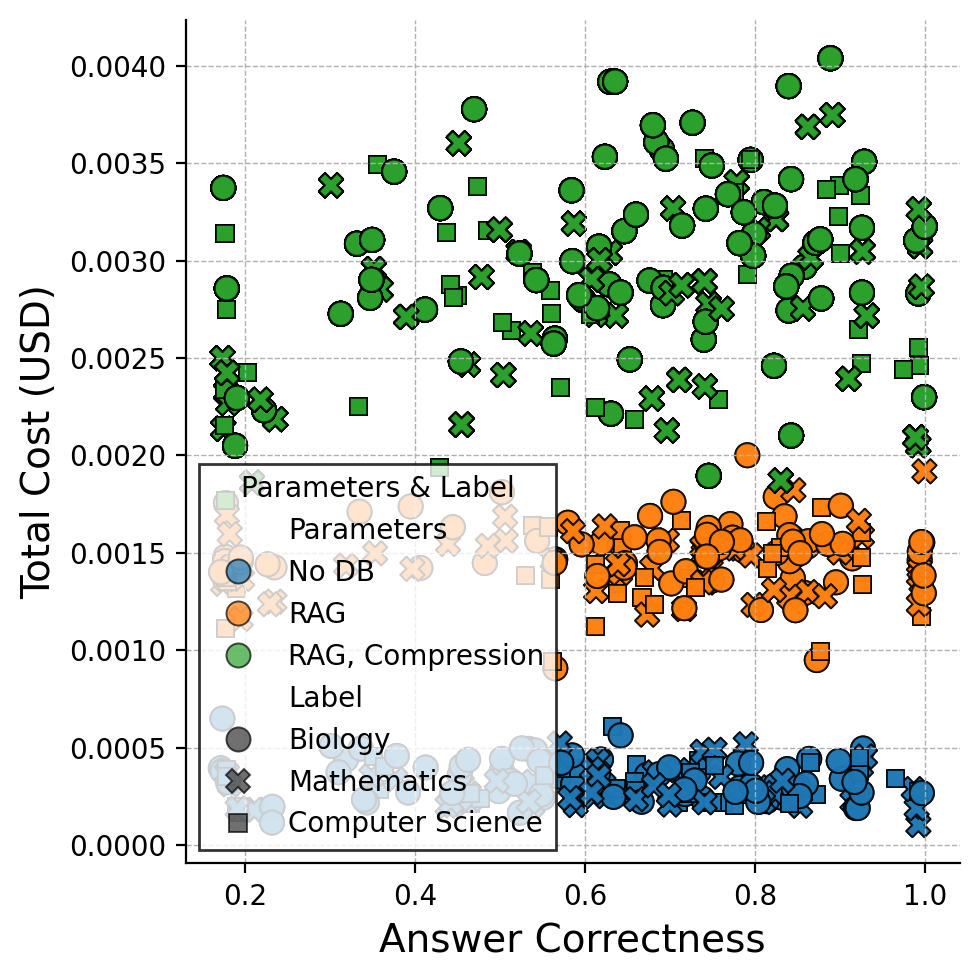

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

# Customize marker size and shadow scale
markerSize = 50
shadowScale = 1.5

# Create the scatter plot with enhanced styling
plt.figure(figsize=(5, 5), dpi=200)  # Adjust figure size for better readability
sns.scatterplot(data=pdf,
                x='answer_correctness',
                y='Total Cost (USD)',
                hue='Parameters',
                style='Label',
                edgecolor='k',      # Black edge for markers
                s=markerSize * shadowScale,  # Adjust marker size for shadow effect
                alpha=0.7           # Make points semi-transparent for a smooth look
               )
plt.legend(loc='best', fontsize='medium', title='Parameters & Label', edgecolor='k', fancybox=False)
plt.xlabel('Answer Correctness', fontsize=14)
plt.ylabel('Total Cost (USD)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
sns.despine()
plt.tight_layout()
plt.show()


In [111]:
pdf.shape

(6630, 22)

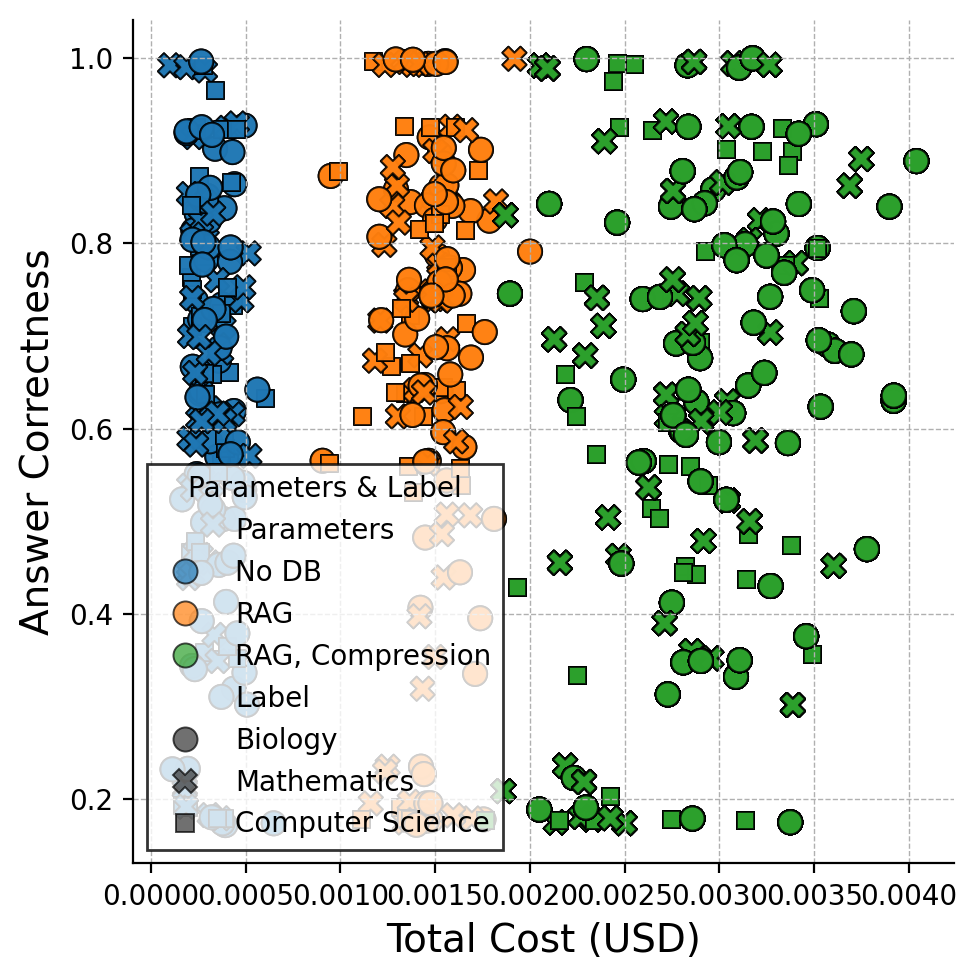

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

# Customize marker size and shadow scale
markerSize = 50
shadowScale = 1.5

# Create the scatter plot with enhanced styling
plt.figure(figsize=(5, 5), dpi=200)  # Adjust figure size for better readability
sns.scatterplot(data=pdf,
                x='Total Cost (USD)',
                y='answer_correctness',
                hue='Parameters',
                style='Label',
                edgecolor='k',      # Black edge for markers
                s=markerSize * shadowScale,  # Adjust marker size for shadow effect
                alpha=0.7           # Make points semi-transparent for a smooth look
               )
plt.legend(loc='best', fontsize='medium', title='Parameters & Label', edgecolor='k', fancybox=False)
plt.ylabel('Answer Correctness', fontsize=14)
plt.xlabel('Total Cost (USD)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
sns.despine()
plt.tight_layout()
plt.show()


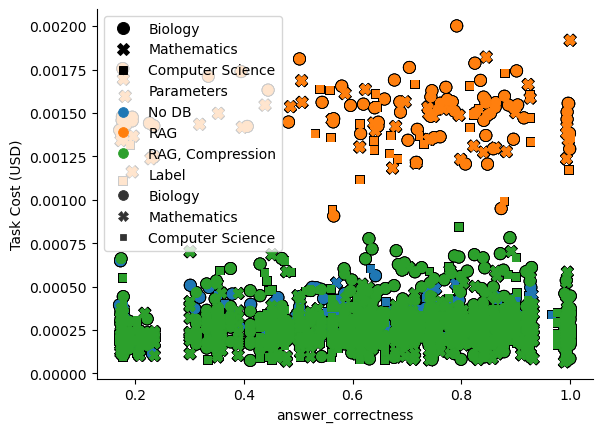

In [92]:
markerSize = 50
shaddowScale = 1.5
sns.scatterplot(data = pdf,
                x = 'answer_correctness',
                y = 'Task Cost (USD)',
                edgecolor=None,
                style = 'Label',
                s = markerSize * shaddowScale,
                color='k'
               )

sns.scatterplot(data = pdf,
                x = 'answer_correctness',
                y = 'Task Cost (USD)',
                hue = 'Parameters',
                style = 'Label',
                edgecolor=None,
                s = markerSize
               )
plt.legend(loc='best')
sns.despine()


## Radar Plots

### Radar Factory

In [2]:
def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` Axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding Axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

### Performance Metrics

In [71]:
pdf.columns

Index(['question', 'contexts', 'answer', 'ground_truth', 'answer_relevancy',
       'faithfulness', 'context_recall', 'context_precision',
       'answer_correctness', 'Model', 'Module', 'Total Time', 'Parameters',
       'Task', 'Task Time', 'Input Tokens', 'Output Tokens', 'Total Tokens',
       'Task Cost (USD)', 'Total Cost (USD)', 'Prompt', 'Label'],
      dtype='object')

In [44]:
grouped_data

answer_relevancy  faithfulness  context_recall  \
Parameters                                                         
No DB                     0.815491      0.398172        0.947353   
RAG                       0.876775      0.602261        0.948824   
RAG, Compression          0.922026      0.449292        0.949314   

                  context_precision  answer_correctness  
Parameters                                               
No DB                      0.864706            0.620508  
RAG                        0.868263            0.662950  
RAG, Compression           0.864706            0.635657

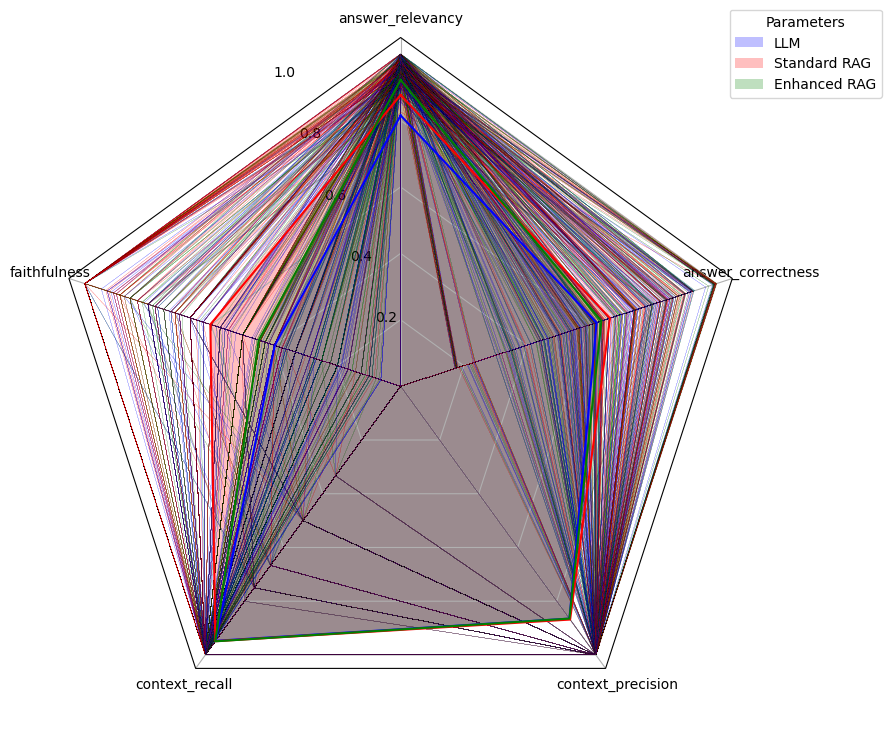

In [47]:
# Filter the dataframe to focus on performance metrics
performance_metrics = ['answer_relevancy',
       'faithfulness', 'context_recall', 'context_precision',
       'answer_correctness']
N = len(performance_metrics)
spoke_labels = performance_metrics
theta = radar_factory(N, frame='polygon')

colors = ['b', 'r', 'g']
labels = ["LLM", "Standard RAG", "Enhanced RAG"]


fig, ax = plt.subplots(figsize=(9, 9), nrows=1, ncols=1,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)


for question in pdf['question']:
    # Group data by 'Parameters' and compute the mean for the metrics
    grouped_data = pdf[(pdf['question'] == question) & (pdf['Task'] != 'Compression')][performance_metrics]
#    grouped_data = pdf[pdf['question'] == question][pdf['Task'] != 'Compression'][performance_metrics] # .groupby('Parameters')[performance_metrics] # .mean()
    normalized_data = grouped_data # .div(grouped_data.sum(axis=0), axis=1)
    normalized_data['Parameters'] = pdf[pdf['Task'] != 'Compression']['Parameters']
    data = [normalized_data.values[i,:] for i in range(normalized_data.shape[0])]

    ctr = 0
    for i, d in enumerate(data):
        ax.plot(theta, d[:-1], color=colors[i], linewidth=0.05, alpha=0.25)


grouped_data = pdf[pdf['Task'] != 'Compression'].groupby('Parameters')[performance_metrics].mean()
normalized_data = grouped_data # .div(grouped_data.sum(axis=0), axis=1)
data = [normalized_data.values[i,:] for i in range(3)]
ctr = 0
for d, color in zip(data, colors):
    ax.plot(theta, d, color=color)
    ax.fill(theta, d, facecolor=color, alpha=0.25, label=labels[ctr])
    ctr += 1
    
ax.set_varlabels(spoke_labels)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.05), fontsize='medium', title='Parameters')
# plt.ylim([0, 0.01])
# ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
plt.show()


In [72]:
pdf.columns

Index(['question', 'contexts', 'answer', 'ground_truth', 'answer_relevancy',
       'faithfulness', 'context_recall', 'context_precision',
       'answer_correctness', 'Model', 'Module', 'Total Time', 'Parameters',
       'Task', 'Task Time', 'Input Tokens', 'Output Tokens', 'Total Tokens',
       'Task Cost (USD)', 'Total Cost (USD)', 'Prompt', 'Label'],
      dtype='object')

### Cost Metrics

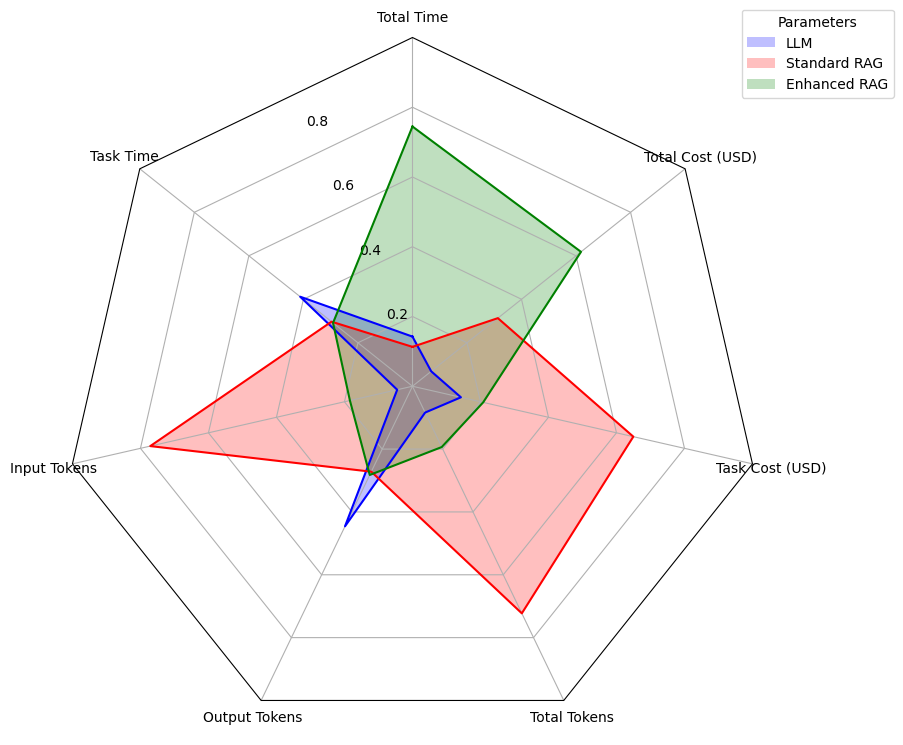

In [7]:
# Filter the dataframe to focus on performance metrics
performance_metrics = ['Total Time', 'Task Time', 'Input Tokens', 'Output Tokens', 
                       'Total Tokens', 'Task Cost (USD)', 'Total Cost (USD)']

N = len(performance_metrics)

# Group data by 'Parameters' and compute the mean for the metrics
grouped_data = pdf[pdf['Task'] != 'Compression'].groupby('Parameters')[performance_metrics].mean()

# Normalize the data by dividing by the column sum
normalized_data = grouped_data.div(grouped_data.sum(axis=0), axis=1)

theta = radar_factory(N, frame='polygon')

data = [normalized_data.values[i,:] for i in range(3)]
spoke_labels = performance_metrics

fig, ax = plt.subplots(figsize=(9, 9), nrows=1, ncols=1,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

colors = ['b', 'r', 'g']
ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
labels = ["LLM", "Standard RAG", "Enhanced RAG"]
ctr = 0
for d, color in zip(data, colors):
    ax.plot(theta, d, color=color)
    ax.fill(theta, d, facecolor=color, alpha=0.25, label=labels[ctr])
    ctr += 1
ax.set_varlabels(spoke_labels)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.05), fontsize='medium', title='Parameters')
plt.ylim([0, 1])
plt.show()

#### Quartiles

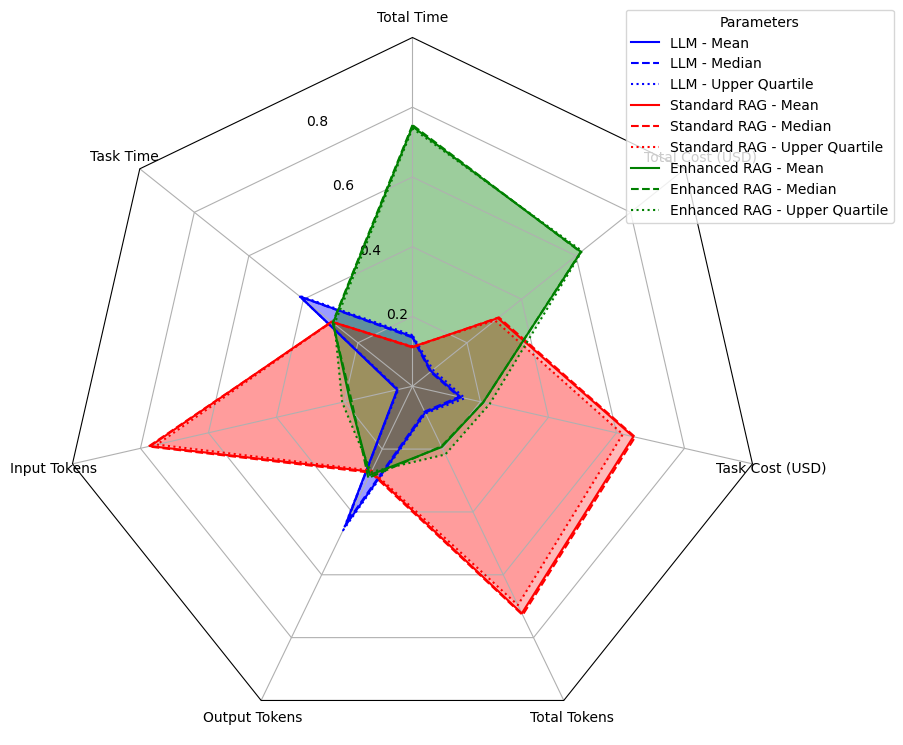

In [8]:
# Filter the dataframe to focus on performance metrics
performance_metrics = ['Total Time', 'Task Time', 'Input Tokens', 'Output Tokens', 
                       'Total Tokens', 'Task Cost (USD)', 'Total Cost (USD)']

N = len(performance_metrics)

# Group data by 'Parameters' and compute the mean, median, and upper quartile for the metrics
grouped_data_mean = pdf[pdf['Task'] != 'Compression'].groupby('Parameters')[performance_metrics].mean()
grouped_data_median = pdf[pdf['Task'] != 'Compression'].groupby('Parameters')[performance_metrics].median()
grouped_data_upper_quartile = pdf[pdf['Task'] != 'Compression'].groupby('Parameters')[performance_metrics].quantile(0.75)

# Normalize the data by dividing by the column sum
normalized_data_mean = grouped_data_mean.div(grouped_data_mean.sum(axis=0), axis=1)
normalized_data_median = grouped_data_median.div(grouped_data_median.sum(axis=0), axis=1)
normalized_data_upper_quartile = grouped_data_upper_quartile.div(grouped_data_upper_quartile.sum(axis=0), axis=1)

theta = radar_factory(N, frame='polygon')

# Prepare data for plotting
data_mean = [normalized_data_mean.values[i,:] for i in range(3)]
data_median = [normalized_data_median.values[i,:] for i in range(3)]
data_upper_quartile = [normalized_data_upper_quartile.values[i,:] for i in range(3)]
spoke_labels = performance_metrics

fig, ax = plt.subplots(figsize=(9, 9), nrows=1, ncols=1, subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

colors = ['b', 'r', 'g']
labels = ["LLM", "Standard RAG", "Enhanced RAG"]
ctr = 0

# Plot the data for mean, median, and upper quartile
for d_mean, d_median, d_upper, color in zip(data_mean, data_median, data_upper_quartile, colors):
    # Plot mean
    ax.plot(theta, d_mean, color=color, linestyle='-', label=f'{labels[ctr]} - Mean')
    ax.fill(theta, d_mean, facecolor=color, alpha=0.15)
    
    # Plot median
    ax.plot(theta, d_median, color=color, linestyle='--', label=f'{labels[ctr]} - Median')
    ax.fill(theta, d_median, facecolor=color, alpha=0.15)
    
    # Plot upper quartile
    ax.plot(theta, d_upper, color=color, linestyle=':', label=f'{labels[ctr]} - Upper Quartile')
    ax.fill(theta, d_upper, facecolor=color, alpha=0.15)
    
    ctr += 1

# Set axis labels and legend
ax.set_varlabels(spoke_labels)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.05), fontsize='medium', title='Parameters')

# Customize radar plot
plt.ylim([0, 1])
ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
plt.show()


#### Individuals

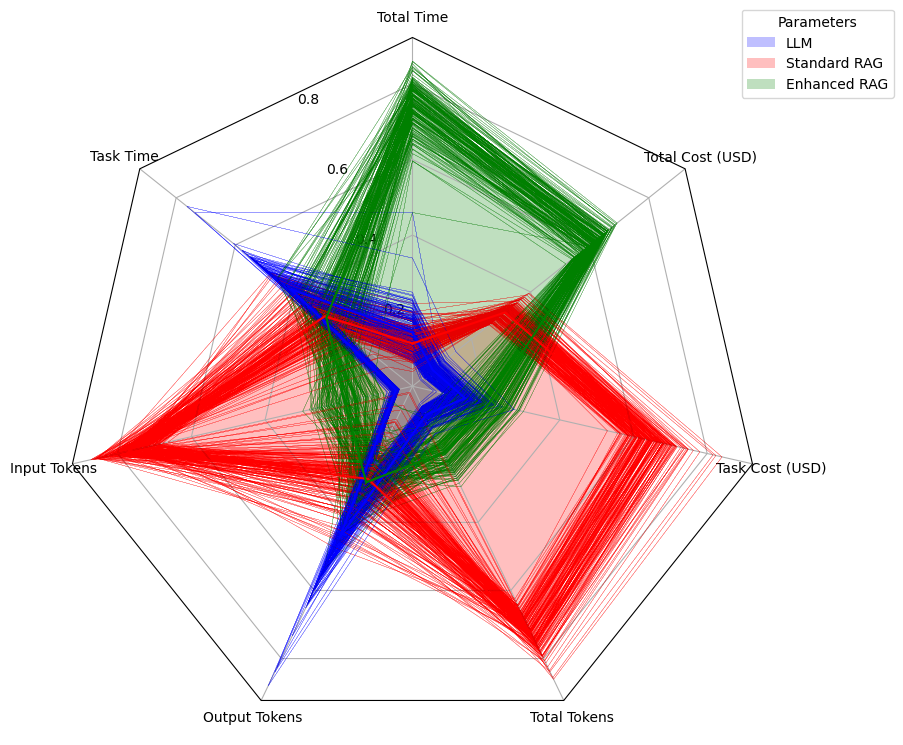

In [41]:
# Filter the dataframe to focus on performance metrics
performance_metrics = ['Total Time', 'Task Time', 'Input Tokens', 'Output Tokens', 
                       'Total Tokens', 'Task Cost (USD)', 'Total Cost (USD)']
N = len(performance_metrics)
spoke_labels = performance_metrics
theta = radar_factory(N, frame='polygon')

colors = ['b', 'r', 'g']
labels = ["LLM", "Standard RAG", "Enhanced RAG"]


fig, ax = plt.subplots(figsize=(9, 9), nrows=1, ncols=1,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)


for question in pdf['question']:
    # Group data by 'Parameters' and compute the mean for the metrics
    grouped_data = pdf[(pdf['question'] == question) & (pdf['Task'] != 'Compression')][performance_metrics]
#    grouped_data = pdf[pdf['question'] == question][pdf['Task'] != 'Compression'][performance_metrics] # .groupby('Parameters')[performance_metrics] # .mean()
    normalized_data = grouped_data.div(grouped_data.sum(axis=0), axis=1)
    normalized_data['Parameters'] = pdf[pdf['Task'] != 'Compression']['Parameters']
    data = [normalized_data.values[i,:] for i in range(normalized_data.shape[0])]

    ctr = 0
    for i, d in enumerate(data):
        ax.plot(theta, d[:-1], color=colors[i], linewidth=0.05, alpha=0.25)


grouped_data = pdf[pdf['Task'] != 'Compression'].groupby('Parameters')[performance_metrics].mean()
normalized_data = grouped_data.div(grouped_data.sum(axis=0), axis=1)
data = [normalized_data.values[i,:] for i in range(3)]
ctr = 0
for d, color in zip(data, colors):
    ax.plot(theta, d, color=color)
    ax.fill(theta, d, facecolor=color, alpha=0.25, label=labels[ctr])
    ctr += 1
    
ax.set_varlabels(spoke_labels)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.05), fontsize='medium', title='Parameters')
# plt.ylim([0, 0.01])
# ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


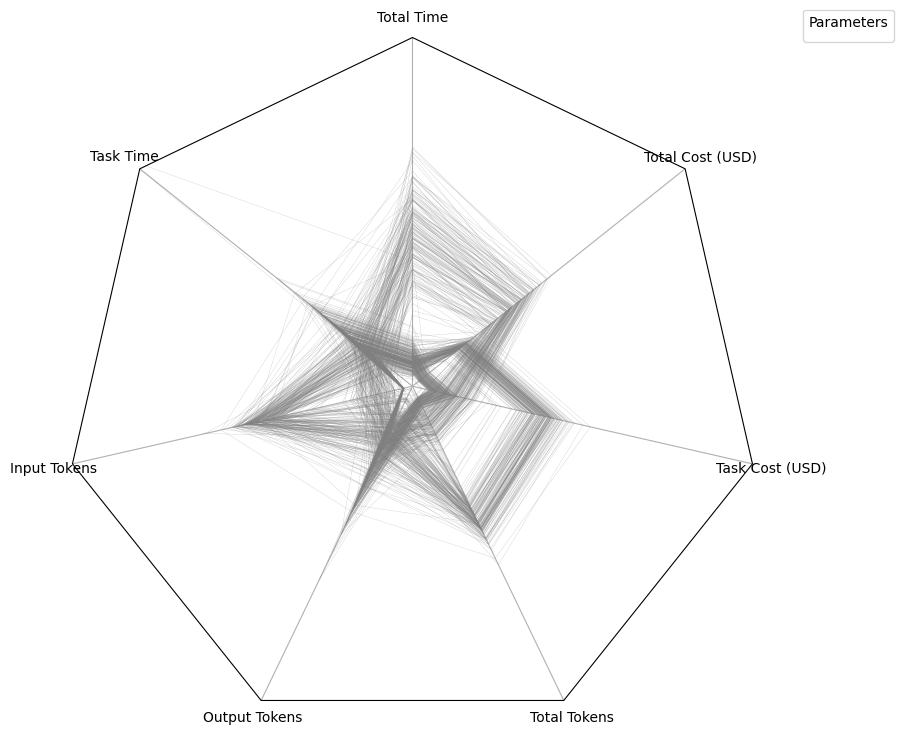

In [31]:
# Filter the dataframe to focus on performance metrics
performance_metrics = ['Total Time', 'Task Time', 'Input Tokens', 'Output Tokens', 
                       'Total Tokens', 'Task Cost (USD)', 'Total Cost (USD)']

N = len(performance_metrics)

# Group data by 'Parameters' and compute the mean for the metrics
grouped_data = pdf[pdf['Task'] != 'Compression'][performance_metrics] # .groupby('Parameters')[performance_metrics] # .mean()

normalized_data = grouped_data.div(grouped_data.sum(axis=0), axis=1)
normalized_data['Parameters'] = pdf[pdf['Task'] != 'Compression']['Parameters']


theta = radar_factory(N, frame='polygon')

data = [normalized_data.values[i,:] for i in range(normalized_data.shape[0])]
spoke_labels = performance_metrics

fig, ax = plt.subplots(figsize=(9, 9), nrows=1, ncols=1,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

colors = ['b', 'r', 'g']
ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
labels = ["LLM", "Standard RAG", "Enhanced RAG"]
ctr = 0
for d in data:
    ax.plot(theta, d[:-1], color='grey', linewidth=0.1)

ax.set_varlabels(spoke_labels)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.05), fontsize='medium', title='Parameters')
plt.ylim([0, 0.01])
plt.show()


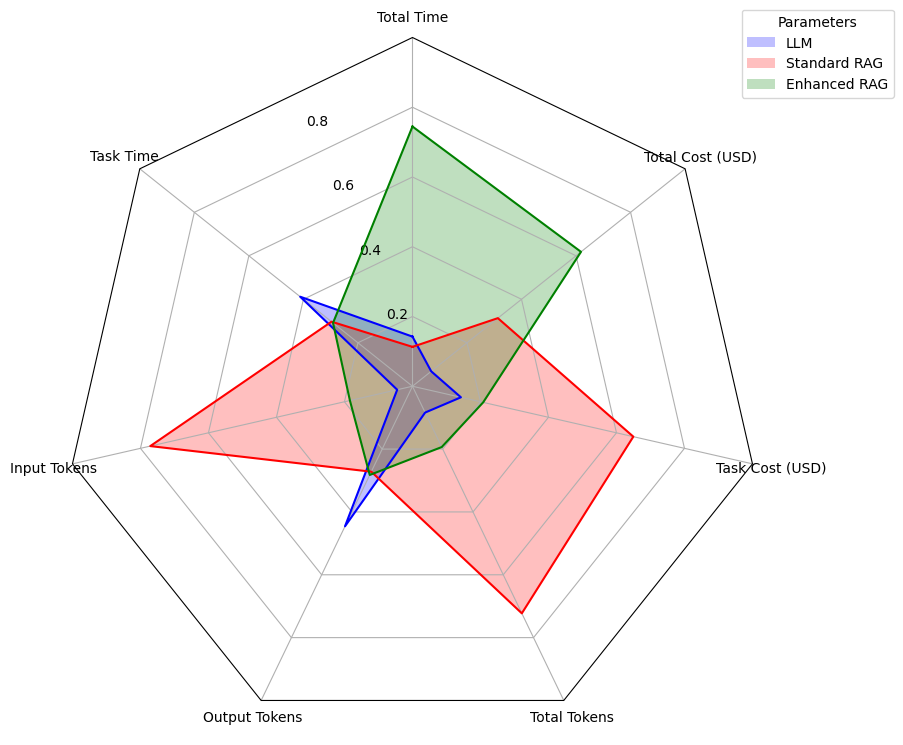

In [60]:
N = 7
theta = radar_factory(N, frame='polygon')

data = [normalized_data.values[i,:] for i in range(3)]
spoke_labels = performance_metrics

fig, ax = plt.subplots(figsize=(9, 9), nrows=1, ncols=1,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

colors = ['b', 'r', 'g']
ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
labels = ["LLM", "Standard RAG", "Enhanced RAG"]
ctr = 0
for d, color in zip(data, colors):
    ax.plot(theta, d, color=color)
    ax.fill(theta, d, facecolor=color, alpha=0.25, label=labels[ctr])
    ctr += 1
ax.set_varlabels(spoke_labels)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.05), fontsize='medium', title='Parameters')
plt.ylim([0, 1])
plt.show()

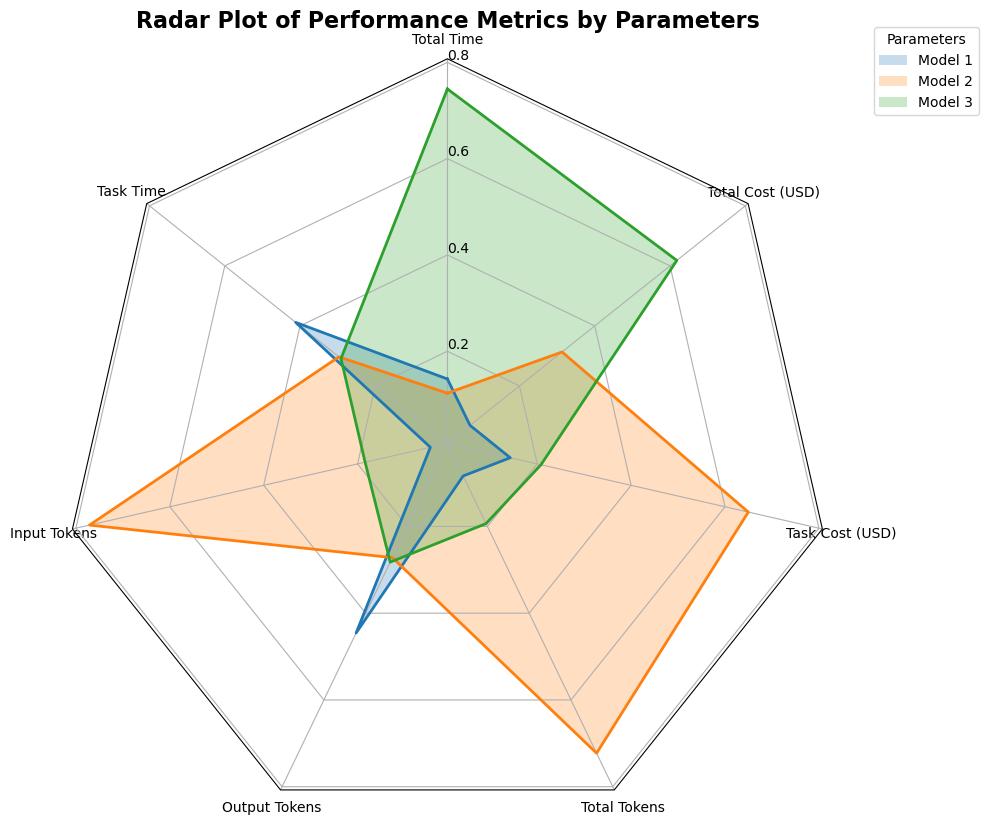

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.projections.polar import PolarAxes

# Number of metrics
N = 7
# Generate the angle (theta) for each axis
theta = radar_factory(N, frame='polygon')

# Prepare the data for the plot
data = [normalized_data.values[i, :] for i in range(3)]
spoke_labels = performance_metrics

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

# Set up custom colors for each dataset
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Custom colors (blue, orange, green)

# Configure radial gridlines and title
ax.set_rgrids([0.2, 0.4, 0.6, 0.8], labels=['0.2', '0.4', '0.6', '0.8'], angle=0)
ax.set_title('Radar Plot of Performance Metrics by Parameters', weight='bold', size=16, 
             position=(0.5, 1.1), horizontalalignment='center', verticalalignment='center')

# Plot and fill areas for each dataset
for d, color, label in zip(data, colors, ['Model 1', 'Model 2', 'Model 3']):
    ax.plot(theta, d, color=color, linewidth=2)
    ax.fill(theta, d, facecolor=color, alpha=0.25, label=label)

# Set the labels for each axis (spokes)
ax.set_varlabels(spoke_labels)

# Add legend outside the radar plot
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.05), fontsize='medium', title='Parameters')

# Show the plot
plt.tight_layout()
plt.show()


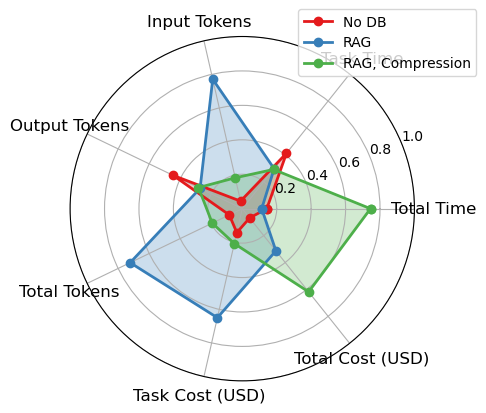

In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Filter the dataframe to focus on performance metrics
performance_metrics = ['Total Time', 'Task Time', 'Input Tokens', 'Output Tokens', 'Total Tokens',
       'Task Cost (USD)', 'Total Cost (USD)']

# Group data by 'Parameters' and compute the mean for the metrics
grouped_data = pdf[pdf['Task'] != 'Compression'].groupby('Parameters')[performance_metrics].mean()

normalized_data = grouped_data # .apply(normalize_column)
normalized_data = normalized_data.div(normalized_data.sum(axis=0), axis=1)

num_vars = len(performance_metrics)

fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# Loop through each 'Parameters' group and plot a polygon with straight lines
for parameter, row in normalized_data.iterrows():
    values = row.tolist()
    values += values[:1]  # Ensure the plot is closed by adding the first value to the end
    # Plot the radar chart with straight lines between axes
    ax.plot(angles, values, label=parameter, linewidth=2, linestyle='-', marker='o')
    ax.fill(angles, values, alpha=0.25)  # Optionally fill the area

# Set the labels for each metric around the circle
ax.set_xticks(angles[:-1])
ax.set_xticklabels(performance_metrics, fontsize=12)

# Set the y-axis range for the performance metrics
ax.set_ylim(0, 1)  # Adjust this range based on your data (normalize if necessary)

# Add grid lines and set the appearance of the grid
ax.grid(True)

# TODO: Make the legend look nicer. Black box. Sharp corners
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

# Display the plot
plt.tight_layout()
plt.show()


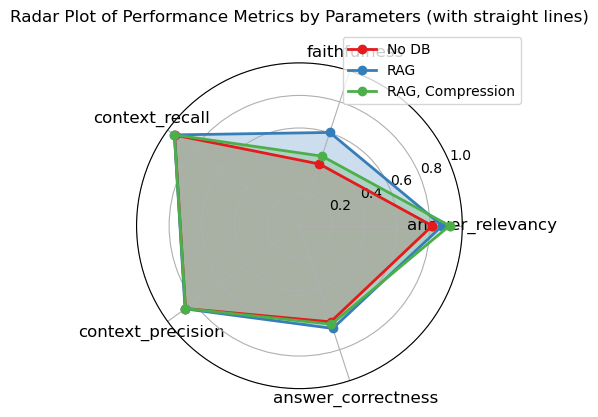

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Filter the dataframe to focus on performance metrics
performance_metrics = ['answer_relevancy', 'faithfulness', 'context_recall', 
                       'context_precision', 'answer_correctness']

# Group data by 'Parameters' and compute the mean for the metrics
grouped_data = pdf[pdf['Task'] != 'Compression'].groupby('Parameters')[performance_metrics].mean()

# Normalize the data (optional, can be adjusted to scale values if needed)
def normalize_column(col):
    return col
normalized_data = grouped_data.apply(normalize_column)

# Number of variables
num_vars = len(performance_metrics)

# Initialize the radar plot with straight lines (no polar coordinates)
# fig, ax = plt.subplots(figsize=(8, 8))
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))

# Generate angles for each performance metric
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Create a complete circle by appending the first angle at the end
angles += angles[:1]

# Loop through each 'Parameters' group and plot a polygon with straight lines
for parameter, row in normalized_data.iterrows():
    values = row.tolist()
    values += values[:1]  # Ensure the plot is closed by adding the first value to the end
    
    # Plot the radar chart with straight lines between axes
    ax.plot(angles, values, label=parameter, linewidth=2, linestyle='-', marker='o')
    ax.fill(angles, values, alpha=0.25)  # Optionally fill the area

# Set the labels for each metric around the circle
ax.set_xticks(angles[:-1])
ax.set_xticklabels(performance_metrics, fontsize=12)

# Set the y-axis range for the performance metrics
ax.set_ylim(0, 1)  # Adjust this range based on your data (normalize if necessary)

# Add grid lines and set the appearance of the grid
ax.grid(True)

# Add title and legend
plt.title('Radar Plot of Performance Metrics by Parameters (with straight lines)', color='black', y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

# Display the plot
plt.tight_layout()
plt.show()


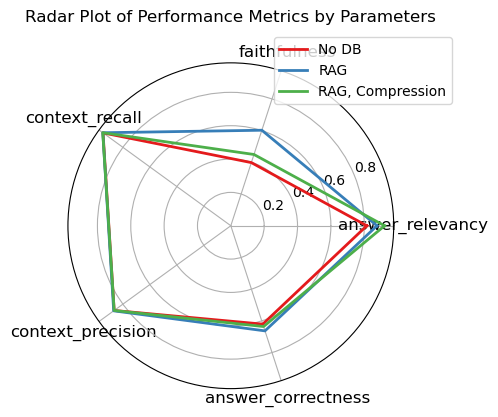

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# Filter the dataframe to focus on performance metrics
performance_metrics = ['answer_relevancy', 'faithfulness', 'context_recall', 
                       'context_precision', 'answer_correctness']

# Group data by 'Parameters' and compute the mean for the metrics
grouped_data = pdf[pdf['Task'] != 'Compression'].groupby('Parameters')[performance_metrics].mean()

normalized_data = grouped_data #.apply(normalize_column)

# Number of variables we're plotting
num_vars = len(performance_metrics)

# Compute the angle of each axis in the plot (divide the plot / number of variables)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Make the plot circular by appending the start to the end
angles += angles[:1]

# Initialize the radar plot
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))

# Loop through each 'Parameters' group to create a separate plot
for parameter, row in normalized_data.iterrows():
    # Values for each parameter
    values = row.tolist()
    values += values[:1]  # Ensure the plot is closed
    
    # Plot values and fill area
    ax.plot(angles, values, label=parameter, linewidth=2)

# Add labels for each metric
ax.set_xticks(angles[:-1])
ax.set_xticklabels(performance_metrics, fontsize=12)

# Add title and legend
plt.title('Radar Plot of Performance Metrics by Parameters', color='black', y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

# Display the plot
plt.tight_layout()
plt.show()


## Pair Plots

2024-09-23 17:27:17,533 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 3600x3600 with 0 Axes>

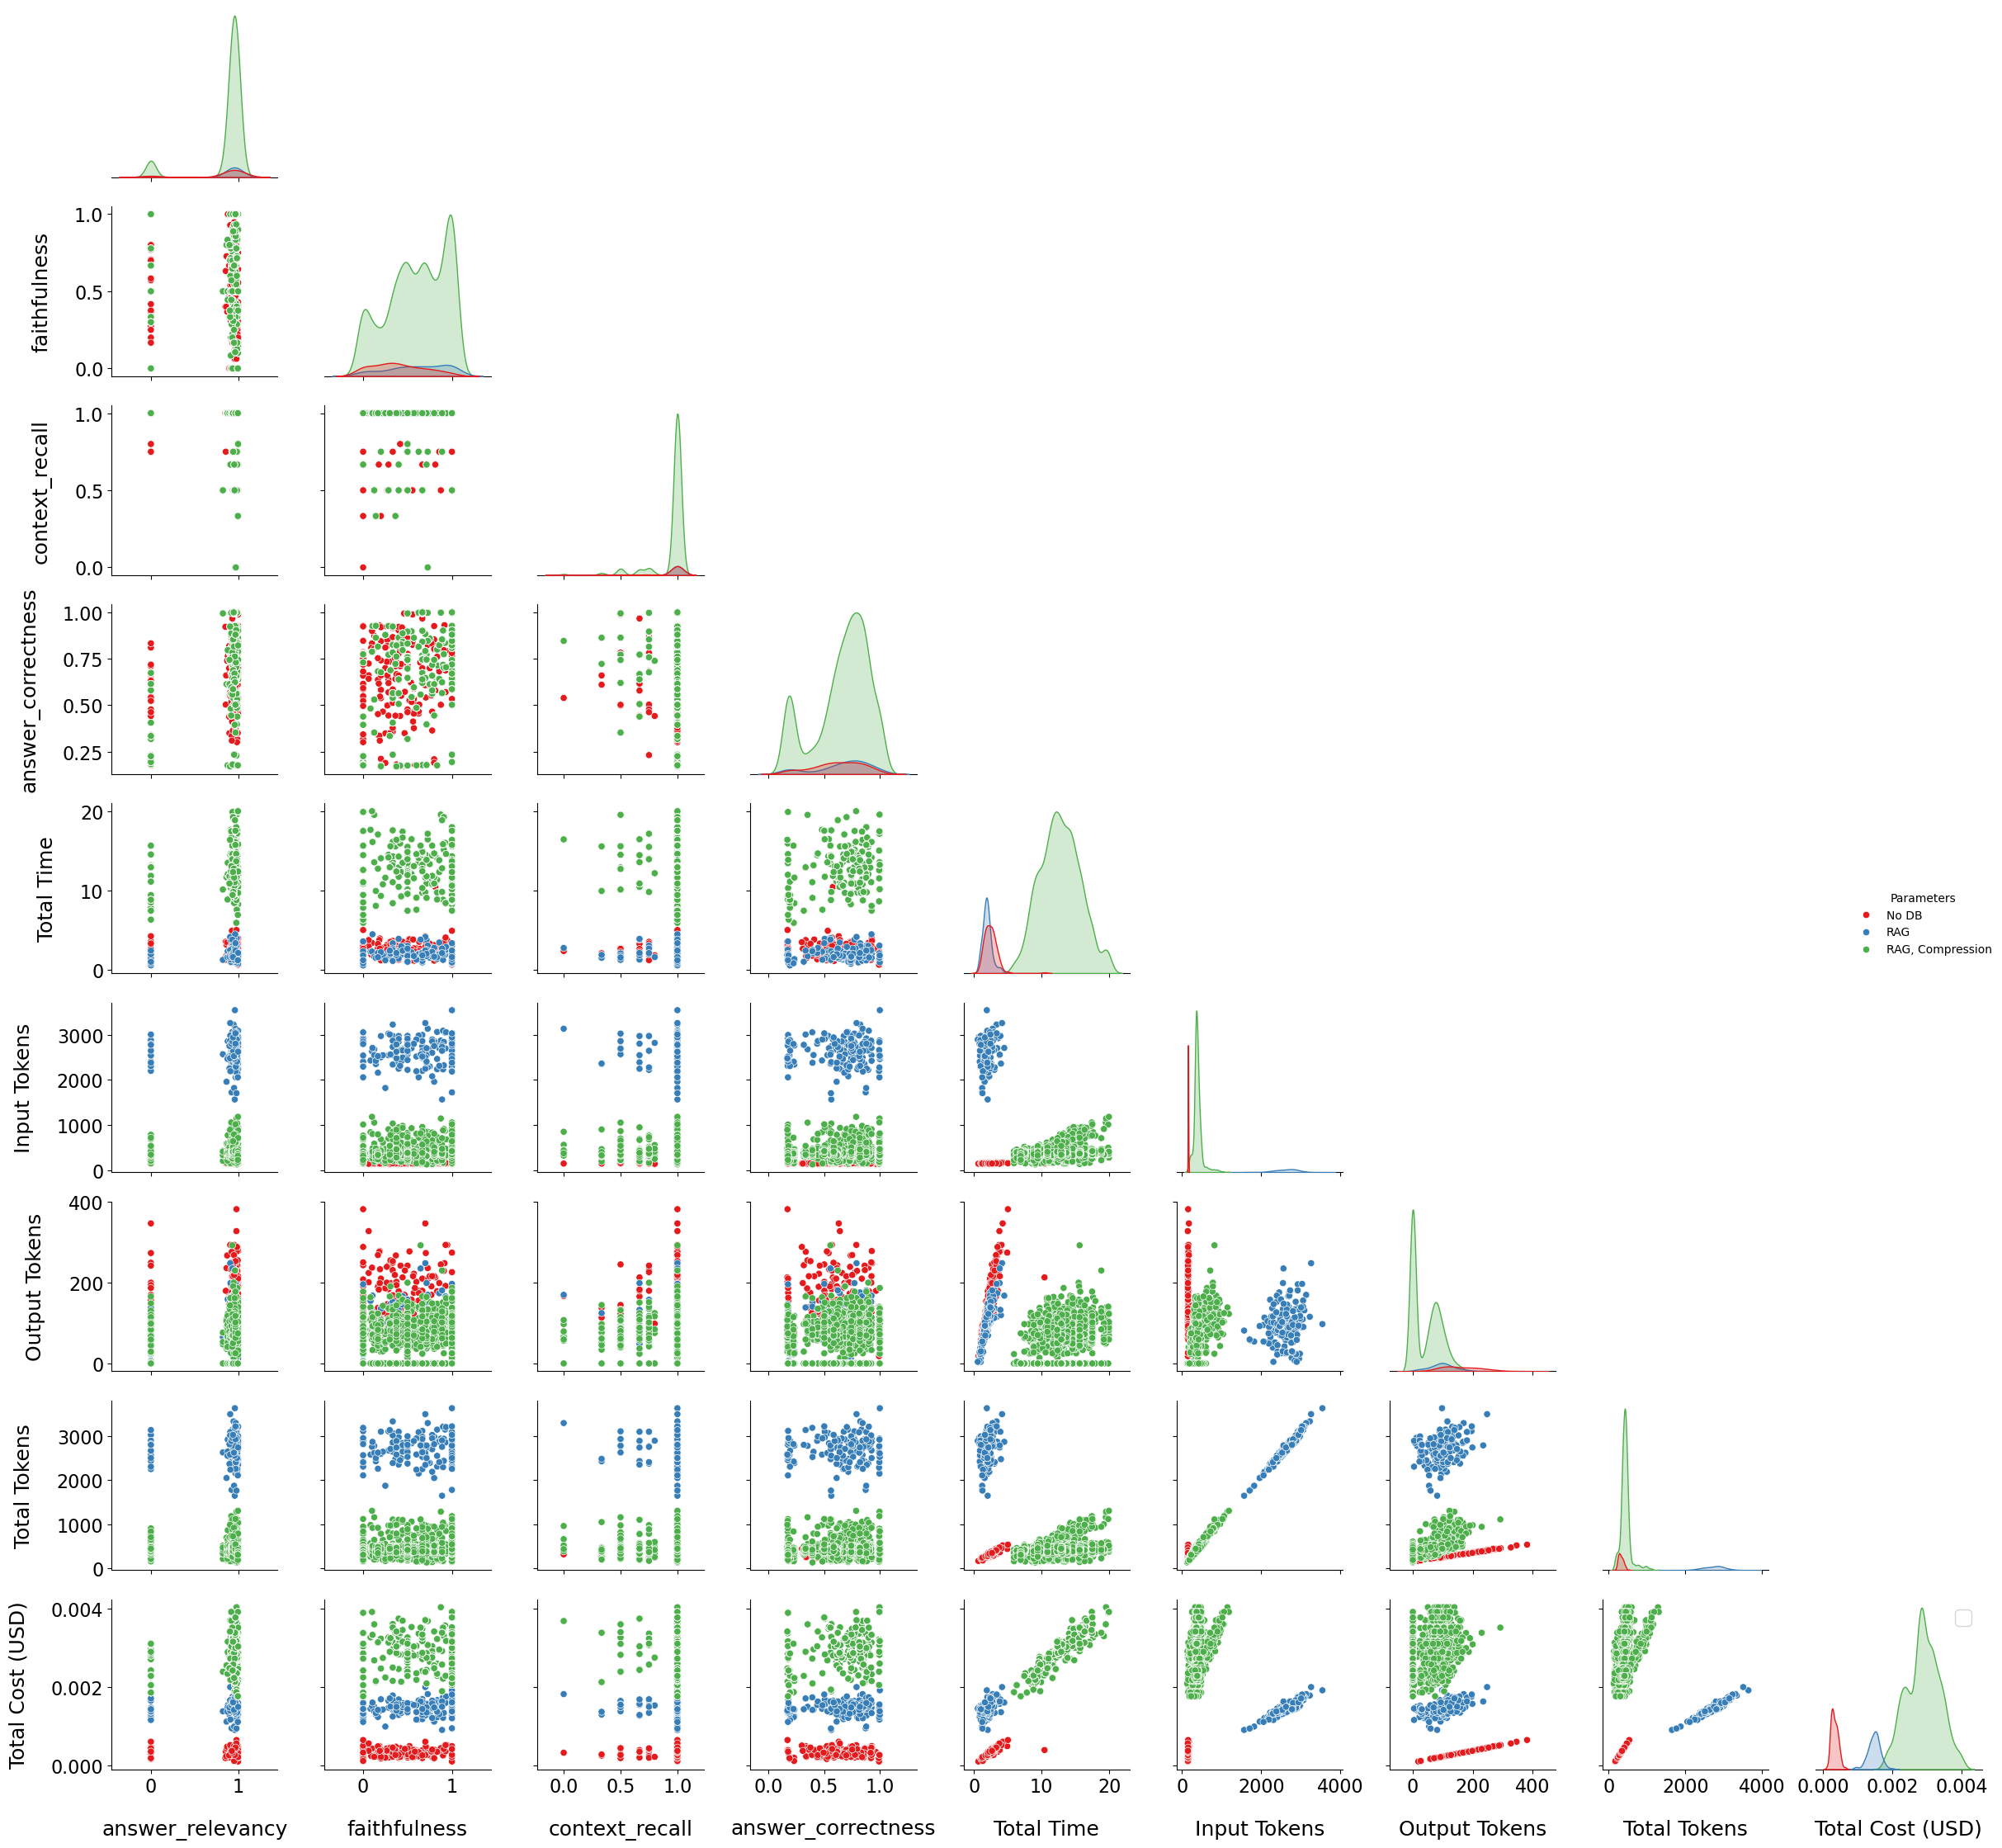

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,12), dpi=300)

# Set a custom color palette for better aesthetics
sns.set_palette("Set1")  # Husl is a nice palette with varied hues

# Create the pairplot
g = sns.pairplot(data=pdf,
                 hue='Parameters',
                 corner=True,
                 diag_kind='kde',  # Kernel Density Estimate for diagonal
                 vars=['answer_relevancy', 'faithfulness', 'context_recall', 
                       'answer_correctness', 'Total Time', 'Input Tokens', 
                       'Output Tokens', 'Total Tokens', 'Total Cost (USD)']
                )

# Customize labels and title
# g.fig.suptitle("Parameter Analysis Pairplot", fontsize=30, y=1.02)  # Large title with some space at the top
# g.set(xlabel='', ylabel='')  # Remove redundant axis labels (they are automatically in the diagonal plots)

# Adjust labels and ticks
for ax in g.axes.flatten():
    if ax is None:
        continue
    ax.tick_params(axis='both', which='major', labelsize=16)  # Adjust tick label size for better readability
    ax.set_xlabel(ax.get_xlabel(), fontsize=18, labelpad=20)  # Larger x-labels with spacing
    ax.set_ylabel(ax.get_ylabel(), fontsize=18, labelpad=20)  # Larger y-labels with spacing

# Adjust legend
plt.legend(loc='best', fontsize=18, title_fontsize='22')  # Adjust legend font size

# Tight layout to minimize unnecessary white spaces
plt.tight_layout()

# Save the figure
# g.savefig("pairplot_parameters.png", dpi=300)


<Figure size 10800x10800 with 0 Axes>

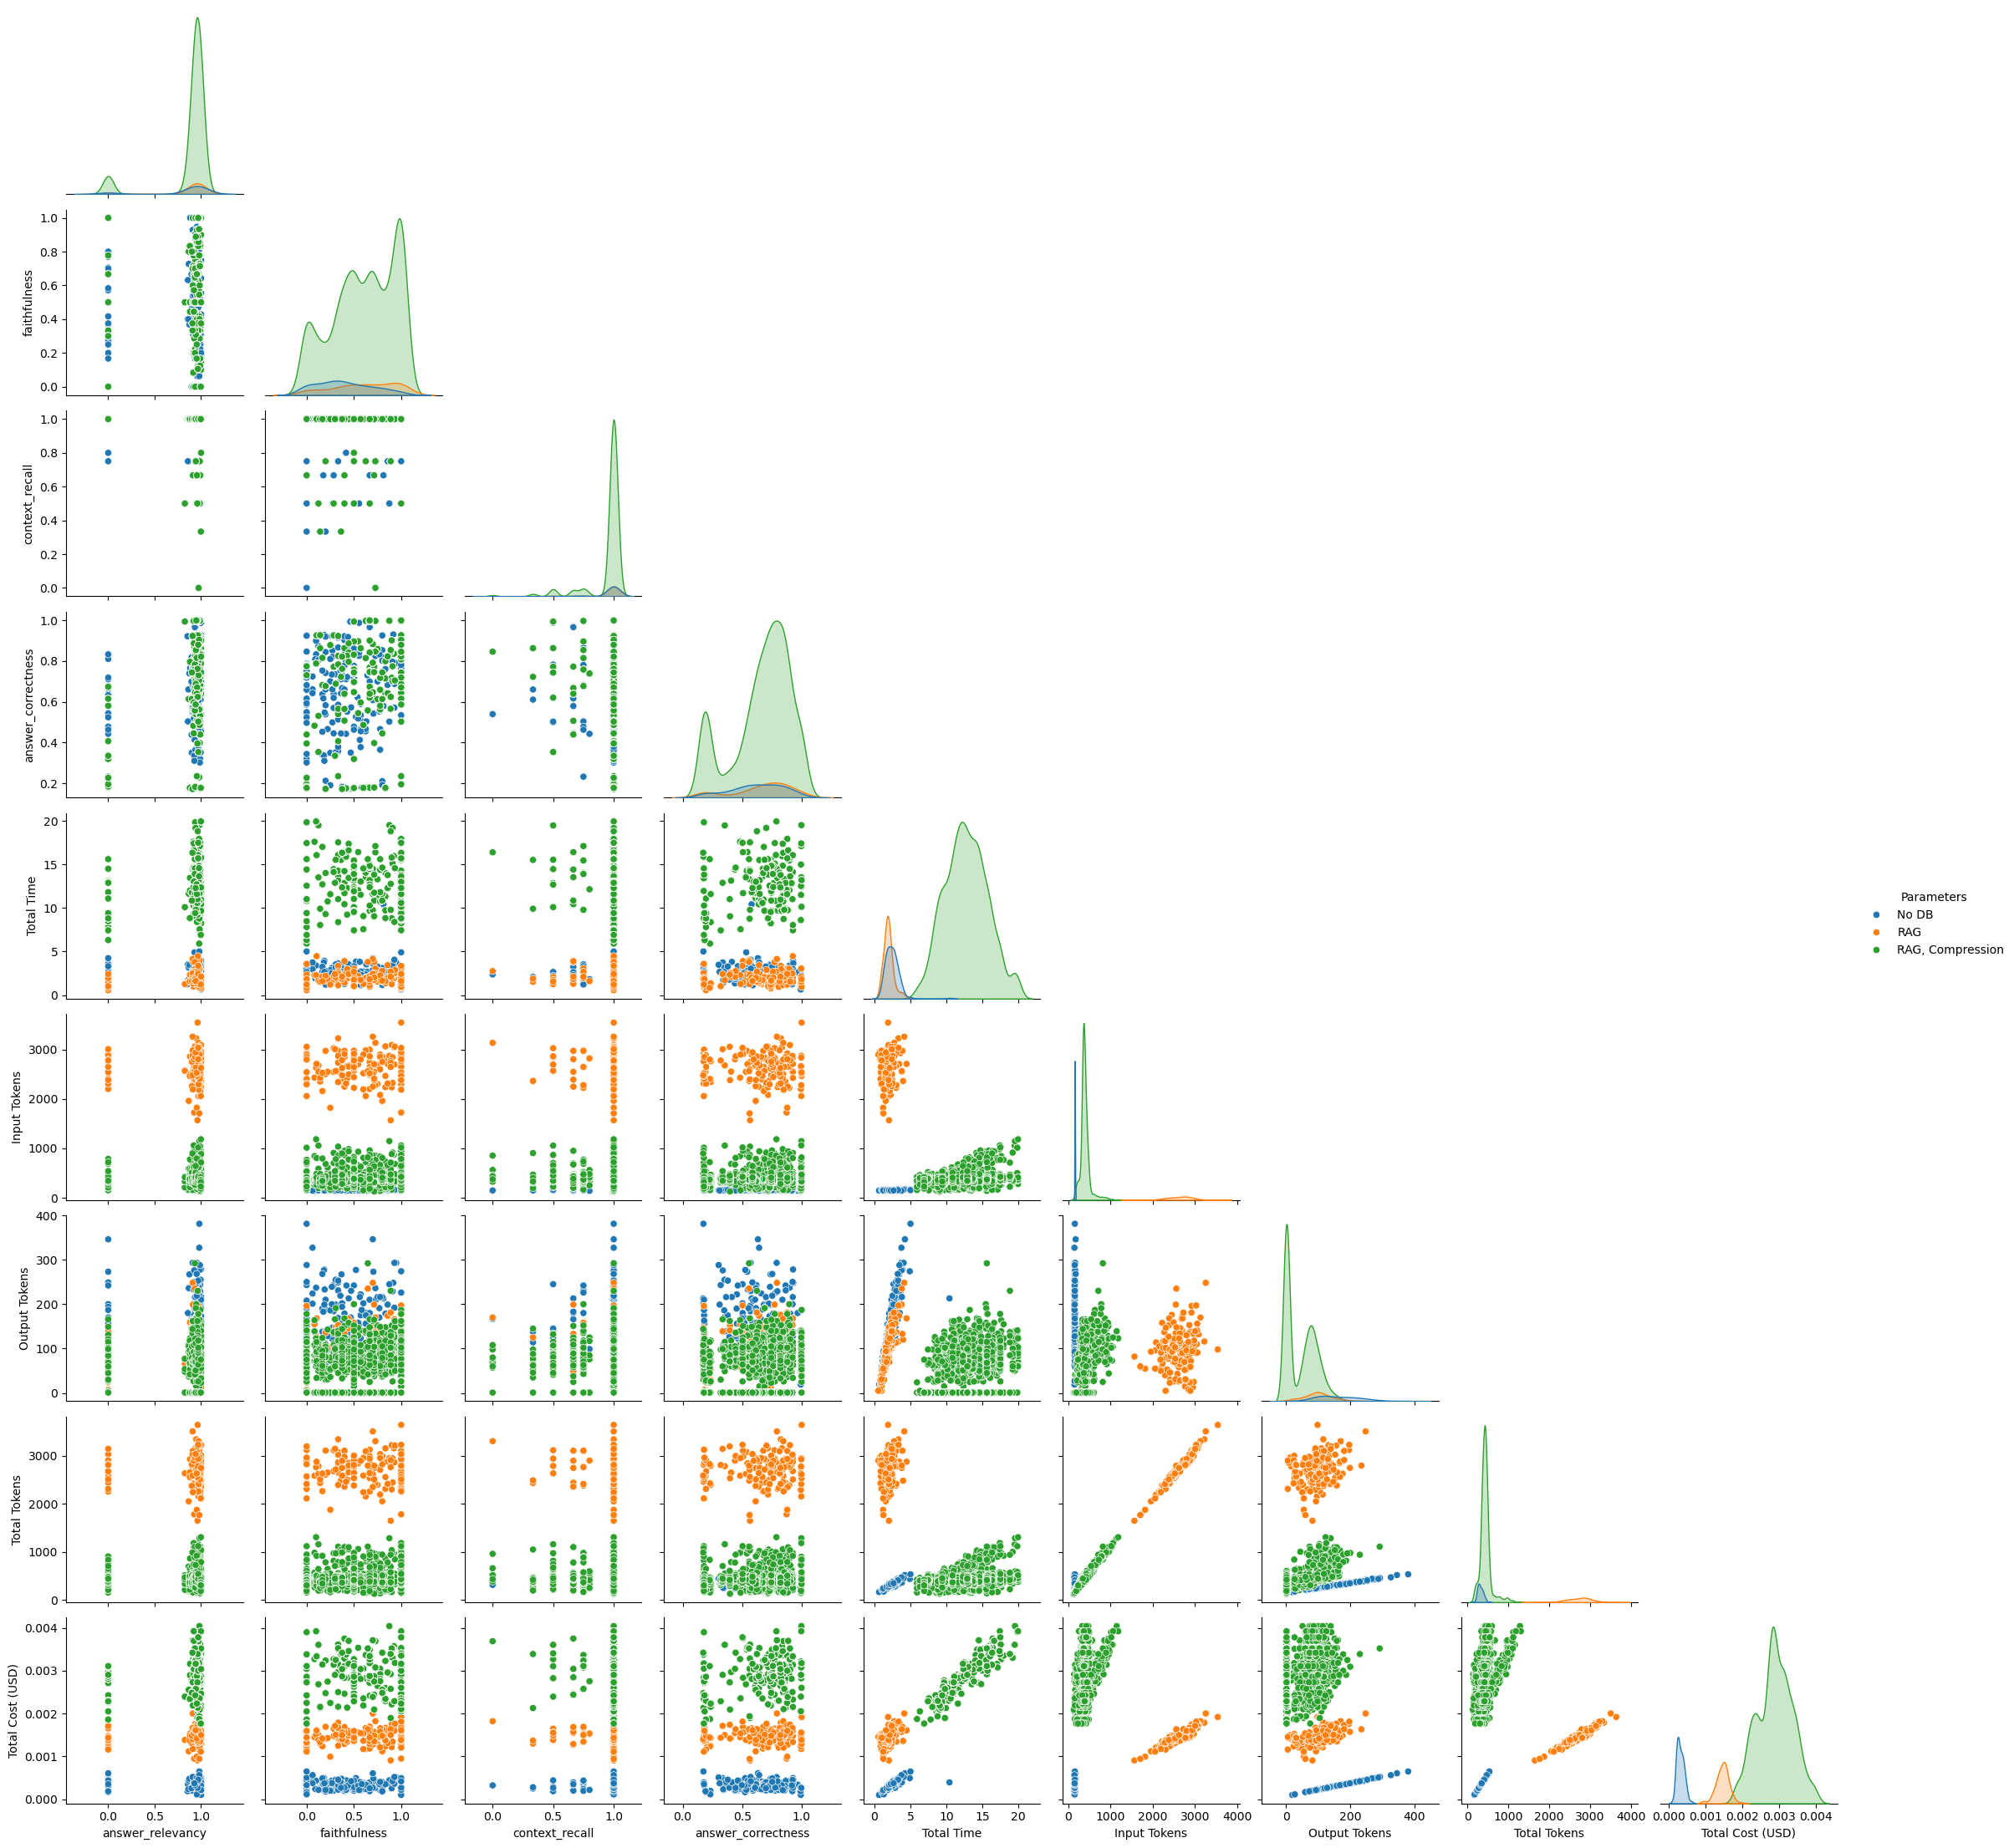

In [126]:
plt.figure(figsize=(36,36),dpi=300)
sns.pairplot(data=pdf,
             hue='Parameters',
             corner=True,
             vars = ['answer_relevancy',
       'faithfulness', 'context_recall',
       'answer_correctness', 'Total Time',
       'Input Tokens', 'Output Tokens', 'Total Tokens',
       'Total Cost (USD)']
            )


<Figure size 10800x10800 with 0 Axes>

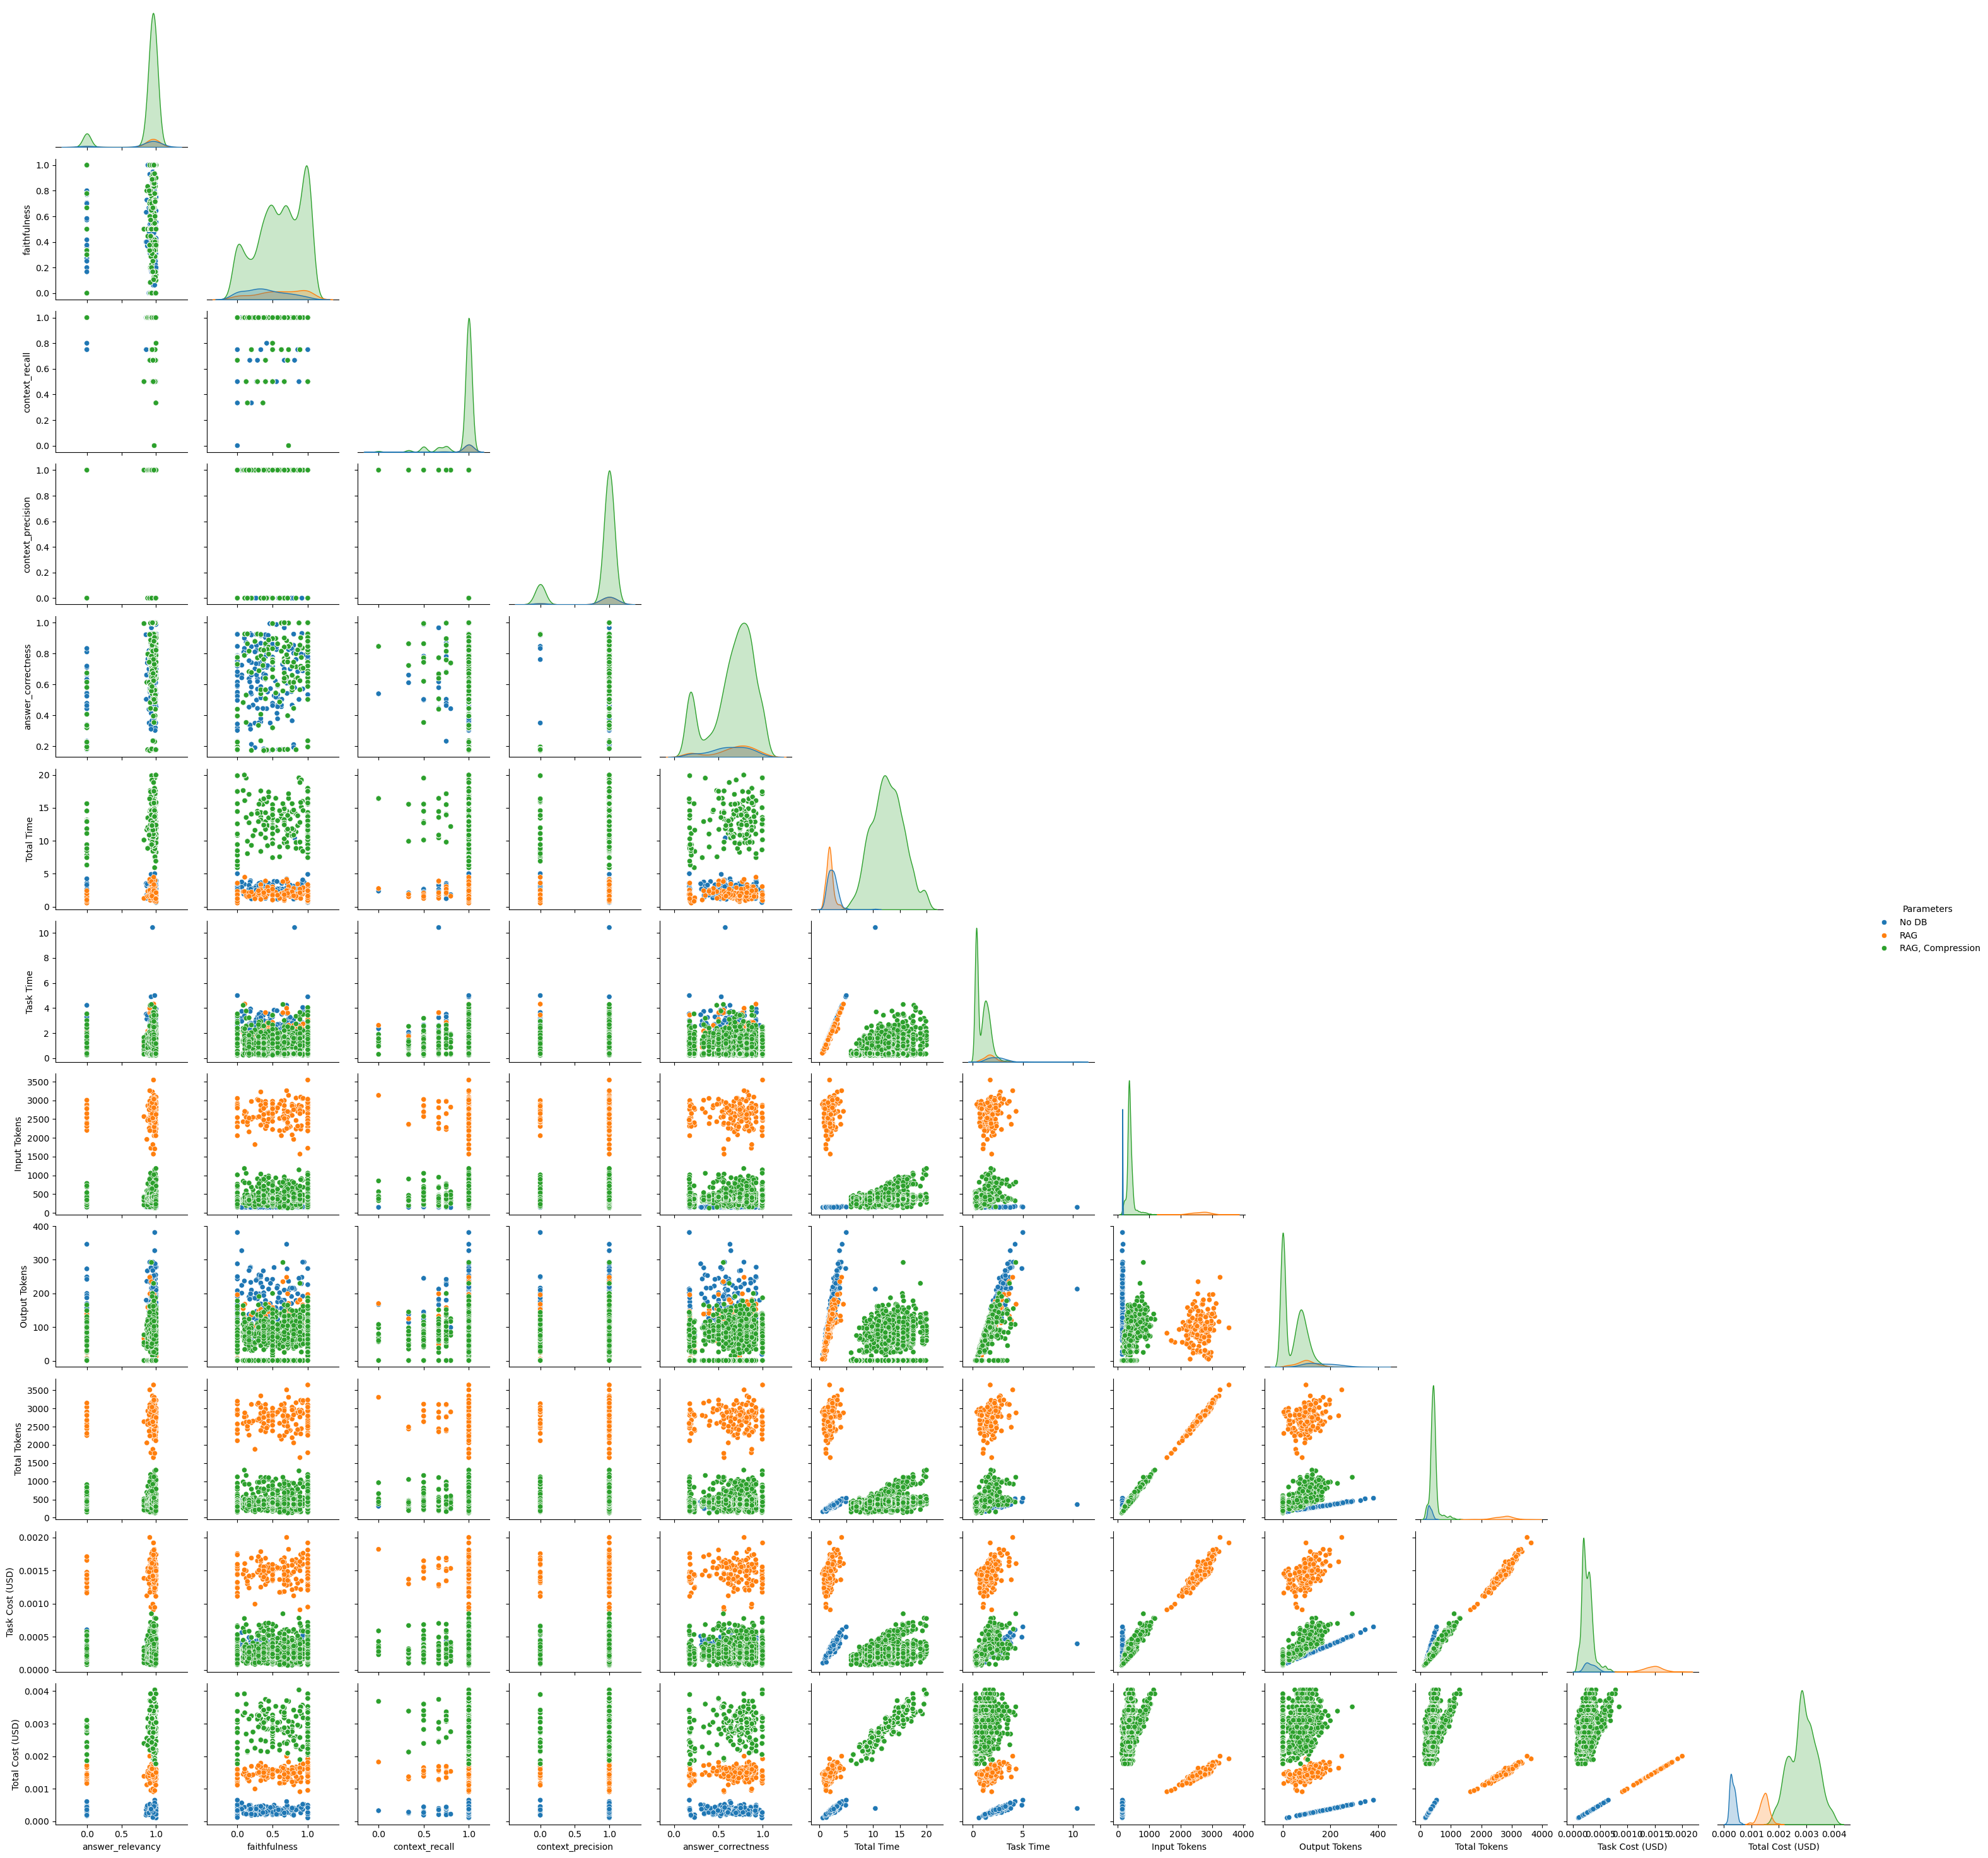

In [123]:
plt.figure(figsize=(36,36),dpi=300)
sns.pairplot(data=pdf,
             hue='Parameters',
             corner=True
            )


## Radar and Spider Plot

In [64]:
def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` Axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding Axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [ ]:
performance_metrics = ['Total Time', 'Task Time', 'Input Tokens', 'Output Tokens', 
                       'Total Tokens', 'Task Cost (USD)', 'Total Cost (USD)']

# Group data by 'Parameters' and compute the mean for the metrics
grouped_data = pdf[pdf['Task'] != 'Compression'].groupby('Parameters')[performance_metrics].mean()

# Normalize the data by dividing by the column sum
normalized_data = grouped_data.div(grouped_data.sum(axis=0), axis=1)

N = 7
theta = radar_factory(N, frame='polygon')

data = [normalized_data.values[i,:] for i in range(3)]
spoke_labels = performance_metrics

fig, ax = plt.subplots(figsize=(9, 9), nrows=1, ncols=1,
                       subplot_kw=dict(projection='radar'),
                       dpi=200
                      )

colors = ['b', 'r', 'g']
for d, color in zip(data, colors):
    ax.plot(theta, d, color=color)
    ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
ax.set_varlabels(spoke_labels)
plt.yticks([0.25, 0.5, 0.75])
sns.despine()


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x14df69de8e00> (for post_execute):


In [68]:
normalized_data

Total Time  Task Time  Input Tokens  Output Tokens  \
Parameters                                                             
No DB               0.142325   0.411780      0.044923       0.445683   
RAG                 0.112946   0.296938      0.771101       0.271970   
RAG, Compression    0.744729   0.291282      0.183976       0.282347   

                  Total Tokens  Task Cost (USD)  Total Cost (USD)  
Parameters                                                         
No DB                 0.083744         0.142485          0.068697  
RAG                   0.722751         0.649591          0.313192  
RAG, Compression      0.193505         0.207924          0.618110

In [ ]:
N = 7
theta = radar_factory(N, frame='polygon')

data = example_data()
spoke_labels = data.pop(0)

fig, axs = plt.subplots(figsize=(9, 9), nrows=2, ncols=2,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

colors = ['b', 'r', 'g', 'm', 'y']
# Plot the four cases from the example data on separate Axes
for ax, (title, case_data) in zip(axs.flat, data):
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
    ax.set_varlabels(spoke_labels)

# add legend relative to top-left plot
labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
legend = axs[0, 0].legend(labels, loc=(0.9, .95),
                          labelspacing=0.1, fontsize='small')

fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
         horizontalalignment='center', color='black', weight='bold',
         size='large')

plt.show()

# Tables

In [9]:
pdf.columns=

Index(['question', 'contexts', 'answer', 'ground_truth', 'answer_relevancy',
       'faithfulness', 'context_recall', 'context_precision',
       'answer_correctness', 'Model', 'Module', 'Total Time', 'Parameters',
       'Task', 'Task Time', 'Input Tokens', 'Output Tokens', 'Total Tokens',
       'Task Cost (USD)', 'Total Cost (USD)', 'Prompt', 'Label'],
      dtype='object')

## Cost

In [38]:
def float_format(x):
    # If the number is too small, use scientific notation
    if abs(x) < 0.01:
        return f"{x:.2e}"  # Use scientific notation for small numbers
    elif abs(x) > 10:
        return f"{x:.0f}"
    else:
        return f"{x:.2f}"  # Otherwise, round to two decimal places

def combine_mean_std(df, columns):
    combined = pd.DataFrame(index=df.index)  # Create a new DataFrame with the same index
    for col in columns:
        # Apply the formatting to combine mean and std into one column
        combined[col] = df.apply(lambda row: mean_std_format(row[(col, 'mean')], row[(col, 'std')]), axis=1)
    return combined



In [39]:
runtime_token_columns = ['Total Time', 'Task Time', 'Input Tokens', 'Output Tokens', 
                         'Total Tokens', 'Task Cost (USD)', 'Total Cost (USD)']

runtime_token_summary = pdf.groupby(['Parameters'])[runtime_token_columns].agg(['mean', 'std'])

runtime_token_summary
res = {}
for k in runtime_token_columns:
    res[k] = []

for key in runtime_token_columns:
    for j in range(3):
        res[key].append(str(float_format(runtime_token_summary[key]['mean'].iloc[j])) + " \pm " + str(float_format(runtime_token_summary[key]['std'].iloc[j])))

combined_runtime_summary = pd.DataFrame(res)

latex_runtime_token = combined_runtime_summary.to_latex(caption="Summary of Runtime and Token Usage", escape=False)
print(latex_runtime_token)

\begin{table}
\caption{Summary of Runtime and Token Usage}
\begin{tabular}{llllllll}
\toprule
 & Total Time & Task Time & Input Tokens & Output Tokens & Total Tokens & Task Cost (USD) & Total Cost (USD) \\
\midrule
0 & 2.44 \pm 1.00 & 2.42 \pm 1.00 & 153 \pm 6.49 & 163 \pm 65 & 316 \pm 67 & 3.21e-04 \pm 9.85e-05 & 3.21e-04 \pm 9.85e-05 \\
1 & 1.94 \pm 0.69 & 1.75 \pm 0.67 & 2625 \pm 300 & 99 \pm 44 & 2724 \pm 311 & 1.46e-03 \pm 1.74e-04 & 1.46e-03 \pm 1.74e-04 \\
2 & 13 \pm 2.94 & 0.96 \pm 0.66 & 390 \pm 116 & 45 \pm 47 & 435 \pm 138 & 2.62e-04 \pm 1.04e-04 & 2.88e-03 \pm 4.75e-04 \\
\bottomrule
\end{tabular}
\end{table}



## RAGAs

In [42]:
pdf.columns

Index(['question', 'contexts', 'answer', 'ground_truth', 'answer_relevancy',
       'faithfulness', 'context_recall', 'context_precision',
       'answer_correctness', 'Model', 'Module', 'Total Time', 'Parameters',
       'Task', 'Task Time', 'Input Tokens', 'Output Tokens', 'Total Tokens',
       'Task Cost (USD)', 'Total Cost (USD)', 'Prompt', 'Label'],
      dtype='object')

In [48]:
runtime_token_columns = ['answer_correctness', 'answer_relevancy',
       'faithfulness', 'context_recall', 'context_precision']

runtime_token_summary = pdf.groupby(['Parameters'])[runtime_token_columns].agg(['mean', 'std'])

runtime_token_summary
res = {}
for k in runtime_token_columns:
    res[k] = []

for key in runtime_token_columns:
    for j in range(3):
        res[key].append(str(float_format(runtime_token_summary[key]['mean'].iloc[j])) + " \pm " + str(float_format(runtime_token_summary[key]['std'].iloc[j])))

combined_runtime_summary = pd.DataFrame(res)

latex_runtime_token = combined_runtime_summary.to_latex(caption="Summary of Output Correctness", escape=False)
print(latex_runtime_token)

\begin{table}
\caption{Summary of Output Correctness}
\begin{tabular}{llllll}
\toprule
 & answer_correctness & answer_relevancy & faithfulness & context_recall & context_precision \\
\midrule
0 & 0.62 \pm 0.22 & 0.82 \pm 0.34 & 0.40 \pm 0.29 & 0.95 \pm 0.15 & 0.86 \pm 0.34 \\
1 & 0.66 \pm 0.24 & 0.88 \pm 0.27 & 0.60 \pm 0.32 & 0.95 \pm 0.15 & 0.87 \pm 0.34 \\
2 & 0.64 \pm 0.24 & 0.92 \pm 0.19 & 0.45 \pm 0.29 & 0.95 \pm 0.15 & 0.86 \pm 0.34 \\
\bottomrule
\end{tabular}
\end{table}



In [33]:
runtime_token_summary
res = {}
for k in runtime_token_columns:
    res[k] = []

for key in runtime_token_columns:
    for j in range(3):
        res[key].append(str(float_format(runtime_token_summary[key]['mean'].iloc[j])) + " \pm " + str(float_format(runtime_token_summary[key]['std'].iloc[j])))

df = pd.DataFrame(res)
df

Total Time      Task Time        Input Tokens     Output Tokens  \
0   2.44 \pm 1.00  2.42 \pm 1.00     152.90 \pm 6.49  162.71 \pm 65.31   
1   1.94 \pm 0.69  1.75 \pm 0.67  2624.55 \pm 299.94   99.29 \pm 43.66   
2  12.76 \pm 2.94  0.96 \pm 0.66   389.88 \pm 116.23   44.82 \pm 46.57   

         Total Tokens        Task Cost (USD)       Total Cost (USD)  
0    315.61 \pm 66.57  3.21e-04 \pm 9.85e-05  3.21e-04 \pm 9.85e-05  
1  2723.84 \pm 310.99  1.46e-03 \pm 1.74e-04  1.46e-03 \pm 1.74e-04  
2   434.69 \pm 137.79  2.62e-04 \pm 1.04e-04  2.88e-03 \pm 4.75e-04

In [30]:
runtime_token_summary['Total Time']['mean'].iloc[0]

2.438906686446246

In [22]:
# Group by 'Parameters' to summarize the data
runtime_token_summary = pdf.groupby(['Parameters'])[runtime_token_columns].agg(['mean', 'std'])

# Combine the mean and std into a single column
combined_runtime_summary = combine_mean_std(runtime_token_summary, runtime_token_columns)

# Convert the combined summary to LaTeX format
latex_runtime_token = combined_runtime_summary.to_latex(caption="Summary of Runtime and Token Usage", escape=False)
print(latex_runtime_token)


NameError: name 'mean_std_format' is not defined

In [17]:
runtime_token_columns = ['Total Time', 'Task Time', 'Input Tokens', 'Output Tokens', 
                         'Total Tokens', 'Task Cost (USD)', 'Total Cost (USD)']

runtime_token_summary = pdf.groupby(['Parameters'])[runtime_token_columns].agg(['mean', 'std'])

latex_runtime_token = runtime_token_summary.to_latex(float_format="%.2f", caption="Summary of Runtime and Token Usage")
print(latex_runtime_token)

\begin{table}
\caption{Summary of Runtime and Token Usage}
\begin{tabular}{lrrrrrrrrrrrrrr}
\toprule
 & \multicolumn{2}{r}{Total Time} & \multicolumn{2}{r}{Task Time} & \multicolumn{2}{r}{Input Tokens} & \multicolumn{2}{r}{Output Tokens} & \multicolumn{2}{r}{Total Tokens} & \multicolumn{2}{r}{Task Cost (USD)} & \multicolumn{2}{r}{Total Cost (USD)} \\
 & mean & std & mean & std & mean & std & mean & std & mean & std & mean & std & mean & std \\
Parameters &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
No DB & 2.44 & 1.00 & 2.42 & 1.00 & 152.90 & 6.49 & 162.71 & 65.31 & 315.61 & 66.57 & 0.00 & 0.00 & 0.00 & 0.00 \\
RAG & 1.94 & 0.69 & 1.75 & 0.67 & 2624.55 & 299.94 & 99.29 & 43.66 & 2723.84 & 310.99 & 0.00 & 0.00 & 0.00 & 0.00 \\
RAG, Compression & 12.76 & 2.94 & 0.96 & 0.66 & 389.88 & 116.23 & 44.82 & 46.57 & 434.69 & 137.79 & 0.00 & 0.00 & 0.00 & 0.00 \\
\bottomrule
\end{tabular}
\end{table}



In [13]:
runtime_token_columns = ['Total Time', 'Task Time', 'Input Tokens', 'Output Tokens', 
                         'Total Tokens', 'Task Cost (USD)', 'Total Cost (USD)']

# Group by 'Model' and 'Module' to summarize the data
runtime_token_summary = pdf.groupby(['Parameters'])[runtime_token_columns].agg(['mean', 'std', 'min', 'max'])

# Convert to LaTeX format
latex_runtime_token = runtime_token_summary.to_latex(float_format="%.2f", caption="Summary of Runtime and Token Usage")


In [14]:
print(latex_runtime_token)

\begin{table}
\caption{Summary of Runtime and Token Usage}
\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
 & \multicolumn{4}{r}{Total Time} & \multicolumn{4}{r}{Task Time} & \multicolumn{4}{r}{Input Tokens} & \multicolumn{4}{r}{Output Tokens} & \multicolumn{4}{r}{Total Tokens} & \multicolumn{4}{r}{Task Cost (USD)} & \multicolumn{4}{r}{Total Cost (USD)} \\
 & mean & std & min & max & mean & std & min & max & mean & std & min & max & mean & std & min & max & mean & std & min & max & mean & std & min & max & mean & std & min & max \\
Parameters &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
No DB & 2.44 & 1.00 & 0.65 & 10.44 & 2.42 & 1.00 & 0.61 & 10.42 & 152.90 & 6.49 & 141.00 & 173.00 & 162.71 & 65.31 & 19.00 & 381.00 & 315.61 & 66.57 & 165.00 & 535.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
RAG & 1.94 & 0.69 & 0.56 & 4.48 & 1.75 & 0.67 & 0.40 & 4.32 & 2624.55 & 299.94 & 1567.00 & 3543.00 & 99.29 & 43.66 & 5.00

# Scratch